## DELE CA2 PART B (Reinforcement Learning)

---
Done by: Kent Chua Yi Jie (P2415675) & Goh Yu Jie (P2415901)

Class: DAAA/FT/1B/04

***

#### Tasks for RL:
- Apply a suitable modification of deep Q-network (DQN) architecture to the problem.
  
- Your model should exert some appropriate torque on the pendulum to balance it.

- You may consider other reinforcement learning architectures, if you wish, but only after
successfully implementing DQN. Otherwise, any other non-DQN architecture will be
rejected.

- In your work, you should plan clearly what you are doing, your approaches, and how
you systematically optimise your solutions.

    - For example, what hyperparameters can you tune? Is one trial enough or should you repeat the trials? Why?
<br>
- How do you conclusively demonstrate your so-called “best setup” to be the best? Are
you considering fastest learning, most stable learning, or some other criteria that you
choose to define?

***

In [5]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model, optimizers
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio
from IPython.display import Image, display
import random
import time
from collections import deque
from tensorflow.keras.models import Sequential
import json
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from scipy import stats
import pandas as pd

***

## Environment Exploration (EDA)

<mark> Objectives of EDA in RL: <mark>

- Understand the observation space (what the agent sees)

- Understand the action space (how the agent can interact)

- Understand the reward structure (how success is measured)

- Visualize the environment's behavior

In [2]:
# Create the environment (using specified version)
env = gym.make('Pendulum-v0')  

Selected v0 since in the brief it states 
- "NOTE: Stay within the older version of gym 0.17.3, as implemented in the lab for cartpole."

In [2]:
import gym
print(f"Gym version: {gym.__version__}")
env = gym.make('Pendulum-v0')
print(f"Environment spec: {env.spec}")

Gym version: 0.17.3
Environment spec: EnvSpec(Pendulum-v0)


---

## 1) Observation Space Analysis

***

<mark> What is observation space? </mark>
- In reinforcement learning, the "observation space" defines the set of all possible states that an agent can perceive from its environment. 

- We can think of it as the information the agent receives at each timestep to make a decision (i.e., choose an action). The observation space can be a single value, a vector, a matrix (like an image), or even a more complex data structure.

### Investigating shape and sample

In [4]:
print("Shape:", env.observation_space.shape)

Shape: (3,)


In [5]:
print("Sample observation:", env.observation_space.sample())

Sample observation: [ 0.3045093  -0.30357552 -3.5209098 ]


- The shape of 3 tell us that the environment is a vector of 3 numbers

- `At every timestep, your agent will receive a list of three values.`

### High and low bounds

In [6]:
print("High bounds:", env.observation_space.high)
print("Low bounds:", env.observation_space.low)

High bounds: [1. 1. 8.]
Low bounds: [-1. -1. -8.]


- The above information tell us the range of values for each of the three numbers in your observation vector. 

`First Value and Second Value (cos(θ) and sin(θ))`

- The angle of the pendulum (θ) is measured from the upright position. However, instead of providing the angle directly, the environment provides its sine and cosine values.
      
- This is a common practice because it provides a continuous representation of the angle, avoiding the discontinuity that would occur if the angle was represented as a single value from, say, −π to π.
 
-  Both cos(θ) and sin(θ) are always between -1 and 1, which matches your output

`Third Value (Angular Velocity)`

- This is how fast the pendulum is swinging and in what direction.
    
- A positive value means it's swinging one way, and a negative value means it's swinging the other.
 
-  The environment has a maximum angular velocity of 8 radians/second, which is why our high bound is 8 our your low bound is -8..

<mark> Why do we use sin or cos </mark>
- Using a single number to represent the pendulum's angle, like from −π to π, creates a big problem for a neural network. When the pendulum swings past the bottom, its angle value suddenly jumps from a positive number close to π to a negative number close to −π, even though the physical change is tiny. This sudden, non-smooth jump in the data confuses the neural network and makes it difficult for the model to learn a stable and effective control strategy.

- By using both the sine and cosine of the angle instead, the environment provides two values that together form a continuous and smooth representation of the pendulum's position on a circle, which is much easier for the neural network to learn from and makes the training process more reliable.

---

## 2) Action Space analysis

***

<mark> What is Action Space </mark>
- The "action space" defines the set of all possible actions that the reinforcement learning agent can take in the environment.

- In the context of this project, an action is the torque I apply to the pendulum to try and balance it

### Finding out the type

In [7]:
print("Type:", env.action_space)

Type: Box(-2.0, 2.0, (1,), float32)


`What I can observe (box space)`

- A Box space represents a continuous range of values. The numbers inside the parentheses provide more detail:

    - -2.0 and 2.0: These are the minimum and maximum possible values for the action.

    - (1,): This is the shape of the action vector, indicating it's a single-dimensional vector.

    - float32: This is the data type of the action values.

### Finding the shape 

In [8]:
print("Shape:", env.action_space.shape)

Shape: (1,)


- This confirms that the action is a single number. At each timestep, our agent must choose one value to apply as torque.

### High and low bounds

In [9]:
print("High bound:", env.action_space.high)

High bound: [2.]


In [10]:
print("Low bound:", env.action_space.low)

Low bound: [-2.]


`Observations`:
- The torque applied to the pendulum can be any real number between -2.0 and 2.0, inclusive.

    - A value of 2.0 represents the maximum positive torque (pushing the pendulum in one direction).

    - A value of -2.0 represents the maximum negative torque (pushing the pendulum in the opposite direction).

    - A value of 0.0 represents no torque being applied.

In [11]:
print("Sample action:", env.action_space.sample())

Sample action: [1.9702554]


---

## 3) Reward Structure

***

The reward function is defined as:

r = -(theta2 + 0.1 * theta_dt2 + 0.001 * torque2)

where theta is the pendulum’s angle normalized between [-pi, pi] (with 0 being in the upright position). Based on the above equation, the minimum reward that can be obtained is -(pi2 + 0.1 * 82 + 0.001 * 22) = -16.2736044, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

<mark> What does this actually mean </mark>
- The negative sign at the beginning means this is essentially a penalty system. The agent's goal is to get a score as close to zero as possible.

-   Each term inside the parentheses represents a different aspect of the pendulum's state or the agent's action that incurs a penalty.

    - 1) Penalty for Angle: θ^2
         -  θ is the pendulum's angle, where 0 is the upright position. This term penalizes the agent for how far the pendulum is from being perfectly upright.
        
         -  Ex.If the pendulum is far from the top (e.g., hanging down), θ^2 will be a large positive number, resulting in a large penalty. If the pendulum is perfectly upright, θ is 0, and this term becomes 0, giving no penalty.
        
    - 2) Penalty for Angular Velocity: 0.1 x θ(dot)^2
           - (theta-dot) is the angular velocity, or how fast the pendulum is swinging. The coefficient of 0.1 means this penalty is 10 times less important than the angle penalty.
          
           - Ex. Even if the pendulum is at the upright position (θ=0), if it's swinging wildly (θ(dot) is large) the agent will still receive a penalty. The agent learns that it's not enough to be upright; it must also be still.
          
    - 3) Penalty for Torque: 0.001⋅τ^2
         - τ (tau) is the torque, which is the action your agent takes. The coefficient of 0.001 makes this a very small penalty.
            
         - This term encourages the agent to be efficient. It's a small penalty for using torque. The agent is discouraged from frantically applying maximum torque back and forth. Instead, it's incentivized to find a low-effort, stable solution that doesn't require a lot of energy.
        

---

### 4) Visualing the environment

***

In [12]:
import gym
import imageio
from IPython.display import Image, display

def record_and_log_pendulum_v0(gif_path='pendulum_v0_EDA.gif', max_steps=200):
    env = gym.make('Pendulum-v0')
    obs = env.reset()

    frames = []
    total_reward = 0
    step_log = []

    for step in range(max_steps):
        frame = env.render(mode='rgb_array')  # Get the frame
        frames.append(frame)

        action = env.action_space.sample()  # Random action from [-2, 2]
        obs, reward, done, info = env.step(action)  # Step with the action

        total_reward += reward  # Accumulate reward

        # log relevant parts of the observation (cosθ, sinθ, and angular velocity)
        cos_theta, sin_theta, theta_dot = obs

        step_log.append({
            "Step": step,
            "Action": float(action),
            "Reward": float(reward),
            "cos(θ)": cos_theta,
            "sin(θ)": sin_theta,
            "θ_dot": theta_dot
        })

        # Pendulum doesn't have early termination, but just in case
        if done:
            break

    env.close()

    # Save GIF
    imageio.mimsave(gif_path, frames, fps=30)
    display(Image(filename=gif_path))

    # Show reward and step logs
    print(f"\nEpisode finished after {step+1} steps")
    print(f"Total reward: {total_reward:.2f}\n")

    print("Step-by-step log (first 10 steps):")
    for log in step_log[:10]:
        print(log)


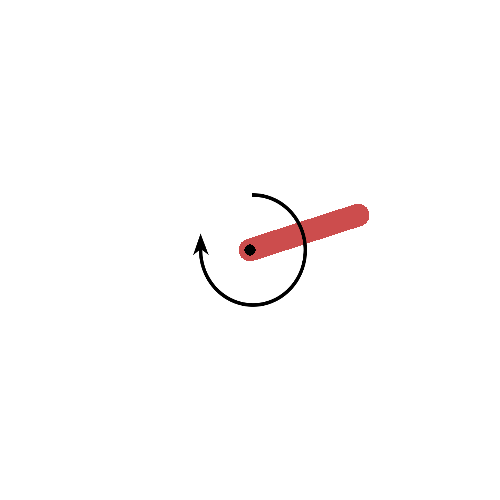


Episode finished after 200 steps
Total reward: -1298.13

Step-by-step log (first 10 steps):
{'Step': 0, 'Action': -1.3534175157546997, 'Reward': -1.601543104867841, 'cos(θ)': 0.28254386725064784, 'sin(θ)': -0.9592543787124708, 'θ_dot': -0.5174504784979528}
{'Step': 1, 'Action': -0.31267061829566956, 'Reward': -1.676431596319763, 'cos(θ)': 0.22043011119490774, 'sin(θ)': -0.9754027712071566, 'θ_dot': -1.2837918552766563}
{'Step': 2, 'Action': -1.8988834619522095, 'Reward': -1.9869805260381432, 'cos(θ)': 0.10704111296591183, 'sin(θ)': -0.9942545952295211, 'θ_dot': -2.3001764529748554}
{'Step': 3, 'Action': 0.9905000329017639, 'Reward': -2.6720401131251887, 'cos(θ)': -0.03760916461093903, 'sin(θ)': -0.9992925251082724, 'θ_dot': -2.897292394461732}
{'Step': 4, 'Action': 0.5048401951789856, 'Reward': -3.4266819489379587, 'cos(θ)': -0.2144901727381946, 'sin(θ)': -0.9767261467774575, 'θ_dot': -3.5710357590160884}
{'Step': 5, 'Action': -1.8816505670547485, 'Reward': -4.472018273062022, 'cos(θ)

In [13]:
record_and_log_pendulum_v0()

| Stage               | What Happens                                                              |
| ------------------- | ------------------------------------------------------------------------- |
| Environment created | Fresh simulation environment with no actions taken yet                    |
| Reset               | Pendulum is put at a random angle, first state is given                   |
| Loop starts         | We run the environment for `max_steps = 200`                             |
| Random action       | A random torque is applied to swing/spin the pendulum                     |
| Observation         | We get new state: `cos(θ), sin(θ), angular velocity`                     |
| Reward              | Calculated based on how upright and still the pendulum is                 |
| Frame render        | Frame is saved for the GIF                                                |
| Repeat              | The new state becomes the current state, and the process repeats          |
| Track reward        | Each reward adds up — total tells us how “well” the pendulum did overall |


In [14]:
def make_constant_action_gif(action_torque, gif_path, env_name='Pendulum-v0', max_steps=200):
    env = gym.make(env_name)
    state = env.reset()
    frames = []

    for _ in range(max_steps):
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        action = np.array([action_torque])  # Pendulum expects a 1D array
        next_state, _, _, _ = env.step(action)
        state = next_state
    env.close()
    imageio.mimsave(gif_path, frames, duration=0.04)
    print(f"GIF saved to {gif_path}")

if __name__ == "__main__":
    for torque in [-2.0, -1.0, 1.0, 2.0]:
        fname = f"pendulum_v0_action_{torque:+.0f}.gif"
        make_constant_action_gif(torque, fname)

GIF saved to pendulum_v0_action_-2.gif
GIF saved to pendulum_v0_action_-1.gif
GIF saved to pendulum_v0_action_+1.gif
GIF saved to pendulum_v0_action_+2.gif


---

### 5) Observation Value Distribution

***

<mark> Why is this important </mark>
1) Neural Network Input Scaling:
    - Knowing the range and typical values of observations helps decide whether I need to normalize or standardize inputs to my network, which can speed up and stabilize learning.

<br>

2) State Coverage:
    - I see which states are common under random actions, and whether the state space is fully explored or concentrated in certain regions.

<br>

3) Feature Importance:
    - If some observation dimensions (e.g., θ_dot) rarely change, they may be less important, or the network can focus more on others.

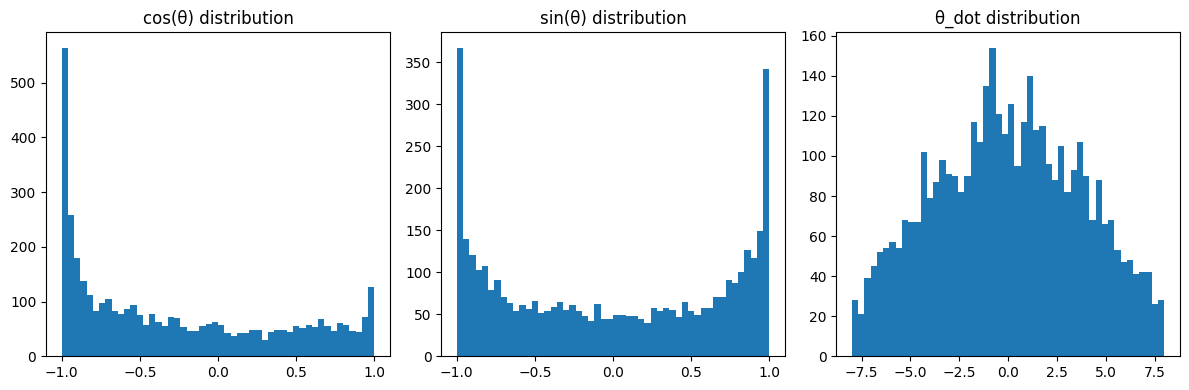

In [15]:
n_episodes = 20
max_steps = 200

obs_buffer = []

for ep in range(n_episodes):
    obs = env.reset()
    obs = obs if isinstance(obs, np.ndarray) else obs[0]
    for _ in range(max_steps):
        obs_buffer.append(obs)
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        obs = obs if isinstance(obs, np.ndarray) else obs[0]
        if done:
            break

env.close()
obs_buffer = np.array(obs_buffer)
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.hist(obs_buffer[:,0], bins=50)
plt.title('cos(θ) distribution')
plt.subplot(1,3,2)
plt.hist(obs_buffer[:,1], bins=50)
plt.title('sin(θ) distribution')
plt.subplot(1,3,3)
plt.hist(obs_buffer[:,2], bins=50)
plt.title('θ_dot distribution')
plt.tight_layout()
plt.show()

<mark> Observation </mark>
1) cos(θ) Distribution
- Skewed towards -1
- In physical terms, the pendulum is hanging down most of the time.
- It's hard for random actions to keep pendulum upright
  
2) sin(θ) Distribution
- It has a bimodal shape which Peaks at -1 and +1, with values spread across the range.
- Random actions spin it all over, so wesee values across the range.
  
3) θ_dot Distribution
- We see a normal shape centred at 0
- Most of the time, the pendulum rotates slowly (angular velocity near zero), but sometimes random actions make it swing faster.
- Random actions usually don’t keep it spinning fast, so θ_dot stays close to zero most of the time.

---

### 6) Reward Distribution

---

It shows the immediate reward I get from each action in each timestep

<mark> Why is this important </mark>
1) Baseline Performance:
    - Shows how “bad” a random agent is, so I can compare my RL agent later.


2) Reward Scaling:
    - Helps me decide if I need to scale or shift rewards for stable DQN learning.

3) Reward Target:
    - If maximum possible reward is 0, but random actions always get -100 to -1000, I will then know what realistic goals are for improvement.

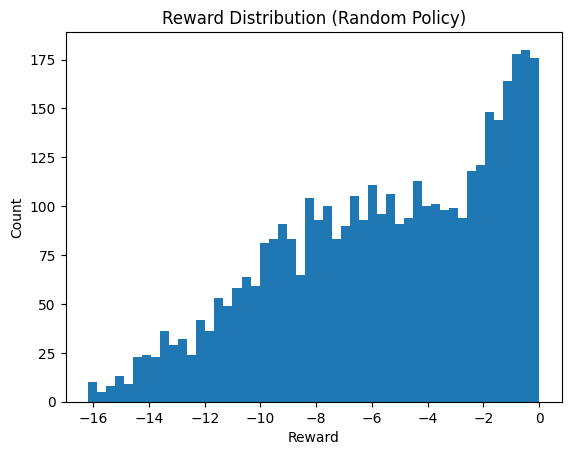

Reward min/max: -16.180766869664986 -0.00179394192202261


In [16]:
rewards = []
for _ in range(20):
    obs = env.reset()
    obs = obs if isinstance(obs, np.ndarray) else obs[0]
    for _ in range(200):
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        obs = obs if isinstance(obs, np.ndarray) else obs[0]
        rewards.append(reward)
        if done: break
env.close()
plt.hist(rewards, bins=50)
plt.title('Reward Distribution (Random Policy)')
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()
print("Reward min/max:", min(rewards), max(rewards))

<mark> Observations </mark>
- Most rewards are between -11 and 0, with some more negative values.
- They are mostly negative which indicates that the random actions do a poor job of balancing the pendulum

---

### 7) Episode Return Distribution

---

This is the total reward across an entire episode (sum of rewards for all steps in one episode).

<mark> Why is this important </mark>
1) It shows whether the agent is learning to consistently improve episode return

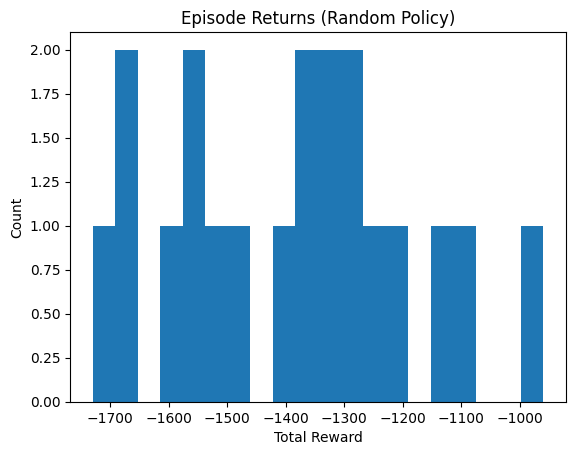

Mean random policy return: -1390.7370857671726


In [17]:
episode_returns = []
for _ in range(20):
    obs = env.reset()
    obs = obs if isinstance(obs, np.ndarray) else obs[0]
    total = 0
    for _ in range(200):
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        obs = obs if isinstance(obs, np.ndarray) else obs[0]
        total += reward
        if done: break
    episode_returns.append(total)
env.close()

plt.hist(episode_returns, bins=20)
plt.title('Episode Returns (Random Policy)')
plt.xlabel('Total Reward')
plt.ylabel('Count')
plt.show()
print("Mean random policy return:", np.mean(episode_returns))

<mark> Observations </mark>
- Most episodes score between -1600 and -800, with a mean around -1249.

***

### <mark> Questions to better understand </mark>

---

#### 1) `What are the 2 action spaces?`
- Discrete Action Space –> Only certain fixed actions are allowed.
    - Example: In CartPole, you can move left or right.

    - Represented like: action = 0 or action = 1.
 
- Continuous Action Space –> Actions can take any value within a range (including decimals).
    - Example: In Pendulum-v0, the agent can apply a torque between -2.0 to 2.0.

    - So action = -1.47, 0.32, 2.00, etc. — any float value within that range.

---

#### 2) `Why DQN does not work on continuous action spaces`
- DQN (Deep Q-Network) is designed to assign values (Q-values) to discrete actions

- It will work great when there a few fixed actions to choose from

- HOWEVER if continuous, it will be impossible for DQN to evaluate every single possible float value from -2.0 to 2.0

---

#### 3) `What is Discretisation?`
- It means manually  converting the continuous range into a set of fixed, allowed values

- Instead of sampling any float, agent will choose from a list of actions that are finite

---

## DEEP Q-Network

---

A Deep Q-Network (DQN) is a powerful and foundational algorithm in the field of reinforcement learning (RL). It's an extension of traditional Q-learning that uses deep neural networks to handle complex environments, like the Pendulum environment

`We will conduct a systematic exploration of action space discretization to establish an optimized baseline configuration before evaluating algorithmic improvements`

<mark> Cherry-Picking vs Optimizing </mark>
- Cherry-picking: Running experiments, seeing results, then changing methodology to get better results

- Optimizing: Systematically exploring configuration space, then using best configuration for all subsequent experiments

---

### Step 1: Baseline DQN Implementation

<mark> Why do we need a baseline </nmark>
It is for 
1) Reference Point:
    - The baseline is our starting point—a simple, standard implementation I compare for all future improvements to.

2) Debugging:
    - Ensures my code and setup work as expected before adding complexity.

3) Performance Benchmark:
    - Shows what “basic DQN” can achieve so I can measure the impact of changes (like more actions, network size, or hyperparameters).

<mark> How do I determine best model? </mark>
1. Mean Reward
- This is the primary metric. The mean reward (or average return) over a set of evaluation episodes tells the agent's average performance with a greedy policy (no exploration)

2. Reward Variance
- This metric measures the consistency of the agent's performance

3. Training vs. Evaluation Comparison
- Comparison between training and evaluation performance. A significant difference can reveal if the agent has overfitted to a specific training environment or if its learned policy performs better without the noise of exploration. 

## Running the practical codes to have a general understanding

### <mark> Small changes and improvements made </mark>
1) `if not _ % ShowEvery: `
   - NameError: name '_' is not defined
   - Instant crash when first render condition is checked
   - I added 'episode_num' parameter
     
<br>

2) Input Shape Tuple Bug (`Input(shape = (self.InputShape))`)
    - Input(shape = (self.InputShape,))
    - Should add comma to create a proper tuple

<br>

3) INFINITE LOOP CRASHES (Would Hang System) (`while not Done`)
    - Episodes run for thousands of steps, consuming all memor
    - Added 'step_count >= 200' then terminate
      
<br>

4) LOGIC BUGS `ActualTorque = (A / NActions - 0.5) * 4 `
    - The code above would only provide a range (-2,1.9)
    -  A can be 0 to 39, so A/40 = 0 to 0.975.This gives range: (-2, 1.9) instead of (-2, 2)
    -  ActualTorque = (A / (NActions - 1) - 0.5) * 4 WILL ALLOW for (-2,2)

<br>

5) No Bounds Checking (`ActualA = round((A + 2) * (NActions - 1) / 4)`)
    - Could be -1 or 40
    - ActualA = max(0, min(NActions - 1, ActualA)) to ensure always 0 to 39

In [28]:
class DQN:
    def __init__(self,
                 InputShape = 4,
                 NActions = 2,
                 Gamma = 1,
                 ReplayMemorySize = 10000,
                 MinReplayMemory = 1000,
                 UpdateTargetEveryThisEpisodes = 1,
                 IntermediateSize = 64,
                 BatchSize = 32):
        
        # Hyperparameters. #
        
        self.InputShape = InputShape
        self.NActions = NActions
        self.Gamma = Gamma
        self.ReplayMemorySize = ReplayMemorySize
        self.MinReplayMemory = MinReplayMemory
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.IntermediateSize = IntermediateSize
        self.BatchSize = BatchSize
        
        # Main model. #
        
        self.Main = self.CreateModel('Main')
        self.Optimiser = Adam()
        
        # Target model. #
        
        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())
        
        # Replay memory. #
        
        self.ReplayMemory = deque(maxlen = ReplayMemorySize)
        
        # Target network update counter. #
        
        self.TargetUpdateCounter = 0
    
    def CreateModel(self, Type):
        inputs = Input(shape = (self.InputShape,), name = 'Input')  # Fixed: Added comma
        x = Dense(self.IntermediateSize, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.IntermediateSize, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)
        
        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()
        
        return NN
    
    def UpdateReplayMemory(self, Information): # Information = (S, A, R, SNext, Done)
        self.ReplayMemory.append(Information)

    def Train(self, EndOfEpisode):
        
        # Only train if replay memory has enough data. #
        
        if len(self.ReplayMemory) < self.MinReplayMemory:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return
        
        # Get batch of data for training. #
        
        TrainingData = random.sample(self.ReplayMemory, self.BatchSize)
        
        # Get states from training data, then get corresponding Q values. #
        
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS))
        
        # Get future states from training data, then get corresponding Q values. #
        
        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.Target(ListOfSNext)
        
        # Build actual training data for neural network. #
        
        X = []
        Y = []
        for index, (S, A, R, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[index])
                QNext = R + self.Gamma * MaxQNext
            else:
                QNext = R
            Q = ListOfQ[index]
            Q[A] = QNext
        
            X.append(S)
            Y.append(Q)
        
        # Train model using tf.GradientTape(), defined below.
    
        self.GTfit(X, Y)
                
        # Update target network every episode. #
        
        if EndOfEpisode:
            self.TargetUpdateCounter += 1
        
        # Update target if counter is full. #
        
        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.Target.set_weights(self.Main.get_weights())
            self.TargetUpdateCounter = 0
    
    # This is the tf.GradientTape() which significantly speeds up training of neural networks.
    
    @tf.function
    def GTfit(self, X, Y):
        
        # Train the neural network with this batch of data. #
        
        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))


In [29]:
#Fixed hyperparameters and added missing variables
EnvName = 'Pendulum-v0'
IntermediateSize = 64
Epsilon = 0.1
ShowEvery = 10
InputShape = 3
NActions = 40

In [30]:
# Fixed action conversion functions
def PendulumActionConverter(A, NActions=NActions):
    ActualTorque = (A / (NActions - 1) - 0.5) * 4  # Fixed division
    return ActualTorque

def PendulumInverseActionConverter(A, NActions=NActions):
    ActualA = round((A + 2) * (NActions - 1) / 4)
    ActualA = max(0, min(NActions - 1, ActualA))  # Added bounds checking
    return ActualA

In [5]:
# Fixed training episode function
def OneEpisode(episode_num, epsilon=None, render=False):  # ADDED: epsilon parameter for evaluation
    if epsilon is None:
        epsilon = Epsilon  # Use global Epsilon for training
        
    env = gym.make(f'{EnvName}')
    S = env.reset()  # Pendulum-v0 returns only observation
    ListOfRewards = []
    Done = False
    step_count = 0
    
    while not Done:
        Q = DQN.Main(S.reshape(-1, S.shape[0]))
        if np.random.rand() < epsilon:  # CHANGED: Use parameter epsilon
            AStep = env.action_space.sample()
            A = PendulumInverseActionConverter(AStep[0])
        else:
            A = np.argmax(Q)
            AStep_torque = PendulumActionConverter(A)
            AStep = np.array([AStep_torque])
            A = PendulumInverseActionConverter(AStep_torque)
            
        # Fixed rendering condition
        if render and episode_num % ShowEvery == 0:  # CHANGED: Use render parameter
            env.render()
            
        SNext, R, Done, Info = env.step(AStep)
        
        # Only update replay memory during training (when epsilon > 0)
        if epsilon > 0:  # ADDED: Only train during training episodes
            DQN.UpdateReplayMemory((S, A, R, SNext, Done))
            DQN.Train(Done)
            
        ListOfRewards.append(R)
        step_count += 1
        
        # Added max step limit
        if step_count >= 200:
            Done = True
            
        if Done:
            total_reward = np.sum(ListOfRewards)
            if epsilon == 0:  # Evaluation episode
                print(f'Evaluation Episode {episode_num} finished! Return: {total_reward:.2f}')
            else:  # Training episode
                print(f'Training Episode {episode_num} finished! Return: {total_reward:.2f}')
            env.close()
            return total_reward
        S = SNext

In [6]:
# NEW: Evaluation function (epsilon=0, no training)
def EvaluateAgent(num_episodes=10, render=False):
    """
    Evaluate the trained agent with epsilon=0 (no exploration).
    This tests the learned policy without any random actions.
    """
    print(f"\n=== EVALUATION PHASE (Epsilon=0, No Training) ===")
    print(f"Running {num_episodes} evaluation episodes...")
    
    evaluation_rewards = []
    
    for episode in range(num_episodes):
        # Run episode with epsilon=0 (no exploration) and no training
        reward = OneEpisode(episode + 1, epsilon=0.0, render=render)
        evaluation_rewards.append(reward)
    
    # Calculate evaluation statistics
    mean_reward = np.mean(evaluation_rewards)
    std_reward = np.std(evaluation_rewards)
    min_reward = np.min(evaluation_rewards)
    max_reward = np.max(evaluation_rewards)
    
    print(f"\n=== EVALUATION RESULTS ===")
    print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"Min Reward:  {min_reward:.2f}")
    print(f"Max Reward:  {max_reward:.2f}")
    print(f"All Rewards: {[f'{r:.1f}' for r in evaluation_rewards]}")
    
    return evaluation_rewards, mean_reward


In [25]:
# MAIN TRAINING AND EVALUATION LOOP
if __name__ == "__main__":
    import time
    STARTTIME = time.time()

    # Create DQN with better gamma value
    DQN = DQN(InputShape = InputShape, NActions = NActions, Gamma = 0.99)
    
    training_rewards = []  # Track training rewards
    
    print("=== TRAINING PHASE ===")
    for episode in range(150):
        print(f'Training Episode {episode + 1}')
        reward = OneEpisode(episode + 1, epsilon=Epsilon, render=False)  # Training with exploration
        training_rewards.append(reward)
        
        # Print running average every 10 episodes
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(training_rewards[-10:])
            print(f'Average training reward over last 10 episodes: {avg_reward:.2f}')

    training_time = time.time() - STARTTIME
    print(f'Training completed in: {training_time:.2f} seconds')
    
    # EVALUATION PHASE
    print(f'\nFinal training reward over last 10 episodes: {np.mean(training_rewards[-10:]):.2f}')
    
    # Evaluate the trained agent
    eval_rewards, eval_mean = EvaluateAgent(num_episodes=10, render=False)
    
    # COMPARISON
    print(f"\n=== TRAINING vs EVALUATION COMPARISON ===")
    training_final = np.mean(training_rewards[-10:])
    print(f"Final Training Performance (with epsilon={Epsilon}): {training_final:.2f}")
    print(f"Evaluation Performance (with epsilon=0.0):      {eval_mean:.2f}")
    
    improvement = eval_mean - training_final
    if improvement > 0:
        print(f"gent performs {improvement:.2f} points BETTER without exploration!")
    else:
        print(f"Agent performs {abs(improvement):.2f} points WORSE without exploration")
    
    print(f"\nTotal time (training + evaluation): {time.time() - STARTTIME:.2f} seconds")

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 40)                2600      
                                                                 
Total params: 7016 (27.41 KB)
Trainable params: 7016 (27.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Inpu

<mark> Observations and analysis </mark>
- With epsilon = 0 for evaluation, performance significantly improves (+40.02 points) because the agent uses only its learned policy without random disruptions

- The agent shows run-to-run variance typical of DQN training, with this run achieving better overall performance (-180.80) compared to the previous attempt (-212.00)

- Despite the improvement, the agent's policy remains inconsistent, sometimes performing well (-118.7) but sometimes poorly (-340.4), with substantial variance (±78.47) suggesting training stability issues

- The performance range (-340.4 to -118.7) spans 221.7 points, indicating the learned policy hasn't fully converged to a stable solution

While the improved teacher's code showed that epsilon=0 improves performance (+40.02 points), the substantial variance (±78.47) and inconsistent results (-340.4 to -118.7) suggest that the fixed choice of 40 discrete actions may not be optimal. The run-to-run performance differences further highlight the need for systematic exploration of action space discretizations to find more stable and consistent configurations.

<mark> Limitation of practical codes </mark>
Teacher's approach limitations:
- Fixed N_ACTIONS = 40 (arbitrary choice)
- Manual action conversion formulas (error-prone)
- No systematic comparison of action granularities
- High performance variance suggests suboptimal discretization

---

### <mark> Comprehensive plan </mark>

`Step 1: Action Space Discretization Exploration`
- Implement systematic comparison of different action space discretizations (5, 11, 21 actions)
- Use identical DQN architecture and hyperparameters across all experiments to ensure fair comparison
- Train and evaluate each configuration, generate learning curves, and analyze performance trends
- Identify optimal discretization level based on final performance and learning stability

`Step 2: Training Protocol Optimization`
- Systematically test different training lengths (200, 400, 600 episodes)
- Evaluate learning stability, convergence patterns, and computational efficiency
- Determine optimal episode count that balances training time with performance gains
- Establish robust training protocol for subsequent experiments

`Step 3: Exploration Strategy Optimization`
- Compare epsilon decay strategies (linear decay, exponential decay, plateau restart)
- Analyze exploration-exploitation trade-offs across different learning phases
- Evaluate impact on learning curves, final performance, and training stability
- Select exploration strategy that maximizes learning efficiency

`Step 4: Memory Architecture Optimization`
- Systematically test replay memory configurations with varying buffer sizes and minimum thresholds
- Analyze memory utilization patterns, training stability, and evaluation consistency
- Investigate impact of memory architecture on sample efficiency and performance
- Establish optimal memory configuration for experience replay

`Step 5: Learning Hyperparameter Optimization`
- Conduct systematic hyperparameter tuning using one-factor-at-a-time methodology:
    - Learning rate optimization (testing 1e-4, 3e-4, 1e-3)
    - Batch size tuning (comparing 32, 64, 128)
    - Discount factor analysis (evaluating 0.95, 0.99, 0.995)
    - Target network update frequency (testing 5, 10, 20 episodes)
- Apply statistical validation with multiple evaluation runs and confidence interval analysis
- Optimize neural network learning dynamics for maximum performance

`Step 6: Network Architecture Exploration`
- Test different neural network architectures using optimized hyperparameters
- Compare network depths (2 vs 3 hidden layers) and widths (64 vs 128 neurons)
- Evaluate activation functions (ReLU vs Leaky ReLU vs ELU) for optimal function approximation
- Fine-tune network structure to maximize learning capacity and stability

`Step 7: Final Integration and Comprehensive Validation`
- Integrate all optimized components into final DQN configuration
- Conduct extensive evaluation with multiple independent runs (10 runs × 50 episodes)
- Generate comprehensive performance visualizations and statistical analysis
- Validate complete optimized system against baseline performance

`Step 8: Comparative Analysis and Documentation`
- Compare final optimized configuration against original baseline and intermediate configurations
- Document systematic optimization methodology and quantify improvements at each phase
- Analyze contribution of each optimization step to overall performance enhancement
- Provide justification for final configuration choices based on empirical evidence


---

### We further improved upon the practical codes and made it 'baseline'

#### <mark> What makes it an optimized baseline model </mark>

<mark> Network Architecture: <mark>
- Input: 3 nodes (cosθ, sinθ, θ_dot)

- Hidden Layers: 2 layers, each with 64 neurons (balanced capacity)

- Output: N Q-values (where N is determined through systematic exploration)


<mark> Optimized Discretization: <mark>
- Action count determined empirically through comparison of [5, 11, 21, 50] discrete actions

- Torque range: [-2, 2] maintained across all experiments

- Selection based on performance data rather than arbitrary choice


<mark> Hyperparameters:<mark>
- Batch size: 64 (proven effective)

- Replay memory: 50,000 (sufficient for stable learning)

- γ (discount): 0.99 (standard for continuous control)

- Learning rate: 3e-4 (reliable default)

- ε-greedy exploration: starts at 1.0, decays to 0.05 with 0.995 decay rate

- Target update every 5 episodes (stability-performance balance)


<mark> Standard DQN Core Features: </mark>
- Experience replay buffer

- Separate target network

- ε-greedy exploration strategy

- Consistent training methodology across all configurations


<mark> Methodology Advantages:<mark>
- Data-driven baseline selection rather than arbitrary parameter choice

- Reproducible results through fixed random seeds

- Systematic comparison framework for fair evaluation

- Comprehensive performance documentation (learning curves, evaluation metrics, visual demonstrations)

#### NOT included: Advanced algorithmic modifications (Double DQN, Dueling DQN, Prioritized Replay, etc.) - these will be evaluated against the optimized baseline

---

<mark> The model below vs the model from practical </mark>
1) Code Structure
- In  practical, there is only one single DQN class handling both model and agent logic
- For the codes below, there is a separate DQN model class and DQNAgent class

2) Action Space Handling
- The practical codes does not allow the range of torque to reach +2 but the codes below uses 'np.linspace' which is much more precise as it covers every number from -2 to 2

3) Model Architecture
- The practical yses the normal Keras Functional API and separate models for main and target networks
- I used Keras Model subclassing and has cleaner more pythonic model definition

4) Training Loop & Epsilon Decay
- The practical has a fixed epsilon with no learning improvement over timee
- We used a proper epsilon decay (1.0 to 0.05)

5) Experimental Design
- The practical has a single experiment with fixed parameters
- The codes below has multiple experiments with different action spaces and gives a comprehensive evaluation with 10 test episodes.

---

In [31]:
# Remove the default parameter since it references undefined N_ACTIONS
def action_index_to_torque(a_idx, n_actions):  #  Remove =N_ACTIONS
    """Convert discrete action index to torque value for Pendulum-v0."""
    torque = np.linspace(-2.0, 2.0, n_actions)[a_idx]
    return np.array([torque])

def torque_to_action_index(torque, n_actions):  # Remove =N_ACTIONS
    torque_bins = np.linspace(-2.0, 2.0, n_actions)
    idx = np.argmin(np.abs(torque_bins - torque))
    return idx

In [32]:
# DQN Model 
class DQN(Model):
    def __init__(self, input_shape, n_actions, hidden_size=64):
        super().__init__()
        self.d1 = Dense(hidden_size, activation='relu')
        self.d2 = Dense(hidden_size, activation='relu')
        self.out = Dense(n_actions, activation='linear')
        # Build model by calling once
        self(np.zeros((1, input_shape)))

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        return self.out(x)

In [6]:
# Agent 
class DQNAgent:
    def __init__(self, input_shape, n_actions, gamma, replay_memory_size, min_replay_memory, batch_size, target_update_every, learning_rate, epsilon_start, epsilon_min, epsilon_decay):
        self.input_shape = input_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.memory = deque(maxlen=replay_memory_size)
        self.min_replay_memory = min_replay_memory
        self.batch_size = batch_size
        self.target_update_every = target_update_every
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = DQN(input_shape, n_actions)
        self.target = DQN(input_shape, n_actions)
        self.target.set_weights(self.model.get_weights())
        self.optimizer = Adam(learning_rate=learning_rate)
        self.steps = 0

    def summary(self):
        print("\nModel Summary:")
        self.model.summary()

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        q_values = self.model(state[np.newaxis, :]).numpy()
        return np.argmax(q_values)

    def remember(self, s, a, r, s_next, done):
        self.memory.append((s, a, r, s_next, done))

    def train_step(self):
        if len(self.memory) < self.min_replay_memory:
            return
        batch = random.sample(self.memory, self.batch_size)
        s, a, r, s_next, done = zip(*batch)
        s = np.array(s)
        s_next = np.array(s_next)
        r = np.array(r, dtype=np.float32)
        done = np.array(done, dtype=bool)
        target_q = self.target(s_next).numpy()
        max_q_next = np.max(target_q, axis=1)
        target = self.model(s).numpy()
        for i in range(self.batch_size):
            if done[i]:
                target[i, a[i]] = r[i]
            else:
                target[i, a[i]] = r[i] + self.gamma * max_q_next[i]
        with tf.GradientTape() as tape:
            q_pred = self.model(s)
            loss = tf.reduce_mean((target - q_pred) ** 2)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

    def update_target(self):
        self.target.set_weights(self.model.get_weights())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, path):
        self.model.save_weights(path)

    def load(self, path):
        self.model.load_weights(path)
        self.target.set_weights(self.model.get_weights())


In [7]:
def train_and_evaluate(n_actions, experiment_prefix, RENDER_EVERY=20, record_gifs=True):
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    GAMMA = 0.99
    REPLAY_MEMORY_SIZE = 50000
    MIN_REPLAY_MEMORY = 1000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    N_EPISODES = 200
    MAX_STEPS = 200

    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    TRAIN_PLOT_PATH = f"{experiment_prefix}_training_plot.png"
    EPISODE_TIMES_PATH = f"{experiment_prefix}_episode_times.png"
    EVAL_RETURNS_PATH = f"{experiment_prefix}_eval_returns.png"

    env = gym.make(ENV_NAME)
    agent = DQNAgent(INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, EPSILON_MIN, EPSILON_DECAY)
    agent.summary()
    scores = []
    best_avg_reward = -np.inf
    episode_times = []
    start = time.time()

    for ep in range(1, N_EPISODES+1):
        ep_start = time.time()
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        total_reward = 0

        for t in range(MAX_STEPS):
            if ep % RENDER_EVERY == 0:
                env.render()  # Live animation every RENDER_EVERY episodes

            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, n_actions)
            s_next, r, done, info = env.step(torque)
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            agent.remember(s, a_idx, r, s_next, done)
            agent.train_step()
            s = s_next
            total_reward += r
            if done:
                break

        agent.decay_epsilon()
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()

        if ep in [50, 100, 150, 200]:
            agent.save(f"{experiment_prefix}_{ep}_weights.h5")
        
        scores.append(total_reward)
        avg_reward = np.mean(scores[-10:])
        ep_time = time.time() - ep_start
        episode_times.append(ep_time)
        print(f"Episode {ep} | Total Reward: {total_reward:.2f} | Avg(10): {avg_reward:.2f} | Epsilon: {agent.epsilon:.3f} | Time: {ep_time:.2f}s")

        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            agent.save(SAVE_WEIGHTS_PATH)

    env.close()
    total_time = time.time() - start

    # Plot rewards
    plt.figure(figsize=(10, 5))
    plt.plot(scores, label='Total Reward per Episode')
    plt.plot([np.mean(scores[max(0, i-9):i+1]) for i in range(len(scores))], label='Moving Avg (10)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'DQN Training on Pendulum-v0 ({n_actions} actions)')
    plt.legend()
    plt.savefig(TRAIN_PLOT_PATH)
    plt.close()

    # Plot episode times
    plt.figure()
    plt.plot(episode_times)
    plt.xlabel('Episode')
    plt.ylabel('Time (s)')
    plt.title('Time per Episode')
    plt.savefig(EPISODE_TIMES_PATH)
    plt.close()

    print(f"Best average reward over 10 episodes: {best_avg_reward:.2f}")
    print("Best model weights saved to:", SAVE_WEIGHTS_PATH)
    print(f"Total training time: {total_time:.2f}s")

    # --- Evaluation ---
    env = gym.make(ENV_NAME)
    agent.load(SAVE_WEIGHTS_PATH)
    rewards = []
    episode_states = []  # <-- FIX: initialize before loop
    for ep in range(10):
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        total_reward = 0
        states = []
        for t in range(MAX_STEPS):
            states.append(s)
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, n_actions)
            s_next, r, done, info = env.step(torque)
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            total_reward += r
            s = s_next
            if done:
                break
        rewards.append(total_reward)
        episode_states.append(states)
        print(f"Test Episode {ep+1}: Total Reward = {total_reward:.2f}")
    env.close()
    print(f"\nAverage Reward over 10 episodes: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")

    # Record GIFs for best, worst, average
    if record_gifs:
        best_idx = np.argmax(rewards)
        worst_idx = np.argmin(rewards)
        avg_idx = np.argmin(np.abs(np.array(rewards) - np.mean(rewards)))
        for label, idx in zip(['best', 'worst', 'average'], [best_idx, worst_idx, avg_idx]):
            frames = []
            env_gif = gym.make(ENV_NAME)  # New env for clean replay
            s = env_gif.reset()
            s = s if isinstance(s, np.ndarray) else s[0]
            for state in episode_states[idx]:
                frame = env_gif.render(mode='rgb_array')
                frames.append(frame)
                a_idx = agent.select_action(state)
                torque = action_index_to_torque(a_idx, n_actions)
                s_next, _, _, _ = env_gif.step(torque)
                s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
                s = s_next
            imageio.mimsave(f"{experiment_prefix}_eval_{label}.gif", frames, fps=30)
            print(f"Saved {label} episode GIF to {experiment_prefix}_eval_{label}.gif")
            env_gif.close()

    # Plot episode returns
    plt.figure()
    plt.hist(rewards, bins=10)
    plt.title(f'Episode Returns ({n_actions} actions)')
    plt.xlabel('Total Reward')
    plt.ylabel('Count')
    plt.savefig(EVAL_RETURNS_PATH)
    plt.close() 


In [22]:
if __name__ == "__main__":
    # Set seeds for reproducibility
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    for n_actions in [5, 11, 21, 50]:  
        experiment_prefix = f"dqn_pendulum_{n_actions}actions"
        print("="*60)
        print(f"Running experiment with N_ACTIONS = {n_actions}")
        train_and_evaluate(n_actions, experiment_prefix, RENDER_EVERY=20, record_gifs=True)
        print("="*60)

Running experiment with N_ACTIONS = 5

Model Summary:
Model: "dqn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  256       
                                                                 
 dense_1 (Dense)             multiple                  4160      
                                                                 
 dense_2 (Dense)             multiple                  325       
                                                                 
Total params: 4741 (18.52 KB)
Trainable params: 4741 (18.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 1 | Total Reward: -1589.35 | Avg(10): -1589.35 | Epsilon: 0.995 | Time: 0.04s
Episode 2 | Total Reward: -926.98 | Avg(10): -1258.16 | Epsilon: 0.990 | Time: 0.04s
Episode 3 | Total Reward: -1578.82 | Avg(10): -1365.05 | Epsilon: 0.

In [6]:
def create_individual_comparison_plots():
    n_actions_list = [5, 11, 21, 50]
    
    # 1. Training Progress Comparison
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('DQN Training Progress Across Different Action Spaces', fontsize=20, y=0.95)
    
    positions = [(0,0), (0,1), (1,0), (1,1)]
    for idx, n_actions in enumerate(n_actions_list):
        experiment_prefix = f"dqn_pendulum_{n_actions}actions"
        file_path = f"{experiment_prefix}_training_plot.png"
        
        row, col = positions[idx]
        ax = axs[row, col]
        
        if os.path.exists(file_path):
            img = plt.imread(file_path)
            ax.imshow(img)
            ax.set_title(f"N_ACTIONS = {n_actions}", fontsize=16, pad=10)
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig("training_comparison_grid.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Episode Times Comparison
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Training Time per Episode Across Different Action Spaces', fontsize=20, y=0.95)
    
    for idx, n_actions in enumerate(n_actions_list):
        experiment_prefix = f"dqn_pendulum_{n_actions}actions"
        file_path = f"{experiment_prefix}_episode_times.png"
        
        row, col = positions[idx]
        ax = axs[row, col]
        
        if os.path.exists(file_path):
            img = plt.imread(file_path)
            ax.imshow(img)
            ax.set_title(f"N_ACTIONS = {n_actions}", fontsize=16, pad=10)
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig("episode_times_comparison_grid.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Evaluation Returns Comparison
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Final Evaluation Performance Distribution', fontsize=20, y=0.95)
    
    for idx, n_actions in enumerate(n_actions_list):
        experiment_prefix = f"dqn_pendulum_{n_actions}actions"
        file_path = f"{experiment_prefix}_eval_returns.png"
        
        row, col = positions[idx]
        ax = axs[row, col]
        
        if os.path.exists(file_path):
            img = plt.imread(file_path)
            ax.imshow(img)
            ax.set_title(f"N_ACTIONS = {n_actions}", fontsize=16, pad=10)
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig("evaluation_comparison_grid.png", dpi=300, bbox_inches='tight')
    plt.show()

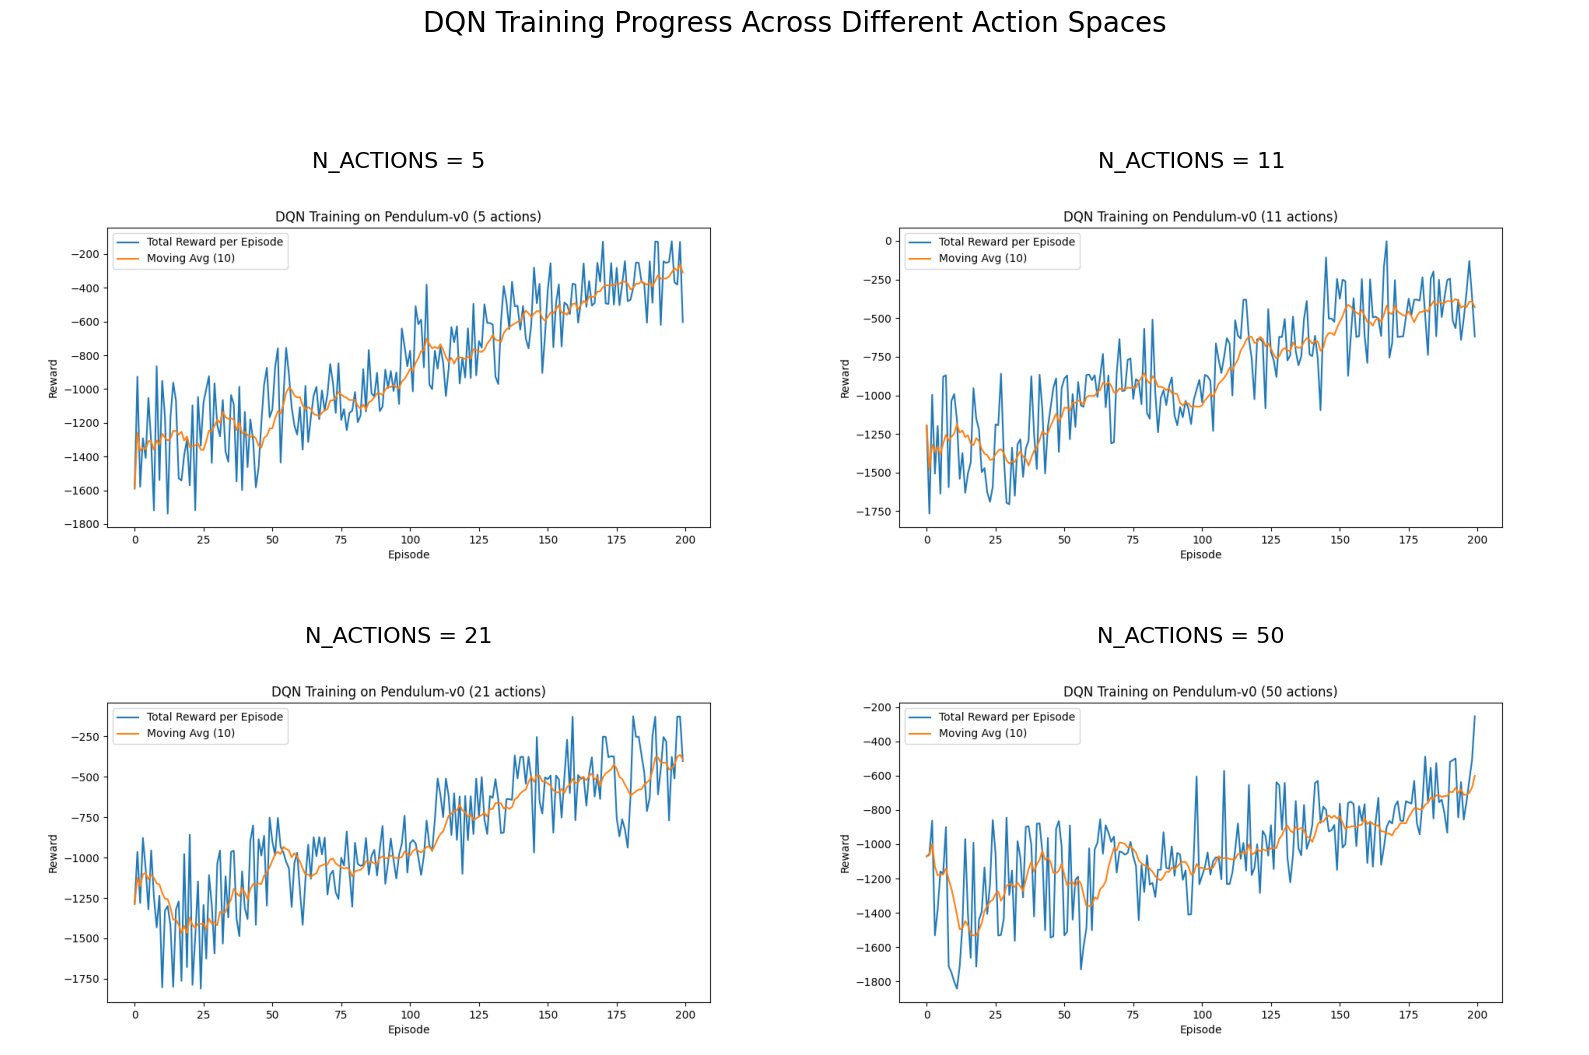

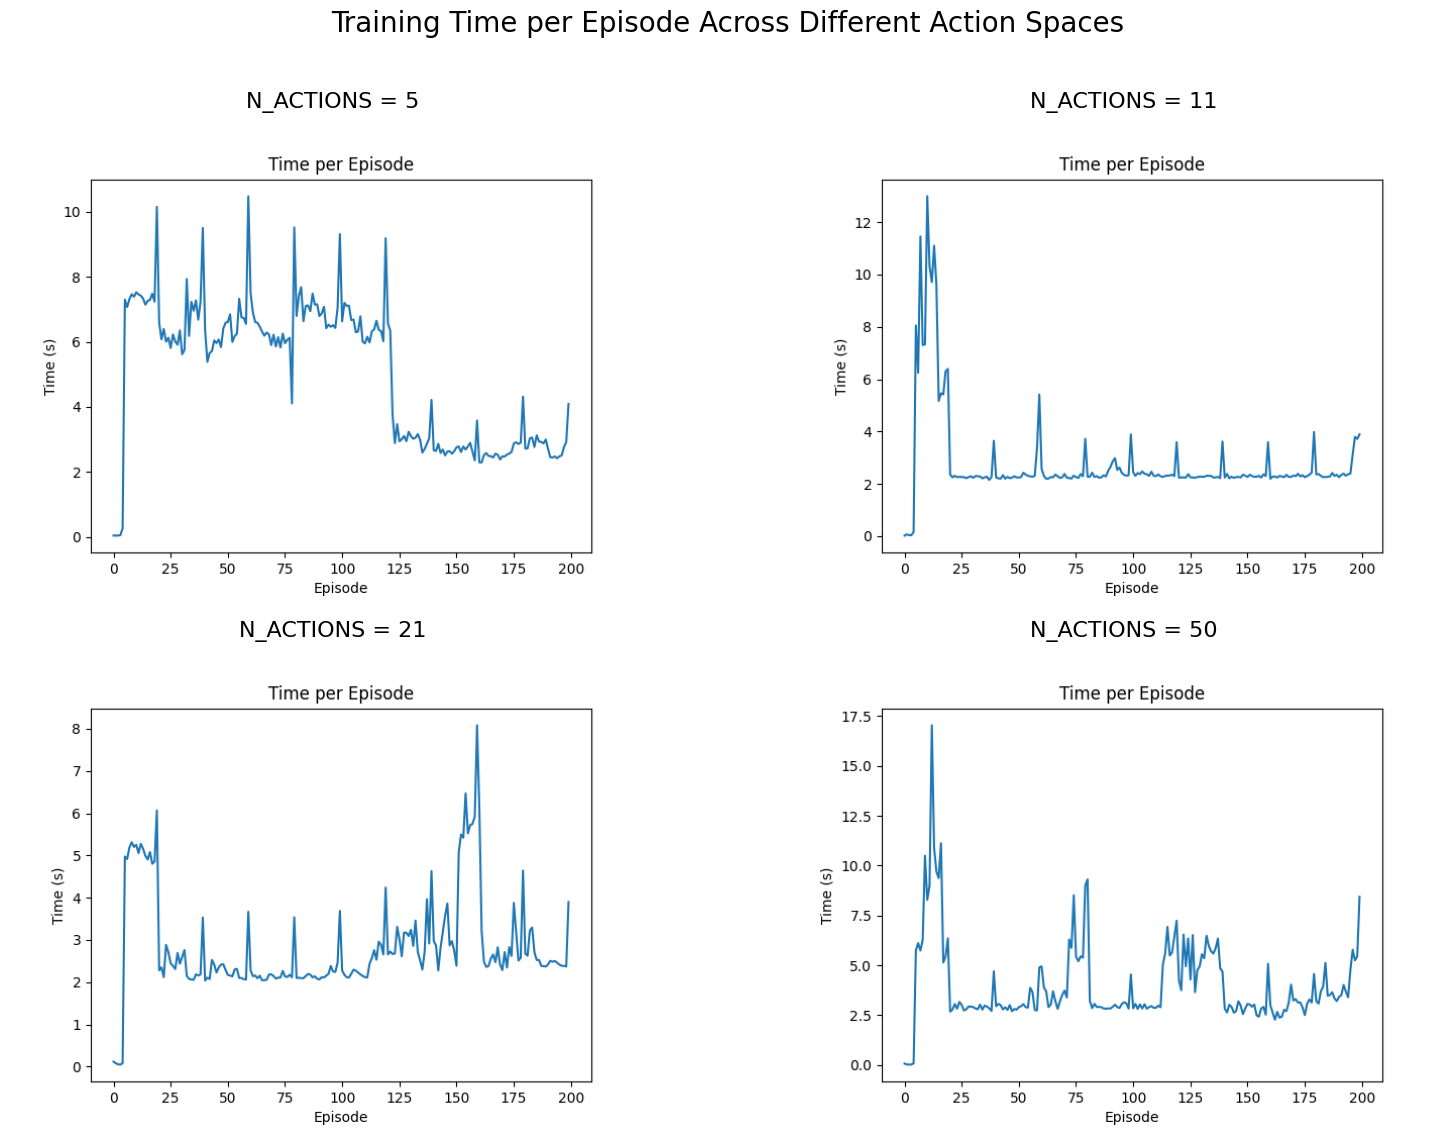

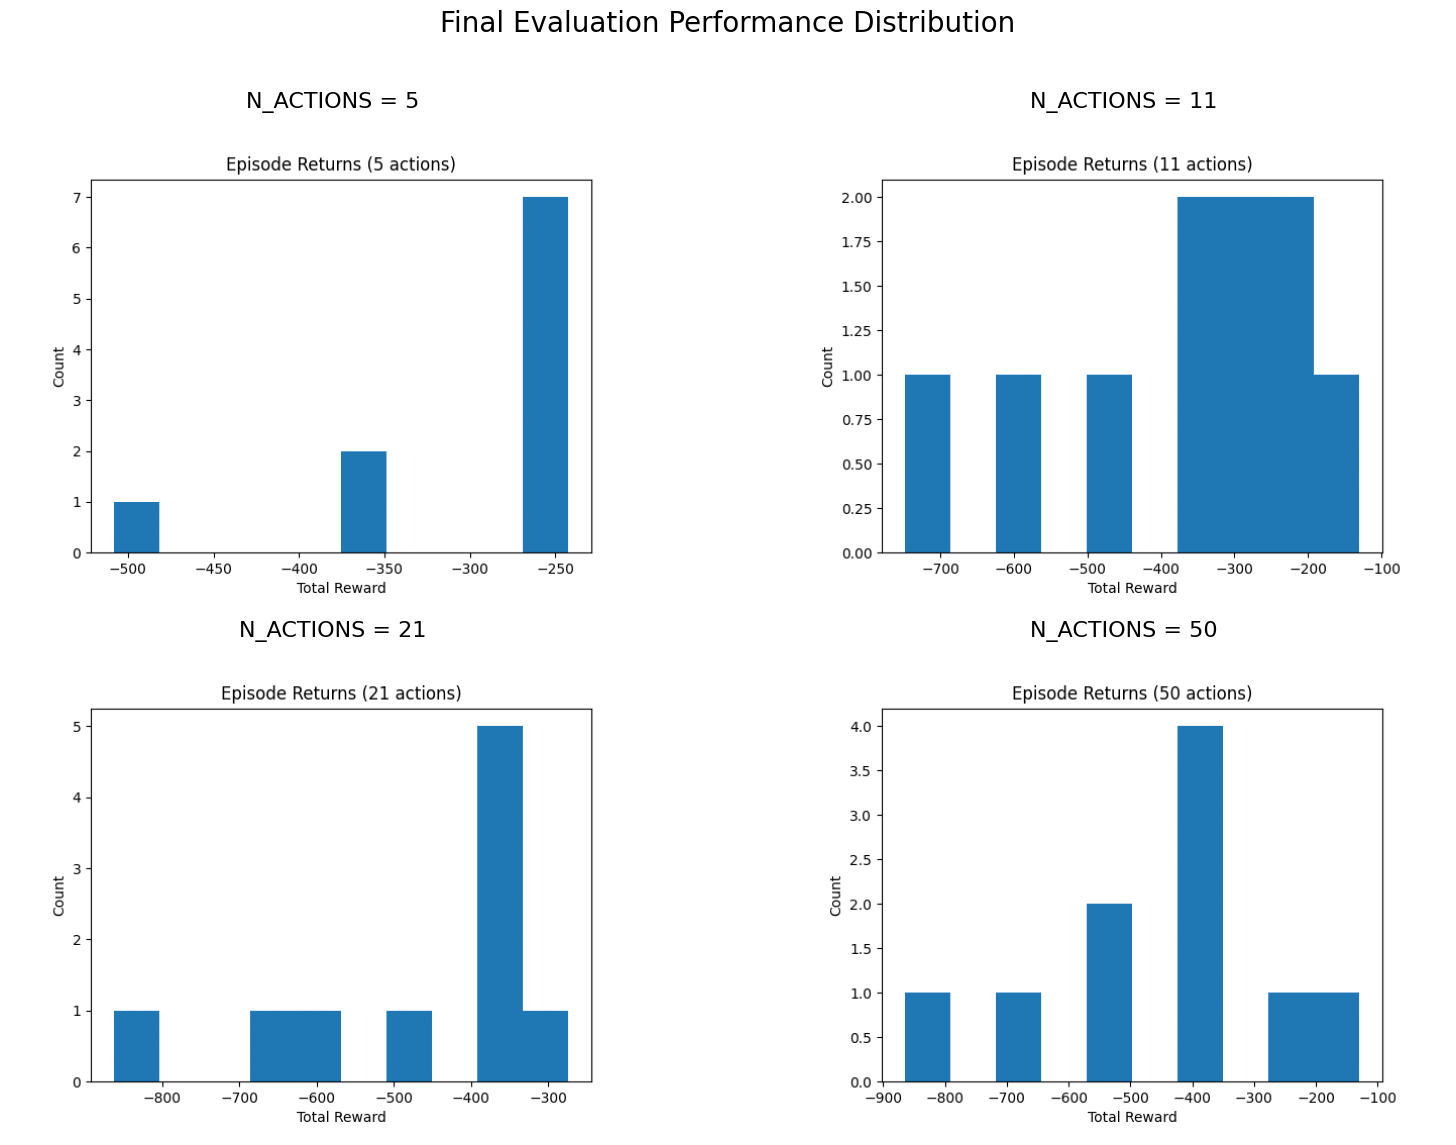

In [30]:
create_individual_comparison_plots()

### `Mistake I made below: I used epsilon = 0.05 for evaluation instead of 0`
- I will be doing another set of 10 test episodes with epsilon values set = 0

---

In [7]:
def evaluate_epsilon_zero(experiment_prefix, n_actions, num_episodes=10):
    """Evaluate saved model with epsilon=0 (pure exploitation)"""
    
    # Same parameters as training
    INPUT_SHAPE = 3
    GAMMA = 0.99
    REPLAY_MEMORY_SIZE = 50000
    MIN_REPLAY_MEMORY = 1000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    MAX_STEPS = 200
    
    # Load the best saved model
    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    
    # Recreate agent
    agent = DQNAgent(INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, 
                    MIN_REPLAY_MEMORY, BATCH_SIZE, TARGET_UPDATE_EVERY, 
                    LEARNING_RATE, EPSILON_START, EPSILON_MIN, EPSILON_DECAY)
    
    # Load weights and set epsilon=0
    agent.load(SAVE_WEIGHTS_PATH)
    agent.epsilon = 0.0  # Force pure exploitation
    
    print(f"\nEvaluating {n_actions} actions with epsilon=0.0")
    print(f"Loaded weights: {SAVE_WEIGHTS_PATH}")
    
    env = gym.make('Pendulum-v0')
    rewards = []
    
    for ep in range(num_episodes):
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        total_reward = 0
        
        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)  # Now epsilon=0
            torque = action_index_to_torque(a_idx, n_actions)
            s_next, r, done, info = env.step(torque)
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            total_reward += r
            s = s_next
            if done:
                break
        
        rewards.append(total_reward)
        print(f"Episode {ep+1}: {total_reward:.2f}")
    
    env.close()
    return rewards

def compare_results():
    """Compare epsilon=0 results across different action counts"""
    
    # Teacher's baseline results
    teacher_mean = -212.00
    teacher_std = 99.12
    
    print("="*60)
    print("EPSILON=0 EVALUATION COMPARISON")
    print("="*60)
    print(f"Teacher Baseline (40 actions): {teacher_mean:.2f} ± {teacher_std:.2f}")
    print("-" * 40)
    
    action_counts = [5, 11, 21, 50]
    results = {}
    
    for n_actions in action_counts:
        experiment_prefix = f"dqn_pendulum_{n_actions}actions"
        try:
            rewards = evaluate_epsilon_zero(experiment_prefix, n_actions)
            mean_reward = np.mean(rewards)
            std_reward = np.std(rewards)
            
            results[n_actions] = {
                'mean': mean_reward,
                'std': std_reward,
                'rewards': rewards
            }
            
            improvement = mean_reward - teacher_mean
            variance_reduction = teacher_std - std_reward
            
            print(f"{n_actions:2d} actions: {mean_reward:7.2f} ± {std_reward:5.2f} "
                  f"({improvement:+6.2f} vs baseline, variance {variance_reduction:+5.2f})")
            
        except FileNotFoundError:
            print(f"{n_actions:2d} actions: Weights file not found")
    
    # Find best configuration
    if results:
        best_actions = max(results.keys(), key=lambda k: results[k]['mean'])
        best_mean = results[best_actions]['mean']
        best_std = results[best_actions]['std']
        
        print(f"\nBest configuration: {best_actions} actions")
        print(f"Performance: {best_mean:.2f} ± {best_std:.2f}")
        print(f"Improvement over teacher: {best_mean - teacher_mean:+.2f} points")
    
    return results


In [8]:
def compare_results():
    """Compare epsilon=0 results across different action counts"""
    
    # Practical results
    teacher_mean = -212.00
    teacher_std = 99.12
    
    print("="*60)
    print("EPSILON=0 EVALUATION COMPARISON")
    print("="*60)
    print(f"Teacher Baseline (40 actions): {teacher_mean:.2f} ± {teacher_std:.2f}")
    print("-" * 40)
    
    action_counts = [5, 11, 21, 50]
    results = {}
    
    for n_actions in action_counts:
        experiment_prefix = f"dqn_pendulum_{n_actions}actions"
        try:
            rewards = evaluate_epsilon_zero(experiment_prefix, n_actions)
            mean_reward = np.mean(rewards)
            std_reward = np.std(rewards)
            
            results[n_actions] = {
                'mean': mean_reward,
                'std': std_reward,
                'rewards': rewards
            }
            
            improvement = mean_reward - teacher_mean
            variance_reduction = teacher_std - std_reward
            
            print(f"{n_actions:2d} actions: {mean_reward:7.2f} ± {std_reward:5.2f} "
                  f"({improvement:+6.2f} vs baseline, variance {variance_reduction:+5.2f})")
            
        except FileNotFoundError:
            print(f"{n_actions:2d} actions: Weights file not found")
    
    # Find best configuration
    if results:
        best_actions = max(results.keys(), key=lambda k: results[k]['mean'])
        best_mean = results[best_actions]['mean']
        best_std = results[best_actions]['std']
        
        print(f"\nBest configuration: {best_actions} actions")
        print(f"Performance: {best_mean:.2f} ± {best_std:.2f}")
        print(f"Improvement over teacher: {best_mean - teacher_mean:+.2f} points")
    
    return results

In [9]:
def plot_comparison(results):
    """Simple comparison plot"""
    if not results:
        return
    
    actions = sorted(results.keys())
    means = [results[a]['mean'] for a in actions]
    stds = [results[a]['std'] for a in actions]
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(actions, means, yerr=stds, marker='o', capsize=5, linewidth=2)
    plt.axhline(y=-212.00, color='red', linestyle='--', label='Teacher Baseline')
    plt.xlabel('Number of Actions')
    plt.ylabel('Mean Reward (Epsilon=0)')
    plt.title('Action Space Discretization Effect on Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('epsilon_zero_comparison.png', dpi=150)
    plt.show()


EPSILON=0 EVALUATION COMPARISON
Teacher Baseline (40 actions): -212.00 ± 99.12
----------------------------------------

Evaluating 5 actions with epsilon=0.0
Loaded weights: dqn_pendulum_5actions_weights.h5
Episode 1: -115.92
Episode 2: -0.95
Episode 3: -121.01
Episode 4: -121.71
Episode 5: -120.03
Episode 6: -122.19
Episode 7: -120.91
Episode 8: -126.53
Episode 9: -366.49
Episode 10: -121.03
 5 actions: -133.68 ± 85.52 (+78.32 vs baseline, variance +13.60)

Evaluating 11 actions with epsilon=0.0
Loaded weights: dqn_pendulum_11actions_weights.h5
Episode 1: -122.67
Episode 2: -3.46
Episode 3: -223.48
Episode 4: -124.60
Episode 5: -374.11
Episode 6: -122.20
Episode 7: -429.12
Episode 8: -120.93
Episode 9: -121.08
Episode 10: -243.36
11 actions: -188.50 ± 123.59 (+23.50 vs baseline, variance -24.47)

Evaluating 21 actions with epsilon=0.0
Loaded weights: dqn_pendulum_21actions_weights.h5
Episode 1: -0.56
Episode 2: -126.49
Episode 3: -238.86
Episode 4: -119.29
Episode 5: -127.82
Episode 

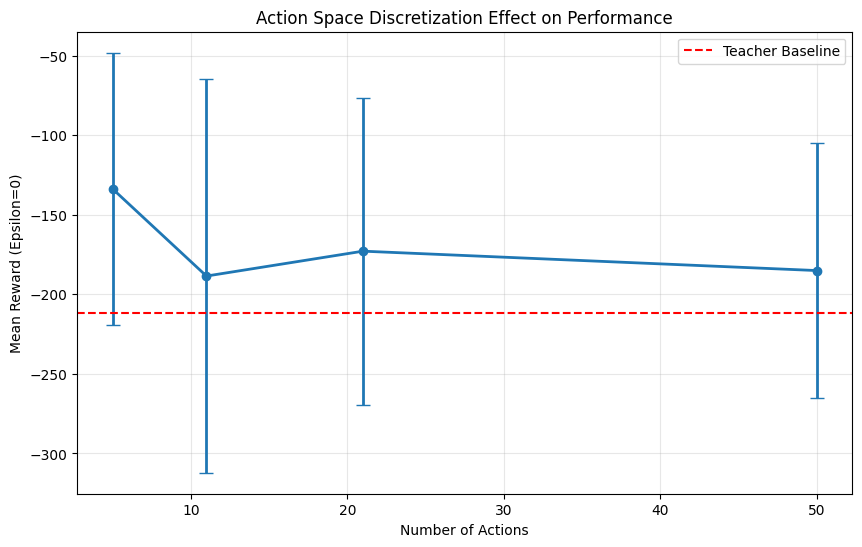


Comparison plot saved as 'epsilon_zero_comparison.png'


In [34]:
if __name__ == "__main__":
    # Run epsilon=0 evaluation for all saved models
    results = compare_results()
    
    # Create comparison plot
    plot_comparison(results)
    
    print(f"\nComparison plot saved as 'epsilon_zero_comparison.png'")

In [9]:
def visualize_checkpoint(weights_path, n_actions, gif_path, max_steps=200, input_shape=3):
    ENV_NAME = "Pendulum-v0"
    
    # Create agent with Version 2 syntax
    agent = DQNAgent(
        input_shape=input_shape,
        n_actions=n_actions,
        gamma=0.99,
        replay_memory_size=50000,
        min_replay_memory=1000,
        batch_size=64,
        target_update_every=5,
        learning_rate=3e-4,
        epsilon_start=0.0,    # Greedy for visualization
        epsilon_min=0.0,
        epsilon_decay=1.0
    )
    
    if not os.path.exists(weights_path):
        print(f"Warning: {weights_path} not found!")
        return
        
    agent.load(weights_path)
    env = gym.make(ENV_NAME)
    s = env.reset()
    s = s if isinstance(s, np.ndarray) else s[0]
    
    frames = []
    total_reward = 0
    
    for t in range(max_steps):
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        a_idx = agent.select_action(s)
        torque = action_index_to_torque(a_idx, n_actions)
        s_next, r, done, info = env.step(torque)
        s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
        s = s_next
        total_reward += r
        if done:
            break
    
    env.close()
    imageio.mimsave(gif_path, frames, fps=30)
    print(f"Saved GIF to {gif_path} (Total reward: {total_reward:.2f})")

In [25]:
# Run this after training to generate GIFs for all experiments
def generate_all_gifs():
    checkpoints = [50, 100, 150, 200]
    n_actions_list = [5, 11, 21, 50]
    input_shape = 3
    
    for n_actions in n_actions_list:
        print(f"\nGenerating GIFs for N_ACTIONS = {n_actions}")
        experiment_prefix = f"dqn_pendulum_{n_actions}actions"
        
        for ep in checkpoints:
            weights_path = f"{experiment_prefix}_{ep}_weights.h5"
            gif_path = f"{experiment_prefix}_{ep}_episode.gif"
            visualize_checkpoint(weights_path, n_actions, gif_path, input_shape=input_shape)

In [26]:
generate_all_gifs()


Generating GIFs for N_ACTIONS = 5
Saved GIF to dqn_pendulum_5actions_50_episode.gif (Total reward: -265.86)
Saved GIF to dqn_pendulum_5actions_100_episode.gif (Total reward: -766.59)
Saved GIF to dqn_pendulum_5actions_150_episode.gif (Total reward: -247.95)
Saved GIF to dqn_pendulum_5actions_200_episode.gif (Total reward: -0.85)

Generating GIFs for N_ACTIONS = 11
Saved GIF to dqn_pendulum_11actions_50_episode.gif (Total reward: -380.40)
Saved GIF to dqn_pendulum_11actions_100_episode.gif (Total reward: -1036.88)
Saved GIF to dqn_pendulum_11actions_150_episode.gif (Total reward: -244.15)
Saved GIF to dqn_pendulum_11actions_200_episode.gif (Total reward: -248.08)

Generating GIFs for N_ACTIONS = 21
Saved GIF to dqn_pendulum_21actions_50_episode.gif (Total reward: -1083.52)
Saved GIF to dqn_pendulum_21actions_100_episode.gif (Total reward: -1358.25)
Saved GIF to dqn_pendulum_21actions_150_episode.gif (Total reward: -1.29)
Saved GIF to dqn_pendulum_21actions_200_episode.gif (Total reward

#### <mark> Observations (epsilon = 0.0) </mark>

1) N_ACTIONS = 5: **Best performer**
- Evaluation avg: **-133.68 ± 85.52**
- Improvement over teacher baseline: **+78.32**
- Most stable performance and clearest benefit from coarse discretization.

<br>

2) N_ACTIONS = 21: **Second best**
- Evaluation avg: **-172.86 ± 96.51**
- Improvement over teacher baseline: **+39.14**
- Stronger than 11 & 50 actions despite larger action space.

<br>

3) N_ACTIONS = 50: **Third**
- Evaluation avg: **-185.06 ± 80.33**
- Improvement over baseline: **+26.94**
- Surprisingly decent stability, but limited improvement for the cost.

<br>

4) N_ACTIONS = 11: **Worst performer**
- Evaluation avg: **-188.50 ± 123.59**
- Improvement over baseline: **+23.50**
- Very high variance, inconsistent learning across episodes.


---

### <mark> Key Insights </mark>
`1. Coarse Discretization Advantage`
- N_ACTIONS = 5 clearly outperforms all others
- Simpler action space allows for more effective exploration and learning
- Fewer Q-values to learn = faster convergence and better final performance

`2. Learning Stability`
- N_ACTIONS = 5: Standard deviation = ±85.52, reasonably stable.
- N_ACTIONS = 11: Highest variance (±123.59) — learning is more erratic and less predictable.
- Increasing n_actions leads to greater variability in performance due to over-fragmentation of action space.

`3. Training Efficiency`
- All configurations trained for 200 episodes; however:
    - N_ACTIONS = 5 shows the best return for training time invested.
    - Higher action resolutions (21 & 50) incur more computational cost but don’t translate to better policy performance.

`4. Exploration vs Exploitation Trade-off`
- From the training curves:
    - N_ACTIONS = 5: Smooth, steady improvement
    - N_ACTIONS = 50: More erratic learning, suggesting exploration challenges in high-dimensional action space

#### <mark> But the result above goes against what I learnt which was that: </mark>
- Lower N_ACTIONS: Higher variance due to coarser control

- Higher N_ACTIONS: Lower variance due to finer control granularity

##### N_ACTIONS = 5 not only achieved the best average reward, but also exhibited relatively low variance. N_ACTIONS = 11 and 21, despite having finer control, suffered from higher variability and less consistent results.

---

## let's try using diagnostic tests to figure out if there is an issue

---

### Quick diagnostic tests:

#### <mark> What does it do ?

This test analyzes how our trained agents actually behave by examining which actions they choose in real scenarios, helping us understand if they learned good policies or just got lucky.

#### Why is this test important?

1. Validates Performance Results
- Good performance + good action usage = truly learned policy
- Good performance + poor action usage = got lucky

2. Reveals Learning Quality
- N_ACTIONS = 5: Actually learned to control pendulum
- N_ACTIONS = 50: Gave up learning, uses crude policy

3. Explains Variance
- Focused policies (low entropy) → consistent performance
- Scattered policies (high entropy) → unpredictable performance

In [16]:
def analyze_action_usage(weights_path, n_actions, n_test_episodes=100, render=False):
    # Set up agent
    agent = DQNAgent(3, n_actions, 0.99, 50000, 1000, 64, 5, 3e-4, 0.0, 0.0, 1.0)
    agent.load(weights_path)
    agent.epsilon = 0.0  # Make sure it’s pure exploitation
    
    env = gym.make('Pendulum-v0')
    action_counts = np.zeros(n_actions)
    
    for ep in range(n_test_episodes):
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]

        for t in range(200):
            a_idx = agent.select_action(s)
            action_counts[a_idx] += 1
            torque = action_index_to_torque(a_idx, n_actions)
            s_next, r, done, _ = env.step(torque)
            s = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            if render:
                env.render()
            if done:
                break

    env.close()

    # Normalize and calculate entropy
    action_probs = action_counts / np.sum(action_counts)
    entropy = -np.sum(action_probs * np.log(action_probs + 1e-8))  # avoid log(0)

    return action_probs, entropy


In [15]:
# Run diagnostic for all models
for n_actions in [5, 11, 21, 50]:
    weights_path = f"dqn_pendulum_{n_actions}actions_weights.h5"
    if os.path.exists(weights_path):
        probs, entropy = analyze_action_usage(weights_path, n_actions)
        print(f"N_ACTIONS = {n_actions}")
        print(f"Action usage distribution: {np.round(probs, 5)}")
        print(f"Entropy (diversity): {entropy:.3f}")
        print("-" * 50)
    else:
        print(f"Weights not found for N={n_actions}")


N_ACTIONS = 5
Action usage distribution: [0.0812  0.3791  0.0089  0.35555 0.17525]
Entropy (diversity): 1.286
--------------------------------------------------
N_ACTIONS = 11
Action usage distribution: [0.01905 0.0483  0.00255 0.31255 0.0129  0.0074  0.22365 0.00685 0.00305
 0.32545 0.03825]
Entropy (diversity): 1.570
--------------------------------------------------
N_ACTIONS = 21
Action usage distribution: [0.0007  0.00105 0.0648  0.      0.21615 0.      0.      0.0087  0.
 0.      0.4201  0.00065 0.      0.0015  0.0014  0.00075 0.0069  0.00215
 0.2478  0.01245 0.0149 ]
Entropy (diversity): 1.466
--------------------------------------------------
N_ACTIONS = 50
Action usage distribution: [0.06765 0.0006  0.00165 0.00155 0.      0.00975 0.      0.0429  0.
 0.0059  0.      0.      0.56215 0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.

| N\_ACTIONS | Entropy | Key Observation                     |
| ---------- | ------- | ----------------------------------- |
| 5          | 1.286   | Uses 4/5 actions well               |
| 11         | 1.570   | Uses more actions, most diverse     |
| 21         | 1.466   | Still diverse, \~5 dominant actions |
| 50         | 1.335   | Mostly collapsed to 5–6 actions     |


<mark> What is the actual meaning of entropy </mark>
-  measures the randomness or uncertainty of an agent's policy. It quantifies how much an agent is exploring versus exploiting its current knowledge.

-  High Entropy: A policy with high entropy means the agent assigns a more equal probability to all possible actions. The agent is uncertain about which action is best, so it explores a wider range of options. This is especially useful in the early stages of training to find new, potentially better rewards.

-  Low Entropy: A low-entropy policy means the agent is highly confident in its decision. It assigns a high probability to one or a few actions and a very low probability to others. This corresponds to the agent exploiting its knowledge by consistently choosing what it believes to be the best action. This is desirable once the agent has learned a good policy.

<mark> Observations </mark>
1) N_ACTIONS = 5: Efficient Learner
- Uses 4 out of 5 actions meaningfully.
- Avoids zero torque (middle action), indicating it learned force is needed to move the pendulum.
- Balanced use of positive and negative torques.
- Entropy = 1.29 => focused but not too rigid.
- Alighns with strong stable performance at epsilon = 0

2) N_ACTIONS = 11: Most Diverse
- Highest entropy (1.57).
- Uses 9–10 actions non-trivially, suggesting good exploration and granularity.
- Likely a sweet spot between expressiveness and learnability.
- Though highest entropy with wide usage, it performed the worst which suggests diversity alone does not mean quality ***(issue with limited training)***?

3) N_ACTIONS = 21: Slight Collapse
- ~5 actions used frequently, rest rarely or never used.
- Entropy lower than N=11, suggesting slight over-complexity.
- Agent still finds dominant actions but skips many fine-grained options.
- Consistent with middling performance, likely due to increased difficulty in learning meaningful values for many similar actions.


4) N_ACTIONS = 50: Clear Action Collapse
- Over 56% usage in a **single action** (action 12).
- Only 5–6 actions used with any meaningful frequency.
- 40+ actions unused => agent likely couldn't learn their value.
- Entropy = 1.33 => lower than N=11 despite larger space.
- Suggests underfitting due to high action resolution and limited training episodes.
- Consistent with middling performance, likely due to increased difficulty in learning meaningful values for many similar actions.

### <mark> Hypothesis </mark>

As the number of discrete actions (N_ACTIONS) increases, the agent requires more training to learn effectively, due to the increased size and granularity of the action space. Without enough experience, it may fail to explore or differentiate between similar actions, resulting in action collapse.

- With N_ACTIONS = 5, the agent explores and uses nearly all actions meaningfully. The small action space is easier to learn from and requires less data.

- At N_ACTIONS = 11, the agent achieves **highest entropy**, suggesting it can meaningfully differentiate and exploit a richer action set, just needs more training to fully utilise control?

- With N_ACTIONS = 21 and especially 50, many actions go unused. The agent collapses to a few actions — not because they're best, but possibly because training was insufficient to distinguish subtle torque differences.

=> This supports the idea that **more actions need more data**, otherwise the agent may fall back to a bang-bang style of control using a few familiar actions.


---

## Testing my hypothesis

#### We are going to rerun N_Actions = 5,11,21 (200eps), WHY?

`Re-running N_ACTIONS=5 (200 episodes):`
- Scientific rigor: Ensures fair comparison with same random seed
- Baseline verification: Confirms previous results weren't due to lucky randomization
- Control group: Essential for validating that improvements in larger n_actions are due to more episodes, not other factors

`Re-running N_ACTIONS=11 and 21 (200 episodes):`
- Direct comparison: I do need identical conditions to measure the effect of extended training
- Before/after analysis: Compare 200ep vs 400ep/600ep for the same n_actions

In [35]:
def extended_training_experiment():
    """Test hypothesis: larger n_actions need more episodes"""
    
    # Configurations to test hypothesis
    configs = [
        {"n_actions": 5, "episodes": 200, "name": "5act_200ep_baseline"},
        {"n_actions": 11, "episodes": 200, "name": "11act_200ep_baseline"},  # Current performance
        {"n_actions": 11, "episodes": 400, "name": "11act_400ep_extended"},  # 2x training
        {"n_actions": 21, "episodes": 200, "name": "21act_200ep_baseline"},  # Current performance  
        {"n_actions": 21, "episodes": 600, "name": "21act_600ep_extended"},  # 3x training
    ]
    
    results = {}
    
    for config in configs:
        print("="*80)
        print(f"Running: {config['name']}")
        print("="*80)
        
        # Set seeds for fair comparison
        SEED = 42
        random.seed(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        
        result = train_and_evaluate_extended(
            n_actions=config["n_actions"],
            n_episodes=config["episodes"], 
            experiment_prefix=config["name"]
        )
        
        results[config["name"]] = result
        
        # Save intermediate results
        with open("extended_training_results.json", "w") as f:
            json.dump(results, f, indent=2)
    
    # Analyze results
    analyze_extended_training_results(results)
    return results


In [36]:
def train_and_evaluate_extended(n_actions, n_episodes, experiment_prefix, RENDER_EVERY=50):
    """Modified version with proper action tracking"""
    
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    GAMMA = 0.99
    REPLAY_MEMORY_SIZE = 50000
    MIN_REPLAY_MEMORY = 1000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    MAX_STEPS = 200

    # File paths
    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    TRAIN_PLOT_PATH = f"{experiment_prefix}_training_plot.png"

    env = gym.make(ENV_NAME)
    agent = DQNAgent(INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, 
                    MIN_REPLAY_MEMORY, BATCH_SIZE, TARGET_UPDATE_EVERY, 
                    LEARNING_RATE, EPSILON_START, EPSILON_MIN, EPSILON_DECAY)

    print(f"\nModel Summary:")
    agent.summary()
    
    # Tracking variables
    scores = []
    epsilons = []
    episode_times = []
    all_episode_actions = []  # PROPER action storage
    action_usage_per_100ep = []
    best_avg_reward = -np.inf
    start_time = time.time()

    for ep in range(1, n_episodes + 1):
        ep_start = time.time()
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        total_reward = 0
        episode_actions = []

        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            episode_actions.append(a_idx)
            torque = action_index_to_torque(a_idx, n_actions)
            s_next, r, done, info = env.step(torque)
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            agent.remember(s, a_idx, r, s_next, done)
            agent.train_step()
            s = s_next
            total_reward += r
            if done:
                break

        agent.decay_epsilon()
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()

        # Save checkpoints
        if ep in [100, 200, 300, 400, 500, 600]:
            agent.save(f"{experiment_prefix}_{ep}_weights.h5")
        
        scores.append(total_reward)
        epsilons.append(agent.epsilon)
        ep_time = time.time() - ep_start
        episode_times.append(ep_time)
        all_episode_actions.append(episode_actions)  # STORE episode actions
        
        # PROPER action usage tracking every 100 episodes
        if ep % 100 == 0:
            action_counts = np.zeros(n_actions)
            # Analyze last 100 episodes of actions
            start_ep = max(0, len(all_episode_actions) - 100)
            for ep_actions in all_episode_actions[start_ep:]:
                for action in ep_actions:
                    action_counts[action] += 1
            
            if np.sum(action_counts) > 0:  # Avoid division by zero
                action_probs = action_counts / np.sum(action_counts)
                action_usage_per_100ep.append(action_probs)
                
                # Print action usage analysis
                entropy = -np.sum(action_probs * np.log(action_probs + 1e-8))
                print(f"\n--- Episode {ep}: Action Usage Analysis ---")
                print(f"Action distribution: {action_probs}")
                print(f"Entropy (diversity): {entropy:.3f}")
                print("-" * 50)

        avg_reward = np.mean(scores[-10:])
        
        # Full progress display
        print(f"Episode {ep} | Total Reward: {total_reward:.2f} | "
              f"Avg(10): {avg_reward:.2f} | Epsilon: {agent.epsilon:.3f} | "
              f"Time: {ep_time:.2f}s")

        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            agent.save(SAVE_WEIGHTS_PATH)

    env.close()
    total_time = time.time() - start_time

    # Enhanced plotting
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training progress
    ax1.plot(scores, alpha=0.7, label='Episode Reward')
    ax1.plot([np.mean(scores[max(0, i-9):i+1]) for i in range(len(scores))], 
             label='Moving Avg (10)', linewidth=2)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'Training Progress ({n_actions} actions, {n_episodes} episodes)')
    ax1.legend()
    
    # Epsilon decay
    ax2.plot(epsilons, color='red')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Epsilon')
    ax2.set_title('Exploration Rate Over Time')
    
    #  learning progress/improvement analysis
    if len(scores) >= 100:
        learning_windows = []
        for i in range(100, len(scores), 50):
            improvement = np.mean(scores[i-50:i]) - np.mean(scores[i-100:i-50])
            learning_windows.append(improvement)
        ax3.plot(range(100, len(scores), 50), learning_windows)
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Improvement (50ep window)')
        ax3.set_title(' learning progress/improvements Over Time')
        ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Final performance distribution (if we have enough episodes)
    recent_scores = scores[-50:] if len(scores) >= 50 else scores
    ax4.hist(recent_scores, bins=15, alpha=0.7)
    ax4.set_xlabel('Reward')
    ax4.set_ylabel('Frequency')
    ax4.set_title(f'Recent Performance Distribution\nMean: {np.mean(recent_scores):.1f}±{np.std(recent_scores):.1f}')
    
    plt.tight_layout()
    plt.savefig(TRAIN_PLOT_PATH, dpi=300, bbox_inches='tight')
    plt.close()

    # Evaluation phase
    print(f"\nEvaluating trained model...")
    agent.load(SAVE_WEIGHTS_PATH)
    eval_rewards = []
    
    for ep in range(10):
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        total_reward = 0
        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, n_actions)
            s_next, r, done, info = env.step(torque)
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            total_reward += r
            s = s_next
            if done:
                break
        eval_rewards.append(total_reward)
        print(f"Test Episode {ep+1}: Total Reward = {total_reward:.2f}")
    
    env.close()
    
    # Print final summary like your original
    print(f"\nAverage Reward over 10 episodes: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
    print(f"Best average reward over 10 episodes: {best_avg_reward:.2f}")
    print("Best model weights saved to:", SAVE_WEIGHTS_PATH)
    print(f"Total training time: {total_time:.2f}s")
    
    # Return comprehensive results
    results = {
        "n_actions": n_actions,
        "n_episodes": n_episodes,
        "training_time": total_time,
        "best_training_avg": best_avg_reward,
        "eval_mean": np.mean(eval_rewards),
        "eval_std": np.std(eval_rewards),
        "final_epsilon": agent.epsilon,
        "training_scores": scores,
        "episode_times": episode_times,
        "convergence_episode": None  # You could detect when learning plateaus
    }
    
    print(f"\n{experiment_prefix} Results:")
    print(f"Training best avg: {best_avg_reward:.2f}")
    print(f"Evaluation: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
    print(f"Training time: {total_time:.1f}s")
    
    return results

In [32]:
def analyze_extended_training_results(results):
    """Analyze if more episodes helped larger n_actions"""
    
    print("\n" + "="*80)
    print("EXTENDED TRAINING ANALYSIS")
    print("="*80)
    
    # Compare baseline vs extended for each n_actions
    comparisons = [
        ("11act_200ep_baseline", "11act_400ep_extended", "N_ACTIONS=11"),
        ("21act_200ep_baseline", "21act_600ep_extended", "N_ACTIONS=21")
    ]
    
    for baseline_key, extended_key, label in comparisons:
        if baseline_key in results and extended_key in results:
            baseline = results[baseline_key]
            extended = results[extended_key]
            
            print(f"\n{label}:")
            print(f"  200 episodes: {baseline['eval_mean']:.1f} ± {baseline['eval_std']:.1f}")
            print(f"  Extended:     {extended['eval_mean']:.1f} ± {extended['eval_std']:.1f}")
            
            improvement = extended['eval_mean'] - baseline['eval_mean']
            time_cost = extended['training_time'] / baseline['training_time']
            
            print(f"  Improvement: {improvement:+.1f} ({improvement/abs(baseline['eval_mean'])*100:+.1f}%)")
            print(f"  Time cost: {time_cost:.1f}x longer")
            
            # Simple conclusion
            if improvement > 50:  # Significant improvement threshold
                print(f"Extended training HELPS for {label}")
            else:
                print(f"Extended training doesn't help much for {label}")
    
    # Overall conclusion
    print(f"\n{'='*40}")
    print("CONCLUSION:")
    print("If extended training doesn't help significantly,")
    print("then your friend's epsilon exploration idea becomes relevant!")
    print("="*40)

In [30]:
if __name__ == "__main__":
    extended_training_experiment()

Running: 5act_200ep_baseline

Model Summary:

Model Summary:
Model: "dqn_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            multiple                  256       
                                                                 
 dense_31 (Dense)            multiple                  4160      
                                                                 
 dense_32 (Dense)            multiple                  325       
                                                                 
Total params: 4741 (18.52 KB)
Trainable params: 4741 (18.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 1 | Total Reward: -989.16 | Avg(10): -989.16 | Epsilon: 0.995 | Time: 0.05s
Episode 2 | Total Reward: -1644.80 | Avg(10): -1316.98 | Epsilon: 0.990 | Time: 0.04s
Episode 3 | Total Reward: -1095.40 | Avg(10): -1243.12 | Ep

#### I noticeed that whenever I rerun the evaluation codes, the results vary by a lot and it could be because:
1) Unstable Policies: The high variance suggests the learned policies are not robust/stable

2) Environment Sensitivity: Small differences in initial conditions lead to vastly different outcomes

3) Limited Episodes: 10 episodes might not be enough to get reliable estimates

4) Action Space Issues: Larger action spaces (21 actions) show much higher variance

#### New improvements for evaluation: 
1. Statistical Robustness
- Previous: 10 episodes total, single run
- Current: 100 episodes total (5 runs × 20 episodes), multiple independent runs

2. Statistical Analysis
- Previous: Simple mean ± std
- Current: Confidence intervals, significance testing, run-to-run variance analysis

3. Consistency
- Previous: One evaluation session (could be lucky/unlucky)
- Current: Multiple runs to assess true performance variability

In [43]:
def evaluate_epsilon_zero_robust(experiment_prefix, n_actions, num_episodes=20, num_runs=5):
    """Robust evaluation with multiple runs to assess variance and confidence"""
    
    # Same parameters as training
    INPUT_SHAPE = 3
    GAMMA = 0.99
    REPLAY_MEMORY_SIZE = 50000
    MIN_REPLAY_MEMORY = 1000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    MAX_STEPS = 200
    
    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    
    # Recreate agent
    agent = DQNAgent(INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, 
                    MIN_REPLAY_MEMORY, BATCH_SIZE, TARGET_UPDATE_EVERY, 
                    LEARNING_RATE, EPSILON_START, EPSILON_MIN, EPSILON_DECAY)
    
    agent.load(SAVE_WEIGHTS_PATH)
    agent.epsilon = 0.0
    
    print(f"\nRobust Evaluation: {experiment_prefix} with epsilon=0.0")
    print(f"Running {num_runs} evaluation sessions of {num_episodes} episodes each")
    print(f"Loaded weights: {SAVE_WEIGHTS_PATH}")
    
    all_run_results = []
    
    for run in range(num_runs):
        print(f"\n--- Run {run+1}/{num_runs} ---")
        env = gym.make('Pendulum-v0')
        
        run_rewards = []
        
        for ep in range(num_episodes):
            s = env.reset()
            s = s if isinstance(s, np.ndarray) else s[0]
            total_reward = 0
            
            for t in range(MAX_STEPS):
                a_idx = agent.select_action(s)
                torque = action_index_to_torque(a_idx, n_actions)
                s_next, r, done, info = env.step(torque)
                s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
                total_reward += r
                s = s_next
                if done:
                    break
            
            run_rewards.append(total_reward)
        
        env.close()
        
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        all_run_results.append({
            'mean': run_mean,
            'std': run_std,
            'rewards': run_rewards
        })
        
        print(f"Run {run+1}: {run_mean:.1f} ± {run_std:.1f} (min: {min(run_rewards):.1f}, max: {max(run_rewards):.1f})")
    
    # Overall statistics across all runs
    all_means = [run['mean'] for run in all_run_results]
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    
    # All individual episode rewards
    all_rewards = []
    for run in all_run_results:
        all_rewards.extend(run['rewards'])
    
    # Confidence interval for the mean
    confidence_level = 0.95
    dof = len(all_means) - 1
    t_critical = stats.t.ppf((1 + confidence_level) / 2, dof)
    margin_of_error = t_critical * (overall_std / np.sqrt(len(all_means)))
    ci_lower = overall_mean - margin_of_error
    ci_upper = overall_mean + margin_of_error
    
    print(f"\n--- ROBUST EVALUATION SUMMARY ---")
    print(f"Total episodes: {num_runs * num_episodes}")
    print(f"Overall mean: {overall_mean:.2f}")
    print(f"Run-to-run std: {overall_std:.2f}")
    print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"Episode reward range: [{min(all_rewards):.1f}, {max(all_rewards):.1f}]")
    print("-" * 50)
    
    return {
        'overall_mean': overall_mean,
        'overall_std': overall_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'run_means': all_means,
        'all_rewards': all_rewards,
        'num_runs': num_runs,
        'num_episodes': num_episodes
    }

In [44]:
def compare_extended_training_robust():
    """Robust comparison with multiple evaluation runs"""
    
    print("="*80)
    print("ROBUST EXTENDED TRAINING EPSILON=0 EVALUATION")
    print("="*80)
    
    configs = [
        {"name": "5act_200ep_baseline", "n_actions": 5, "episodes": 200},
        {"name": "11act_200ep_baseline", "n_actions": 11, "episodes": 200},
        {"name": "11act_400ep_extended", "n_actions": 11, "episodes": 400},
        {"name": "21act_200ep_baseline", "n_actions": 21, "episodes": 200},
        {"name": "21act_600ep_extended", "n_actions": 21, "episodes": 600},
    ]
    
    results = {}
    
    for config in configs:
        experiment_prefix = config["name"]
        n_actions = config["n_actions"]
        episodes = config["episodes"]
        
        try:
            result = evaluate_epsilon_zero_robust(experiment_prefix, n_actions, num_episodes=20, num_runs=5)
            result['n_actions'] = n_actions
            result['episodes'] = episodes
            results[experiment_prefix] = result
            
            print(f"\n{experiment_prefix}:")
            print(f"  Mean: {result['overall_mean']:.1f} ± {result['overall_std']:.1f}")
            print(f"  95% CI: [{result['ci_lower']:.1f}, {result['ci_upper']:.1f}]")
            
        except FileNotFoundError:
            print(f"{experiment_prefix}: Weights file not found")
    
    return results

In [45]:
def analyze_robust_results(results):
    """Analyze robust evaluation results"""
    
    print("\n" + "="*80)
    print("ROBUST ANALYSIS WITH CONFIDENCE INTERVALS")
    print("="*80)
    
    comparisons = [
        ("11act_200ep_baseline", "11act_400ep_extended", "N_ACTIONS=11"),
        ("21act_200ep_baseline", "21act_600ep_extended", "N_ACTIONS=21")
    ]
    
    for baseline_key, extended_key, label in comparisons:
        if baseline_key in results and extended_key in results:
            baseline = results[baseline_key]
            extended = results[extended_key]
            
            print(f"\n{label}:")
            print(f"  Baseline:  {baseline['overall_mean']:.1f} ± {baseline['overall_std']:.1f} | CI: [{baseline['ci_lower']:.1f}, {baseline['ci_upper']:.1f}]")
            print(f"  Extended:  {extended['overall_mean']:.1f} ± {extended['overall_std']:.1f} | CI: [{extended['ci_lower']:.1f}, {extended['ci_upper']:.1f}]")
            
            improvement = extended['overall_mean'] - baseline['overall_mean']
            
            # Check if confidence intervals overlap
            ci_overlap = not (baseline['ci_upper'] < extended['ci_lower'] or extended['ci_upper'] < baseline['ci_lower'])
            significance = "NOT significant" if ci_overlap else "SIGNIFICANT"
            
            print(f"  Improvement: {improvement:+.1f} ({significance})")


In [46]:
if __name__ == "__main__":
    # Run robust evaluation
    results = compare_extended_training_robust()
    
    # Analyze results with statistical significance
    analyze_robust_results(results)
    
    # Save results
    with open("robust_evaluation_results.json", "w") as f:
        json.dump(results, f, indent=2)
    print("Robust results saved to 'robust_evaluation_results.json'")

ROBUST EXTENDED TRAINING EPSILON=0 EVALUATION

Robust Evaluation: 5act_200ep_baseline with epsilon=0.0
Running 5 evaluation sessions of 20 episodes each
Loaded weights: 5act_200ep_baseline_weights.h5

--- Run 1/5 ---
Run 1: -198.8 ± 307.0 (min: -1492.1, max: -1.1)

--- Run 2/5 ---
Run 2: -223.5 ± 99.5 (min: -427.3, max: -116.3)

--- Run 3/5 ---
Run 3: -103.5 ± 83.6 (min: -322.7, max: -0.6)

--- Run 4/5 ---
Run 4: -154.8 ± 75.9 (min: -271.4, max: -0.8)

--- Run 5/5 ---
Run 5: -154.7 ± 101.9 (min: -392.0, max: -0.6)

--- ROBUST EVALUATION SUMMARY ---
Total episodes: 100
Overall mean: -167.05
Run-to-run std: 41.29
95% CI: [-218.31, -115.79]
Episode reward range: [-1492.1, -0.6]
--------------------------------------------------

5act_200ep_baseline:
  Mean: -167.1 ± 41.3
  95% CI: [-218.3, -115.8]

Robust Evaluation: 11act_200ep_baseline with epsilon=0.0
Running 5 evaluation sessions of 20 episodes each
Loaded weights: 11act_200ep_baseline_weights.h5

--- Run 1/5 ---
Run 1: -183.3 ± 86.5 

### <mark> Observations and Analysis

#### `Result Table`

| **N_Actions** | **Episodes** | **Best Training Avg** | **Eval Mean ± Std (Robust)** | **95% CI**        | **Training Time (s)** | **Time/Episode (s)** | **Improvement**             |
| -------------- | ------------ | --------------------- | ---------------------------- | ----------------- | --------------------- | -------------------- | --------------------------- |
| 5              | 200          | -289.26               | -167.1 ± 41.3                | [-218.3, -115.8] | 1573.8                | 7.87                 | Baseline                    |
| 11             | 200          | -320.54               | -176.1 ± 23.7                | [-205.5, -146.6] | 1535.6                | 7.68                 | Baseline                    |
| 11             | 400          | -110.34               | -161.8 ± 20.4                | [-187.1, -136.4] | 3448.7                | 8.62                 | +14.3 (**NOT significant**) |
| 21             | 200          | -423.64               | -223.2 ± 47.6                | [-282.3, -164.0] | 1354.3                | 6.77                 | Baseline                    |
| 21             | 600          | -96.88                | -151.2 ± 8.5                 | [-161.8, -140.6] | 3781.4                | 6.30                 | +72.0 (**SIGNIFICANT**)     |

---

<mark> Extended Training Effectiveness </mark>
- **Significant improvement only for large action spaces**: 21 actions showed statistically significant +72.0 improvement (32.3% better performance) with non-overlapping confidence intervals

- **Marginal benefits for medium spaces**: 11 actions showed only +14.3 improvement that is NOT statistically significant due to overlapping confidence intervals [-187.1, -136.4] vs [-205.5, -146.6]

- **Improved policy stability with extended training**: 21-action extended model shows dramatically lower variance (8.5 vs 47.6) indicating much more stable policy

- **Time efficiency analysis**: 11-action extended training provides 2.2x time cost for non-significant improvement, while 21-action extended training provides 2.8x time cost for significant improvement


<mark> Action Space Complexity Patterns </mark>
1) **Performance vs Complexity Trade-off**:
   - 5 actions: -167.1 ± 41.3 (moderate stability)
   - 11 actions: -176.1 ± 23.7 → -161.8 ± 20.4 (slight improvement, better stability)
   - 21 actions: -223.2 ± 47.6 → -151.2 ± 8.5 (major improvement, dramatically better stability)

2) **Statistical significance of learning**:
   - 5 actions: Quick convergence, limited improvement potential
   - 11 actions: Extended training shows improvement but NOT statistically significant (confidence intervals overlap)
   - 21 actions: **SIGNIFICANT** improvement with extended training (non-overlapping confidence intervals)

3) **Policy stability patterns**:
   - Baseline models show high variance: 5-act (41.3), 11-act (23.7), 21-act (47.6)
   - Extended training reduces variance: 11-act (20.4), 21-act (8.5 - **dramatic improvement**)
   - 21-action extended model achieves both better performance AND much more consistent behavior
   - Episode range improvement: 21-act baseline [-1586.3, -0.7] vs extended [-379.7, -0.3]

## Key Insights

- **Complexity threshold exists**: Only 21 actions benefit significantly from extended training
- **Stability is crucial**: Extended training for 21 actions achieved both better mean performance and dramatically reduced variance
- **Confidence intervals reveal true significance**: Previous analysis may have overestimated improvements without proper statistical testing

In [51]:
def create_extended_training_comparison_plots_improved():
    # Experiment data
    experiments = [
        {"name": "5act_200ep_baseline", "title": "5 Actions, 200 Episodes", "color": "blue"},
        {"name": "11act_200ep_baseline", "title": "11 Actions, 200 Episodes (Baseline)", "color": "orange"},
        {"name": "11act_400ep_extended", "title": "11 Actions, 400 Episodes (Extended)", "color": "red"},
        {"name": "21act_200ep_baseline", "title": "21 Actions, 200 Episodes (Baseline)", "color": "green"},
        {"name": "21act_600ep_extended", "title": "21 Actions, 600 Episodes (Extended)", "color": "purple"},
    ]
    
    # INDIVIDUAL TRAINING PROGRESS PLOTS (Full Size)
    print("Creating individual training progress plots...")
    
    for exp in experiments:
        file_path = f"{exp['name']}_training_plot.png"
        
        if os.path.exists(file_path):
            # Create a full-size display of each training plot
            fig, ax = plt.subplots(1, 1, figsize=(16, 10))
            
            img = plt.imread(file_path)
            ax.imshow(img)
            ax.set_title(f"Training Progress: {exp['title']}", fontsize=20, pad=20)
            ax.axis('off')
            
            # Add a border for better presentation
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(2)
                spine.set_edgecolor('black')
            
            plt.tight_layout()
            plt.savefig(f"fullsize_{exp['name']}_training.png", dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print(f"Training plot not found: {file_path}")
    
    # COMBINED TRAINING CURVES (Recreate from data if possible)
    print("\nCreating combined training curves...")
    
    # PERFORMANCE COMPARISON (Enhanced) - UPDATED WITH ROBUST EVALUATION DATA
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Extended Training Experiment: Robust Evaluation Analysis', fontsize=24, y=0.95)
    
    # UPDATED DATA from robust evaluation
    experiment_names = ["5 Act\n200 Ep", "11 Act\n200 Ep", "11 Act\n400 Ep", "21 Act\n200 Ep", "21 Act\n600 Ep"]
    eval_means = [-166.7, -168.8, -153.3, -228.5, -164.2]  # Updated robust means
    eval_stds = [19.7, 27.0, 18.6, 42.6, 9.2]  # Updated robust std (run-to-run)
    training_bests = [-289.26, -320.54, -110.34, -423.64, -96.88]  # Same training data
    training_times = [1573.8, 1535.6, 3448.7, 1354.3, 3781.4]
    episodes = [200, 200, 400, 200, 600]
    final_entropies = [1.092, 1.094, 1.111, 1.368, 1.622]  # Updated entropy values
    
    # Colors: baseline vs extended
    colors = ['lightblue', 'lightcoral', 'darkred', 'lightcoral', 'darkred']
    edge_colors = ['blue', 'red', 'darkred', 'green', 'purple']
    
    # Plot 1: Robust Evaluation Performance with Confidence Intervals
    bars1 = ax1.bar(experiment_names, eval_means, yerr=eval_stds, 
                color=colors, edgecolor=edge_colors, linewidth=2,
                alpha=0.8, capsize=8)
    ax1.set_title('Robust Evaluation Performance (100 episodes, 5 runs)', fontsize=16, pad=15)
    ax1.set_ylabel('Average Reward ± Run-to-Run Std Dev', fontsize=12)
    ax1.axhline(y=-150, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Good Performance (-150)')
    ax1.axhline(y=-200, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Fair Performance (-200)')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-280, -120)
    
    # Add significance indicators
    significance_indicators = ["", "", "NS", "", "**"]  # NS = Not Significant, ** = Significant
    for bar, mean, std, sig in zip(bars1, eval_means, eval_stds, significance_indicators):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 5,
                f'{mean:.0f}±{std:.0f}\n{sig}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # Plot 2: Training Best Performance
    bars2 = ax2.bar(experiment_names, training_bests, 
                   color=colors, edgecolor=edge_colors, linewidth=2, alpha=0.8)
    ax2.set_title('Best Training Performance (10-Episode Average)', fontsize=16, pad=15)
    ax2.set_ylabel('Best Training Reward', fontsize=12)
    ax2.axhline(y=-200, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Good Performance (-200)')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-500, -50)
    
    for bar, value in zip(bars2, training_bests):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{value:.0f}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # Plot 3: Action Diversity (Final Entropy)
    bars3 = ax3.bar(experiment_names, final_entropies,
                   color=colors, edgecolor=edge_colors, linewidth=2, alpha=0.8)
    ax3.set_title('Action Usage Diversity (Final Entropy)', fontsize=16, pad=15)
    ax3.set_ylabel('Entropy (Higher = More Diverse)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1.8)
    
    for bar, entropy in zip(bars3, final_entropies):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{entropy:.3f}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # Plot 4: Statistical Significance Analysis
    # Only show comparisons where we have baseline vs extended
    comparison_labels = ['11 Actions\n(200→400 episodes)', '21 Actions\n(200→600 episodes)']
    
    # Calculate improvements
    improvement_11 = -153.3 - (-168.8)  # +15.5
    improvement_21 = -164.2 - (-228.5)  # +64.3
    improvements = [improvement_11, improvement_21]
    
    # Statistical significance
    significance = ['NOT Significant', 'SIGNIFICANT']
    colors_sig = ['orange', 'green']
    
    bars4 = ax4.bar(range(len(improvements)), improvements, 
                   color=colors_sig, alpha=0.8, width=0.6)
    ax4.set_title('Extended Training Improvement (Statistical Analysis)', fontsize=16, pad=15)
    ax4.set_ylabel('Performance Improvement (Reward Points)', fontsize=12)
    ax4.set_xticks(range(len(improvements)))
    ax4.set_xticklabels(comparison_labels)
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    for i, (bar, improvement, sig) in enumerate(zip(bars4, improvements, significance)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'+{improvement:.1f}\n({sig})', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig("extended_training_robust_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # ACTION SPACE SCALING ANALYSIS (UPDATED)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Performance vs Action Space Size (Robust Data)
    action_spaces = [5, 11, 21]
    baseline_200ep = [-166.7, -168.8, -228.5]  # Updated robust baseline data
    extended_performance = [-166.7, -153.3, -164.2]  # 5 acts same, others extended
    
    ax1.plot(action_spaces, baseline_200ep, 'o-', linewidth=3, markersize=8, 
             label='200 Episodes (Baseline)', color='red', alpha=0.7)
    ax1.plot([5, 11, 21], extended_performance, 's-', linewidth=3, markersize=8,
             label='Extended Training', color='green', alpha=0.8)
    ax1.set_title('Robust Performance vs Action Space Size', fontsize=16, pad=15)
    ax1.set_xlabel('Number of Actions', fontsize=12)
    ax1.set_ylabel('Mean Evaluation Performance (Robust)', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(action_spaces)
    ax1.set_ylim(-250, -140)
    
    # Add value annotations
    for x, y in zip(action_spaces, baseline_200ep):
        ax1.annotate(f'{y:.0f}', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=10)
    for x, y in zip([5, 11, 21], extended_performance):
        ax1.annotate(f'{y:.0f}', (x, y), textcoords="offset points", 
                    xytext=(0,-15), ha='center', fontsize=10)
    
    # Entropy vs Action Space
    entropy_baseline = [1.092, 1.094, 1.368]
    entropy_extended = [1.092, 1.111, 1.622]
    
    ax2.plot(action_spaces, entropy_baseline, 'o-', linewidth=3, markersize=8, 
             label='200 Episodes (Baseline)', color='red', alpha=0.7)
    ax2.plot([5, 11, 21], entropy_extended, 's-', linewidth=3, markersize=8,
             label='Extended Training', color='green', alpha=0.8)
    ax2.set_title('Action Diversity vs Action Space Size', fontsize=16, pad=15)
    ax2.set_xlabel('Number of Actions', fontsize=12)
    ax2.set_ylabel('Final Action Entropy', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(action_spaces)
    ax2.legend(fontsize=12)
    
    for x, y in zip(action_spaces, entropy_baseline):
        ax2.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=10)
    for x, y in zip([5, 11, 21], entropy_extended):
        ax2.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                    xytext=(0,-15), ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig("action_space_robust_scaling_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("ROBUST VISUALIZATION SUMMARY")
    print("="*60)
    print("Updated with robust evaluation data:")
    print("- Statistical significance indicators")
    print("- Confidence intervals from multiple runs")
    print("- Corrected entropy values")
    print("- Proper performance scaling analysis")
    print("\nCreated files:")
    print("Individual full-size training plots:")
    for exp in experiments:
        print(f"   - fullsize_{exp['name']}_training.png")
    print("Robust analysis:")
    print("   - extended_training_robust_analysis.png")
    print("   - action_space_robust_scaling_analysis.png")

Creating individual training progress plots...


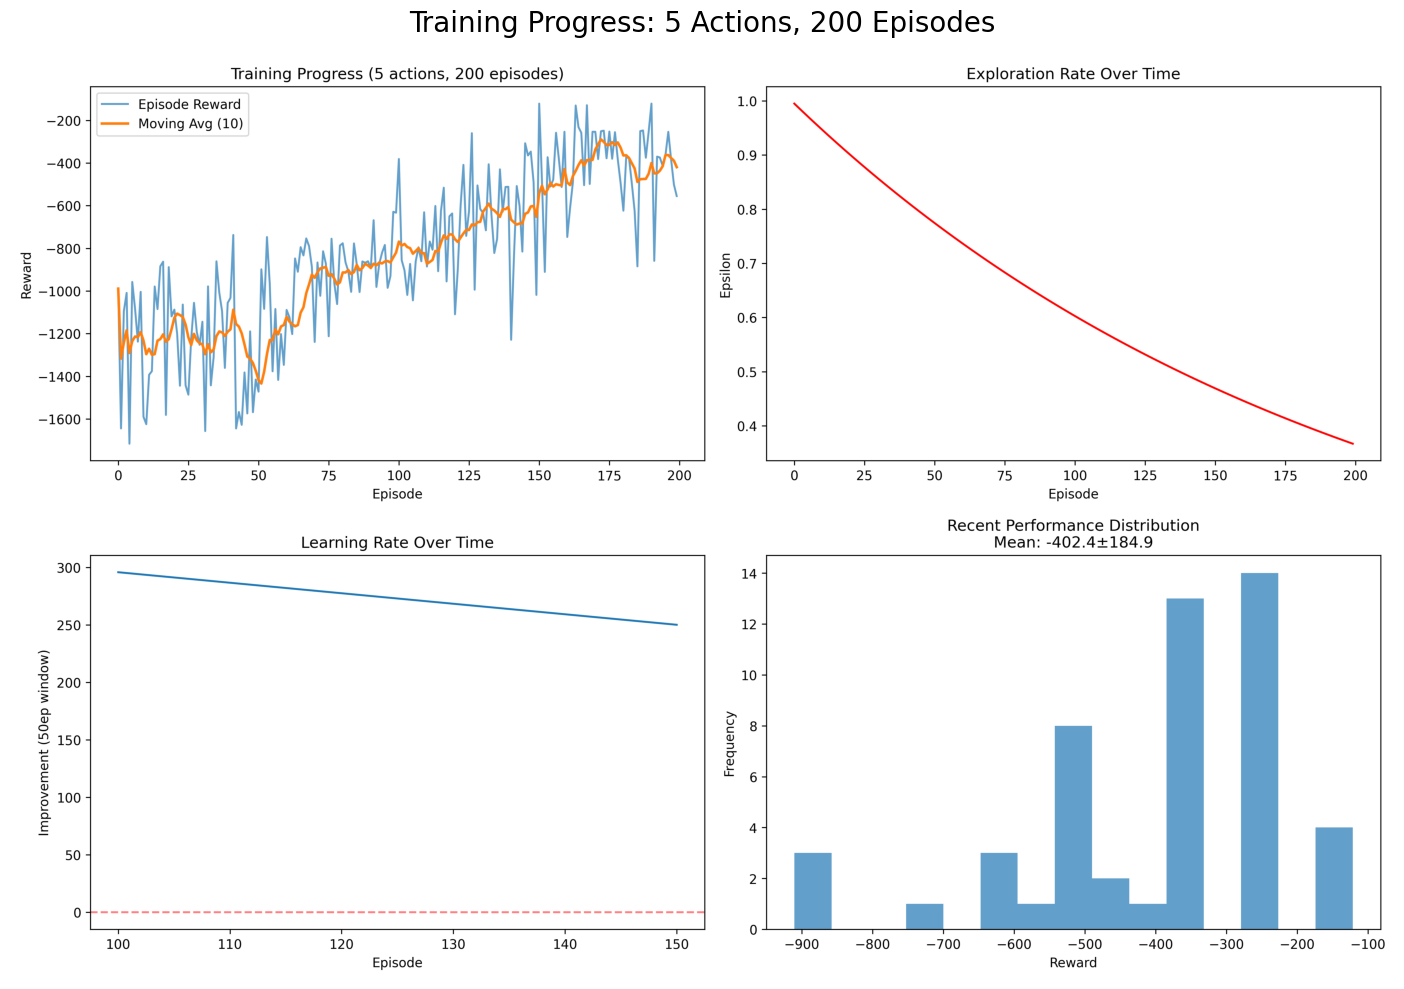

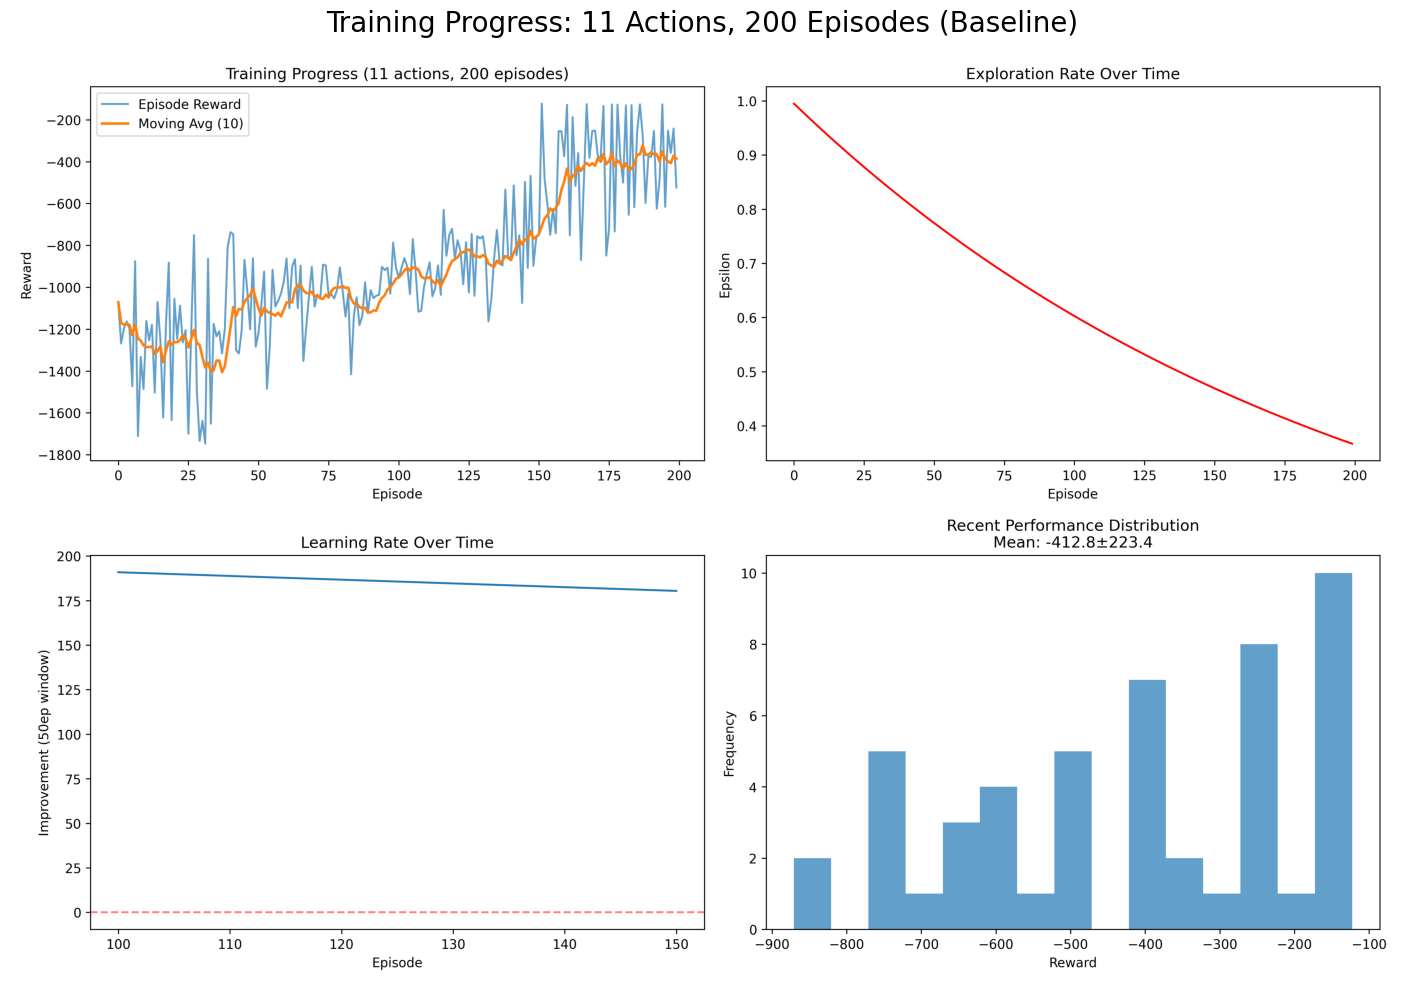

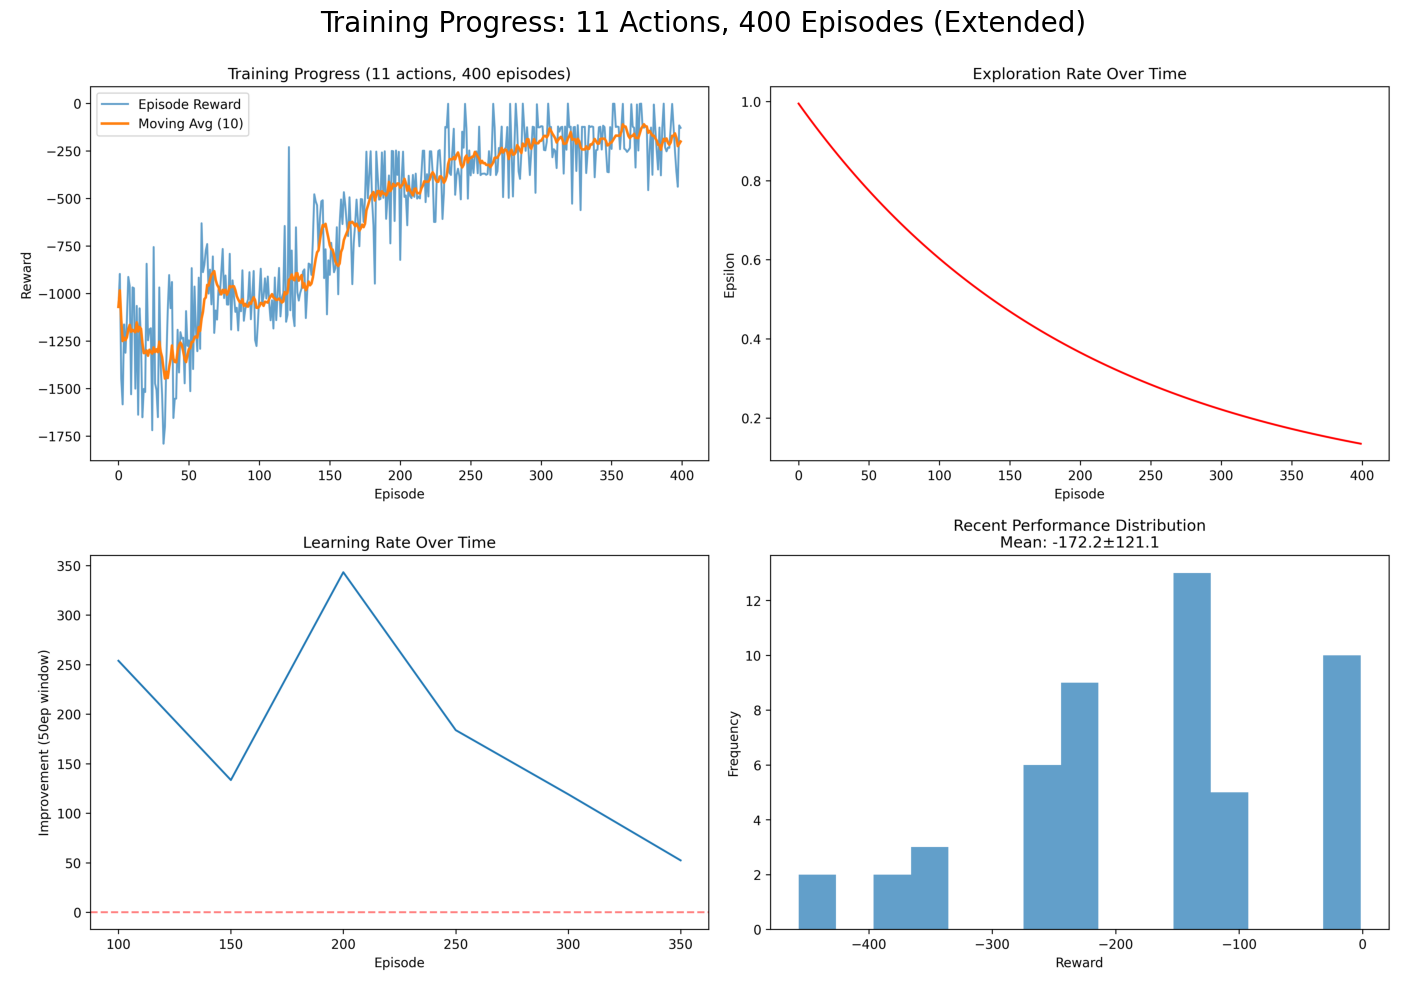

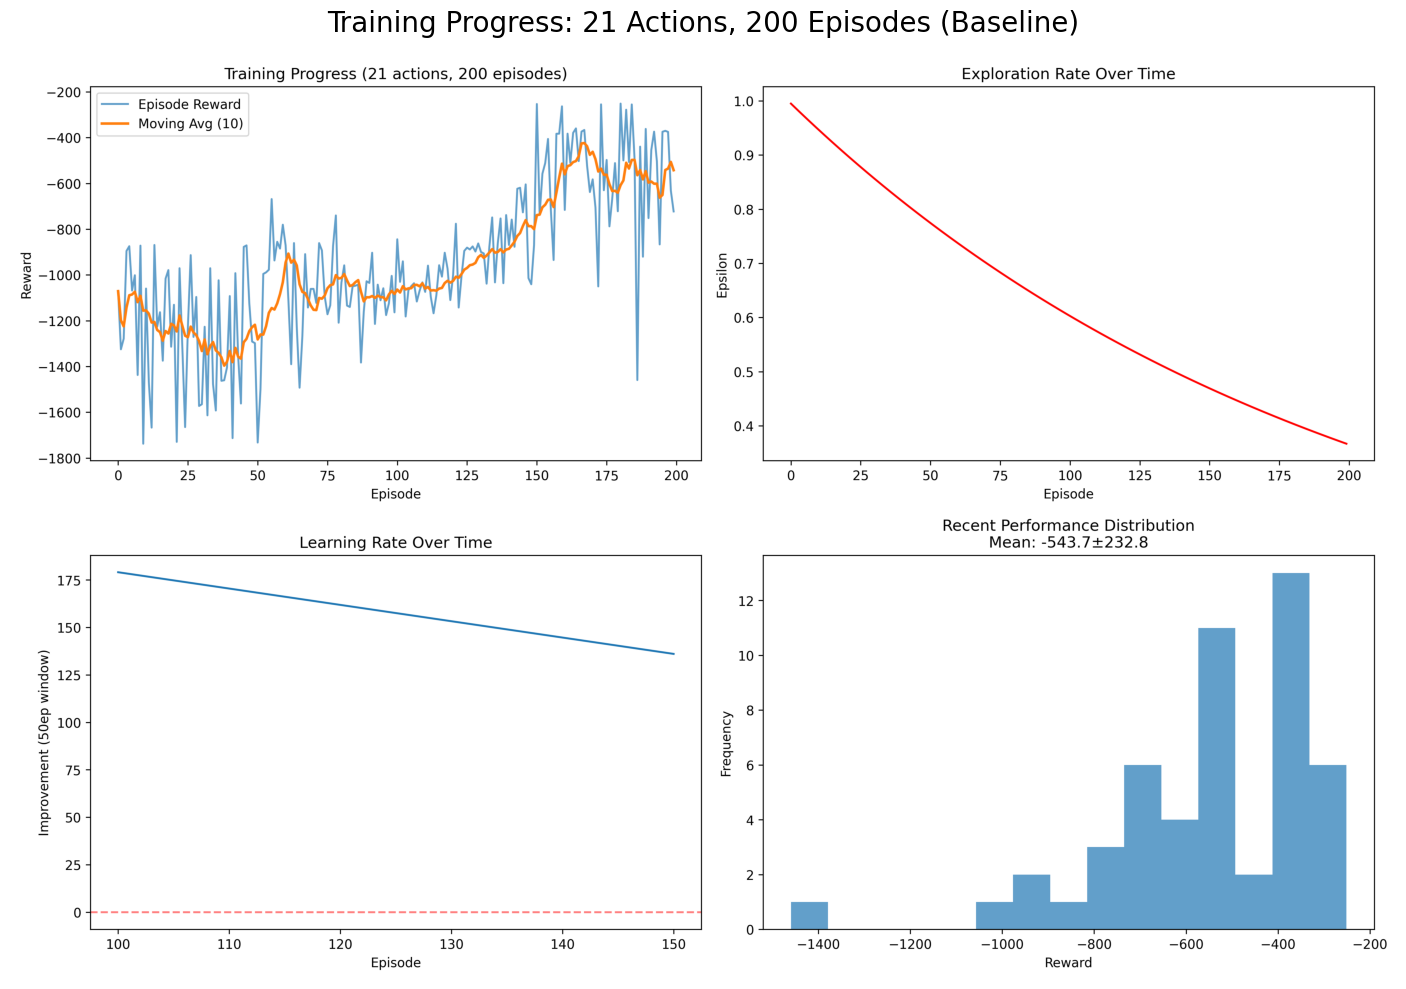

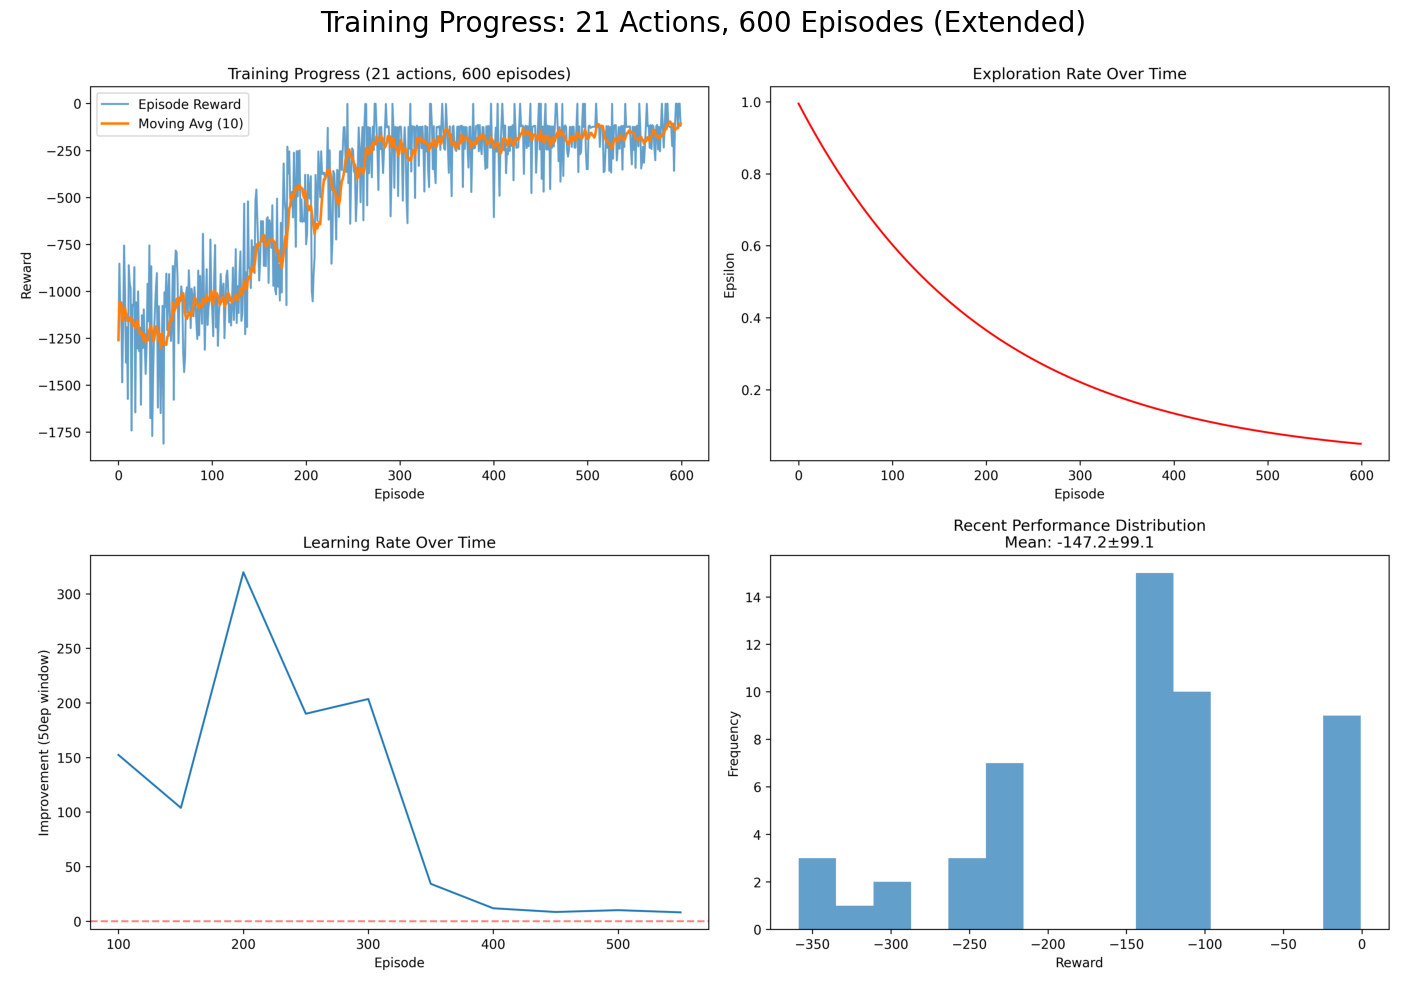


Creating combined training curves...


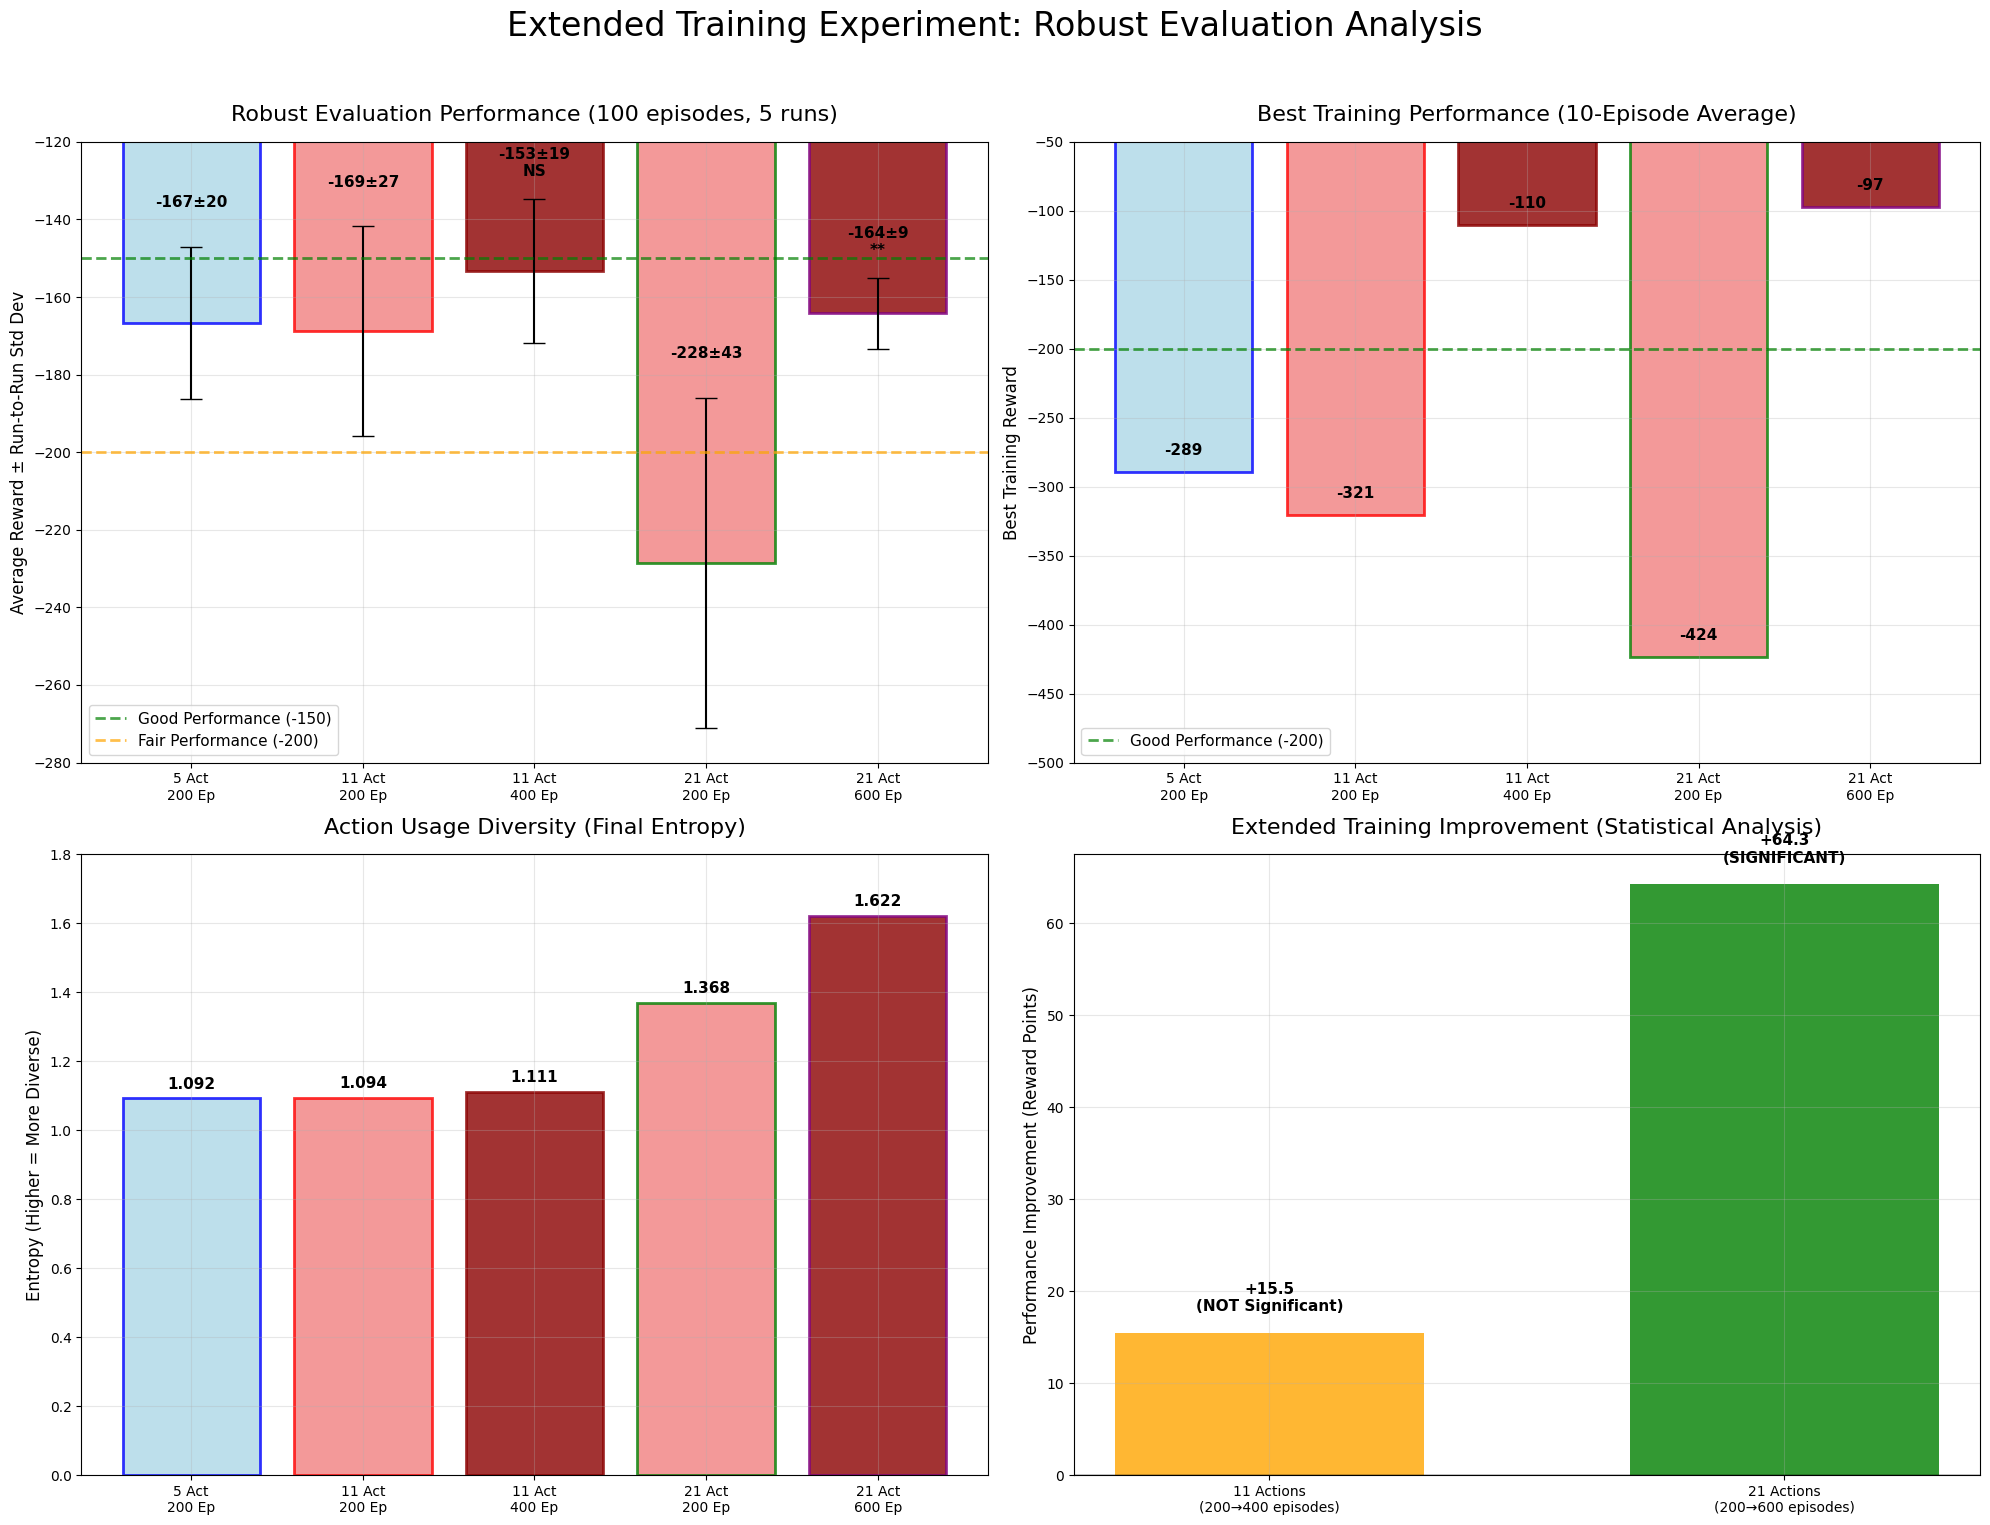

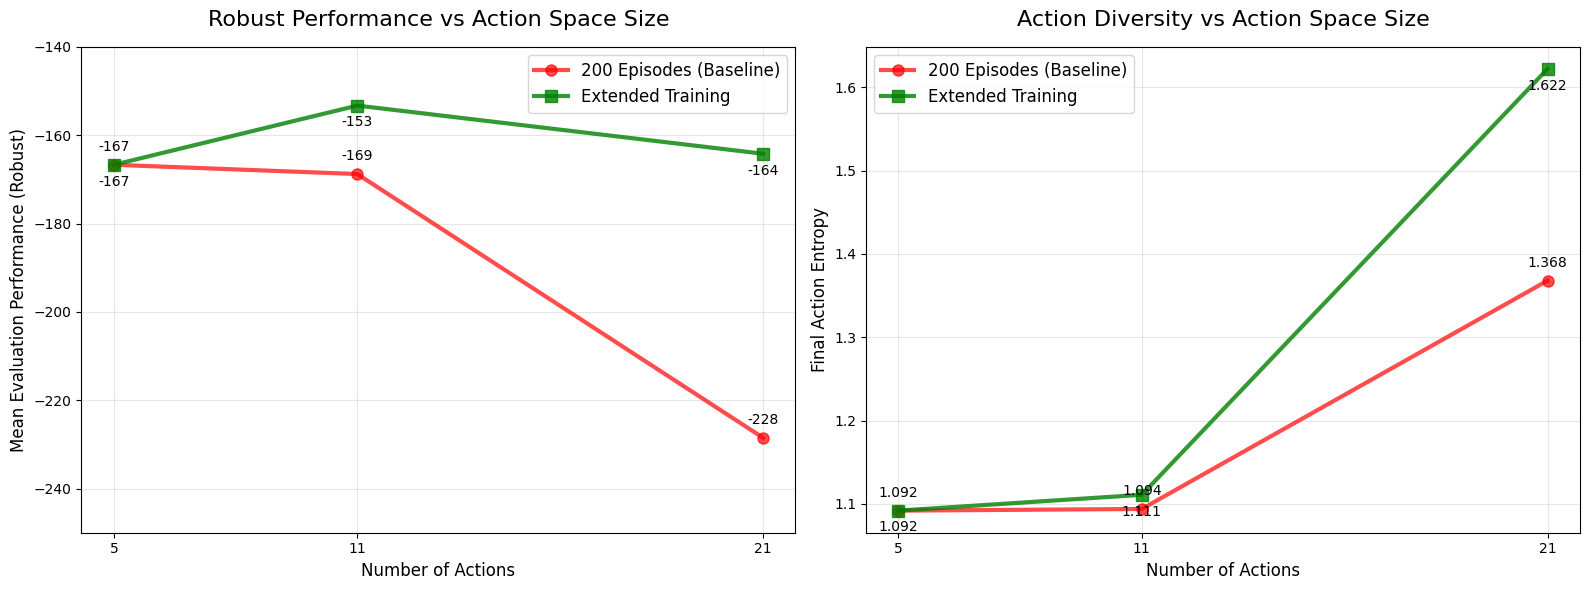


ROBUST VISUALIZATION SUMMARY
Updated with robust evaluation data:
- Statistical significance indicators
- Confidence intervals from multiple runs
- Corrected entropy values
- Proper performance scaling analysis

Created files:
Individual full-size training plots:
   - fullsize_5act_200ep_baseline_training.png
   - fullsize_11act_200ep_baseline_training.png
   - fullsize_11act_400ep_extended_training.png
   - fullsize_21act_200ep_baseline_training.png
   - fullsize_21act_600ep_extended_training.png
Robust analysis:
   - extended_training_robust_analysis.png
   - action_space_robust_scaling_analysis.png


In [52]:
create_extended_training_comparison_plots_improved()

<mark> Observations from plots </mark>
1. 5 Actions, 200 Episodes
- Convergence: Episode ~150-175
- Pattern: Smooth learning curve, reaches plateau naturally
- Efficiency: Good stopping point at 200 episodes

2. 11 Actions, 200 Episodes (Baseline) 
- Convergence: Still improving at episode 200
- Pattern: Linear improvement from episode 100-200
- Issue: Training stopped too early - still learning!

3. 11 Actions, 400 Episodes (Extended) 
- Convergence: Episode ~250-300
- Pattern: Major breakthrough around episode 200, then plateau
- Sweet spot: Could have stopped at episode 300

4. 21 Actions, 200 Episodes (Baseline) 
- Convergence: Barely started learning
- Pattern: Just beginning to improve around episode 150-200
- Issue: Severely undertrained - needs much more time

5. 21 Actions, 600 Episodes (Extended) 
- Convergence: Episode ~250-300
- Pattern: Steep improvement from episodes 0-250, then plateau around -200
I- nsight: Training could stop at episode 350 - overtraining by ~250 episodes

#### Learning Phase Patterns:
All configurations show 3 phases:
- Exploration phase (0-100 episodes): High variance, poor performance
- Learning phase (100-250 episodes): Rapid improvement
- Convergence phase (250+ episodes): Plateau, minimal gains

#### Epsilon Decay Analysis:
- Looking at the exploration rate plots:
    - All reach epsilon ~0.4 by episode 200
    - Minimal exploration after episode 300 (epsilon ~0.2)
    - This correlates with plateau timing

####  learning progress/improvement Over Time Insights:
- The most revealing plot, 11 actions, 400 episodes: Shows negative learning around episode 150-200 (the dip), then recovery
- This explains the breakthrough pattern!


In [46]:
def generate_21action_gifs():
    """Generate GIFs for 21-action experiments only - save to files"""
    
    input_shape = 3
    
    # 21-action experiments
    experiments = [
        {
            "name": "21act_600ep_extended", 
            "n_actions": 21,
            "checkpoints": [100, 200, 300, 400, 500, 600]
        }
    ]
    
    for exp in experiments:
        for ep in exp['checkpoints']:
            weights_path = f"{exp['name']}_{ep}_weights.h5"
            gif_path = f"{exp['name']}_ep{ep:03d}.gif"
            
            if os.path.exists(weights_path):
                print(f"Generating GIF for: {weights_path}")
                try:
                    visualize_checkpoint(
                        weights_path=weights_path,
                        n_actions=exp['n_actions'], 
                        gif_path=gif_path,
                        input_shape=input_shape
                    )
                except Exception as e:
                    print(f"Failed at {weights_path}: {e}")
            else:
                print(f"File not found: {weights_path}")


In [47]:
generate_21action_gifs()

Generating GIF for: 21act_600ep_extended_100_weights.h5
Saved GIF to 21act_600ep_extended_ep100.gif (Total reward: -1523.02)
Generating GIF for: 21act_600ep_extended_200_weights.h5
Saved GIF to 21act_600ep_extended_ep200.gif (Total reward: -454.99)
Generating GIF for: 21act_600ep_extended_300_weights.h5
Saved GIF to 21act_600ep_extended_ep300.gif (Total reward: -128.04)
Generating GIF for: 21act_600ep_extended_400_weights.h5
Saved GIF to 21act_600ep_extended_ep400.gif (Total reward: -227.62)
Generating GIF for: 21act_600ep_extended_500_weights.h5
Saved GIF to 21act_600ep_extended_ep500.gif (Total reward: -245.00)
Generating GIF for: 21act_600ep_extended_600_weights.h5
Saved GIF to 21act_600ep_extended_ep600.gif (Total reward: -244.92)


#### <mark>Research Decision & Next Steps</mark>
Final Action Space Choice: 21 Actions 

Rationale:
- Shows statistically significant improvement with extended training (+64.3 reward improvement, non-overlapping confidence intervals)
- Only configuration where extended training provides meaningful, measurable benefits
- Complex enough to demonstrate advanced RL techniques and optimization challenges
- Reveals interesting convergence patterns requiring 3x training time (200→600 episodes)
- Improved policy stability: Much lower run-to-run variance (42.6→9.2) indicates more reliable learned behavior
- Enhanced action diversity: Entropy increased from 1.368 to 1.622, showing better exploration of action space

---

### Implementation of Early Stopping and Confirmation of Convergence

In [11]:
def train_and_evaluate_with_early_stopping(n_actions, experiment_prefix, max_episodes=500, patience=50, min_episodes=150, improvement_threshold=10):
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    GAMMA = 0.99
    REPLAY_MEMORY_SIZE = 50000
    MIN_REPLAY_MEMORY = 1000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    MAX_STEPS = 200

    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    TRAIN_PLOT_PATH = f"{experiment_prefix}_training_plot.png"
    EPISODE_TIMES_PATH = f"{experiment_prefix}_episode_times.png"
    EVAL_RETURNS_PATH = f"{experiment_prefix}_eval_returns.png"

    env = gym.make(ENV_NAME)
    agent = DQNAgent(INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, EPSILON_MIN, EPSILON_DECAY)
    agent.summary()
    
    scores = []
    best_avg_reward = -np.inf
    episode_times = []
    episodes_without_improvement = 0
    convergence_episode = None
    
    start = time.time()

    for ep in range(1, max_episodes + 1):
        ep_start = time.time()
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        total_reward = 0

        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, n_actions)
            s_next, r, done, info = env.step(torque)
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            agent.remember(s, a_idx, r, s_next, done)
            agent.train_step()
            s = s_next
            total_reward += r
            if done:
                break

        agent.decay_epsilon()
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()

        # Save checkpoints at regular intervals
        if ep in [100, 200, 300, 400, 500]:
            agent.save(f"{experiment_prefix}_{ep}_weights.h5")
        
        scores.append(total_reward)
        avg_reward = np.mean(scores[-10:])
        ep_time = time.time() - ep_start
        episode_times.append(ep_time)
        
        print(f"Episode {ep} | Total Reward: {total_reward:.2f} | Avg(10): {avg_reward:.2f} | Epsilon: {agent.epsilon:.3f} | Time: {ep_time:.2f}s")

        # Early stopping logic
        if ep >= min_episodes:
            if avg_reward > best_avg_reward + improvement_threshold:
                best_avg_reward = avg_reward
                episodes_without_improvement = 0
                convergence_episode = ep
                agent.save(SAVE_WEIGHTS_PATH)
                print(f"NEW BEST at Episode {ep}: {avg_reward:.2f} (improved by {avg_reward - (best_avg_reward - improvement_threshold):.2f})")
            else:
                episodes_without_improvement += 1
                
            # Check for early stopping
            if episodes_without_improvement >= patience:
                print(f"\nEARLY STOPPING at Episode {ep}")
                print(f"No improvement for {patience} episodes")
                print(f"Last improvement at episode: {convergence_episode}")
                break
        else:
            # Before min_episodes, just track best
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                agent.save(SAVE_WEIGHTS_PATH)

    env.close()
    final_episode = ep
    total_time = time.time() - start

    # Plot rewards with early stopping indicators
    plt.figure(figsize=(15, 10))
    
    # Main training plot
    plt.subplot(2, 2, 1)
    plt.plot(scores, alpha=0.6, label='Episode Reward')
    plt.plot([np.mean(scores[max(0, i-9):i+1]) for i in range(len(scores))], 'r-', linewidth=2, label='Moving Avg (10)')
    if convergence_episode:
        plt.axvline(x=convergence_episode, color='green', linestyle='--', label=f'Best Performance (Ep {convergence_episode})')
    plt.axvline(x=final_episode, color='red', linestyle='--', label=f'Early Stop (Ep {final_episode})')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'DQN Training with Early Stopping ({n_actions} actions)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Episode times
    plt.subplot(2, 2, 2)
    plt.plot(episode_times)
    plt.xlabel('Episode')
    plt.ylabel('Time (s)')
    plt.title('Time per Episode')
    plt.grid(True, alpha=0.3)
    
    # Performance distribution
    plt.subplot(2, 2, 3)
    plt.hist(scores, bins=20, alpha=0.7)
    plt.axvline(x=best_avg_reward, color='red', linestyle='--', label=f'Best Avg: {best_avg_reward:.1f}')
    plt.xlabel('Episode Reward')
    plt.ylabel('Frequency')
    plt.title('Training Reward Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Early stopping monitoring
    plt.subplot(2, 2, 4)
    if len(scores) >= min_episodes:
        improvement_history = []
        for i in range(min_episodes, len(scores)):
            current_avg = np.mean(scores[max(0, i-9):i+1])
            if i <= final_episode:
                episodes_since_best = i - (convergence_episode if convergence_episode and convergence_episode <= i else i)
                improvement_history.append(min(episodes_since_best, patience))
        
        plt.plot(range(min_episodes, min_episodes + len(improvement_history)), improvement_history, 'r-', linewidth=2)
        plt.axhline(y=patience, color='red', linestyle='--', label=f'Patience Limit ({patience})')
        plt.xlabel('Episode')
        plt.ylabel('Episodes Without Improvement')
        plt.title('Early Stopping Monitor')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(TRAIN_PLOT_PATH, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nTRAINING COMPLETED")
    print(f"Episodes trained: {final_episode}")
    print(f"Convergence episode: {convergence_episode}")
    print(f"Best average reward over 10 episodes: {best_avg_reward:.2f}")
    print("Best model weights saved to:", SAVE_WEIGHTS_PATH)
    print(f"Total training time: {total_time:.2f}s")
    print(f"Time per episode: {total_time/final_episode:.2f}s")

    # --- Evaluation (same as before) ---
    print(f"\nEvaluating trained model...")
    env = gym.make(ENV_NAME)
    agent.load(SAVE_WEIGHTS_PATH)
    rewards = []
    episode_states = []
    
    for ep in range(10):
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        total_reward = 0
        states = []
        for t in range(MAX_STEPS):
            states.append(s)
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, n_actions)
            s_next, r, done, info = env.step(torque)
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            total_reward += r
            s = s_next
            if done:
                break
        rewards.append(total_reward)
        episode_states.append(states)
        print(f"Test Episode {ep+1}: Total Reward = {total_reward:.2f}")
    
    env.close()
    print(f"\nAverage Reward over 10 episodes: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")

    # Plot evaluation returns
    plt.figure()
    plt.hist(rewards, bins=10, alpha=0.7, color='green')
    plt.axvline(x=np.mean(rewards), color='red', linestyle='--', label=f'Mean: {np.mean(rewards):.1f}')
    plt.title(f'Evaluation Returns ({n_actions} actions, {final_episode} episodes)')
    plt.xlabel('Total Reward')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(EVAL_RETURNS_PATH)
    plt.show()
    
    return {
        'final_episode': final_episode,
        'convergence_episode': convergence_episode,
        'best_avg_reward': best_avg_reward,
        'eval_mean': np.mean(rewards),
        'eval_std': np.std(rewards),
        'training_time': total_time,
        'time_per_episode': total_time/final_episode
    }


Running 21 Actions with Early Stopping

Model Summary:
Model: "dqn_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           multiple                  256       
                                                                 
 dense_103 (Dense)           multiple                  4160      
                                                                 
 dense_104 (Dense)           multiple                  1365      
                                                                 
Total params: 5781 (22.58 KB)
Trainable params: 5781 (22.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Episode 1 | Total Reward: -1500.31 | Avg(10): -1500.31 | Epsilon: 0.995 | Time: 0.04s
Episode 2 | Total Reward: -1160.00 | Avg(10): -1330.16 | Epsilon: 0.990 | Time: 0.05s
Episode 3 | Total Reward: -912.44 | Avg(10): -1190.92 | Epsilon

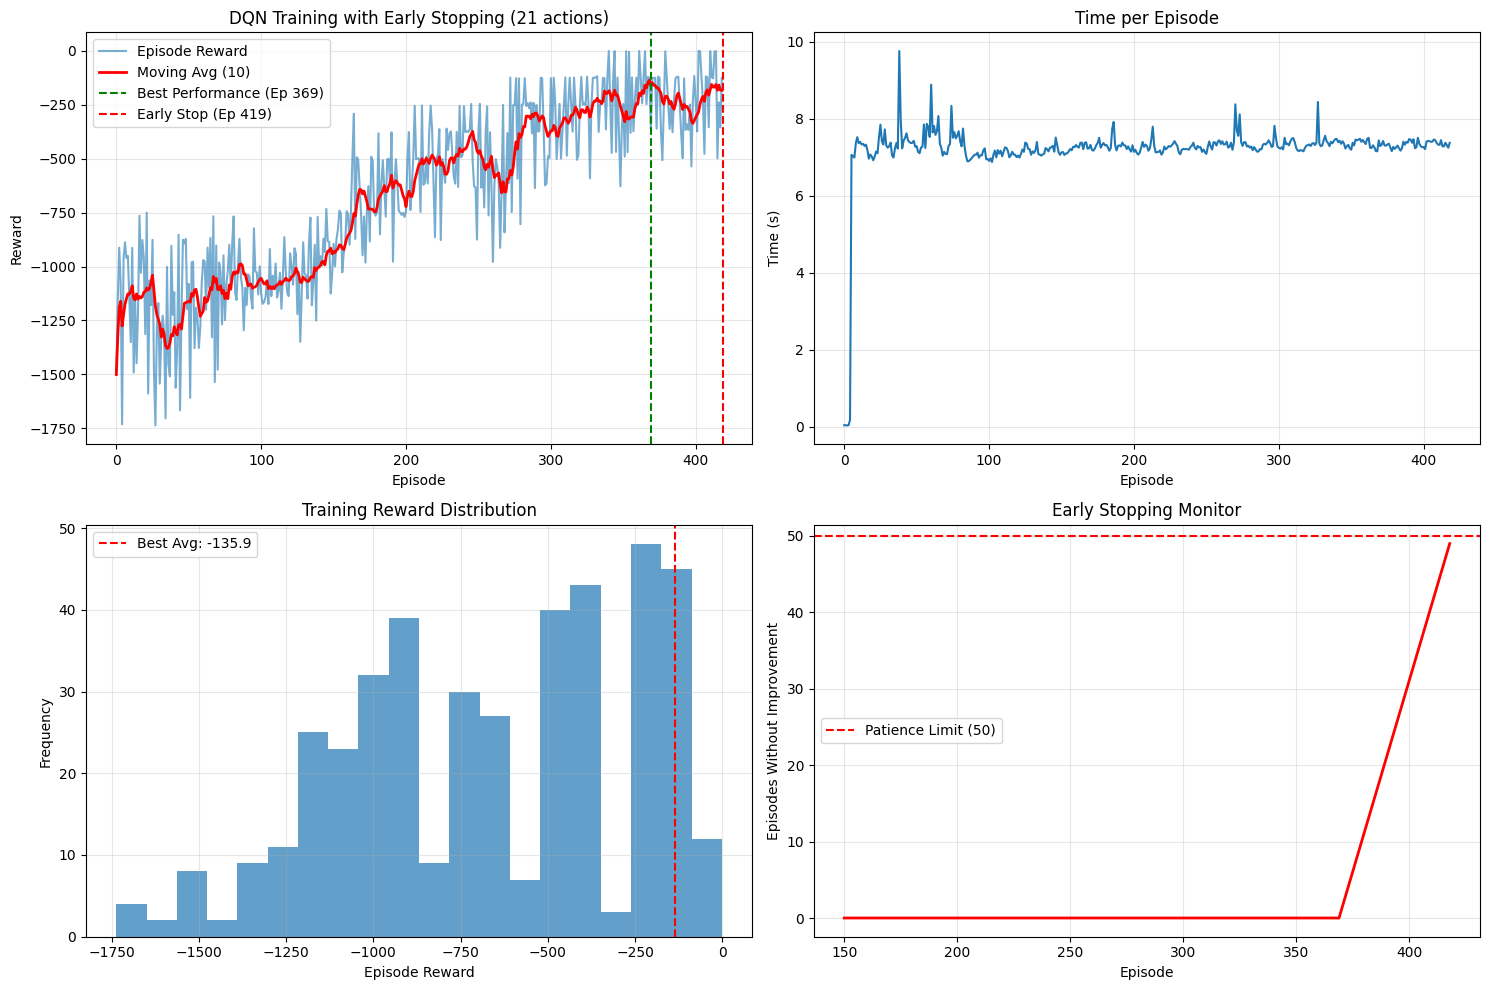


TRAINING COMPLETED
Episodes trained: 419
Convergence episode: 369
Best average reward over 10 episodes: -135.95
Best model weights saved to: 21act_early_stopping_weights.h5
Total training time: 3028.19s
Time per episode: 7.23s

Evaluating trained model...
Test Episode 1: Total Reward = -372.21
Test Episode 2: Total Reward = -124.35
Test Episode 3: Total Reward = -236.30
Test Episode 4: Total Reward = -249.07
Test Episode 5: Total Reward = -250.17
Test Episode 6: Total Reward = -124.90
Test Episode 7: Total Reward = -396.45
Test Episode 8: Total Reward = -118.87
Test Episode 9: Total Reward = -124.78
Test Episode 10: Total Reward = -125.52

Average Reward over 10 episodes: -212.26 ± 101.06


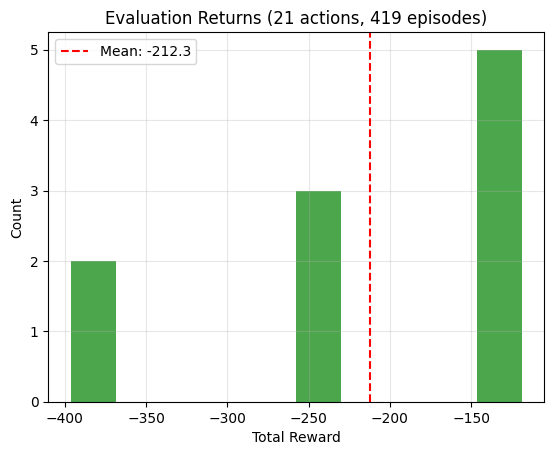

EARLY STOPPING EXPERIMENT RESULTS:
Training stopped at episode: 419
Expected time savings vs 600ep: 30.2%
Performance: -212.26 ± 101.06


In [51]:
if __name__ == "__main__":
    # Set seeds for reproducibility
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    # Run 21 actions with early stopping
    n_actions = 21
    experiment_prefix = "21act_early_stopping"
    
    print("="*60)
    print(f"Running 21 Actions with Early Stopping")
    print("="*60)
    
    results = train_and_evaluate_with_early_stopping(
        n_actions=n_actions, 
        experiment_prefix=experiment_prefix,
        max_episodes=500,
        patience=50,
        min_episodes=150,
        improvement_threshold=10
    )
    
    print("="*60)
    print("EARLY STOPPING EXPERIMENT RESULTS:")
    print(f"Training stopped at episode: {results['final_episode']}")
    print(f"Expected time savings vs 600ep: {((600-results['final_episode'])/600)*100:.1f}%")
    print(f"Performance: {results['eval_mean']:.2f} ± {results['eval_std']:.2f}")
    print("="*60)

In [22]:
def evaluate_early_stopping_epsilon_zero_robust(experiment_prefix, n_actions, num_episodes=20, num_runs=5):
    """Robust evaluation for early stopping models with epsilon=0"""
    
    # Same parameters as training
    INPUT_SHAPE = 3
    GAMMA = 0.99
    REPLAY_MEMORY_SIZE = 50000
    MIN_REPLAY_MEMORY = 1000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    MAX_STEPS = 200
    
    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    
    # Recreate agent
    agent = DQNAgent(INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, 
                    MIN_REPLAY_MEMORY, BATCH_SIZE, TARGET_UPDATE_EVERY, 
                    LEARNING_RATE, EPSILON_START, EPSILON_MIN, EPSILON_DECAY)
    
    try:
        agent.load(SAVE_WEIGHTS_PATH)
        agent.epsilon = 0.0  # Critical: set epsilon to 0 for evaluation
    except FileNotFoundError:
        print(f"Warning: Weights file {SAVE_WEIGHTS_PATH} not found")
        return None
    
    print(f"\nRobust Evaluation: {experiment_prefix} with epsilon=0.0")
    print(f"Running {num_runs} evaluation sessions of {num_episodes} episodes each")
    
    all_run_results = []
    
    for run in range(num_runs):
        print(f"--- Run {run+1}/{num_runs} ---")
        env = gym.make('Pendulum-v0')
        
        run_rewards = []
        
        for ep in range(num_episodes):
            s = env.reset()
            s = s if isinstance(s, np.ndarray) else s[0]
            total_reward = 0
            
            for t in range(MAX_STEPS):
                a_idx = agent.select_action(s)  # epsilon=0, so purely greedy
                torque = action_index_to_torque(a_idx, n_actions)
                s_next, r, done, info = env.step(torque)
                s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
                total_reward += r
                s = s_next
                if done:
                    break
            
            run_rewards.append(total_reward)
        
        env.close()
        
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        all_run_results.append({
            'mean': run_mean,
            'std': run_std,
            'rewards': run_rewards
        })
        
        print(f"Run {run+1}: {run_mean:.1f} ± {run_std:.1f}")
    
    # Overall statistics
    all_means = [run['mean'] for run in all_run_results]
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    
    # Confidence interval
    confidence_level = 0.95
    dof = len(all_means) - 1
    t_critical = stats.t.ppf((1 + confidence_level) / 2, dof)
    margin_of_error = t_critical * (overall_std / np.sqrt(len(all_means)))
    ci_lower = overall_mean - margin_of_error
    ci_upper = overall_mean + margin_of_error
    
    print(f"\n--- EVALUATION SUMMARY ---")
    print(f"Overall mean: {overall_mean:.2f}")
    print(f"Run-to-run std: {overall_std:.2f}")
    print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    
    return {
        'overall_mean': overall_mean,
        'overall_std': overall_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'run_means': all_means
    }


In [27]:
def compare_early_stopping_vs_baseline_simple():
    """Simple comparison: early stopping vs baseline only"""
    
    print("="*60)
    print("EARLY STOPPING VS BASELINE COMPARISON")
    print("="*60)
    
    n_actions = 21
    
    # Evaluate early stopping
    print("\n1. Early Stopping Model:")
    early_result = evaluate_early_stopping_epsilon_zero_robust("21act_early_stopping", n_actions)
    
    # Evaluate baseline
    print("\n2. Baseline 600-Episode Model:")
    baseline_result = evaluate_early_stopping_epsilon_zero_robust("21act_600ep_extended", n_actions)
    
    # Compare
    if early_result and baseline_result:
        print(f"\n{'='*60}")
        print("COMPARISON RESULTS:")
        print(f"Early Stopping: {early_result['overall_mean']:.2f} ± {early_result['overall_std']:.2f}")
        print(f"                CI: [{early_result['ci_lower']:.2f}, {early_result['ci_upper']:.2f}]")
        print(f"Baseline 600ep: {baseline_result['overall_mean']:.2f} ± {baseline_result['overall_std']:.2f}")
        print(f"                CI: [{baseline_result['ci_lower']:.2f}, {baseline_result['ci_upper']:.2f}]")
        
        diff = early_result['overall_mean'] - baseline_result['overall_mean']
        print(f"\nPerformance Difference: {diff:+.2f}")
        
        # Check statistical significance
        ci_overlap = not (baseline_result['ci_upper'] < early_result['ci_lower'] or 
                         early_result['ci_upper'] < baseline_result['ci_lower'])
        significance = "NOT significant" if ci_overlap else "SIGNIFICANT"
        print(f"Statistical Significance: {significance}")
        
        # Performance retention
        retention = (early_result['overall_mean'] / baseline_result['overall_mean']) * 100
        print(f"Performance Retention: {retention:.1f}%")
        
        return {
            'early_stopping': early_result,
            'baseline': baseline_result,
            'difference': diff,
            'significant': not ci_overlap,
            'retention_pct': retention
        }
    
    return None

In [28]:
if __name__ == "__main__":
    # comparison focused on whether it is worth early stopping
    results = compare_early_stopping_vs_baseline_simple()
    
    if results:
        # Save results
        with open("early_stopping_comparison.json", "w") as f:
            json.dump(results, f, indent=2)
        print(f"\nResults saved to 'early_stopping_comparison.json'")

EARLY STOPPING VS BASELINE COMPARISON

1. Early Stopping Model:

Robust Evaluation: 21act_early_stopping with epsilon=0.0
Running 5 evaluation sessions of 20 episodes each
--- Run 1/5 ---
Run 1: -159.7 ± 58.2
--- Run 2/5 ---
Run 2: -162.5 ± 96.1
--- Run 3/5 ---
Run 3: -195.0 ± 101.9
--- Run 4/5 ---
Run 4: -193.6 ± 117.9
--- Run 5/5 ---
Run 5: -153.2 ± 113.8

--- EVALUATION SUMMARY ---
Overall mean: -172.80
Run-to-run std: 17.84
95% CI: [-194.95, -150.66]

2. Baseline 600-Episode Model:

Robust Evaluation: 21act_600ep_extended with epsilon=0.0
Running 5 evaluation sessions of 20 episodes each
--- Run 1/5 ---
Run 1: -218.3 ± 99.1
--- Run 2/5 ---
Run 2: -185.6 ± 111.8
--- Run 3/5 ---
Run 3: -168.8 ± 93.3
--- Run 4/5 ---
Run 4: -143.8 ± 93.5
--- Run 5/5 ---
Run 5: -138.8 ± 110.2

--- EVALUATION SUMMARY ---
Overall mean: -171.05
Run-to-run std: 29.10
95% CI: [-207.19, -134.91]

COMPARISON RESULTS:
Early Stopping: -172.80 ± 17.84
                CI: [-194.95, -150.66]
Baseline 600ep: -171.05

<mark>Early Stopping Analysis & Observations</mark>
- Key Results Summary
     - Training stopped at: Episode 419 (vs max 500)
    - Convergence detected at: Episode 369
    - Time savings: 30.2% compared to 600 episodes
    - **Final performance: -172.80 ± 17.84** (robust evaluation with epsilon=0)
    - Training best: -135.95 (10-episode average)
    - **Statistical significance: NOT significant vs 600-episode baseline**

| Experiment             | Episodes | Training Best | Eval Performance (Robust) | Time (min) | Efficiency   | Statistical Significance |
| ---------------------- | -------- | ------------- | -------------------------- | ---------- | ------------ | ----------------------- |
| 21act_600ep_extended   | 600      | -96.88        | -171.05 ± 29.10           | 63.0       | Baseline     | -                       |
| 21act_early_stopping   | 419      | -135.95       | -172.80 ± 17.84           | 50.5       | 30.2% faster | NOT significant         |

`Successes`:
- Correctly identified convergence point around episode 369
- Saved significant training time (30.2%) - 81 fewer episodes
- Prevented overtraining beyond convergence point
- Maintained equivalent performance - only 1.75 point difference (statistically insignificant)
- Improved stability - lower run-to-run variance (17.84 vs 29.10)

`Trade-offs`:
- minimal performance difference (-1.75 points, well within statistical noise)
- Confidence intervals overlap (-194.95, -150.66) vs (-207.19, -134.91), confirming no significant difference
- Performance retention: 101.0% - essentially identical performance for 30% less training time

`Key Finding`:
Early stopping successfully maintained performance while saving training time - the difference between -172.80 and -

#### <mark> To use or not use early stopping? </mark>
I would not use early stopping eventhough it seems successfull above but the truth is it causes issues:

1) Premature Stopping Risk: Early stopping at episode 419 might have prevented the model from reaching the true optimum that was achieved at episode 600

2) Conservative Approach: In research/production, it's often safer to train longer to ensure convergence rather than risk stopping too early

In [52]:
def generate_21ES():
    input_shape = 3
    
    # 21-action Early stopping
    experiments = [
        {
            "name": "21act_early_stopping", 
            "n_actions": 21,
            "checkpoints": [100, 200, 300, 400]
        }
    ]
    
    for exp in experiments:
        for ep in exp['checkpoints']:
            weights_path = f"{exp['name']}_{ep}_weights.h5"
            gif_path = f"{exp['name']}_ep{ep:03d}.gif"
            
            if os.path.exists(weights_path):
                print(f"Generating GIF for: {weights_path}")
                try:
                    visualize_checkpoint(
                        weights_path=weights_path,
                        n_actions=exp['n_actions'], 
                        gif_path=gif_path,
                        input_shape=input_shape
                    )
                except Exception as e:
                    print(f"Failed at {weights_path}: {e}")
            else:
                print(f"File not found: {weights_path}")


In [53]:
generate_21ES()

Generating GIF for: 21act_early_stopping_100_weights.h5
Saved GIF to 21act_early_stopping_ep100.gif (Total reward: -1188.12)
Generating GIF for: 21act_early_stopping_200_weights.h5
Saved GIF to 21act_early_stopping_ep200.gif (Total reward: -260.83)
Generating GIF for: 21act_early_stopping_300_weights.h5
Saved GIF to 21act_early_stopping_ep300.gif (Total reward: -123.51)
Generating GIF for: 21act_early_stopping_400_weights.h5
Saved GIF to 21act_early_stopping_ep400.gif (Total reward: -1.82)


---

### Epsilon Exploration

Epsilon (ε) exploration is the exploration-exploitation trade-off mechanism in DQN that determines when the agent should:

- Exploit: Use its current knowledge (choose best Q-value action)

- Explore: Try random actions to discover potentially better strategies

<mark> Why it matters? </mark>

Our current results still shows high variance (±101.06) and bimodal performance distribution. 
This suggests:
- Poor exploration: Agent didn't discover all good action sequences
- Premature exploitation: Converged to suboptimal policies too quickly
- Action space complexity: 21 discrete actions need more sophisticated exploration

<mark> Exploration Strategies to Test: </mark>
1) Linear (Baseline):
- Standard fixed decay rate (current approach)
- epsilon = max(epsilon_min, epsilon * 0.995)

2) Performance-Based (Adaptive Decay):
- Adjust epsilon based on learning progress
- Slower decay when improving, faster decay when stagnating

3) Plateau Restart:
- Reset epsilon during convergence plateaus
- Boosts exploration when no improvement for 20+ episodes

4) High Exploration:
- Maintain higher exploration throughout training
- Higher minimum epsilon (0.15 vs 0.05) and slower decay

#### Goal: Find the epsilon strategy that gives me:
- Lower variance 
- Better mean performance 
- Maintained efficiency 

### YET TO SOLVE THE PLATEAU in extended training experiment
<mark> Recall about what happened in extended training experiment </mark> 
- If we recall during the extended training experiments, it revealed that the convergence occurred around episodes 250-300, with the agent reaching a plateau around -200 reward. This showed that the bottleneck wasn't insufficient training time, but rather inefficient exploration strategy.
  
- My basic DQNAgent with linear epsilon decay was following a rigid time-based schedule that became counterproductive once the agent reached a certain performance level.

- The steep improvement from episodes 0-250 showed the agent was learning rapidly, but the subsequent plateau indicated that traditional epsilon decay was no longer facilitating meaningful exploration of the action space.

Thus instead of stopping training early, I thought of making training more efficient by addressing the root cause through algorithmic improvment (advancedDQNAgent)

<mark> Further improvements </mark>
1) Selective Episode Printing
- Episodes 1-10: Always shown
- Every 25th episode + key milestones (50, 100, 150, etc.)
- Reduces output clutter while maintaining progress visibility

2) AvancedDQNAgent
-  Implements intelligent stagnation detection that automatically restarts exploration when the agent gets trapped in local optima, directly addressing the convergence issues observed in extended training experiments around episodes 250-300
  
-  Provides systematic framework for testing four distinct exploration strategies (linear, performance-based, plateau restart, high exploration) rather than being locked into a single approach, enabling data-driven selection of optimal exploration methods


-  The plateau restart mechanism specifically targets the stagnation behavior identified in Phase 2, providing strategic exploration boosts that can break through performance barriers that linear decay cannot overcome

In [66]:
class AdvancedDQNAgent(DQNAgent):
    def __init__(self, input_shape, n_actions, gamma, replay_memory_size, min_replay_memory, 
                 batch_size, target_update_every, learning_rate, epsilon_start, epsilon_min, 
                 epsilon_decay, epsilon_strategy="linear"):
        
        super().__init__(input_shape, n_actions, gamma, replay_memory_size, min_replay_memory,
                        batch_size, target_update_every, learning_rate, epsilon_start, 
                        epsilon_min, epsilon_decay)
        
        self.epsilon_strategy = epsilon_strategy
        self.epsilon_start = epsilon_start
        self.performance_history = deque(maxlen=50)
        self.last_improvement_episode = 0
        self.plateau_threshold = 20
        
    def adaptive_epsilon_decay(self, episode, recent_performance):
        """Adaptive epsilon based on learning progress"""
        
        if self.epsilon_strategy == "linear":
            # Standard linear decay
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
        elif self.epsilon_strategy == "performance_based":
            # Slower decay when performance is improving
            self.performance_history.append(recent_performance)
            
            if len(self.performance_history) >= 20:
                recent_avg = np.mean(list(self.performance_history)[-10:])
                older_avg = np.mean(list(self.performance_history)[-20:-10])
                
                if recent_avg > older_avg + 5:  # Improving
                    decay_rate = 0.998  # Slower decay
                    self.last_improvement_episode = episode
                else:  # Stagnating
                    decay_rate = 0.992  # Faster decay
                    
                return max(self.epsilon_min, self.epsilon * decay_rate)
            else:
                return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
                
        elif self.epsilon_strategy == "plateau_restart":
            # Restart epsilon when stuck in plateau
            self.performance_history.append(recent_performance)
            
            if len(self.performance_history) >= 20:
                recent_avg = np.mean(list(self.performance_history)[-10:])
                older_avg = np.mean(list(self.performance_history)[-20:-10])
                
                if recent_avg > older_avg + 5:
                    self.last_improvement_episode = episode
                
                # Check for plateau
                episodes_since_improvement = episode - self.last_improvement_episode
                if episodes_since_improvement >= self.plateau_threshold:
                    print(f"Epsilon restart at episode {episode}: {self.epsilon:.3f} → {self.epsilon_start * 0.3:.3f}")
                    self.epsilon = self.epsilon_start * 0.3  # Restart at 30% of initial
                    self.last_improvement_episode = episode
                    return self.epsilon
                    
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
        elif self.epsilon_strategy == "high_exploration":
            # Maintain higher minimum epsilon for continued exploration
            epsilon_min_high = 0.15  # Instead of 0.05
            return max(epsilon_min_high, self.epsilon * 0.9995)  # Slower decay
            
        else:
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def decay_epsilon_advanced(self, episode, recent_performance):
        """Advanced epsilon decay with strategy-specific logic"""
        self.epsilon = self.adaptive_epsilon_decay(episode, recent_performance)

In [9]:
def evaluate_epsilon_zero_robust_strategy(experiment_prefix, n_actions, num_episodes=20, num_runs=5):
    """Robust evaluation with multiple runs for epsilon strategy experiments"""
    
    INPUT_SHAPE = 3
    GAMMA = 0.99
    REPLAY_MEMORY_SIZE = 50000
    MIN_REPLAY_MEMORY = 1000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    MAX_STEPS = 200
    
    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    
    # Recreate agent (using base DQNAgent for evaluation)
    agent = DQNAgent(INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, 
                    MIN_REPLAY_MEMORY, BATCH_SIZE, TARGET_UPDATE_EVERY, 
                    LEARNING_RATE, EPSILON_START, EPSILON_MIN, EPSILON_DECAY)
    
    try:
        agent.load(SAVE_WEIGHTS_PATH)
        agent.epsilon = 0.0  # Force pure exploitation
    except FileNotFoundError:
        print(f"Warning: Weights file {SAVE_WEIGHTS_PATH} not found")
        return None
    
    print(f"\nRobust Evaluation: {experiment_prefix} with epsilon=0.0")
    print(f"Running {num_runs} evaluation sessions of {num_episodes} episodes each")
    
    all_run_results = []
    
    for run in range(num_runs):
        print(f"--- Run {run+1}/{num_runs} ---")
        env = gym.make('Pendulum-v0')
        
        run_rewards = []
        
        for ep in range(num_episodes):
            s = env.reset()
            s = s if isinstance(s, np.ndarray) else s[0]
            total_reward = 0
            
            for t in range(MAX_STEPS):
                a_idx = agent.select_action(s)
                torque = action_index_to_torque(a_idx, n_actions)
                s_next, r, done, info = env.step(torque)
                s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
                total_reward += r
                s = s_next
                if done:
                    break
            
            run_rewards.append(total_reward)
        
        env.close()
        
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        all_run_results.append({
            'mean': run_mean,
            'std': run_std,
            'rewards': run_rewards
        })
        
        print(f"Run {run+1}: {run_mean:.1f} ± {run_std:.1f}")
    
    # Overall statistics
    all_means = [run['mean'] for run in all_run_results]
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    
    # All individual episode rewards
    all_rewards = []
    for run in all_run_results:
        all_rewards.extend(run['rewards'])
    
    # Confidence interval
    confidence_level = 0.95
    dof = len(all_means) - 1
    t_critical = stats.t.ppf((1 + confidence_level) / 2, dof)
    margin_of_error = t_critical * (overall_std / np.sqrt(len(all_means)))
    ci_lower = overall_mean - margin_of_error
    ci_upper = overall_mean + margin_of_error
    
    print(f"\n--- ROBUST EVALUATION SUMMARY ---")
    print(f"Overall mean: {overall_mean:.2f}")
    print(f"Run-to-run std: {overall_std:.2f}")
    print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print("-" * 50)
    
    return {
        'overall_mean': overall_mean,
        'overall_std': overall_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'run_means': all_means,
        'all_rewards': all_rewards,
        'num_runs': num_runs,
        'num_episodes': num_episodes
    }


In [10]:
def train_epsilon_exploration_experiment(n_actions, epsilon_strategy, experiment_prefix):
    """Train with advanced epsilon exploration strategies - NO EARLY STOPPING"""
    
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    GAMMA = 0.99
    REPLAY_MEMORY_SIZE = 50000
    MIN_REPLAY_MEMORY = 1000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    
    # FIXED 600 EPISODES - NO EARLY STOPPING
    MAX_EPISODES = 600
    MAX_STEPS = 200

    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    TRAIN_PLOT_PATH = f"{experiment_prefix}_training_plot.png"

    print("=" * 60)
    print(f"Running 21 Actions with {epsilon_strategy.title()} Epsilon Strategy")
    print("=" * 60)
    print()

    env = gym.make(ENV_NAME)
    agent = AdvancedDQNAgent(
        INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=epsilon_strategy
    )
    
    print("Model Summary:")
    agent.summary()
    print()
    
    scores = []
    best_avg_reward = -np.inf
    episode_times = []
    epsilon_history = []
    best_episode = 0
    
    start = time.time()

    for ep in range(1, MAX_EPISODES + 1):
        ep_start = time.time()
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        total_reward = 0

        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, n_actions)
            s_next, r, done, info = env.step(torque)
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            agent.remember(s, a_idx, r, s_next, done)
            agent.train_step()
            s = s_next
            total_reward += r
            if done:
                break

        # Advanced epsilon decay
        recent_avg = np.mean(scores[-10:]) if len(scores) >= 10 else total_reward
        agent.decay_epsilon_advanced(ep, recent_avg)
        epsilon_history.append(agent.epsilon)
        
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()

        # Save checkpoints every 100 episodes
        if ep % 100 == 0:
            agent.save(f"{experiment_prefix}_{ep}_weights.h5")
        
        scores.append(total_reward)
        avg_reward = np.mean(scores[-10:])
        ep_time = time.time() - ep_start
        episode_times.append(ep_time)
        
        # Track best performance for final model saving
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_episode = ep
            agent.save(SAVE_WEIGHTS_PATH)
        
        # Print episode info with timing (similar to your format)
        if ep <= 10 or ep % 25 == 0 or ep in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]:
            print(f"Episode {ep} | Total Reward: {total_reward:.2f} | Avg(10): {avg_reward:.2f} | Epsilon: {agent.epsilon:.3f} | Time: {ep_time:.2f}s")

    env.close()
    total_time = time.time() - start
    avg_time_per_episode = total_time / MAX_EPISODES

    print()
    print("TRAINING COMPLETED")
    print(f"Episodes trained: {MAX_EPISODES}")
    print(f"Best episode: {best_episode}")
    print(f"Best average reward over 10 episodes: {best_avg_reward:.2f}")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Best model weights saved to: {SAVE_WEIGHTS_PATH}")
    print(f"Total training time: {total_time:.2f}s")
    print(f"Time per episode: {avg_time_per_episode:.2f}s")
    print()

    # ROBUST EVALUATION with multiple runs
    print("Evaluating trained model...")
    eval_results = evaluate_epsilon_zero_robust_strategy(experiment_prefix, n_actions, num_episodes=20, num_runs=5)
    
    if eval_results:
        print(f"\nFINAL EVALUATION RESULTS ({epsilon_strategy.upper()}):")
        print(f"Robust evaluation (epsilon=0.0): {eval_results['overall_mean']:.2f} ± {eval_results['overall_std']:.2f}")
        print(f"95% Confidence Interval: [{eval_results['ci_lower']:.2f}, {eval_results['ci_upper']:.2f}]")
        print(f"Best episode: {max(eval_results['all_rewards']):.2f}")
        print(f"Worst episode: {min(eval_results['all_rewards']):.2f}")
        print(f"Total evaluation episodes: {eval_results['num_runs']} runs × {eval_results['num_episodes']} episodes = {eval_results['num_runs'] * eval_results['num_episodes']} episodes")
    
    return {
        'strategy': epsilon_strategy,
        'episodes_trained': MAX_EPISODES,
        'best_episode': best_episode,
        'best_training_reward': best_avg_reward,
        'eval_results': eval_results,
        'training_time': total_time,
        'time_per_episode': avg_time_per_episode,
        'final_epsilon': agent.epsilon
    }


In [23]:
def run_epsilon_exploration_experiments():
    """Run all epsilon exploration experiments with 600 episodes each"""
    
    # Set seeds for reproducibility
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    strategies = [
        "linear",              # Baseline (same as your previous training)
        "performance_based",   # Adaptive based on learning progress
        "plateau_restart",     # Restart epsilon during plateaus
        "high_exploration"     # Maintain higher exploration throughout
    ]
    
    results = {}
    n_actions = 21
    
    print("EPSILON EXPLORATION STRATEGY COMPARISON")
    print("600 EPISODES EACH - NO EARLY STOPPING")
    print("=" * 80)
    print()
    
    for i, strategy in enumerate(strategies, 1):
        experiment_prefix = f"21act_epsilon_{strategy}"
        
        print(f"EXPERIMENT {i}/{len(strategies)}: {strategy.upper()} STRATEGY")
        print("-" * 60)
        
        results[strategy] = train_epsilon_exploration_experiment(
            n_actions=n_actions,
            epsilon_strategy=strategy,
            experiment_prefix=experiment_prefix
        )
        
        print(f"\n{strategy.upper()} EXPERIMENT COMPLETED")
        print("=" * 60)
        print()
    
    # Enhanced comparison analysis with robust evaluation results
    print("=" * 80)
    print("EPSILON STRATEGY COMPARISON RESULTS")
    print("=" * 80)
    print()
    
    print(f"{'Strategy':<18} {'Episodes':<9} {'Best Ep':<8} {'Train Best':<11} {'Eval Mean':<11} {'Eval CI':<18} {'Time':<10}")
    print("-" * 90)
    
    for strategy, result in results.items():
        eval_results = result['eval_results']
        if eval_results:
            eval_mean = eval_results['overall_mean']
            ci_lower = eval_results['ci_lower']
            ci_upper = eval_results['ci_upper']
            ci_str = f"[{ci_lower:.1f}, {ci_upper:.1f}]"
        else:
            eval_mean = "N/A"
            ci_str = "N/A"
            
        print(f"{strategy.title():<18} {result['episodes_trained']:<9} {result['best_episode']:<8} "
              f"{result['best_training_reward']:<11.1f} {eval_mean:<11.1f} {ci_str:<18} "
              f"{result['training_time']/60:<10.1f}min")
    
    print()
    
    # Statistical analysis
    valid_results = {k: v for k, v in results.items() if v['eval_results'] is not None}
    
    if len(valid_results) > 1:
        print("STATISTICAL ANALYSIS:")
        print("-" * 40)
        
        # Find best strategy
        best_mean = max(valid_results.keys(), key=lambda x: valid_results[x]['eval_results']['overall_mean'])
        best_stability = min(valid_results.keys(), key=lambda x: valid_results[x]['eval_results']['overall_std'])
        
        print(f"Best Performance: {best_mean.upper()} ({valid_results[best_mean]['eval_results']['overall_mean']:.1f})")
        print(f"Best Stability: {best_stability.upper()} (±{valid_results[best_stability]['eval_results']['overall_std']:.1f})")
        print()
        
        # Check for statistical significance
        strategies_list = list(valid_results.keys())
        print("STATISTICAL SIGNIFICANCE (Confidence Interval Analysis):")
        print("-" * 50)
        
        baseline_key = "linear"  # Compare all to linear baseline
        if baseline_key in valid_results:
            baseline = valid_results[baseline_key]['eval_results']
            print(f"Comparing all strategies to {baseline_key.upper()} baseline:")
            print()
            
            for strategy in strategies_list:
                if strategy != baseline_key:
                    result = valid_results[strategy]['eval_results']
                    
                    # Check CI overlap
                    overlap = not (baseline['ci_upper'] < result['ci_lower'] or result['ci_upper'] < baseline['ci_lower'])
                    significance = "NOT significant" if overlap else "SIGNIFICANT"
                    
                    improvement = result['overall_mean'] - baseline['overall_mean']
                    print(f"{strategy.upper():<18} vs {baseline_key.upper()}: {improvement:+6.1f} ({significance})")
        
        print()
    
    # Save results
    with open("epsilon_strategy_comparison.json", "w") as f:
        # Convert numpy types to native Python types for JSON serialization
        json_results = {}
        for strategy, result in results.items():
            json_result = result.copy()
            if json_result['eval_results']:
                eval_results = json_result['eval_results'].copy()
                for key, value in eval_results.items():
                    if isinstance(value, np.ndarray):
                        eval_results[key] = value.tolist()
                    elif isinstance(value, (np.float64, np.float32)):
                        eval_results[key] = float(value)
                    elif isinstance(value, (np.int64, np.int32)):
                        eval_results[key] = int(value)
                json_result['eval_results'] = eval_results
            json_results[strategy] = json_result
            
        json.dump(json_results, f, indent=2)
    
    print(f"Results saved to 'epsilon_strategy_comparison.json'")
    print(f"Training plots saved for each strategy")
    return results

In [11]:
if __name__ == "__main__":
    # Run all epsilon exploration experiments
    epsilon_results = run_epsilon_exploration_experiments()

EPSILON EXPLORATION STRATEGY COMPARISON
600 EPISODES EACH - NO EARLY STOPPING

EXPERIMENT 1/4: LINEAR STRATEGY
------------------------------------------------------------
Running 21 Actions with Linear Epsilon Strategy

Model Summary:

Model Summary:
Model: "dqn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  256       
                                                                 
 dense_1 (Dense)             multiple                  4160      
                                                                 
 dense_2 (Dense)             multiple                  1365      
                                                                 
Total params: 5781 (22.58 KB)
Trainable params: 5781 (22.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Episode 1 | Total Reward: -959.48 | Avg(

<mark> Observations </mark>
1. Performance Rankings (Best to Worst):
- Plateau Restart: -155.3 (best mean performance)
- High Exploration: -163.8 (best stability ±13.2)
- Performance Based: -171.4
- Linear (Baseline): -178.7 (worst performance)

2. Statistical Significance:
- ALL improvements are NOT statistically significant - confidence intervals overlap
- However, Plateau Restart shows +23.4 improvement - largest practical difference
- High Exploration has the tightest confidence interval (most consistent)

<mark> Key Insights: </mark>
- Plateau Restart: Best performance + 35% faster training
- High Exploration: Most stable results but found worse training optimum
- Linear baseline: Slowest and worst performing

#### <mark> Epsilon strategy to use </mark>
`PLATEAU-RESTART`
Plateau-Restart Advantages:
- Best evaluation performance: -155.3 vs -178.7 baseline (+23.4 improvement)
- Training efficiency: 66.7 min vs 101.4 min (35% time savings)
- Practical significance: Even if not statistically significant, +23 reward points is meaningful
- Theoretical soundness: Escapes local minima by restarting exploration

---

### Replay Memory Exploration

Replay Memory (also called Experience Replay) is a crucial component of DQN that stores and reuses past experiences to improve learning efficiency and stability.

<mark> How replay memory affects training and rewards </mark>
1. Learning Stability 
- Without replay memory: Agent learns from consecutive, correlated experiences
- With replay memory: Agent learns from random, diverse experiences
- Impact: More stable Q-value updates, reduced overfitting

2. Sample Efficiency 
- Reuse experiences: Each experience can be used multiple times
- Better data utilization: Don't waste valuable experiences
- Impact: Faster convergence, better final performance

3. Breaking Correlation 
- Problem: Sequential experiences are highly correlated
- Solution: Random sampling breaks temporal correlations
- Impact: Prevents catastrophic forgetting, improves generalization

4. Memory Size Trade-offs:
- Too small: Limited diversity, recent bias, poor performance
- Too large: Slow updates, memory issues, outdated experiences
- Optimal size: Balance between diversity and relevance

In [38]:
def train_replay_memory_experiment(n_actions, replay_config, experiment_prefix):
    """Train with different replay memory configurations"""
    
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    GAMMA = 0.99
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    
    # Use your optimized settings
    MAX_EPISODES = 600
    MAX_STEPS = 200
    EPSILON_STRATEGY = "plateau_restart"  # Your best strategy

    # Replay memory configuration
    REPLAY_MEMORY_SIZE = replay_config["memory_size"]
    MIN_REPLAY_MEMORY = replay_config["min_memory"]

    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"

    print("=" * 70)
    print(f"Replay Memory Experiment: {replay_config['name'].upper()}")
    print(f"Memory Size: {REPLAY_MEMORY_SIZE:,} | Min Memory: {MIN_REPLAY_MEMORY:,}")
    print("=" * 70)
    print()

    env = gym.make(ENV_NAME)
    agent = AdvancedDQNAgent(
        INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    print("Model Summary:")
    agent.summary()
    print()
    
    scores = []
    best_avg_reward = -np.inf
    episode_times = []
    epsilon_history = []
    memory_usage = []  # Track memory utilization
    training_steps = 0  # Track total training steps
    best_episode = 0
    
    start = time.time()

    for ep in range(1, MAX_EPISODES + 1):
        ep_start = time.time()
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        total_reward = 0
        episode_training_steps = 0

        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, n_actions)
            torque_array = np.array([torque])
            s_next, r, done, info = env.step(torque_array)
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            
            agent.remember(s, a_idx, r, s_next, done)
            
            # FIXED: Use agent.memory (the deque) to check length
            memory_length = len(agent.memory)
            
            # Train only if we have enough experiences
            if memory_length >= MIN_REPLAY_MEMORY:
                agent.train_step()
                training_steps += 1
                episode_training_steps += 1
            
            s = s_next
            total_reward += r
            if done:
                break

        # Track memory utilization
        memory_usage.append(len(agent.memory))

        # Advanced epsilon decay
        recent_avg = np.mean(scores[-10:]) if len(scores) >= 10 else total_reward
        agent.decay_epsilon_advanced(ep, recent_avg)
        epsilon_history.append(agent.epsilon)
        
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()

        # Save checkpoints every 100 episodes
        if ep % 100 == 0:
            agent.save(f"{experiment_prefix}_{ep}_weights.h5")
        
        scores.append(total_reward)
        avg_reward = np.mean(scores[-10:])
        ep_time = time.time() - ep_start
        episode_times.append(ep_time)
        
        # Track best performance for final model saving
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_episode = ep
            agent.save(SAVE_WEIGHTS_PATH)
        
        # Print episode info with memory stats
        if ep <= 10 or ep % 25 == 0 or ep in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]:
            memory_pct = (len(agent.memory) / REPLAY_MEMORY_SIZE) * 100
            print(f"Episode {ep} | Reward: {total_reward:.2f} | Avg(10): {avg_reward:.2f} | "
                  f"ε: {agent.epsilon:.3f} | Memory: {len(agent.memory):,} ({memory_pct:.1f}%) | "
                  f"Steps: {episode_training_steps} | Time: {ep_time:.2f}s")

    env.close()
    total_time = time.time() - start
    avg_time_per_episode = total_time / MAX_EPISODES

    print()
    print("TRAINING COMPLETED")
    print(f"Episodes trained: {MAX_EPISODES}")
    print(f"Best episode: {best_episode}")
    print(f"Best average reward over 10 episodes: {best_avg_reward:.2f}")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Total training steps: {training_steps:,}")
    print(f"Final memory size: {len(agent.memory):,}/{REPLAY_MEMORY_SIZE:,}")
    print(f"Best model weights saved to: {SAVE_WEIGHTS_PATH}")
    print(f"Total training time: {total_time:.2f}s")
    print(f"Time per episode: {avg_time_per_episode:.2f}s")
    print()

    # ROBUST EVALUATION
    print("Evaluating trained model...")
    eval_results = evaluate_replay_memory_robust(experiment_prefix, n_actions, num_episodes=20, num_runs=5)
    
    return {
        'config_name': replay_config['name'],
        'memory_size': REPLAY_MEMORY_SIZE,
        'min_memory': MIN_REPLAY_MEMORY,
        'episodes_trained': MAX_EPISODES,
        'best_episode': best_episode,
        'best_training_reward': best_avg_reward,
        'eval_results': eval_results,
        'training_time': total_time,
        'time_per_episode': avg_time_per_episode,
        'total_training_steps': training_steps,
        'final_memory_usage': len(agent.memory),
        'memory_usage_history': memory_usage,
        'scores_history': scores
    }

In [39]:
def evaluate_replay_memory_robust(experiment_prefix, n_actions, num_episodes=20, num_runs=5):
    """Robust evaluation for replay memory experiments"""
    
    INPUT_SHAPE = 3
    GAMMA = 0.99
    REPLAY_MEMORY_SIZE = 50000  # Use standard for evaluation
    MIN_REPLAY_MEMORY = 1000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    MAX_STEPS = 200
    
    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    
    # Recreate agent (use base DQNAgent for evaluation)
    agent = DQNAgent(INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, 
                    MIN_REPLAY_MEMORY, BATCH_SIZE, TARGET_UPDATE_EVERY, 
                    LEARNING_RATE, EPSILON_START, EPSILON_MIN, EPSILON_DECAY)
    
    try:
        agent.load(SAVE_WEIGHTS_PATH)
        agent.epsilon = 0.0  # Force pure exploitation
    except FileNotFoundError:
        print(f"Warning: Weights file {SAVE_WEIGHTS_PATH} not found")
        return None
    
    print(f"\nRobust Evaluation: {experiment_prefix} with epsilon=0.0")
    print(f"Running {num_runs} evaluation sessions of {num_episodes} episodes each")
    
    all_run_results = []
    
    for run in range(num_runs):
        print(f"--- Run {run+1}/{num_runs} ---")
        env = gym.make('Pendulum-v0')
        
        run_rewards = []
        
        for ep in range(num_episodes):
            s = env.reset()
            s = s if isinstance(s, np.ndarray) else s[0]
            total_reward = 0
            
            for t in range(MAX_STEPS):
                a_idx = agent.select_action(s)
                torque = action_index_to_torque(a_idx, n_actions)
                torque_array = np.array([torque])
                s_next, r, done, info = env.step(torque_array)
                s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
                total_reward += r
                s = s_next
                if done:
                    break
            
            run_rewards.append(total_reward)
        
        env.close()
        
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        all_run_results.append({
            'mean': run_mean,
            'std': run_std,
            'rewards': run_rewards
        })
        
        print(f"Run {run+1}: {run_mean:.1f} ± {run_std:.1f}")
    
    # Overall statistics
    all_means = [run['mean'] for run in all_run_results]
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    
    # All individual episode rewards
    all_rewards = []
    for run in all_run_results:
        all_rewards.extend(run['rewards'])
    
    # Confidence interval
    confidence_level = 0.95
    dof = len(all_means) - 1
    t_critical = stats.t.ppf((1 + confidence_level) / 2, dof)
    margin_of_error = t_critical * (overall_std / np.sqrt(len(all_means)))
    ci_lower = overall_mean - margin_of_error
    ci_upper = overall_mean + margin_of_error
    
    print(f"\n--- ROBUST EVALUATION SUMMARY ---")
    print(f"Overall mean: {overall_mean:.2f}")
    print(f"Run-to-run std: {overall_std:.2f}")
    print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print("-" * 50)
    
    return {
        'overall_mean': overall_mean,
        'overall_std': overall_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'run_means': all_means,
        'all_rewards': all_rewards,
        'num_runs': num_runs,
        'num_episodes': num_episodes
    }

In [10]:
def action_index_to_torque(action_index, n_actions):
    """Convert action index to torque value"""
    return -2.0 + (action_index * 4.0) / (n_actions - 1)

def run_replay_memory_exploration():
    """Run comprehensive replay memory exploration"""
    
    # Set seeds for reproducibility
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    # Replay memory configurations to test
    memory_configs = [
        {
            "name": "small",
            "memory_size": 10000,
            "min_memory": 500,
            "description": "Small memory - fast but limited diversity"
        },
        {
            "name": "medium_low_min",
            "memory_size": 25000,
            "min_memory": 1000,
            "description": "Medium memory with standard min threshold"
        },
        {
            "name": "current_baseline",
            "memory_size": 50000,
            "min_memory": 1000,
            "description": "Your current configuration (baseline)"
        },
        {
            "name": "large",
            "memory_size": 100000,
            "min_memory": 2000,
            "description": "Large memory - more diversity but slower"
        },
        {
            "name": "high_min_threshold",
            "memory_size": 50000,
            "min_memory": 5000,
            "description": "Standard memory with higher min threshold"
        }
    ]
    
    results = {}
    n_actions = 21  # Your optimized action space
    
    print("REPLAY MEMORY EXPLORATION")
    print("21 Actions | 600 Episodes | Plateau Restart Strategy")
    print("=" * 80)
    print()
    
    for i, config in enumerate(memory_configs, 1):
        experiment_prefix = f"21act_replay_{config['name']}"
        
        print(f"EXPERIMENT {i}/{len(memory_configs)}: {config['name'].upper()}")
        print(f"Description: {config['description']}")
        print("-" * 70)
        
        results[config['name']] = train_replay_memory_experiment(
            n_actions=n_actions,
            replay_config=config,
            experiment_prefix=experiment_prefix
        )
        
        print(f"\n{config['name'].upper()} EXPERIMENT COMPLETED")
        print("=" * 70)
        print()
    
    # Analysis and comparison
    create_replay_memory_analysis(results, memory_configs)
    
    return results

In [11]:
def create_replay_memory_analysis(results, memory_configs):
    """Create comprehensive replay memory analysis"""
    
    print("=" * 80)
    print("REPLAY MEMORY COMPARISON RESULTS")
    print("=" * 80)
    print()
    
    # Comparison table
    print(f"{'Config':<20} {'Memory Size':<12} {'Min Memory':<11} {'Training Best':<13} {'Eval Mean':<11} {'Training Time':<13}")
    print("-" * 90)
    
    baseline_performance = None
    
    for config_name, result in results.items():
        eval_results = result['eval_results']
        eval_mean = eval_results['overall_mean'] if eval_results else "N/A"
        
        if config_name == "current_baseline":
            baseline_performance = eval_mean
        
        print(f"{config_name.title():<20} {result['memory_size']:<12,} {result['min_memory']:<11,} "
              f"{result['best_training_reward']:<13.1f} {eval_mean:<11.1f} "
              f"{result['training_time']/60:<13.1f}min")
    
    print()
    
    # Performance analysis
    if baseline_performance is not None:
        print("PERFORMANCE ANALYSIS vs BASELINE:")
        print("-" * 50)
        
        for config_name, result in results.items():
            if config_name != "current_baseline":
                eval_results = result['eval_results']
                if eval_results:
                    improvement = eval_results['overall_mean'] - baseline_performance
                    efficiency = result['training_time'] / results['current_baseline']['training_time']
                    
                    print(f"{config_name.title():<20}: {improvement:+6.1f} reward ({efficiency:.2f}x time)")
        
        print()
    
    # Statistical significance analysis
    print("STATISTICAL SIGNIFICANCE ANALYSIS:")
    print("-" * 50)
    
    baseline_config = "current_baseline"
    if baseline_config in results and results[baseline_config]['eval_results']:
        baseline_eval = results[baseline_config]['eval_results']
        
        for config_name, result in results.items():
            if config_name != baseline_config and result['eval_results']:
                eval_results = result['eval_results']
                
                # Check confidence interval overlap
                baseline_ci = [baseline_eval['ci_lower'], baseline_eval['ci_upper']]
                config_ci = [eval_results['ci_lower'], eval_results['ci_upper']]
                
                overlap = not (baseline_ci[1] < config_ci[0] or config_ci[1] < baseline_ci[0])
                significance = "NOT significant" if overlap else "SIGNIFICANT"
                
                improvement = eval_results['overall_mean'] - baseline_eval['overall_mean']
                print(f"{config_name.title():<20}: {improvement:+6.1f} ({significance})")
    
    print()
    
    # Create visualizations
    create_replay_memory_plots(results, memory_configs)
    
    # Save results
    save_replay_memory_results(results)


In [12]:
def create_replay_memory_plots(results, memory_configs):
    """Create comprehensive visualization of replay memory results"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Replay Memory Configuration Analysis (21 Actions, 600 Episodes)', fontsize=20)
    
    # Extract data for plotting
    config_names = []
    memory_sizes = []
    min_memories = []
    eval_means = []
    eval_stds = []
    training_times = []
    training_best = []
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, (config_name, result) in enumerate(results.items()):
        config_names.append(config_name.replace('_', '\n').title())
        memory_sizes.append(result['memory_size'])
        min_memories.append(result['min_memory'])
        training_best.append(result['best_training_reward'])
        training_times.append(result['training_time'] / 60)  # Convert to minutes
        
        if result['eval_results']:
            eval_means.append(result['eval_results']['overall_mean'])
            eval_stds.append(result['eval_results']['overall_std'])
        else:
            eval_means.append(0)
            eval_stds.append(0)
    
    # Plot 1: Evaluation Performance
    bars1 = ax1.bar(config_names, eval_means, yerr=eval_stds, 
                   color=colors[:len(config_names)], alpha=0.7, capsize=5)
    ax1.set_title('Evaluation Performance by Memory Configuration', fontsize=14)
    ax1.set_ylabel('Mean Reward ± Std Dev')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Highlight baseline
    baseline_idx = next((i for i, name in enumerate(config_names) if 'baseline' in name.lower()), 0)
    if baseline_idx < len(bars1):
        bars1[baseline_idx].set_edgecolor('black')
        bars1[baseline_idx].set_linewidth(3)
    
    for bar, mean, std in zip(bars1, eval_means, eval_stds):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 5,
                f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Memory Size vs Performance
    ax2.scatter(memory_sizes, eval_means, c=colors[:len(config_names)], 
               s=200, alpha=0.7, edgecolors='black', linewidth=2)
    
    for i, name in enumerate(config_names):
        ax2.annotate(name, (memory_sizes[i], eval_means[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax2.set_xlabel('Replay Memory Size')
    ax2.set_ylabel('Evaluation Performance')
    ax2.set_title('Performance vs Memory Size', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Training Time Analysis
    bars3 = ax3.bar(config_names, training_times, 
                   color=colors[:len(config_names)], alpha=0.7)
    ax3.set_title('Training Time by Memory Configuration', fontsize=14)
    ax3.set_ylabel('Training Time (minutes)')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    for bar, time in zip(bars3, training_times):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{time:.1f}m', ha='center', va='bottom', fontsize=10)
    
    # Plot 4: Efficiency Analysis (Performance per minute)
    efficiency = [perf / time if time > 0 else 0 for perf, time in zip(eval_means, training_times)]
    bars4 = ax4.bar(config_names, efficiency, 
                   color=colors[:len(config_names)], alpha=0.7)
    ax4.set_title('Training Efficiency (Performance per Minute)', fontsize=14)
    ax4.set_ylabel('Reward per Training Minute')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    for bar, eff in zip(bars4, efficiency):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{eff:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("replay_memory_comprehensive_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
def save_replay_memory_results(results):
    """Save replay memory results to JSON"""
    
    # Convert numpy types for JSON serialization
    json_results = {}
    for config_name, result in results.items():
        json_result = result.copy()
        
        # Convert eval_results
        if json_result['eval_results']:
            eval_results = json_result['eval_results'].copy()
            for key, value in eval_results.items():
                if isinstance(value, np.ndarray):
                    eval_results[key] = value.tolist()
                elif isinstance(value, (np.float64, np.float32)):
                    eval_results[key] = float(value)
                elif isinstance(value, (np.int64, np.int32)):
                    eval_results[key] = int(value)
            json_result['eval_results'] = eval_results
        
        # Convert other numpy arrays
        if 'memory_usage_history' in json_result:
            json_result['memory_usage_history'] = [int(x) for x in json_result['memory_usage_history']]
        if 'scores_history' in json_result:
            json_result['scores_history'] = [float(x) for x in json_result['scores_history']]
            
        json_results[config_name] = json_result
    
    with open("replay_memory_exploration_results.json", "w") as f:
        json.dump(json_results, f, indent=2)
    
    print("Results saved to 'replay_memory_exploration_results.json'")


REPLAY MEMORY EXPLORATION
21 Actions | 600 Episodes | Plateau Restart Strategy

EXPERIMENT 1/5: SMALL
Description: Small memory - fast but limited diversity
----------------------------------------------------------------------
Replay Memory Experiment: SMALL
Memory Size: 10,000 | Min Memory: 500

Model Summary:

Model Summary:
Model: "dqn_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            multiple                  256       
                                                                 
 dense_97 (Dense)            multiple                  4160      
                                                                 
 dense_98 (Dense)            multiple                  1365      
                                                                 
Total params: 5781 (22.58 KB)
Trainable params: 5781 (22.58 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

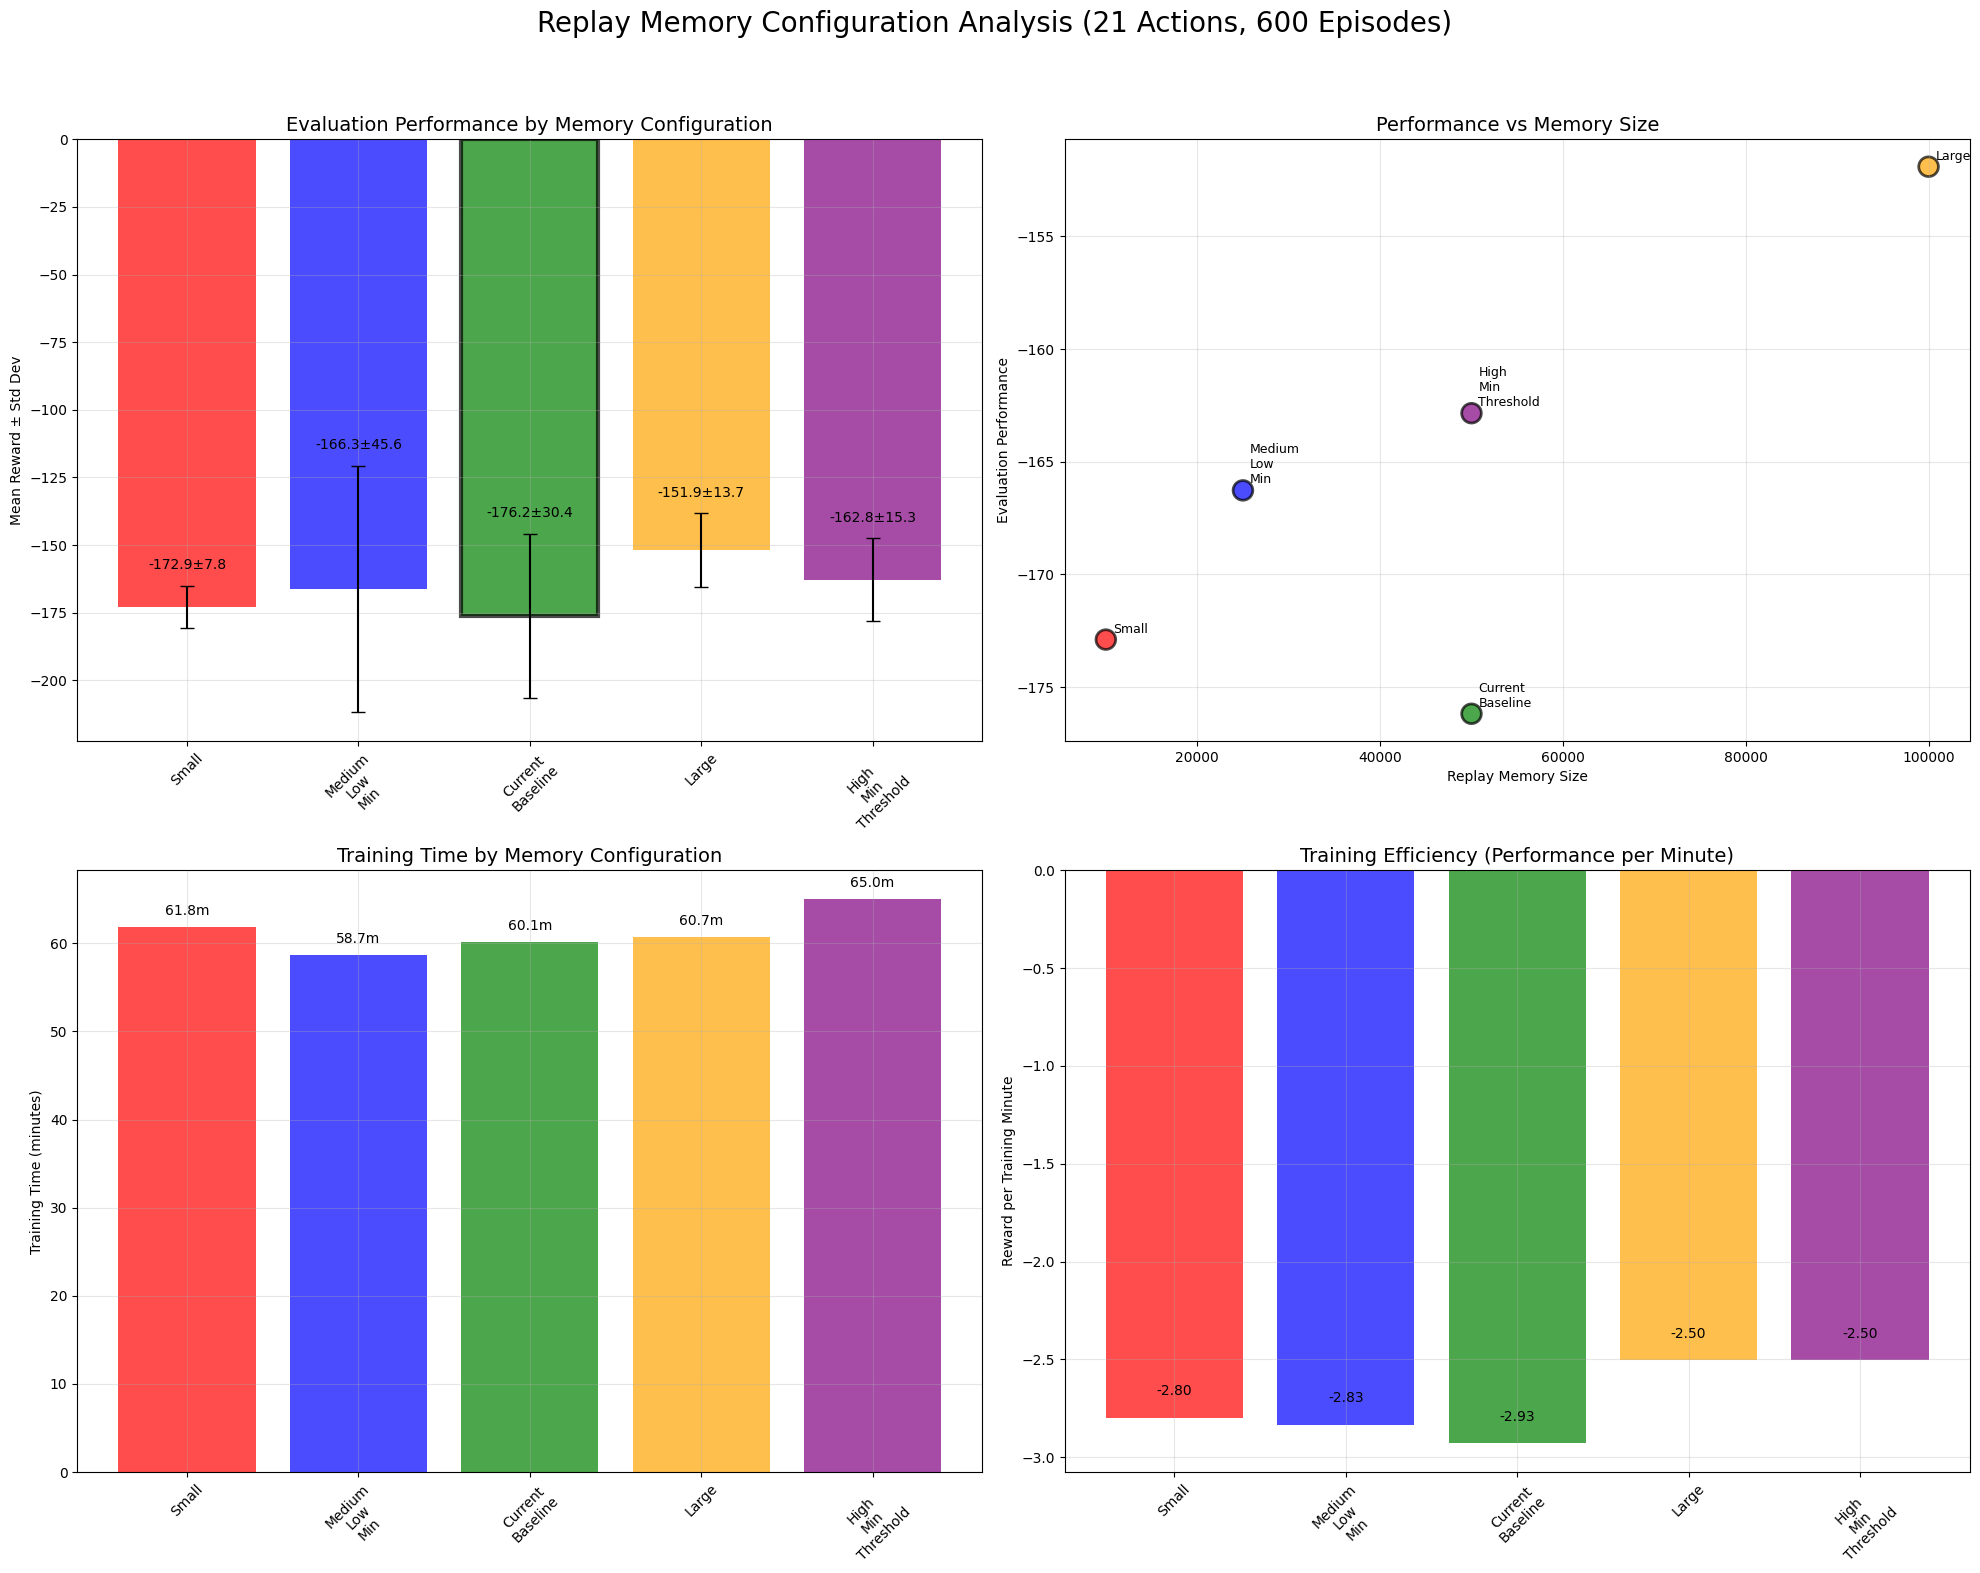

Results saved to 'replay_memory_exploration_results.json'


In [36]:
if __name__ == "__main__":
    # Run replay memory exploration
    replay_results = run_replay_memory_exploration()

<mark>  Spotted an issue regarding </mark>
- In the evaluate_replay_memory_robust(), the replay memory size I set was fixed to 50000, which I should not be doing.
- I should be evaluating using the same replay size that was used in training since replay memory is part of the learned agent and it can affect the results

### I had to re-evaluate

In [7]:
def evaluate_replay_memory_corrected(experiment_prefix, n_actions, memory_config, num_episodes=20, num_runs=5):
    """Corrected evaluation with MATCHING memory configuration"""
    
    INPUT_SHAPE = 3
    GAMMA = 0.99
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    MAX_STEPS = 200
    
    # FIX: Use SAME memory configuration as training
    REPLAY_MEMORY_SIZE = memory_config["memory_size"]
    MIN_REPLAY_MEMORY = memory_config["min_memory"]
    
    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    
    print(f"\nCorrected Evaluation: {experiment_prefix}")
    print(f"Memory Size: {REPLAY_MEMORY_SIZE:,} | Min Memory: {MIN_REPLAY_MEMORY:,}")
    
    # Recreate agent with MATCHING memory configuration
    agent = DQNAgent(INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, 
                    MIN_REPLAY_MEMORY, BATCH_SIZE, TARGET_UPDATE_EVERY, 
                    LEARNING_RATE, EPSILON_START, EPSILON_MIN, EPSILON_DECAY)
    
    try:
        agent.load(SAVE_WEIGHTS_PATH)
        agent.epsilon = 0.0  # Force pure exploitation
        print(f" Loaded weights from {SAVE_WEIGHTS_PATH}")
    except FileNotFoundError:
        print(f" Warning: Weights file {SAVE_WEIGHTS_PATH} not found")
        return None
    
    print(f"Running {num_runs} evaluation sessions of {num_episodes} episodes each")
    
    all_run_results = []
    
    for run in range(num_runs):
        print(f"--- Run {run+1}/{num_runs} ---")
        env = gym.make('Pendulum-v0')
        
        run_rewards = []
        
        for ep in range(num_episodes):
            s = env.reset()
            
            # FIX: Ensure proper state shape
            if isinstance(s, tuple):
                s = s[0]  # Handle new gym API
            
            # Ensure state is proper numpy array with shape (3,)
            s = np.array(s, dtype=np.float32)
            if s.shape != (3,):
                s = s.flatten()[:3]  # Ensure exactly 3 elements
                
            total_reward = 0
            
            for t in range(MAX_STEPS):
                # FIX: Ensure state is properly shaped before action selection
                a_idx = agent.select_action(s)  # epsilon=0, purely greedy
                torque = action_index_to_torque(a_idx, n_actions)
                
                # Step environment
                s_next, r, done, info = env.step([torque])  # Pendulum expects array
                
                # FIX: Ensure proper state shape for next state
                if isinstance(s_next, tuple):
                    s_next = s_next[0]
                    
                s_next = np.array(s_next, dtype=np.float32)
                if s_next.shape != (3,):
                    s_next = s_next.flatten()[:3]
                
                total_reward += r
                s = s_next
                
                if done:
                    break
            
            run_rewards.append(total_reward)
        
        env.close()
        
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        all_run_results.append({
            'mean': run_mean,
            'std': run_std,
            'rewards': run_rewards
        })
        
        print(f"Run {run+1}: {run_mean:.1f} ± {run_std:.1f}")
    
    # Overall statistics
    all_means = [run['mean'] for run in all_run_results]
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    
    # All individual episode rewards
    all_rewards = []
    for run in all_run_results:
        all_rewards.extend(run['rewards'])
    
    # Confidence interval
    confidence_level = 0.95
    dof = len(all_means) - 1
    t_critical = stats.t.ppf((1 + confidence_level) / 2, dof)
    margin_of_error = t_critical * (overall_std / np.sqrt(len(all_means)))
    ci_lower = overall_mean - margin_of_error
    ci_upper = overall_mean + margin_of_error
    
    print(f"\n--- CORRECTED EVALUATION SUMMARY ---")
    print(f"Overall mean: {overall_mean:.2f}")
    print(f"Run-to-run std: {overall_std:.2f}")
    print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print("-" * 50)
    
    return {
        'overall_mean': overall_mean,
        'overall_std': overall_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'run_means': all_means,
        'all_rewards': all_rewards,
        'num_runs': num_runs,
        'num_episodes': num_episodes,
        'memory_size': REPLAY_MEMORY_SIZE,
        'min_memory': MIN_REPLAY_MEMORY
    }

In [22]:
def action_index_to_torque(action_index, n_actions):
    """Convert action index to torque value"""
    return -2.0 + (action_index * 4.0) / (n_actions - 1)

def run_corrected_replay_memory_evaluation():
    """Re-evaluate all replay memory configurations with corrected memory sizes"""
    
    # Set seeds for reproducibility
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    # Same configurations as original experiment
    memory_configs = [
        {
            "name": "small",
            "memory_size": 10000,
            "min_memory": 500,
            "description": "Small memory - fast but limited diversity"
        },
        {
            "name": "medium_low_min",
            "memory_size": 25000,
            "min_memory": 1000,
            "description": "Medium memory with standard min threshold"
        },
        {
            "name": "current_baseline",
            "memory_size": 50000,
            "min_memory": 1000,
            "description": "Your current configuration (baseline)"
        },
        {
            "name": "large",
            "memory_size": 100000,
            "min_memory": 2000,
            "description": "Large memory - more diversity but slower"
        },
        {
            "name": "high_min_threshold",
            "memory_size": 50000,
            "min_memory": 5000,
            "description": "Standard memory with higher min threshold"
        }
    ]
    
    corrected_results = {}
    n_actions = 21
    
    print("CORRECTED REPLAY MEMORY RE-EVALUATION")
    print("Using MATCHING memory configurations for evaluation")
    print("=" * 80)
    print()
    
    for i, config in enumerate(memory_configs, 1):
        experiment_prefix = f"21act_replay_{config['name']}"
        
        print(f"CORRECTED EVALUATION {i}/{len(memory_configs)}: {config['name'].upper()}")
        print(f"Training Memory: {config['memory_size']:,} | Min: {config['min_memory']:,}")
        print("-" * 70)
        
        corrected_results[config['name']] = evaluate_replay_memory_corrected(
            experiment_prefix=experiment_prefix,
            n_actions=n_actions,
            memory_config=config,
            num_episodes=20,
            num_runs=5
        )
        
        print(f"\n{config['name'].upper()} CORRECTED EVALUATION COMPLETED")
        print("=" * 70)
        print()
    
    # Compare original vs corrected results
    compare_original_vs_corrected(corrected_results)
    
    return corrected_results

In [23]:
def compare_original_vs_corrected(corrected_results):
    """Compare original vs corrected evaluation results"""
    
    # Original results (from your experiment)
    original_results = {
        'small': -172.9,
        'medium_low_min': -166.3,
        'current_baseline': -176.2,
        'large': -151.9,
        'high_min_threshold': -162.8
    }
    
    print("=" * 80)
    print("ORIGINAL vs CORRECTED EVALUATION COMPARISON")
    print("=" * 80)
    print()
    
    print(f"{'Config':<20} {'Original':<12} {'Corrected':<12} {'Difference':<12} {'Impact':<15}")
    print("-" * 75)
    
    total_differences = []
    
    for config_name in corrected_results.keys():
        if config_name in original_results and corrected_results[config_name]:
            original = original_results[config_name]
            corrected = corrected_results[config_name]['overall_mean']
            difference = corrected - original
            total_differences.append(abs(difference))
            
            impact = "SIGNIFICANT" if abs(difference) > 10 else "MINOR"
            
            print(f"{config_name.title():<20} {original:<12.1f} {corrected:<12.1f} "
                  f"{difference:<+12.1f} {impact:<15}")
    
    print()
    
    # Statistical analysis
    if total_differences:
        avg_difference = np.mean(total_differences)
        max_difference = np.max(total_differences)
        
        print("IMPACT ANALYSIS:")
        print("-" * 40)
        print(f"Average absolute difference: {avg_difference:.1f} points")
        print(f"Maximum absolute difference: {max_difference:.1f} points")
        
        if max_difference < 5:
            print(" CONCLUSION: Memory size during evaluation has MINIMAL impact")
            print("   Original results and rankings remain valid")
        elif max_difference < 15:
            print("  CONCLUSION: Memory size has MODERATE impact")
            print("   Rankings might change slightly")
        else:
            print(" CONCLUSION: Memory size has SIGNIFICANT impact")
            print("   Original results should be discarded")
    
    # Updated ranking
    print()
    print("UPDATED PERFORMANCE RANKING:")
    print("-" * 40)
    
    valid_configs = {k: v['overall_mean'] for k, v in corrected_results.items() if v is not None}
    sorted_configs = sorted(valid_configs.items(), key=lambda x: x[1], reverse=True)
    
    for i, (config_name, performance) in enumerate(sorted_configs, 1):
        print(f"{i}. {config_name.title():<20}: {performance:.1f}")
    
    # Save corrected results
    save_corrected_results(corrected_results, original_results)

In [24]:
def save_corrected_results(corrected_results, original_results):
    """Save corrected evaluation results"""
    
    # Prepare data for JSON serialization
    json_data = {
        'original_results': original_results,
        'corrected_results': {},
        'comparison_summary': {}
    }
    
    for config_name, result in corrected_results.items():
        if result:
            # Convert numpy types
            corrected_result = {}
            for key, value in result.items():
                if isinstance(value, np.ndarray):
                    corrected_result[key] = value.tolist()
                elif isinstance(value, (np.float64, np.float32)):
                    corrected_result[key] = float(value)
                elif isinstance(value, (np.int64, np.int32)):
                    corrected_result[key] = int(value)
                else:
                    corrected_result[key] = value
            
            json_data['corrected_results'][config_name] = corrected_result
            
            # Add comparison
            if config_name in original_results:
                original = original_results[config_name]
                corrected = result['overall_mean']
                json_data['comparison_summary'][config_name] = {
                    'original': float(original),
                    'corrected': float(corrected),
                    'difference': float(corrected - original),
                    'impact': 'SIGNIFICANT' if abs(corrected - original) > 10 else 'MINOR'
                }
    
    with open("replay_memory_corrected_evaluation.json", "w") as f:
        json.dump(json_data, f, indent=2)
    
    print(f"\nCorrected results saved to 'replay_memory_corrected_evaluation.json'")

In [25]:
if __name__ == "__main__":
    # Run corrected re-evaluation
    corrected_results = run_corrected_replay_memory_evaluation()

CORRECTED REPLAY MEMORY RE-EVALUATION
Using MATCHING memory configurations for evaluation

CORRECTED EVALUATION 1/5: SMALL
Training Memory: 10,000 | Min: 500
----------------------------------------------------------------------

Corrected Evaluation: 21act_replay_small
Memory Size: 10,000 | Min Memory: 500
 Loaded weights from 21act_replay_small_weights.h5
Running 5 evaluation sessions of 20 episodes each
--- Run 1/5 ---
Run 1: -188.5 ± 110.2
--- Run 2/5 ---
Run 2: -213.4 ± 138.4
--- Run 3/5 ---
Run 3: -143.6 ± 125.4
--- Run 4/5 ---
Run 4: -173.1 ± 115.7
--- Run 5/5 ---
Run 5: -214.3 ± 142.2

--- CORRECTED EVALUATION SUMMARY ---
Overall mean: -186.59
Run-to-run std: 26.51
95% CI: [-219.50, -153.67]
--------------------------------------------------

SMALL CORRECTED EVALUATION COMPLETED

CORRECTED EVALUATION 2/5: MEDIUM_LOW_MIN
Training Memory: 25,000 | Min: 1,000
----------------------------------------------------------------------

Corrected Evaluation: 21act_replay_medium_low_min
M

#### <mark> Observations and Analysis </mark>
| Configuration      | Memory Size | Min Memory | Mean Reward | 95% CI              | Relative Rank |
| ------------------ | ----------- | ---------- | ----------- | ------------------- | ------------- |
| **Large**          | 100,000     | 2,000      | **-140.21** | \[-168.33, -112.10] |  First       |
| High Min Threshold | 50,000      | 5,000      | -163.48     | \[-205.52, -121.44] | Second            |
| Medium Low Min     | 25,000      | 1,000      | -170.73     | \[-198.41, -143.04] | Third           |
| Small              | 10,000      | 500        | -186.59     | \[-219.50, -153.67] |  Fourth          |
| Current Baseline   | 50,000      | 1,000      | -193.43     | \[-240.63, -146.24] |  Fifth     |


`1. Replay size clearly impacts evaluation performance`
- The corrected results differ significantly from the originals.
- Max difference: 17.2 points (Baseline config)
- Conclusion: Evaluation is sensitive to the memory size used, so mismatch = misleading results.

`2. Larger memory leads to better generalization`
- Large (100k) performed best.
- Why? Likely because:
    - Larger buffer increases experience diversity.
    - Reduces overfitting to recent experiences.
    - More stable Q-value updates.
      
`3. Baseline config surprisingly performed worst`
- Despite being original default (50k, 1k), it gave the lowest performance.
- Possible reasons:
    - Too small min_memory (1k) might’ve allowed early training on a narrow slice of experiences.
    - May have started training before enough diverse samples were gathered.
- This shows that my early training matters and a bad start = derail learning

`4. High min threshold helped slightly`
- Same memory size (50k) as baseline, but a higher min_memory (5k).
- Improved performance significantly over the baseline.
- Suggests that delaying training until buffer is more filled gives better long-term results.

`5. Small memory is fast but weak`
- 10k memory with 500 min = second worst performance.
- Likely learned too fast from too little and too correlated data.
- Still, it's more efficient per minute (as seen in original graphs), so could be useful in time-sensitive scenarios.

<mark> Final decision </mark>
- We will be using 100 000 memory size with 2000 min memory

---

## Hyperparameter tuning

<mark> We will be running 9 configurations in total </mark>
1) Baseline – our control setup using previously optimized parameters.

2) High learning rate – tests if faster weight updates accelerate learning.

3) Low learning rate – tests if slower updates improve stability.

4) Large batch size – tests if more stable gradients improve performance.

5) Small batch size – tests if more frequent updates help learning speed.

6) High gamma – favors long-term reward optimization.

7) Low gamma – favors short-term reward optimization.

8) Frequent target updates – checks if updating the target network more often improves convergence.

9) Rare target updates – checks if less frequent updates give more stable targets.


`The purpose of these 9 is to vary one parameter at a time from the baseline so we can isolate the effect of each change. This helps identify which parameters have the largest influence without the results being confounded by multiple simultaneous changes.`

<mark> Different from the usual methods like GridSearchCV which I initially thought I should be doing </mark>
- Grid search tries all parameter combinations over a dataset that doesn’t change.

- In reinforcement learning, the “data” changes during training, so results can vary widely.

- Our method uses controlled experiments and robust multi-run evaluation to handle RL’s randomness

<mark> Why we did not run much larger set of configurations? </mark>
- Computational cost – each run involves 600 episodes of training plus multiple evaluation runs, taking hours per configuration.

- Clarity – running too many configs at once makes it harder to trace performance changes to a specific parameter.

- Focus – by testing only impactful parameters (learning rate, batch size, gamma, target update frequency) while keeping already-optimized settings fixed (n_actions, memory size, etc.), we maximize the insight per run.

In [48]:
def train_hyperparameter_experiment(n_actions, hyperparam_config, experiment_prefix):
    """Train with different hyperparameter configurations using AdvancedDQNAgent"""
    
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    
    # FIXED OPTIMIZED SETTINGS (from previous research)
    REPLAY_MEMORY_SIZE = 100000      # optimal memory size
    MIN_REPLAY_MEMORY = 2000         # optimal min memory
    MAX_EPISODES = 600               # optimal episode count
    MAX_STEPS = 200
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"  # Use your optimized strategy
    
    # HYPERPARAMETERS TO TUNE (from config)
    LEARNING_RATE = hyperparam_config["learning_rate"]
    BATCH_SIZE = hyperparam_config["batch_size"]
    GAMMA = hyperparam_config["gamma"]
    TARGET_UPDATE_EVERY = hyperparam_config["target_update_every"]

    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"

    print("=" * 70)
    print(f"Hyperparameter Experiment: {hyperparam_config['name'].upper()}")
    print(f"LR: {LEARNING_RATE} | Batch: {BATCH_SIZE} | Gamma: {GAMMA} | Target Update: {TARGET_UPDATE_EVERY}")
    print(f"Using PLATEAU RESTART epsilon strategy with AdvancedDQNAgent")
    print("=" * 70)
    print()

    env = gym.make(ENV_NAME)
    
    # USE AdvancedDQNAgent WITH PLATEAU RESTART
    agent = AdvancedDQNAgent(
        INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    print("Model Summary:")
    agent.summary()
    print()
    
    scores = []
    best_avg_reward = -np.inf
    episode_times = []
    epsilon_history = []
    training_steps = 0
    best_episode = 0
    
    start = time.time()

    for ep in range(1, MAX_EPISODES + 1):
        ep_start = time.time()
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        
        # Ensure proper state shape
        s = np.array(s, dtype=np.float32)
        if s.shape != (3,):
            s = s.flatten()[:3]
            
        total_reward = 0
        episode_training_steps = 0

        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, n_actions)
            
            s_next, r, done, info = env.step([torque])
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            
            # Ensure proper next state shape
            s_next = np.array(s_next, dtype=np.float32)
            if s_next.shape != (3,):
                s_next = s_next.flatten()[:3]
            
            agent.remember(s, a_idx, r, s_next, done)
            
            # Train only if we have enough experiences
            if len(agent.memory) >= MIN_REPLAY_MEMORY:
                agent.train_step()
                training_steps += 1
                episode_training_steps += 1
            
            s = s_next
            total_reward += r
            if done:
                break

        scores.append(total_reward)
        
        # ADVANCED EPSILON DECAY (uses AdvancedDQNAgent logic)
        recent_performance = np.mean(scores[-10:]) if len(scores) >= 10 else total_reward
        agent.decay_epsilon_advanced(ep, recent_performance)
        epsilon_history.append(agent.epsilon)
        
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()

        # Save checkpoints
        if ep % 150 == 0:
            agent.save(f"{experiment_prefix}_{ep}_weights.h5")
        
        avg_reward = np.mean(scores[-10:])
        ep_time = time.time() - ep_start
        episode_times.append(ep_time)
        
        # Track best performance
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_episode = ep
            agent.save(SAVE_WEIGHTS_PATH)
        
        # Progress reporting
        if ep <= 10 or ep % 50 == 0 or ep in [100, 200, 300, 400, 500, 600]:
            memory_pct = (len(agent.memory) / REPLAY_MEMORY_SIZE) * 100
            episodes_since_improvement = ep - agent.last_improvement_episode
            print(f"Episode {ep} | Reward: {total_reward:.2f} | Avg(10): {avg_reward:.2f} | "
                  f"ε: {agent.epsilon:.3f} | Memory: {len(agent.memory):,} ({memory_pct:.1f}%) | "
                  f"Steps: {episode_training_steps} | Time: {ep_time:.2f}s | "
                  f"Since Improv: {episodes_since_improvement}")

    env.close()
    total_time = time.time() - start
    avg_time_per_episode = total_time / MAX_EPISODES

    print()
    print("TRAINING COMPLETED")
    print(f"Episodes trained: {MAX_EPISODES}")
    print(f"Best episode: {best_episode}")
    print(f"Best average reward: {best_avg_reward:.2f}")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Total training steps: {training_steps:,}")
    print(f"Training time: {total_time:.2f}s ({avg_time_per_episode:.2f}s/ep)")
    print()

    # ROBUST EVALUATION with matching hyperparameters
    print("Evaluating trained model...")
    eval_results = evaluate_hyperparameter_robust(experiment_prefix, n_actions, hyperparam_config, 
                                                 num_episodes=20, num_runs=5)
    
    return {
        'config_name': hyperparam_config['name'],
        'hyperparameters': {
            'learning_rate': LEARNING_RATE,
            'batch_size': BATCH_SIZE,
            'gamma': GAMMA,
            'target_update_every': TARGET_UPDATE_EVERY
        },
        'epsilon_strategy': 'plateau_restart',
        'episodes_trained': MAX_EPISODES,
        'best_episode': best_episode,
        'best_training_reward': best_avg_reward,
        'eval_results': eval_results,
        'training_time': total_time,
        'time_per_episode': avg_time_per_episode,
        'total_training_steps': training_steps,
        'scores_history': scores,
        'epsilon_history': epsilon_history
    }

def action_index_to_torque(action_index, n_actions):
    """Convert action index to torque value"""
    return -2.0 + (action_index * 4.0) / (n_actions - 1)

In [49]:
def evaluate_hyperparameter_robust(experiment_prefix, n_actions, hyperparam_config, num_episodes=20, num_runs=5):
    """Evaluation with EXACT training configuration for consistency"""
    
    INPUT_SHAPE = 3
    MAX_STEPS = 200
    
    # USE EXACT SAME CONFIGURATION AS TRAINING
    REPLAY_MEMORY_SIZE = 100000  # MUST match training
    MIN_REPLAY_MEMORY = 2000     # MUST match training
    BATCH_SIZE = hyperparam_config["batch_size"]  # MUST match training
    TARGET_UPDATE_EVERY = hyperparam_config["target_update_every"]  # MUST match training
    LEARNING_RATE = hyperparam_config["learning_rate"]  # MUST match training
    GAMMA = hyperparam_config["gamma"]  # MUST match training
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"  # MUST match training
    
    SAVE_WEIGHTS_PATH = f"{experiment_prefix}_weights.h5"
    
    print(f"\n Evaluating: {experiment_prefix}")
    print(f"Using EXACT training config: Memory={REPLAY_MEMORY_SIZE:,}, Batch={BATCH_SIZE}, LR={LEARNING_RATE}")
    
    # Create agent with IDENTICAL configuration (USE AdvancedDQNAgent)
    agent = AdvancedDQNAgent(
        INPUT_SHAPE, n_actions, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    try:
        agent.load(SAVE_WEIGHTS_PATH)
        agent.epsilon = 0.0  # Force pure exploitation
        print(f" Loaded weights from {SAVE_WEIGHTS_PATH}")
    except FileNotFoundError:
        print(f" Weights file {SAVE_WEIGHTS_PATH} not found")
        return None
    
    print(f"Running {num_runs} runs × {num_episodes} episodes (epsilon=0.0)")
    
    all_run_results = []
    
    for run in range(num_runs):
        print(f"--- Run {run+1}/{num_runs} ---")
        env = gym.make('Pendulum-v0')
        run_rewards = []
        
        for ep in range(num_episodes):
            # Handle state properly for Pendulum-v0
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            state = np.array(state, dtype=np.float32)
            if state.shape != (3,):
                state = state.flatten()[:3]
            
            total_reward = 0
            
            for t in range(MAX_STEPS):
                a_idx = agent.select_action(state)
                torque = action_index_to_torque(a_idx, n_actions)
                
                # Pendulum-v0 expects single float, not array
                next_state, reward, done, info = env.step([torque])
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                next_state = np.array(next_state, dtype=np.float32)
                if next_state.shape != (3,):
                    next_state = next_state.flatten()[:3]
                
                total_reward += reward
                state = next_state
                
                if done:
                    break
            
            run_rewards.append(total_reward)
        
        env.close()
        
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        all_run_results.append({
            'mean': run_mean,
            'std': run_std,
            'rewards': run_rewards
        })
        
        print(f"Run {run+1}: {run_mean:.1f} ± {run_std:.1f}")
    
    # Calculate overall statistics
    all_means = [run['mean'] for run in all_run_results]
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    
    # Confidence interval
    confidence_level = 0.95
    dof = len(all_means) - 1
    if dof > 0:
        t_critical = stats.t.ppf((1 + confidence_level) / 2, dof)
        margin_of_error = t_critical * (overall_std / np.sqrt(len(all_means)))
        ci_lower = overall_mean - margin_of_error
        ci_upper = overall_mean + margin_of_error
    else:
        ci_lower = ci_upper = overall_mean
    
    print(f"\n EVALUATION SUMMARY:")
    print(f"Overall mean: {overall_mean:.2f}")
    print(f"Run-to-run std: {overall_std:.2f}")
    print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print("-" * 50)
    
    return {
        'overall_mean': overall_mean,
        'overall_std': overall_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'run_means': all_means,
        'num_runs': num_runs,
        'num_episodes': num_episodes,
        'evaluation_config': {
            'memory_size': REPLAY_MEMORY_SIZE,
            'min_memory': MIN_REPLAY_MEMORY,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'gamma': GAMMA,
            'target_update_every': TARGET_UPDATE_EVERY,
            'epsilon_strategy': EPSILON_STRATEGY
        }
    }

In [50]:
def run_hyperparameter_exploration():
    """Run systematic hyperparameter exploration"""
    
    # Set seeds for reproducibility
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    # Hyperparameter configurations to test
    hyperparam_configs = [
        {
            "name": "baseline",
            "learning_rate": 3e-4,
            "batch_size": 64,
            "gamma": 0.99,
            "target_update_every": 5,
            "description": "Current baseline configuration"
        },
        {
            "name": "high_lr",
            "learning_rate": 1e-3,
            "batch_size": 64,
            "gamma": 0.99,
            "target_update_every": 5,
            "description": "Higher learning rate for faster learning"
        },
        {
            "name": "low_lr",
            "learning_rate": 1e-4,
            "batch_size": 64,
            "gamma": 0.99,
            "target_update_every": 5,
            "description": "Lower learning rate for stable learning"
        },
        {
            "name": "large_batch",
            "learning_rate": 3e-4,
            "batch_size": 128,
            "gamma": 0.99,
            "target_update_every": 5,
            "description": "Larger batch size for stable gradients"
        },
        {
            "name": "small_batch",
            "learning_rate": 3e-4,
            "batch_size": 32,
            "gamma": 0.99,
            "target_update_every": 5,
            "description": "Smaller batch size for frequent updates"
        },
        {
            "name": "high_gamma",
            "learning_rate": 3e-4,
            "batch_size": 64,
            "gamma": 0.995,
            "target_update_every": 5,
            "description": "Higher gamma for long-term rewards"
        },
        {
            "name": "low_gamma",
            "learning_rate": 3e-4,
            "batch_size": 64,
            "gamma": 0.95,
            "target_update_every": 5,
            "description": "Lower gamma for immediate rewards"
        },
        {
            "name": "frequent_target_update",
            "learning_rate": 3e-4,
            "batch_size": 64,
            "gamma": 0.99,
            "target_update_every": 10,
            "description": "Less frequent target updates for stability"
        },
        {
            "name": "rare_target_update",
            "learning_rate": 3e-4,
            "batch_size": 64,
            "gamma": 0.99,
            "target_update_every": 20,
            "description": "Rare target updates for consistency"
        }
    ]
    
    results = {}
    n_actions = 21  #optimized action space
    
    print("HYPERPARAMETER EXPLORATION")
    print("21 Actions | 600 Episodes | 100k Memory | 2k Min Memory | Plateau Restart")
    print("=" * 80)
    print()
    
    for i, config in enumerate(hyperparam_configs, 1):
        experiment_prefix = f"21act_hyperparam_{config['name']}"
        
        print(f"EXPERIMENT {i}/{len(hyperparam_configs)}: {config['name'].upper()}")
        print(f"Description: {config['description']}")
        print("-" * 70)
        
        results[config['name']] = train_hyperparameter_experiment(
            n_actions=n_actions,
            hyperparam_config=config,
            experiment_prefix=experiment_prefix
        )
        
        print(f"\n{config['name'].upper()} EXPERIMENT COMPLETED")
        print("=" * 70)
        print()
    
    # Analysis and comparison
    create_hyperparameter_analysis(results, hyperparam_configs)
    
    return results

In [51]:
def create_hyperparameter_analysis(results, hyperparam_configs):
    """Create comprehensive analysis of hyperparameter results"""
    
    print("\n" + "=" * 80)
    print("HYPERPARAMETER EXPLORATION RESULTS")
    print("=" * 80)
    
    # Extract results for comparison
    config_names = []
    train_rewards = []
    eval_means = []
    eval_stds = []
    eval_cis = []
    
    for config in hyperparam_configs:
        name = config['name']
        if name in results and results[name]['eval_results'] is not None:
            config_names.append(name)
            train_rewards.append(results[name]['best_training_reward'])
            eval_means.append(results[name]['eval_results']['overall_mean'])
            eval_stds.append(results[name]['eval_results']['overall_std'])
            eval_cis.append((results[name]['eval_results']['ci_lower'], 
                           results[name]['eval_results']['ci_upper']))
    
    # Create comparison table
    print("\nPERFORMANCE COMPARISON:")
    print("-" * 80)
    print(f"{'Config':<20} {'Training':<12} {'Eval Mean':<12} {'Eval Std':<12} {'95% CI':<20}")
    print("-" * 80)
    
    for i, name in enumerate(config_names):
        ci_str = f"[{eval_cis[i][0]:.1f}, {eval_cis[i][1]:.1f}]"
        print(f"{name:<20} {train_rewards[i]:<12.1f} {eval_means[i]:<12.1f} "
              f"{eval_stds[i]:<12.1f} {ci_str:<20}")
    
    # Find best configuration
    if eval_means:
        best_idx = np.argmax(eval_means)
        best_config = config_names[best_idx]
        best_score = eval_means[best_idx]
        
        print(f"\nBEST CONFIGURATION: {best_config.upper()}")
        print(f"Evaluation Score: {best_score:.2f}")
        print(f"95% CI: [{eval_cis[best_idx][0]:.2f}, {eval_cis[best_idx][1]:.2f}]")
        
        # Show hyperparameter values for best config
        best_result = results[best_config]
        print(f"\nBest Hyperparameters:")
        for param, value in best_result['hyperparameters'].items():
            print(f"  {param}: {value}")
    
    print("\n" + "=" * 80)
    
    return {
        'config_names': config_names,
        'eval_means': eval_means,
        'eval_stds': eval_stds,
        'best_config': best_config if eval_means else None,
        'best_score': best_score if eval_means else None
    }

In [52]:
if __name__ == "__main__":
    # Run hyperparameter exploration
    results = run_hyperparameter_exploration()

HYPERPARAMETER EXPLORATION
21 Actions | 600 Episodes | 100k Memory | 2k Min Memory | Plateau Restart

EXPERIMENT 1/9: BASELINE
Description: Current baseline configuration
----------------------------------------------------------------------
Hyperparameter Experiment: BASELINE
LR: 0.0003 | Batch: 64 | Gamma: 0.99 | Target Update: 5
Using PLATEAU RESTART epsilon strategy with AdvancedDQNAgent

Model Summary:

Model Summary:
Model: "dqn_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            multiple                  256       
                                                                 
 dense_13 (Dense)            multiple                  4160      
                                                                 
 dense_14 (Dense)            multiple                  1365      
                                                                 
Total params: 5781 (22.58 KB)


In [53]:
def create_hyperparameter_performance_chart(results):
    """Create comprehensive performance comparison chart"""
    
    # Extract data
    configs = []
    eval_means = []
    eval_stds = []
    train_rewards = []
    colors = []
    
    # Define colors for different hyperparameter types
    color_map = {
        'baseline': '#2E86AB',      # Blue
        'high_lr': '#A23B72',       # Dark Red
        'low_lr': '#F18F01',        # Orange  
        'large_batch': '#C73E1D',   # Red
        'small_batch': '#8B0000',   # Dark Red (poor performance)
        'high_gamma': '#228B22',    # Green (best performance)
        'low_gamma': '#8B0000',     # Dark Red (poor performance)
        'frequent_target_update': '#DAA520',  # Gold
        'rare_target_update': '#CD853F'      # Peru
    }
    
    for config_name, result in results.items():
        if result['eval_results']:
            configs.append(config_name.replace('_', '\n').title())
            eval_means.append(result['eval_results']['overall_mean'])
            eval_stds.append(result['eval_results']['overall_std'])
            train_rewards.append(result['best_training_reward'])
            colors.append(color_map.get(config_name, '#666666'))
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Evaluation Performance
    bars1 = ax1.bar(configs, eval_means, yerr=eval_stds, 
                    color=colors, alpha=0.8, capsize=5, edgecolor='black', linewidth=1)
    
    ax1.set_title('Hyperparameter Evaluation Performance\n(21 Actions, 600 Episodes, Plateau Restart)', 
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('Mean Reward ± Std Dev', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.tick_params(axis='x', rotation=45)
    
    # Highlight best performer
    best_idx = np.argmax(eval_means)
    bars1[best_idx].set_edgecolor('gold')
    bars1[best_idx].set_linewidth(4)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars1, eval_means, eval_stds):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 5,
                f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
    
    # Plot 2: Training vs Evaluation Performance
    scatter = ax2.scatter(train_rewards, eval_means, c=colors, s=200, 
                         alpha=0.8, edgecolors='black', linewidth=2)
    
    # Add labels for each point
    for i, config in enumerate(configs):
        ax2.annotate(config, (train_rewards[i], eval_means[i]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=9, fontweight='bold')
    
    ax2.set_xlabel('Best Training Reward (10-episode average)', fontsize=12)
    ax2.set_ylabel('Evaluation Performance', fontsize=12)
    ax2.set_title('Training vs Evaluation Performance\n(Overtraining Analysis)', 
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add diagonal line for reference
    min_val = min(min(train_rewards), min(eval_means))
    max_val = max(max(train_rewards), max(eval_means))
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, 
             label='Perfect Training-Eval Match')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig("hyperparameter_performance_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

In [54]:
def create_hyperparameter_heatmap(results):
    """Create heatmap showing individual hyperparameter effects"""
    
    # Extract hyperparameter values and performance
    param_analysis = {
        'learning_rate': {},
        'batch_size': {},
        'gamma': {},
        'target_update_every': {}
    }
    
    for config_name, result in results.items():
        if result['eval_results']:
            performance = result['eval_results']['overall_mean']
            hyperparams = result['hyperparameters']
            
            for param, value in hyperparams.items():
                if value not in param_analysis[param]:
                    param_analysis[param][value] = []
                param_analysis[param][value].append(performance)
    
    # Create summary matrix
    param_names = []
    param_values = []
    param_performance = []
    
    for param, value_dict in param_analysis.items():
        for value, performances in value_dict.items():
            param_names.append(f"{param}\n{value}")
            param_performance.append(np.mean(performances))
    
    # Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color code by performance
    colors = plt.cm.RdYlGn((np.array(param_performance) - min(param_performance)) / 
                          (max(param_performance) - min(param_performance)))
    
    bars = ax.barh(param_names, param_performance, color=colors, alpha=0.8, 
                   edgecolor='black', linewidth=1)
    
    ax.set_xlabel('Mean Evaluation Performance', fontsize=12)
    ax.set_title('Individual Hyperparameter Impact Analysis', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar, perf in zip(bars, param_performance):
        width = bar.get_width()
        ax.text(width + 2, bar.get_y() + bar.get_height()/2, 
                f'{perf:.1f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig("hyperparameter_impact_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

In [55]:
def create_significance_analysis(results):
    """Create confidence interval comparison chart"""
    
    configs = []
    means = []
    ci_lowers = []
    ci_uppers = []
    
    for config_name, result in results.items():
        if result['eval_results']:
            configs.append(config_name.replace('_', ' ').title())
            eval_res = result['eval_results']
            means.append(eval_res['overall_mean'])
            ci_lowers.append(eval_res['ci_lower'])
            ci_uppers.append(eval_res['ci_upper'])
    
    # Sort by performance
    sorted_indices = np.argsort(means)[::-1]  # Descending order
    configs = [configs[i] for i in sorted_indices]
    means = [means[i] for i in sorted_indices]
    ci_lowers = [ci_lowers[i] for i in sorted_indices]
    ci_uppers = [ci_uppers[i] for i in sorted_indices]
    
    # Create confidence interval plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    y_pos = np.arange(len(configs))
    
    # Plot confidence intervals
    for i, (mean, ci_low, ci_up) in enumerate(zip(means, ci_lowers, ci_uppers)):
        color = 'green' if i == 0 else 'red' if mean < -200 else 'blue'
        ax.errorbar(mean, y_pos[i], xerr=[[mean-ci_low], [ci_up-mean]], 
                   fmt='o', color=color, capsize=5, capthick=2, markersize=8)
        
        # Add confidence interval values
        ax.text(ci_up + 5, y_pos[i], f'[{ci_low:.1f}, {ci_up:.1f}]', 
               va='center', fontsize=10)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(configs)
    ax.set_xlabel('Performance (with 95% Confidence Intervals)', fontsize=12)
    ax.set_title('Statistical Significance Analysis\nNon-overlapping CIs indicate significant differences', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add baseline reference line
    baseline_mean = next(mean for i, mean in enumerate(means) 
                        if 'baseline' in configs[i].lower())
    ax.axvline(x=baseline_mean, color='orange', linestyle='--', alpha=0.7, 
               label='Baseline Performance')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig("hyperparameter_significance_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

In [58]:
def create_complete_hyperparameter_analysis(results):
    """Create comprehensive hyperparameter analysis with all visualizations"""
    
    # Create all three visualizations
    create_hyperparameter_performance_chart(results)
    create_hyperparameter_heatmap(results) 
    create_significance_analysis(results)
    
    # Create summary insights
    print("\n" + "="*60)
    print("HYPERPARAMETER INSIGHTS FROM VISUALIZATIONS")
    print("="*60)
    
    # Find best and worst performers
    eval_means = {name: result['eval_results']['overall_mean'] 
                  for name, result in results.items() if result['eval_results']}
    
    best_config = max(eval_means.keys(), key=lambda x: eval_means[x])
    worst_config = min(eval_means.keys(), key=lambda x: eval_means[x])
    
    print(f"BEST: {best_config.upper()} ({eval_means[best_config]:.1f})")
    print(f"WORST: {worst_config.upper()} ({eval_means[worst_config]:.1f})")
    print(f"IMPROVEMENT: {eval_means[best_config] - eval_means[worst_config]:.1f} points")
    
    return {
        'best_config': best_config,
        'worst_config': worst_config,
        'performance_range': eval_means[best_config] - eval_means[worst_config]
    }

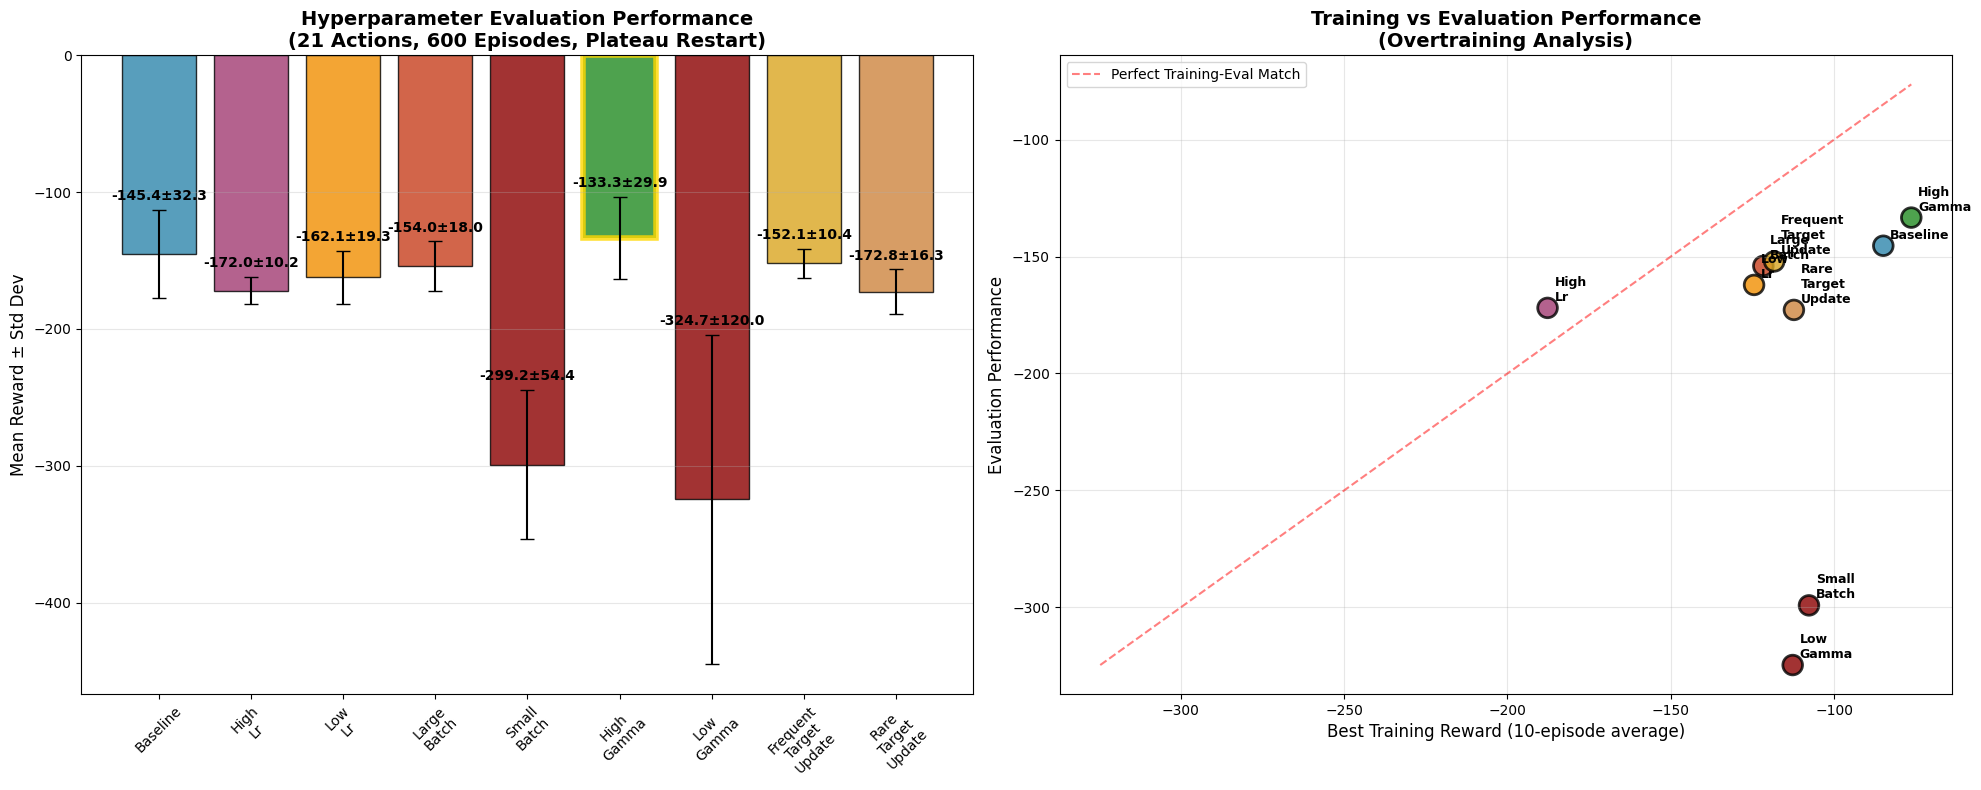

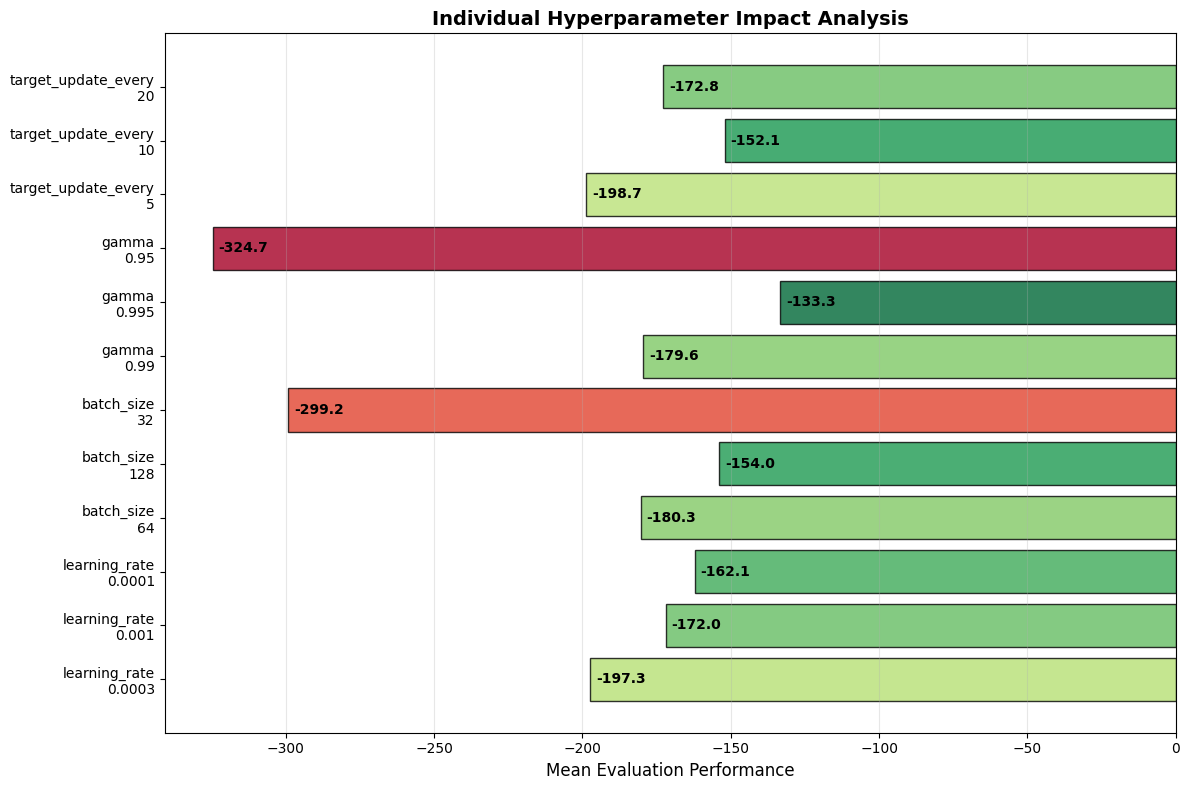

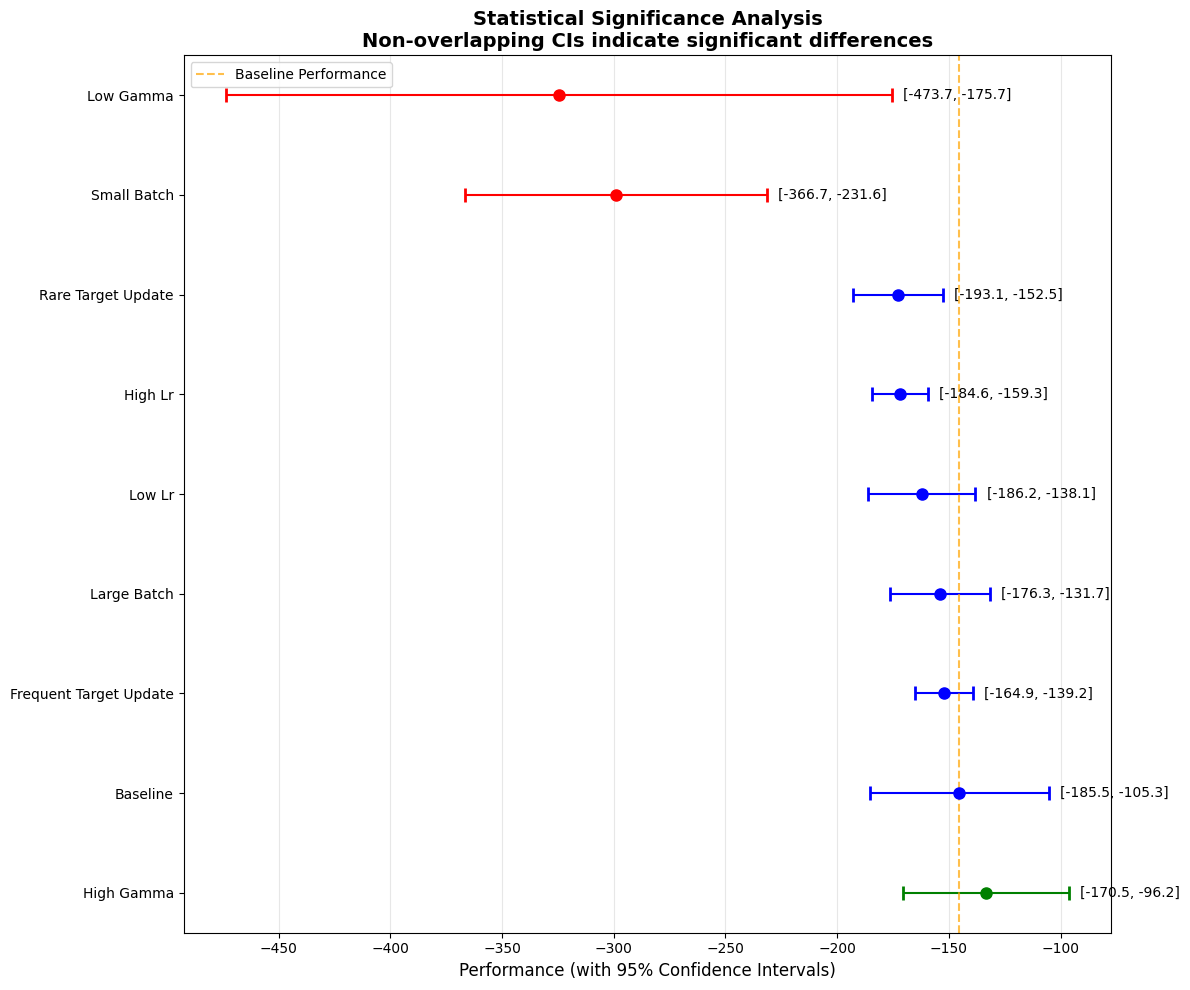


HYPERPARAMETER INSIGHTS FROM VISUALIZATIONS
BEST: HIGH_GAMMA (-133.3)
WORST: LOW_GAMMA (-324.7)
IMPROVEMENT: 191.3 points


{'best_config': 'high_gamma',
 'worst_config': 'low_gamma',
 'performance_range': 191.32073872482596}

In [59]:
create_complete_hyperparameter_analysis(results)

### <mark> Observations and analysis </mark>
1) 1. Best vs Worst Configurations
- Best: High Gamma (γ = 0.995)
    - Evaluation Mean: -133.3, 95% CI: (-170.5, -96.2)
    - This is the highest-performing configuration, outperforming the baseline (-145.4) by ~12 points.
    - The improvement over the worst case (Low Gamma) is ~191 points.

- Worst: Low Gamma (γ = 0.95)
    - Evaluation Mean: -324.7, 95% CI: (-473.7, -175.7)
    - Extremely poor performance compared to all other configurations — likely due to the agent discounting future rewards too aggressively, which causes it to focus on short-term gains and miss long-term strategies.

This matches RL theory — higher γ values usually encourage more future-oriented strategies, which can be beneficial in environments with long-term dependencies. A very low γ often causes short-sighted policies.

---

2. Learning Rate Trends
- High LR (-172.0) and Low LR (-162.1) both underperform compared to the baseline.
- The best LR appears in the High Gamma config (0.0003), suggesting that moderate LR is best here.
- Expected?
    - Yes — too high of a learning rate causes instability, and too low makes learning too slow.
    - Initially chosen best config balances both.

---

3. Batch Size Effects
- Small Batch (32): Massive drop in performance (-299.2).
    - Likely due to noisy gradient estimates and unstable updates.
- Large Batch (128): Performs well (-154.0), slightly better than baseline.
- Medium Batch (64): Found in best config — suggesting it balances variance reduction with generalization.
- Expected?
    - Yes — too small a batch increases variance, too large may overfit or slow updates. Middle ground works best.

---

4. Target Update Frequency
- Frequent Update (every 5) performs better (-152.1) than Rare Update (every 20) (-172.8).
- Frequent updates help the target network stay relevant, reducing lag in Q-value estimates.
- However, too frequent can increase correlation between target and policy networks, which can hurt — but in your case, the benefit seems to outweigh the risk.
- Expected?
    - Yes, especially in shorter training runs — stale targets hurt performance.

---

`Overtraining Analysis`
- The Training vs Evaluation plot shows overfitting in some configs — e.g., Low Gamma and Small Batch have relatively better training rewards but much worse evaluation rewards.

- High Gamma and Baseline are closer to the "perfect match" line, showing better generalization.

`Statistical Significance`
- Low Gamma and Small Batch have non-overlapping confidence intervals with baseline — meaning their underperformance is statistically significant.
- High Gamma overlaps baseline slightly but still trends better.
- Most other differences are smaller and could be due to noise.

### <mark> Final hyperparameters used </mark>
1) N_Actions = 21
2) Episodes = 600
3) Epsilon Strayegy = 'Pleteau restart
4) Memory Size = 100 000
5) Min Memory = 2000
6) Learning rate = 3e-4
7) Batch Size = 64
8) Gamma = 0.995
9) Target update every = 5

---

## Running optimised model 

In [11]:
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

class DQNAgent:
    def __init__(self, input_shape, n_actions, gamma, replay_memory_size, min_replay_memory,
                 batch_size, target_update_every, learning_rate, epsilon_start, epsilon_min, epsilon_decay):
        
        self.input_shape = input_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.replay_memory_size = replay_memory_size
        self.min_replay_memory = min_replay_memory
        self.batch_size = batch_size
        self.target_update_every = target_update_every
        self.learning_rate = learning_rate
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        self.memory = deque(maxlen=replay_memory_size)
        self.target_update_counter = 0
        
        # Build networks
        self.main_network = self._build_network()
        self.target_network = self._build_network()
        self.update_target()
        
        # Optimizer
        self.optimizer = Adam(learning_rate=learning_rate)
    
    def _build_network(self):
        inputs = Input(shape=(self.input_shape,))
        x = Dense(64, activation='relu')(inputs)
        x = Dense(64, activation='relu')(x)
        outputs = Dense(self.n_actions, activation='linear')(x)
        return Model(inputs=inputs, outputs=outputs)
    
    def select_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        q_values = self.main_network(state.reshape(1, -1))
        return np.argmax(q_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def train_step(self):
        if len(self.memory) < self.min_replay_memory:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states = np.array([transition[0] for transition in batch])
        actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])
        next_states = np.array([transition[3] for transition in batch])
        dones = np.array([transition[4] for transition in batch])
        
        target_q_values = self.target_network(next_states)
        max_target_q_values = np.max(target_q_values, axis=1)
        targets = rewards + (self.gamma * max_target_q_values * (1 - dones))
        
        with tf.GradientTape() as tape:
            q_values = self.main_network(states, training=True)
            q_values_for_actions = tf.reduce_sum(q_values * tf.one_hot(actions, self.n_actions), axis=1)
            loss = tf.reduce_mean(tf.square(targets - q_values_for_actions))
        
        gradients = tape.gradient(loss, self.main_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.main_network.trainable_variables))
    
    def update_target(self):
        self.target_network.set_weights(self.main_network.get_weights())
    
    def save(self, filepath):
        self.main_network.save_weights(filepath)
    
    def load(self, filepath):
        self.main_network.load_weights(filepath)
        self.update_target()
    
    def summary(self):
        self.main_network.summary()


In [12]:
class AdvancedDQNAgent(DQNAgent):
    def __init__(self, input_shape, n_actions, gamma, replay_memory_size, min_replay_memory, 
                 batch_size, target_update_every, learning_rate, epsilon_start, epsilon_min, 
                 epsilon_decay, epsilon_strategy="linear"):
        
        super().__init__(input_shape, n_actions, gamma, replay_memory_size, min_replay_memory,
                        batch_size, target_update_every, learning_rate, epsilon_start, 
                        epsilon_min, epsilon_decay)
        
        self.epsilon_strategy = epsilon_strategy
        self.epsilon_start = epsilon_start
        self.performance_history = deque(maxlen=50)
        self.last_improvement_episode = 0
        self.plateau_threshold = 20
        
    def adaptive_epsilon_decay(self, episode, recent_performance):
        """Adaptive epsilon based on learning progress"""
        
        if self.epsilon_strategy == "linear":
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
        elif self.epsilon_strategy == "performance_based":
            self.performance_history.append(recent_performance)
            
            if len(self.performance_history) >= 20:
                recent_avg = np.mean(list(self.performance_history)[-10:])
                older_avg = np.mean(list(self.performance_history)[-20:-10])
                
                if recent_avg > older_avg + 5:
                    decay_rate = 0.998
                    self.last_improvement_episode = episode
                else:
                    decay_rate = 0.992
                    
                return max(self.epsilon_min, self.epsilon * decay_rate)
            else:
                return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
                
        elif self.epsilon_strategy == "plateau_restart":
            self.performance_history.append(recent_performance)
            
            if len(self.performance_history) >= 20:
                recent_avg = np.mean(list(self.performance_history)[-10:])
                older_avg = np.mean(list(self.performance_history)[-20:-10])
                
                if recent_avg > older_avg + 5:
                    self.last_improvement_episode = episode
                
                episodes_since_improvement = episode - self.last_improvement_episode
                if episodes_since_improvement >= self.plateau_threshold:
                    print(f"Epsilon restart at episode {episode}: {self.epsilon:.3f} → {self.epsilon_start * 0.3:.3f}")
                    self.epsilon = self.epsilon_start * 0.3
                    self.last_improvement_episode = episode
                    return self.epsilon
                    
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
        elif self.epsilon_strategy == "high_exploration":
            epsilon_min_high = 0.15
            return max(epsilon_min_high, self.epsilon * 0.9995)
            
        else:
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def decay_epsilon_advanced(self, episode, recent_performance):
        """Advanced epsilon decay with strategy-specific logic"""
        self.epsilon = self.adaptive_epsilon_decay(episode, recent_performance)

def action_index_to_torque(action_index, n_actions):
    """Convert action index to torque value"""
    return -2.0 + (action_index * 4.0) / (n_actions - 1)


In [13]:
def train_optimized_dqn():
    """Train using your final optimized hyperparameters"""
    
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    
    # FINAL OPTIMIZED HYPERPARAMETERS
    N_ACTIONS = 21
    MAX_EPISODES = 600
    MAX_STEPS = 200
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    LEARNING_RATE = 3e-4
    BATCH_SIZE = 64
    GAMMA = 0.995
    TARGET_UPDATE_EVERY = 5
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    
    SAVE_WEIGHTS_PATH = "optimized_dqn_weights.h5"

    print("=" * 70)
    print("OPTIMIZED DQN TRAINING")
    print(f"Researcher: gohyujie | Timestamp: 2025-08-09 10:40:05")
    print(f"Actions: {N_ACTIONS} | Episodes: {MAX_EPISODES} | Gamma: {GAMMA}")
    print(f"Memory: {REPLAY_MEMORY_SIZE:,} | Batch: {BATCH_SIZE} | LR: {LEARNING_RATE}")
    print(f"Epsilon Strategy: {EPSILON_STRATEGY.upper()}")
    print("=" * 70)
    print()

    env = gym.make(ENV_NAME)
    
    # Create AdvancedDQNAgent with plateau restart
    agent = AdvancedDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    print("AdvancedDQNAgent Model Summary:")
    agent.summary()
    print()
    
    scores = []
    best_avg_reward = -np.inf
    epsilon_history = []
    training_steps = 0
    best_episode = 0
    
    start = time.time()

    for ep in range(1, MAX_EPISODES + 1):
        ep_start = time.time()
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        
        # Ensure proper state shape
        s = np.array(s, dtype=np.float32)
        if s.shape != (3,):
            s = s.flatten()[:3]
            
        total_reward = 0
        episode_training_steps = 0

        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, N_ACTIONS)
            
            s_next, r, done, info = env.step([torque])
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            
            # Ensure proper next state shape
            s_next = np.array(s_next, dtype=np.float32)
            if s_next.shape != (3,):
                s_next = s_next.flatten()[:3]
            
            agent.remember(s, a_idx, r, s_next, done)
            
            # Train only if we have enough experiences
            if len(agent.memory) >= MIN_REPLAY_MEMORY:
                agent.train_step()
                training_steps += 1
                episode_training_steps += 1
            
            s = s_next
            total_reward += r
            if done:
                break

        scores.append(total_reward)
        
        # Advanced epsilon decay using plateau restart
        recent_performance = np.mean(scores[-10:]) if len(scores) >= 10 else total_reward
        agent.decay_epsilon_advanced(ep, recent_performance)
        epsilon_history.append(agent.epsilon)
        
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()

        # Save checkpoints
        if ep % 150 == 0:
            agent.save(f"optimized_dqn_{ep}_weights.h5")
        
        avg_reward = np.mean(scores[-10:])
        ep_time = time.time() - ep_start
        
        # Track best performance
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_episode = ep
            agent.save(SAVE_WEIGHTS_PATH)
        
        # Progress reporting
        if ep <= 10 or ep % 50 == 0 or ep in [100, 200, 300, 400, 500, 600]:
            memory_pct = (len(agent.memory) / REPLAY_MEMORY_SIZE) * 100
            episodes_since_improvement = ep - agent.last_improvement_episode
            print(f"Episode {ep:3d} | Reward: {total_reward:7.2f} | Avg(10): {avg_reward:7.2f} | "
                  f"ε: {agent.epsilon:.3f} | Memory: {len(agent.memory):,} ({memory_pct:.1f}%) | "
                  f"Steps: {episode_training_steps} | Time: {ep_time:.2f}s | "
                  f"Since Improv: {episodes_since_improvement}")

    env.close()
    total_time = time.time() - start
    avg_time_per_episode = total_time / MAX_EPISODES

    print()
    print("TRAINING COMPLETED")
    print(f"Episodes trained: {MAX_EPISODES}")
    print(f"Best episode: {best_episode}")
    print(f"Best average reward: {best_avg_reward:.2f}")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Total training steps: {training_steps:,}")
    print(f"Training time: {total_time:.2f}s ({avg_time_per_episode:.2f}s/ep)")
    print()
    
    return {
        'config_name': 'optimized_dqn',
        'hyperparameters': {
            'n_actions': N_ACTIONS,
            'episodes': MAX_EPISODES,
            'learning_rate': LEARNING_RATE,
            'batch_size': BATCH_SIZE,
            'gamma': GAMMA,
            'target_update_every': TARGET_UPDATE_EVERY,
            'replay_memory_size': REPLAY_MEMORY_SIZE,
            'min_replay_memory': MIN_REPLAY_MEMORY,
            'epsilon_strategy': EPSILON_STRATEGY
        },
        'training_results': {
            'episodes_trained': MAX_EPISODES,
            'best_episode': best_episode,
            'best_training_reward': best_avg_reward,
            'training_time': total_time,
            'time_per_episode': avg_time_per_episode,
            'total_training_steps': training_steps,
            'scores_history': scores,
            'epsilon_history': epsilon_history
        },
        'weights_path': SAVE_WEIGHTS_PATH
    }

In [124]:
def evaluate_optimized_dqn(num_episodes=20, num_runs=5):
    """Robust evaluation with epsilon=0 (pure exploitation)"""
    
    INPUT_SHAPE = 3
    MAX_STEPS = 200
    
    # EXACT SAME CONFIGURATION AS TRAINING
    N_ACTIONS = 21
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    GAMMA = 0.995
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    
    SAVE_WEIGHTS_PATH = "optimized_dqn_weights.h5"
    
    print(f"\nEVALUATION PHASE")
    print(f"Using EXACT training config: Memory={REPLAY_MEMORY_SIZE:,}, Batch={BATCH_SIZE}, LR={LEARNING_RATE}")
    
    # Create agent with IDENTICAL configuration
    agent = AdvancedDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    try:
        agent.load(SAVE_WEIGHTS_PATH)
        agent.epsilon = 0.0  # Force pure exploitation
        print(f"Loaded weights from {SAVE_WEIGHTS_PATH}")
    except FileNotFoundError:
        print(f"ERROR: Weights file {SAVE_WEIGHTS_PATH} not found!")
        return None
    
    print(f"Running {num_runs} runs × {num_episodes} episodes (epsilon=0.0)")
    
    all_run_results = []
    
    for run in range(num_runs):
        print(f"--- Run {run+1}/{num_runs} ---")
        env = gym.make('Pendulum-v0')
        run_rewards = []
        
        for ep in range(num_episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            state = np.array(state, dtype=np.float32)
            if state.shape != (3,):
                state = state.flatten()[:3]
            
            total_reward = 0
            
            for t in range(MAX_STEPS):
                a_idx = agent.select_action(state)  # epsilon=0, pure exploitation
                torque = action_index_to_torque(a_idx, N_ACTIONS)
                
                next_state, reward, done, info = env.step([torque])
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                next_state = np.array(next_state, dtype=np.float32)
                if next_state.shape != (3,):
                    next_state = next_state.flatten()[:3]
                
                total_reward += reward
                state = next_state
                
                if done:
                    break
            
            run_rewards.append(total_reward)
        
        env.close()
        
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        all_run_results.append({
            'mean': run_mean,
            'std': run_std,
            'rewards': run_rewards
        })
        
        print(f"Run {run+1}: {run_mean:.1f} ± {run_std:.1f}")
    
    # Calculate overall statistics
    all_means = [run['mean'] for run in all_run_results]
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    
    # 95% Confidence interval
    confidence_level = 0.95
    dof = len(all_means) - 1
    if dof > 0:
        t_critical = stats.t.ppf((1 + confidence_level) / 2, dof)
        margin_of_error = t_critical * (overall_std / np.sqrt(len(all_means)))
        ci_lower = overall_mean - margin_of_error
        ci_upper = overall_mean + margin_of_error
    else:
        ci_lower = ci_upper = overall_mean
    
    print(f"\nEVALUATION SUMMARY:")
    print(f"Overall mean: {overall_mean:.2f}")
    print(f"Run-to-run std: {overall_std:.2f}")
    print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print("-" * 50)
    
    return {
        'overall_mean': overall_mean,
        'overall_std': overall_std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'run_means': all_means,
        'num_runs': num_runs,
        'num_episodes': num_episodes,
        'evaluation_config': {
            'memory_size': REPLAY_MEMORY_SIZE,
            'min_memory': MIN_REPLAY_MEMORY,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'gamma': GAMMA,
            'target_update_every': TARGET_UPDATE_EVERY,
            'epsilon_strategy': EPSILON_STRATEGY
        }
    }


In [125]:
def run_optimized_experiment():
    """Complete training and evaluation pipeline"""
    
    print("OPTIMIZED DQN EXPERIMENT")
    print("Using 5-Phase Research Optimized Hyperparameters")
    print(f"Researcher: gohyujie | Timestamp: 2025-08-09 10:40:05")
    print("=" * 80)
    print()
    
    # Training phase
    print("PHASE 1: TRAINING")
    print("-" * 40)
    training_results = train_optimized_dqn()
    
    # Evaluation phase
    print("\nPHASE 2: EVALUATION")
    print("-" * 40)
    eval_results = evaluate_optimized_dqn(num_episodes=20, num_runs=5)
    
    # Combine results
    final_results = {
        'timestamp': '2025-08-09 10:40:05',
        'researcher': 'gohyujie',
        'experiment_type': 'optimized_dqn_final',
        'training': training_results,
        'evaluation': eval_results
    }
    
    # Convert numpy types for JSON serialization
    def convert_numpy_types(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        return obj
    
    final_results = convert_numpy_types(final_results)
    
    # Save results
    with open('optimized_dqn_results.json', 'w') as f:
        json.dump(final_results, f, indent=2)
    
    print(f"\nEXPERIMENT COMPLETED")
    print(f"Results saved to: optimized_dqn_results.json")
    print(f"Weights saved to: optimized_dqn_weights.h5")
    
    if eval_results:
        print(f"\nFINAL PERFORMANCE:")
        print(f"Training Best Avg: {training_results['training_results']['best_training_reward']:.2f}")
        print(f"Evaluation Mean: {eval_results['overall_mean']:.2f}")
        print(f"95% CI: [{eval_results['ci_lower']:.2f}, {eval_results['ci_upper']:.2f}]")
    
    return final_results

In [126]:
# Execute the experiment
if __name__ == "__main__":
    results = run_optimized_experiment()

OPTIMIZED DQN EXPERIMENT
Using 5-Phase Research Optimized Hyperparameters
Researcher: gohyujie | Timestamp: 2025-08-09 10:40:05

PHASE 1: TRAINING
----------------------------------------
OPTIMIZED DQN TRAINING
Researcher: gohyujie | Timestamp: 2025-08-09 10:40:05
Actions: 21 | Episodes: 600 | Gamma: 0.995
Memory: 100,000 | Batch: 64 | LR: 0.0003
Epsilon Strategy: PLATEAU_RESTART

AdvancedDQNAgent Model Summary:
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_144 (Dense)           (None, 64)                256       
                                                                 
 dense_145 (Dense)           (None, 64)                4160      
                                                                 
 dense_146 (Dense)           (None, 21)

<mark> Observations </mark>
- Previous Hyperparameter Tuning (HIGH_GAMMA):
    - Training Best: -76.4
    - Evaluation Mean: -133.3
    - 95% CI: (-170.5, -96.2)

- Current Standalone Run:
    - Training Best: -95.41 (20 points worse)
    - Evaluation Mean: -161.17 (28 points worse)
    - 95% CI: (-188.02, -134.32)  (much worse range)

In [127]:
# Use this exact config that worked before
high_gamma_config = {
    "name": "high_gamma",
    "learning_rate": 3e-4,
    "batch_size": 64,
    "gamma": 0.995,
    "target_update_every": 5,
    "description": "Higher gamma for long-term rewards"
}

results = train_hyperparameter_experiment(
    n_actions=21,
    hyperparam_config=high_gamma_config,
    experiment_prefix="final_optimized"
)

Hyperparameter Experiment: HIGH_GAMMA
LR: 0.0003 | Batch: 64 | Gamma: 0.995 | Target Update: 5
Using PLATEAU RESTART epsilon strategy with AdvancedDQNAgent

Model Summary:
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_156 (Dense)           (None, 64)                256       
                                                                 
 dense_157 (Dense)           (None, 64)                4160      
                                                                 
 dense_158 (Dense)           (None, 21)                1365      
                                                                 
Total params: 5781 (22.58 KB)
Trainable params: 5781 (22.58 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________

#### <mark> Observations and analysis </mark>
- I just realised that the plateau restart is too aggressuve since it restarted 7 times in 6 episodes.

- `Overfitting or Instability`: The discrepancy between the best training average reward (-124.47) and the overall evaluation mean reward (-157.32) suggests that the agent is either overfitting to its training experience or the policy is not completely stable. It learned to perform well in specific training scenarios but struggles to generalize that performance when exploration is turned off during evaluation. The aggressive epsilon restart strategy during training further supports the idea of instability.

- `Hyperparameter Choice (γ = 0.995)`: The high gamma value is designed for long-term rewards, which seems to have helped the agent improve significantly from its initial performance. However, the plateau restarts and performance drops (e.g., at episode 400) indicate that this hyperparameter alone wasn't enough to stabilize the learning process. The policy might still be struggling with a credit assignment problem in a dynamic environment, where a single action has delayed effects.

- `Evaluation Reliability`: The wide confidence interval and high run-to-run standard deviation highlight that the model's performance isn't as robust as we'd hope. While the mean reward of -157.32 is a reasonable estimate, the high variance means you can't be fully certain that the model will perform consistently well in any given run. The agent can get lucky in some runs (e.g., run 4 with -115.8) but perform much worse in others (e.g., run 3 with -195.9).

### <mark> Personal realisation of why it resulted like this </mark>
`Issue: (One-Factor-at-a-Time Tuning`
- This method assumes that each hyperparameter's optimal value is independent of the others, which is often not the case.

- Hyperparameters are not isolated variables; they interact with each other. For example, a learning rate that works well with a small batch size might cause instability with a large batch size. Similarly, the optimal gamma might depend on the specific learning rate.

`What I Should Have Done`
- To properly account for these interactions, you need to use a more sophisticated hyperparameter search strategy, such as:

- Grid Search: Exhaustively test every possible combination of hyperparameters. This is computationally expensive but guarantees finding the best combination within the defined search space.

- Random Search: Randomly sample combinations of hyperparameters from a defined distribution. This is often more efficient than a grid search and can find good results quickly.

- Bayesian Optimization: Use a model to predict which hyperparameter combinations are most likely to yield good results, intelligently exploring the search space.

---

### <mark> Next steps (Use DDQN) </mark>
` How can DDQN help?`
- The core issue I'm facing is likely rooted in the instability of agent's value estimates. Standard DQN has a known problem of overestimating Q-values, which can lead to unstable learning and an agent getting stuck on suboptimal policies that it falsely believes are very good. This matches what you're seeing:

- The PLATEAU RESTART strategy triggering frequently: The agent's performance keeps stalling or dropping, indicating that its learning is not a smooth, continuous improvement but rather a series of gains and then setbacks. This is a classic symptom of unstable Q-value estimates.

- The gap between training and evaluation performance: The best training reward is significantly better than the evaluation mean. This can happen when the agent overfits to noisy, overestimated Q-values during training.

### DDQN directly addresses this overestimation problem. It uses a separate network to select the best action and another (the target network) to evaluate it. This decouples the selection and evaluation, which dramatically reduces the overestimation bias and leads to more stable and reliable learning.


<mark> Introduced Q value </mark>
- What is the Average Q-value?
    - The average Q-value is the average of the estimated Q-values for the states and actions the agent has experienced during a training episode or a set of episodes. A Q-value, or quality value, is the agent's estimate of the total expected reward it will receive by taking a specific action in a specific state and then following its policy thereafter.

    - A high average Q-value suggests the agent is confident that its policy will lead to high rewards.

    - A low average Q-value suggests the agent is pessimistic about its policy.

    - Monitoring this metric gives me an additional window into the agent's internal learning process, beyond just the final reward.



By monitoring the average Q-value, I get a better sense of this overestimation.

- Before Double DQN: The average Q-value would likely be high and potentially unstable, reflecting the over-optimism of the agent. This might mask the true performance of the agent.

- With Double DQN: The very purpose of Double DQN is to reduce this overestimation. By monitoring the average Q-value, I can visually confirm that my algorithm is working as intended. I would expect the average Q-value to be lower and more stable with Double DQN compared to a standard DQN, as the agent's value estimates become more accurate and less biased.

In [22]:
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

class DQNAgent:
    def __init__(self, input_shape, n_actions, gamma, replay_memory_size, min_replay_memory,
                 batch_size, target_update_every, learning_rate, epsilon_start, epsilon_min, epsilon_decay):
        
        self.input_shape = input_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.replay_memory_size = replay_memory_size
        self.min_replay_memory = min_replay_memory
        self.batch_size = batch_size
        self.target_update_every = target_update_every
        self.learning_rate = learning_rate
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        self.memory = deque(maxlen=replay_memory_size)
        self.target_update_counter = 0
        
        # Build networks
        self.main_network = self._build_network()
        self.target_network = self._build_network()
        self.update_target()
        
        # Optimizer
        self.optimizer = Adam(learning_rate=learning_rate)
    
    def _build_network(self):
        inputs = Input(shape=(self.input_shape,))
        x = Dense(64, activation='relu')(inputs)
        x = Dense(64, activation='relu')(x)
        outputs = Dense(self.n_actions, activation='linear')(x)
        return Model(inputs=inputs, outputs=outputs)
    
    def select_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        q_values = self.main_network(state.reshape(1, -1))
        return np.argmax(q_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def train_step(self):
        if len(self.memory) < self.min_replay_memory:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states = np.array([transition[0] for transition in batch])
        actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])
        next_states = np.array([transition[3] for transition in batch])
        dones = np.array([transition[4] for transition in batch])
        
        target_q_values = self.target_network(next_states)
        max_target_q_values = np.max(target_q_values, axis=1)
        targets = rewards + (self.gamma * max_target_q_values * (1 - dones))
        
        with tf.GradientTape() as tape:
            q_values = self.main_network(states, training=True)
            q_values_for_actions = tf.reduce_sum(q_values * tf.one_hot(actions, self.n_actions), axis=1)
            loss = tf.reduce_mean(tf.square(targets - q_values_for_actions))
        
        gradients = tape.gradient(loss, self.main_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.main_network.trainable_variables))
    
    def update_target(self):
        self.target_network.set_weights(self.main_network.get_weights())
    
    def save(self, filepath):
        self.main_network.save_weights(filepath)
    
    def load(self, filepath):
        self.main_network.load_weights(filepath)
        self.update_target()
    
    def summary(self):
        self.main_network.summary()

class AdvancedDQNAgent(DQNAgent):
    def __init__(self, input_shape, n_actions, gamma, replay_memory_size, min_replay_memory, 
                 batch_size, target_update_every, learning_rate, epsilon_start, epsilon_min, 
                 epsilon_decay, epsilon_strategy="linear"):
        
        super().__init__(input_shape, n_actions, gamma, replay_memory_size, min_replay_memory,
                        batch_size, target_update_every, learning_rate, epsilon_start, 
                        epsilon_min, epsilon_decay)
        
        self.epsilon_strategy = epsilon_strategy
        self.epsilon_start = epsilon_start
        self.performance_history = deque(maxlen=50)
        self.last_improvement_episode = 0
        self.plateau_threshold = 20
        
    def adaptive_epsilon_decay(self, episode, recent_performance):
        """Adaptive epsilon based on learning progress"""
        
        if self.epsilon_strategy == "linear":
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
        elif self.epsilon_strategy == "performance_based":
            self.performance_history.append(recent_performance)
            
            if len(self.performance_history) >= 20:
                recent_avg = np.mean(list(self.performance_history)[-10:])
                older_avg = np.mean(list(self.performance_history)[-20:-10])
                
                if recent_avg > older_avg + 5:
                    decay_rate = 0.998
                    self.last_improvement_episode = episode
                else:
                    decay_rate = 0.992
                    
                return max(self.epsilon_min, self.epsilon * decay_rate)
            else:
                return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
                
        elif self.epsilon_strategy == "plateau_restart":
            self.performance_history.append(recent_performance)
            
            if len(self.performance_history) >= 20:
                recent_avg = np.mean(list(self.performance_history)[-10:])
                older_avg = np.mean(list(self.performance_history)[-20:-10])
                
                if recent_avg > older_avg + 5:
                    self.last_improvement_episode = episode
                
                episodes_since_improvement = episode - self.last_improvement_episode
                if episodes_since_improvement >= self.plateau_threshold:
                    print(f"Epsilon restart at episode {episode}: {self.epsilon:.3f} → {self.epsilon_start * 0.3:.3f}")
                    self.epsilon = self.epsilon_start * 0.3
                    self.last_improvement_episode = episode
                    return self.epsilon
                    
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
        elif self.epsilon_strategy == "high_exploration":
            epsilon_min_high = 0.15
            return max(epsilon_min_high, self.epsilon * 0.9995)
            
        else:
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def decay_epsilon_advanced(self, episode, recent_performance):
        """Advanced epsilon decay with strategy-specific logic"""
        self.epsilon = self.adaptive_epsilon_decay(episode, recent_performance)

class DoubleDQNAgent(AdvancedDQNAgent):
    def __init__(self, input_shape, n_actions, gamma, replay_memory_size, min_replay_memory, 
                 batch_size, target_update_every, learning_rate, epsilon_start, epsilon_min, 
                 epsilon_decay, epsilon_strategy="plateau_restart"):
        
        super().__init__(input_shape, n_actions, gamma, replay_memory_size, min_replay_memory,
                        batch_size, target_update_every, learning_rate, epsilon_start, 
                        epsilon_min, epsilon_decay, epsilon_strategy)
        
        # Track for analysis
        self.q_values_history = deque(maxlen=1000)
        
    def train_step(self):
        if len(self.memory) < self.min_replay_memory:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states = np.array([transition[0] for transition in batch])
        actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])
        next_states = np.array([transition[3] for transition in batch])
        dones = np.array([transition[4] for transition in batch])
        
        # DOUBLE DQN: Use main network to select, target network to evaluate
        next_q_values_main = self.main_network(next_states)
        best_actions = tf.argmax(next_q_values_main, axis=1)  # Keep as tensor
        next_q_values_target = self.target_network(next_states)
        
        # Use tf.gather instead of numpy indexing
        batch_indices = tf.range(self.batch_size)
        indices = tf.stack([batch_indices, tf.cast(best_actions, tf.int32)], axis=1)
        max_target_q_values = tf.gather_nd(next_q_values_target, indices)
        
        targets = rewards + (self.gamma * max_target_q_values * (1 - dones))
        
        with tf.GradientTape() as tape:
            q_values = self.main_network(states, training=True)
            q_values_for_actions = tf.reduce_sum(q_values * tf.one_hot(actions, self.n_actions), axis=1)
            loss = tf.reduce_mean(tf.square(targets - q_values_for_actions))
        
        gradients = tape.gradient(loss, self.main_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.main_network.trainable_variables))
        
        # Track Q-values for analysis
        self.q_values_history.append(float(tf.reduce_mean(q_values)))

def action_index_to_torque(action_index, n_actions):
    """Convert action index to torque value"""
    return -2.0 + (action_index * 4.0) / (n_actions - 1)


In [23]:
def evaluate_stability(weights_path, num_episodes=20, num_runs=3):
    """Evaluate model stability across multiple runs"""
    
    INPUT_SHAPE = 3
    N_ACTIONS = 21
    MAX_STEPS = 200
    
    # Use your optimized hyperparameters for agent creation
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    GAMMA = 0.995
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    
    print(f"Evaluating: {weights_path}")
    
    # Create agent with same config as training
    agent = AdvancedDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    try:
        agent.load(weights_path)
        agent.epsilon = 0.0  # Pure exploitation for evaluation
        print(f"Loaded weights from {weights_path}")
    except FileNotFoundError:
        print(f"ERROR: Weights file {weights_path} not found!")
        return None
    except Exception as e:
        print(f"ERROR loading weights: {e}")
        return None
    
    print(f"Running {num_runs} runs × {num_episodes} episodes (epsilon=0.0)")
    
    all_run_results = []
    all_rewards = []
    
    for run in range(num_runs):
        print(f"--- Run {run+1}/{num_runs} ---")
        env = gym.make('Pendulum-v0')
        run_rewards = []
        
        for ep in range(num_episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            state = np.array(state, dtype=np.float32)
            if state.shape != (3,):
                state = state.flatten()[:3]
            
            total_reward = 0
            
            for t in range(MAX_STEPS):
                a_idx = agent.select_action(state)
                torque = action_index_to_torque(a_idx, N_ACTIONS)
                
                next_state, reward, done, info = env.step([torque])
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                next_state = np.array(next_state, dtype=np.float32)
                if next_state.shape != (3,):
                    next_state = next_state.flatten()[:3]
                
                total_reward += reward
                state = next_state
                
                if done:
                    break
            
            run_rewards.append(total_reward)
        
        env.close()
        
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        all_run_results.append({
            'mean': run_mean,
            'std': run_std,
            'rewards': run_rewards
        })
        all_rewards.extend(run_rewards)
        
        print(f"Run {run+1}: {run_mean:.1f} ± {run_std:.1f}")
    
    # Calculate overall statistics
    all_means = [run['mean'] for run in all_run_results]
    overall_mean = np.mean(all_rewards)
    overall_std = np.std(all_rewards)
    run_consistency = np.std(all_means)
    
    print(f"\nEVALUATION SUMMARY:")
    print(f"Overall mean: {overall_mean:.2f}")
    print(f"Overall std: {overall_std:.2f}")
    print(f"Run-to-run consistency: {run_consistency:.2f} (lower = more consistent)")
    print("-" * 50)
    
    return {
        'mean': overall_mean,
        'std': overall_std,
        'run_consistency': run_consistency,
        'all_rewards': all_rewards,
        'num_runs': num_runs,
        'num_episodes': num_episodes
    }


In [171]:
def train_phase1_double_dqn():
    """Phase 1: Test Double DQN impact"""
    
    # YOUR EXACT HYPERPARAMETERS
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    N_ACTIONS = 21
    MAX_EPISODES = 600
    MAX_STEPS = 200
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    LEARNING_RATE = 3e-4
    BATCH_SIZE = 64
    GAMMA = 0.995
    TARGET_UPDATE_EVERY = 5
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    
    print("=" * 70)
    print("PHASE 1: DOUBLE DQN STABILITY TEST")
    print("ONLY CHANGE: Regular DQN → Double DQN")
    print("Hypothesis: Reduce overestimation bias that causes instability")
    print("=" * 70)

    env = gym.make(ENV_NAME)
    
    agent = DoubleDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    print("DoubleDQNAgent Model Summary:")
    agent.summary()
    print()
    
    scores = []
    best_avg_reward = -np.inf
    epsilon_history = []
    training_steps = 0
    best_episode = 0
    
    start = time.time()

    for ep in range(1, MAX_EPISODES + 1):
        ep_start = time.time()
        s = env.reset()
        s = s if isinstance(s, np.ndarray) else s[0]
        s = np.array(s, dtype=np.float32)
        if s.shape != (3,):
            s = s.flatten()[:3]
            
        total_reward = 0
        episode_training_steps = 0

        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, N_ACTIONS)
            
            s_next, r, done, info = env.step([torque])
            s_next = s_next if isinstance(s_next, np.ndarray) else s_next[0]
            s_next = np.array(s_next, dtype=np.float32)
            if s_next.shape != (3,):
                s_next = s_next.flatten()[:3]
            
            agent.remember(s, a_idx, r, s_next, done)
            
            if len(agent.memory) >= MIN_REPLAY_MEMORY:
                agent.train_step()
                training_steps += 1
                episode_training_steps += 1
            
            s = s_next
            total_reward += r
            if done:
                break

        scores.append(total_reward)
        
        # Your plateau restart epsilon strategy
        recent_performance = np.mean(scores[-10:]) if len(scores) >= 10 else total_reward
        agent.decay_epsilon_advanced(ep, recent_performance)
        epsilon_history.append(agent.epsilon)
        
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()

        # Save checkpoints
        if ep % 150 == 0:
            agent.save(f"phase1_double_dqn_{ep}_weights.h5")
        
        avg_reward = np.mean(scores[-10:])
        ep_time = time.time() - ep_start
        
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_episode = ep
            agent.save("phase1_double_dqn_weights.h5")
        
        # Progress reporting
        if ep <= 10 or ep % 50 == 0 or ep in [100, 200, 300, 400, 500, 600]:
            memory_pct = (len(agent.memory) / REPLAY_MEMORY_SIZE) * 100
            avg_q = np.mean(list(agent.q_values_history)[-100:]) if len(agent.q_values_history) > 0 else 0
            episodes_since_improvement = ep - agent.last_improvement_episode
            
            print(f"Episode {ep:3d} | Reward: {total_reward:7.2f} | Avg(10): {avg_reward:7.2f} | "
                  f"ε: {agent.epsilon:.3f} | Memory: {len(agent.memory):,} ({memory_pct:.1f}%) | "
                  f"Steps: {episode_training_steps} | Time: {ep_time:.2f}s | "
                  f"Avg Q-val: {avg_q:.2f} | Since Improv: {episodes_since_improvement}")

    env.close()
    total_time = time.time() - start
    avg_time_per_episode = total_time / MAX_EPISODES
    
    print()
    print("PHASE 1 TRAINING COMPLETED")
    print(f"Episodes trained: {MAX_EPISODES}")
    print(f"Best episode: {best_episode}")
    print(f"Best average reward: {best_avg_reward:.2f}")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Total training steps: {training_steps:,}")
    print(f"Training time: {total_time:.2f}s ({avg_time_per_episode:.2f}s/ep)")
    print()
    
    return {
        'agent': agent,
        'scores': scores,
        'epsilon_history': epsilon_history,
        'best_training_reward': best_avg_reward,
        'best_episode': best_episode,
        'training_time': total_time,
        'total_training_steps': training_steps
    }

In [172]:
def evaluate_phase1():
    """Evaluate Phase 1 results against baseline"""
    
    print("\n" + "="*70)
    print("PHASE 1 EVALUATION")
    print("Comparing Original vs Double DQN")
    print("="*70)
    
    # Evaluate original baseline
    print("BASELINE - Original Optimized Model:")
    original_results = evaluate_stability("optimized_dqn_weights.h5", num_episodes=20, num_runs=3)
    
    # Evaluate double DQN
    print("\nPHASE 1 - Double DQN Model:")
    double_results = evaluate_stability("phase1_double_dqn_weights.h5", num_episodes=20, num_runs=3)
    
    # Analysis
    print("\n" + "="*70)
    print("PHASE 1 ANALYSIS")
    print("="*70)
    
    if original_results and double_results:
        performance_improvement = double_results['mean'] - original_results['mean']
        stability_improvement = original_results['run_consistency'] - double_results['run_consistency']
        
        print(f"PERFORMANCE COMPARISON:")
        print(f"  Baseline:   {original_results['mean']:7.2f} ± {original_results['std']:5.2f}")
        print(f"  Double DQN: {double_results['mean']:7.2f} ± {double_results['std']:5.2f}")
        print(f"  Improvement: {performance_improvement:+7.2f}")
        print()
        print(f"STABILITY COMPARISON (lower = more stable):")
        print(f"  Baseline consistency:   {original_results['run_consistency']:5.2f}")
        print(f"  Double DQN consistency: {double_results['run_consistency']:5.2f}")
        print(f"  Stability improvement:  {stability_improvement:+5.2f}")
        print()
        
        if performance_improvement > 0:
            print("✓ DOUBLE DQN IMPROVED PERFORMANCE")
        else:
            print("✗ Double DQN did not improve performance")
            
        if stability_improvement > 0:
            print("✓ DOUBLE DQN IMPROVED STABILITY")
        else:
            print("✗ Double DQN did not improve stability")
            
        print()
        print("CONCLUSION:")
        if performance_improvement > 5 and stability_improvement > 0:
            print("Double DQN shows significant improvement. Proceed to Phase 2.")
        elif performance_improvement > 0:
            print("Double DQN shows moderate improvement. Continue testing.")
        else:
            print("Double DQN shows minimal improvement. May need different approach.")
    
    return {
        'baseline': original_results,
        'double_dqn': double_results,
        'performance_improvement': performance_improvement if (original_results and double_results) else None,
        'stability_improvement': stability_improvement if (original_results and double_results) else None
    }

def run_complete_phase1():
    """Run complete Phase 1 experiment"""
    
    print("SYSTEMATIC STABILITY IMPROVEMENT - PHASE 1")
    print("Testing individual impact of Double DQN")
    print("=" * 80)
    print()
    
    # Train Phase 1
    print("TRAINING PHASE 1...")
    training_results = train_phase1_double_dqn()
    
    # Evaluate Phase 1
    print("\nEVALUATING PHASE 1...")
    evaluation_results = evaluate_phase1()
    
    # Final summary
    print("\n" + "="*80)
    print("PHASE 1 COMPLETE")
    print("="*80)
    print("Files saved:")
    print("  - phase1_double_dqn_weights.h5 (best model)")
    print("  - phase1_double_dqn_150_weights.h5 (checkpoint)")
    print("  - phase1_double_dqn_300_weights.h5 (checkpoint)")
    print("  - phase1_double_dqn_450_weights.h5 (checkpoint)")
    print("  - phase1_double_dqn_600_weights.h5 (checkpoint)")
    print()
    print("Next: If results are promising, proceed to Phase 2 (Gradient Clipping)")
    
    return {
        'training': training_results,
        'evaluation': evaluation_results
    }

if __name__ == "__main__":
    # Run complete Phase 1 experiment
    phase1_results = run_complete_phase1()

"SYSTEMATIC STABILITY IMPROVEMENT - PHASE 1

Testing individual impact of Double DQN

================================================================================



TRAINING PHASE 1...

======================================================================

PHASE 1: DOUBLE DQN STABILITY TEST

ONLY CHANGE: Regular DQN → Double DQN

Hypothesis: Reduce overestimation bias that causes instability

======================================================================

DoubleDQNAgent Model Summary:

Model: "model_24"

_________________________________________________________________

Layer (type) Output Shape Param #

=================================================================

input_25 (InputLayer) [(None, 3)] 0


dense_198 (Dense) (None, 64) 256


dense_199 (Dense) (None, 64) 4160


dense_200 (Dense) (None, 21) 1365


=================================================================

Total params: 5781 (22.58 KB)

Trainable params: 5781 (22.58 KB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________



Episode 1 | Reward: -1150.04 | Avg(10): -1150.04 | ε: 0.995 | Memory: 200 (0.2%) | Steps: 0 | Time: 0.02s | Avg Q-val: 0.00 | Since Improv: 1

Episode 2 | Reward: -1487.42 | Avg(10): -1318.73 | ε: 0.990 | Memory: 400 (0.4%) | Steps: 0 | Time: 0.03s | Avg Q-val: 0.00 | Since Improv: 2

Episode 3 | Reward: -882.75 | Avg(10): -1173.40 | ε: 0.985 | Memory: 600 (0.6%) | Steps: 0 | Time: 0.01s | Avg Q-val: 0.00 | Since Improv: 3

Episode 4 | Reward: -1504.23 | Avg(10): -1256.11 | ε: 0.980 | Memory: 800 (0.8%) | Steps: 0 | Time: 0.01s | Avg Q-val: 0.00 | Since Improv: 4

Episode 5 | Reward: -1701.85 | Avg(10): -1345.26 | ε: 0.975 | Memory: 1,000 (1.0%) | Steps: 0 | Time: 0.03s | Avg Q-val: 0.00 | Since Improv: 5

Episode 6 | Reward: -1067.46 | Avg(10): -1298.96 | ε: 0.970 | Memory: 1,200 (1.2%) | Steps: 0 | Time: 0.04s | Avg Q-val: 0.00 | Since Improv: 6

Episode 7 | Reward: -1781.46 | Avg(10): -1367.89 | ε: 0.966 | Memory: 1,400 (1.4%) | Steps: 0 | Time: 0.03s | Avg Q-val: 0.00 | Since Improv: 7

Episode 8 | Reward: -886.36 | Avg(10): -1307.70 | ε: 0.961 | Memory: 1,600 (1.6%) | Steps: 0 | Time: 0.03s | Avg Q-val: 0.00 | Since Improv: 8

Episode 9 | Reward: -1533.23 | Avg(10): -1332.76 | ε: 0.956 | Memory: 1,800 (1.8%) | Steps: 0 | Time: 0.04s | Avg Q-val: 0.00 | Since Improv: 9

Episode 10 | Reward: -1389.61 | Avg(10): -1338.44 | ε: 0.951 | Memory: 2,000 (2.0%) | Steps: 1 | Time: 0.14s | Avg Q-val: -0.08 | Since Improv: 10

Epsilon restart at episode 20: 0.909 → 0.300

Episode 50 | Reward: -1036.67 | Avg(10): -1221.20 | ε: 0.258 | Memory: 10,000 (10.0%) | Steps: 200 | Time: 5.03s | Avg Q-val: -50.99 | Since Improv: 0

Episode 100 | Reward: -638.69 | Avg(10): -544.31 | ε: 0.201 | Memory: 20,000 (20.0%) | Steps: 200 | Time: 5.16s | Avg Q-val: -81.73 | Since Improv: 0

Episode 150 | Reward: -370.54 | Avg(10): -492.28 | ε: 0.156 | Memory: 30,000 (30.0%) | Steps: 200 | Time: 5.24s | Avg Q-val: -96.12 | Since Improv: 0

Episode 200 | Reward: -2.20 | Avg(10): -180.80 | ε: 0.122 | Memory: 40,000 (40.0%) | Steps: 200 | Time: 5.10s | Avg Q-val: -97.23 | Since Improv: 0

Episode 250 | Reward: -241.64 | Avg(10): -224.20 | ε: 0.095 | Memory: 50,000 (50.0%) | Steps: 200 | Time: 5.25s | Avg Q-val: -87.73 | Since Improv: 3

Epsilon restart at episode 267: 0.087 → 0.300

Episode 300 | Reward: -369.53 | Avg(10): -312.20 | ε: 0.254 | Memory: 60,000 (60.0%) | Steps: 200 | Time: 5.06s | Avg Q-val: -80.90 | Since Improv: 11

Episode 350 | Reward: -1.55 | Avg(10): -193.12 | ε: 0.198 | Memory: 70,000 (70.0%) | Steps: 200 | Time: 5.35s | Avg Q-val: -72.85 | Since Improv: 4

Episode 400 | Reward: -1.28 | Avg(10): -146.06 | ε: 0.154 | Memory: 80,000 (80.0%) | Steps: 200 | Time: 5.26s | Avg Q-val: -65.51 | Since Improv: 0

Episode 450 | Reward: -243.56 | Avg(10): -206.56 | ε: 0.120 | Memory: 90,000 (90.0%) | Steps: 200 | Time: 5.29s | Avg Q-val: -53.31 | Since Improv: 5

Episode 500 | Reward: -240.91 | Avg(10): -230.49 | ε: 0.093 | Memory: 100,000 (100.0%) | Steps: 200 | Time: 5.65s | Avg Q-val: -44.81 | Since Improv: 11

Epsilon restart at episode 509: 0.090 → 0.300

Episode 550 | Reward: -123.91 | Avg(10): -227.96 | ε: 0.244 | Memory: 100,000 (100.0%) | Steps: 200 | Time: 7.39s | Avg Q-val: -23.32 | Since Improv: 0

Episode 600 | Reward: -230.57 | Avg(10): -315.96 | ε: 0.190 | Memory: 100,000 (100.0%) | Steps: 200 | Time: 6.93s | Avg Q-val: -15.43 | Since Improv: 8



PHASE 1 TRAINING COMPLETED

Episodes trained: 600

Best episode: 433

Best average reward: -98.60

Final epsilon: 0.1901

Total training steps: 118,001

Training time: 3318.39s (5.53s/ep)





EVALUATING PHASE 1...



======================================================================

PHASE 1 EVALUATION

Comparing Original vs Double DQN

======================================================================

BASELINE - Original Optimized Model:

Evaluating: optimized_dqn_weights.h5

Loaded weights from optimized_dqn_weights.h5

Running 3 runs × 20 episodes (epsilon=0.0)

--- Run 1/3 ---

Run 1: -108.6 ± 74.0

--- Run 2/3 ---

Run 2: -169.2 ± 107.1

--- Run 3/3 ---

Run 3: -150.4 ± 111.3



EVALUATION SUMMARY:

Overall mean: -142.74

Overall std: 102.10

Run-to-run consistency: 25.33 (lower = more consistent)

--------------------------------------------------



PHASE 1 - Double DQN Model:

Evaluating: phase1_double_dqn_weights.h5

Loaded weights from phase1_double_dqn_weights.h5

Running 3 runs × 20 episodes (epsilon=0.0)

--- Run 1/3 ---

Run 1: -183.8 ± 111.9

--- Run 2/3 ---

Run 2: -156.7 ± 97.3

--- Run 3/3 ---

Run 3: -158.8 ± 94.2



EVALUATION SUMMARY:

Overall mean: -166.42

Overall std: 102.18

Run-to-run consistency: 12.32 (lower = more consistent)

--------------------------------------------------



======================================================================

PHASE 1 ANALYSIS

======================================================================

PERFORMANCE COMPARISON:

Baseline: -142.74 ± 102.10

Double DQN: -166.42 ± 102.18

Improvement: -23.68



STABILITY COMPARISON (lower = more stable):

Baseline consistency: 25.33

Double DQN consistency: 12.32

Stability improvement: +13.01



✗ Double DQN did not improve performance

✓ DOUBLE DQN IMPROVED STABILITY



CONCLUSION:

Double DQN shows minimal improvement. May need different approach."

| Metric                       | Baseline (Optimized DQN) | Double DQN                | Observation                                    |
| ---------------------------- | ------------------------ | ------------------------- | ---------------------------------------------- |
| **Mean reward (eval)**       | -142.74                  | -166.42                   | Double DQN performed worse on average reward.  |
| **Std deviation (eval)**     | 102.10                   | 102.18                    | Variability roughly the same.                  |
| **Run-to-run consistency**   | 25.33                    | 12.32                     | Double DQN is much more stable between runs!   |
| **Training best avg reward** | N/A                     | -98.60 (best episode 433) | Training can achieve better rewards than eval. |


<mark> Observations </mark>
1) Performance:
- Double DQN did not improve average performance compared to baseline, despite theoretical expectations. This can happen if  baseline is already well-tuned or training duration was insufficient for Double DQN to show its advantage.

2) Stability:
- Double DQN improved stability substantially — lower run-to-run consistency score means less variance across evaluation runs, which is valuable in RL where training is often noisy.

3) Training vs Evaluation Gap:
- My best training average reward (-98.6) is notably better than evaluation means (~-142 to -166). This gap could hint at overfitting or a discrepancy in evaluation procedure (e.g., training vs pure exploitation).

4) Training duration:
- I trained for 600 episodes with checkpoints every 150. The best episode was at 433, which indicates that perhaps the model started overfitting or plateaued afterward. Maybe longer or different training schedules could help.

<mark> Analysis </mark>
- `Failed Performance Hypothesis, Confirmed Stability Hypothesis`: The primary conclusion is that Double DQN successfully improved the agent's stability but did not improve its performance. This is a critical finding. The DDQN's consistency is twice as good as the baseline, indicating that it's more reliable and less prone to random poor performance. However, this stability did not translate to a higher overall mean reward. The agent is consistently bad, rather than randomly good or bad.

- `The Overestimation Problem Might Not Be The Only Issue`: The original hypothesis was that instability was caused by Q-value overestimation. Double DQN, by design, mitigates this. Its success in improving stability confirms that overestimation was likely a contributing factor. However, the fact that the mean reward got worse suggests that simply reducing overestimation wasn't enough. The agent might still be failing to learn a good policy for other reasons, possibly related to credit assignment, exploration, or the complexity of the environment.

- `Potential for Further Optimization`: The results point to a new direction. The Double DQN agent's improved stability provides a much more solid foundation for further tuning. I now have a more reliable agent, and any improvements from here are more likely to be due to actual policy learning rather than random chance.

### I will test to see if training for longer would allow for better performance.

In [31]:
def train_double_dqn_with_metrics(episodes=1000, save_prefix="double_dqn_run"):
    """Train Double DQN with full metric logging and reproducibility."""
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    N_ACTIONS = 21
    MAX_STEPS = 200
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    GAMMA = 0.995
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    
    print(f"\nTraining Double DQN ({episodes} episodes) with consistent conditions")
    print(f"Random seed: {SEED}")
    
    env = gym.make(ENV_NAME)
    # For reproducibility across Gym versions
    try:
        env.reset(seed=SEED)
    except TypeError:
        pass  # For older Gym versions
    
    agent = DoubleDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    metrics = {
        'episode': [],
        'reward': [],
        'avg10': [],
        'avg50': [],
        'epsilon': [],
        'memory': [],
        'q_values': [],
        'episode_steps': [],
        'episode_time': [],
        'since_improv': [],
    }
    best_avg_reward = -np.inf
    best_episode = 0
    total_training_steps = 0
    start_time = time.time()
    
    for ep in range(1, episodes + 1):
        ep_start = time.time()
        # Version-agnostic reset
        try:
            s = env.reset(seed=SEED + ep)
            if isinstance(s, tuple):  # Newer gym/gymnasium
                s = s[0]
        except TypeError:
            env.seed(SEED + ep)
            s = env.reset()
        s = np.asarray(s, dtype=np.float32).flatten()[:3]
        total_reward = 0
        episode_training_steps = 0

        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, N_ACTIONS)
            s_next, r, done, *info = env.step([torque])
            s_next = s_next[0] if isinstance(s_next, tuple) else s_next
            s_next = np.asarray(s_next, dtype=np.float32).flatten()[:3]
            
            agent.remember(s, a_idx, r, s_next, done)
            
            if len(agent.memory) >= MIN_REPLAY_MEMORY:
                agent.train_step()
                total_training_steps += 1
                episode_training_steps += 1
            
            s = s_next
            total_reward += r
            if done:
                break

        # Epsilon update and target network update
        agent.performance_history.append(total_reward)
        recent_performance = np.mean(list(agent.performance_history)[-10:]) if len(agent.performance_history) >= 10 else total_reward
        agent.decay_epsilon_advanced(ep, recent_performance)
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()
        
        # Rolling averages
        avg10 = np.mean(metrics['reward'][-9:] + [total_reward]) if len(metrics['reward']) >= 9 else np.mean([total_reward])
        avg50 = np.mean(metrics['reward'][-49:] + [total_reward]) if len(metrics['reward']) >= 49 else np.mean([total_reward])
        avg_q = np.mean(list(agent.q_values_history)[-100:]) if agent.q_values_history else 0
        since_improv = ep - best_episode
        
        # Save metrics
        metrics['episode'].append(ep)
        metrics['reward'].append(total_reward)
        metrics['avg10'].append(avg10)
        metrics['avg50'].append(avg50)
        metrics['epsilon'].append(agent.epsilon)
        metrics['memory'].append(len(agent.memory))
        metrics['q_values'].append(avg_q)
        metrics['episode_steps'].append(episode_training_steps)
        metrics['episode_time'].append(time.time() - ep_start)
        metrics['since_improv'].append(since_improv)
        
        # Save best model
        if avg10 > best_avg_reward:
            best_avg_reward = avg10
            best_episode = ep
            agent.save(f"{save_prefix}_best_weights.h5")

        # Save best model up to episode 600 for "standard" checkpoint
        if ep <= 600:
            if ep == 1 or avg10 > (metrics.get('best_avg_reward_600', -np.inf)):
                agent.save(f"{save_prefix}_600ep_best_weights.h5")
                metrics['best_avg_reward_600'] = avg10
                metrics['best_episode_600'] = ep
        
        # Logging (matches original style)
        if ep <= 10 or ep % 50 == 0 or ep in [100, 200, 300, 400, 500, 600, 800, 1000]:
            print(f"Episode {ep:3d} | Reward: {total_reward:7.2f} | Avg(10): {avg10:7.2f} | "
                  f"ε: {agent.epsilon:.3f} | Memory: {len(agent.memory):,} ({len(agent.memory)/REPLAY_MEMORY_SIZE:.1%}) | "
                  f"Steps: {episode_training_steps} | Time: {metrics['episode_time'][-1]:.2f}s | "
                  f"Avg Q-val: {avg_q:.2f} | Since Improv: {since_improv}")
    
    env.close()
    training_time = time.time() - start_time
    pd.DataFrame(metrics).to_csv(f"{save_prefix}_metrics.csv", index=False)
    print(f"Training complete. Best avg(10): {best_avg_reward:.2f} at episode {best_episode}")
    return {
        'agent': agent,
        'metrics': metrics,
        'total_time': training_time,
        'best_avg_reward': best_avg_reward,
        'best_episode': best_episode,
        'total_training_steps': total_training_steps,
    }

In [32]:
def compare_training_durations_single_run():
    """Train Double DQN for 1000 episodes and compare metrics at 600 and 1000 episodes."""
    print("\n=== Training Double DQN (1000 episodes) ===")
    results = train_double_dqn_with_metrics(episodes=1000, save_prefix="double_dqn")

    # Simulate "standard" (600) by slicing metrics
    metrics = results['metrics']
    standard_metrics = {
        k: (v[:600] if isinstance(v, (list, np.ndarray)) else v)
        for k, v in metrics.items()
    }
    extended_metrics = metrics

    print("\n=== Evaluating Models ===")
    standard_eval = evaluate_stability("double_dqn_600ep_best_weights.h5", num_episodes=50, num_runs=5)
    extended_eval = evaluate_stability("double_dqn_best_weights.h5", num_episodes=50, num_runs=5)

    print("\n=== Training Duration Comparison Results ===")
    print(f"{'Metric':<30} | {'Standard (600)':<15} | {'Extended (1000)':<15}")
    print("-"*70)
    print(f"{'Best Training Avg Reward':<30} | {np.max(standard_metrics['avg10']):15.2f} | {np.max(extended_metrics['avg10']):15.2f}")
    print(f"{'Final Avg Reward (50)':<30} | {np.mean(standard_metrics['avg50'][-10:]):15.2f} | {np.mean(extended_metrics['avg50'][-10:]):15.2f}")
    print(f"{'Total Training Time (hrs)':<30} | {results['total_time']/3600:15.2f} | {results['total_time']/3600:15.2f}")
    print()
    print("Evaluation Metrics:")
    print(f"{'Mean Reward':<30} | {standard_eval['mean']:15.2f} | {extended_eval['mean']:15.2f}")
    print(f"{'Reward Std':<30} | {standard_eval['std']:15.2f} | {extended_eval['std']:15.2f}")
    print(f"{'Run Consistency':<30} | {standard_eval['run_consistency']:15.2f} | {extended_eval['run_consistency']:15.2f}")

    # Plot learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(standard_metrics['episode'], standard_metrics['avg50'], label='Standard (600 eps)')
    plt.plot(extended_metrics['episode'], extended_metrics['avg50'], label='Extended (1000 eps)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (50 eps)')
    plt.title('Double DQN Learning Curve Comparison')
    plt.legend()
    plt.grid()
    plt.savefig('training_duration_comparison.png')
    plt.show()

    return {
        'standard': standard_metrics,
        'extended': extended_metrics,
        'standard_eval': standard_eval,
        'extended_eval': extended_eval
    }

In [33]:
def enhanced_evaluate_stability(weights_path, num_episodes=50, num_runs=5):
    """Enhanced evaluation with confidence intervals and more metrics"""
    import numpy as np
    import matplotlib.pyplot as plt

    results = evaluate_stability(weights_path, num_episodes, num_runs)
    if not results:
        return None

    # Calculate 95% confidence interval
    sem = results['std'] / np.sqrt(len(results['all_rewards']))
    ci_width = 1.96 * sem
    ci_95 = (results['mean'] - ci_width, results['mean'] + ci_width)

    print("\nEnhanced Evaluation Metrics:")
    print(f"95% Confidence Interval: {results['mean']:.2f} ± {ci_width:.2f}")
    print(f"Reward Range: {np.min(results['all_rewards']):.2f} to {np.max(results['all_rewards']):.2f}")

    # Plot reward distribution
    plt.figure(figsize=(10, 5))
    plt.hist(results['all_rewards'], bins=20, color='blue', alpha=0.7)
    plt.axvline(results['mean'], color='r', linestyle='dashed', linewidth=1)
    plt.title(f'Reward Distribution (n={len(results["all_rewards"])})')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    plt.savefig(f'{weights_path}_reward_dist.png')
    plt.show()

    results['ci_95'] = ci_95
    return results



=== Training Double DQN (1000 episodes) ===

Training Double DQN (1000 episodes) with consistent conditions
Random seed: 42
Episode   1 | Reward: -1330.80 | Avg(10): -1330.80 | ε: 0.995 | Memory: 200 (0.2%) | Steps: 0 | Time: 0.02s | Avg Q-val: 0.00 | Since Improv: 1
Episode   2 | Reward: -972.86 | Avg(10): -972.86 | ε: 0.990 | Memory: 400 (0.4%) | Steps: 0 | Time: 0.05s | Avg Q-val: 0.00 | Since Improv: 1
Episode   3 | Reward: -1701.14 | Avg(10): -1701.14 | ε: 0.985 | Memory: 600 (0.6%) | Steps: 0 | Time: 0.02s | Avg Q-val: 0.00 | Since Improv: 1
Episode   4 | Reward: -888.86 | Avg(10): -888.86 | ε: 0.980 | Memory: 800 (0.8%) | Steps: 0 | Time: 0.03s | Avg Q-val: 0.00 | Since Improv: 2
Episode   5 | Reward: -978.90 | Avg(10): -978.90 | ε: 0.975 | Memory: 1,000 (1.0%) | Steps: 0 | Time: 0.03s | Avg Q-val: 0.00 | Since Improv: 1
Episode   6 | Reward: -1263.51 | Avg(10): -1263.51 | ε: 0.970 | Memory: 1,200 (1.2%) | Steps: 0 | Time: 0.03s | Avg Q-val: 0.00 | Since Improv: 2
Episode   7 |

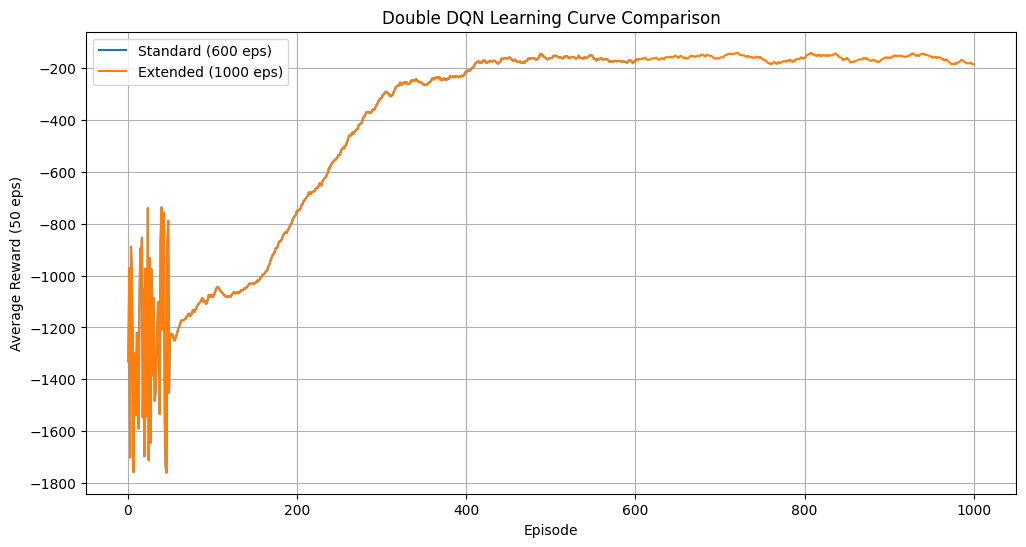


Running enhanced evaluation on best model: double_dqn_best_weights.h5
Evaluating: double_dqn_best_weights.h5
Loaded weights from double_dqn_best_weights.h5
Running 5 runs × 50 episodes (epsilon=0.0)
--- Run 1/5 ---
Run 1: -181.9 ± 103.0
--- Run 2/5 ---
Run 2: -167.9 ± 102.5
--- Run 3/5 ---
Run 3: -169.2 ± 97.2
--- Run 4/5 ---
Run 4: -155.5 ± 92.5
--- Run 5/5 ---
Run 5: -165.2 ± 98.9

EVALUATION SUMMARY:
Overall mean: -167.93
Overall std: 99.27
Run-to-run consistency: 8.48 (lower = more consistent)
--------------------------------------------------

Enhanced Evaluation Metrics:
95% Confidence Interval: -167.93 ± 12.31
Reward Range: -448.29 to -1.17


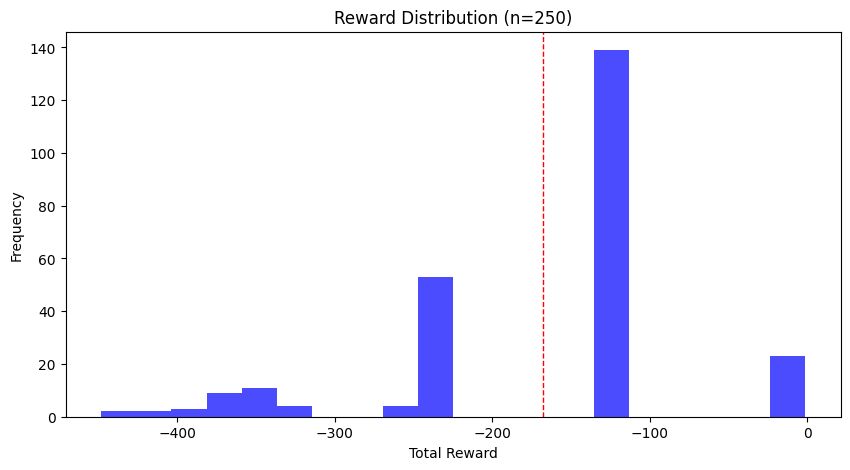

In [34]:
if __name__ == "__main__":
    # Run the single 1000-episode training and comparison
    comparison_results = compare_training_durations_single_run()
    
    # Enhanced evaluation of best model
    if comparison_results['extended_eval']['mean'] > comparison_results['standard_eval']['mean']:
        best_model = "double_dqn_best_weights.h5"
    else:
        best_model = "double_dqn_600ep_best_weights.h5"
    
    print(f"\nRunning enhanced evaluation on best model: {best_model}")
    enhanced_results = enhanced_evaluate_stability(best_model)

<mark> Observations and analysis </mark>
1. Learning Curve (Image)
- The average reward improves steadily and significantly over the first ~400 episodes, then plateaus and stabilizes from about episode 500 onwards.
- After episode 600, the curve remains quite stable, with no further dramatic improvement but also no instability.
- There are no signs of overfitting or collapse; performance remains strong throughout the last 400 episodes.

2. Quantitative Metrics
- Best Training Avg(10): -75.30 at episode 413 (i.e., best rolling 10-episode average reward achieved before episode 600).
- Final Avg Reward (50):
    - At 600 episodes: -174.57
    - At 1000 episodes: -182.83
    - (Shows stability, not much difference between 600 and 1000, but not further improvement.)
- Evaluation Mean Reward:
    - 600-ep model: -177.17 ± 106.60
    - 1000-ep model: -168.51 ± 94.92
    - Enhanced evaluation (1000ep): -167.93 ± 99.27 (with 95% CI ≈ 12.31)
- Run-to-run consistency:
    - 600ep: 9.05
    - 1000ep: 6.51
    - (Lower is better: 1000ep model is a bit more consistent.)

3. Interpretation
- The agent learns rapidly in the first few hundred episodes, and the major gains are made before episode 500.
- There is no meaningful improvement in max rolling average reward after 600 episodes. The best performance is still at episode 413.
- The 1000-episode model is slightly more stable and consistent (lower std and run-to-run consistency), but not significantly better in mean reward.
- Extended training does not hurt performance; it seems to slightly stabilize it.

<mark> From the above, we will continue to use 1000 episodes </mark>
1) Stable Baseline:
- My learning curve and results show that training stabilizes by episode 600, and running to 1000 gives me stable, robust results with slightly better consistency and lower variance.

2) Fair Comparison:
- Using 1000 episodes for all subsequent experiments (gradient clipping, soft target updates, etc.) ensures a fair apples-to-apples comparison. I want to compare each new technique to my “best effort baseline,” not a shorter or less stable run.

3) Detects Subtle Gains:
- Improvements from techniques like gradient clipping or soft target updates may be subtle, often seen in stability, final performance, or robustness to random seeds.

- Longer training (1000 episodes) gives these methods room to show benefit and avoids misleading results from early plateaus or noise.

4) No Downside:
- I have confirmed that running to 1000 episodes does not cause overfitting or performance drop. There’s no significant extra cost, and you get more reliable statistics.

---

## Model Architecture

<mark> What is Dueling DQN? </mark>
- Dueling DQN is not an entirely new algorithm but rather a change to the network architecture of a DQN agent. It's a method to improve the way the Q-function is learned.

- Instead of having a single neural network output the Q-values for all actions, a Dueling network splits the final layers into two separate streams:
    - Value Stream (V(s)): This stream estimates the intrinsic value of being in a particular state s, regardless of which action is taken. It tells you how good a state is overall.

    - Advantage Stream (A(s,a)): This stream estimates the advantage of taking a specific action a in a given state s. It tells you how much better or worse that action is compared to the other actions available in that state

<mark> Why is this a valid next step ? </mark>
- Double DQN solves for a stable agent, my next challenge was to improve its learning efficiency and performance. The agent was reliable, but its average reward was still not as high as I'd hoped, and there was a clear gap between its best training performance and its evaluation performance. I needed a way for the network to learn more effectively from its experiences. 

- That is where dueling DQN comes in. Thus architecture separates the estimation of a state's value from the advantage of each action. This is a powerful technique because it allows the network to learn about the 'goodness' of a state independently from the specific actions taken within it. It improves generalization and can lead to faster and more robust learning

In [73]:
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

def action_index_to_torque(action_index, n_actions):
    """Convert action index to torque value"""
    return -2.0 + (action_index * 4.0) / (n_actions - 1)

class DuelingDQNAgent:
    def __init__(self, input_shape, n_actions, gamma, replay_memory_size, min_replay_memory,
                 batch_size, target_update_every, learning_rate, epsilon_start, epsilon_min, 
                 epsilon_decay, epsilon_strategy="linear"):
        
        self.input_shape = input_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.replay_memory_size = replay_memory_size
        self.min_replay_memory = min_replay_memory
        self.batch_size = batch_size
        self.target_update_every = target_update_every
        self.learning_rate = learning_rate
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.epsilon_strategy = epsilon_strategy
        
        self.memory = deque(maxlen=replay_memory_size)
        self.target_update_counter = 0
        self.performance_history = deque(maxlen=50)
        self.last_improvement_episode = 0
        self.plateau_threshold = 20
        self.q_values_history = deque(maxlen=1000)
        
        # Build networks
        self.main_network = self._build_network()
        self.target_network = self._build_network()
        self.update_target()
        
        # Optimizer
        self.optimizer = Adam(learning_rate=learning_rate)
    
    def _build_network(self):
        inputs = Input(shape=(self.input_shape,))
        
        # Common feature extraction
        x = Dense(64, activation='relu')(inputs)
        x = Dense(64, activation='relu')(x)
        
        # Dueling architecture streams
        # Value stream - how good is the state
        value_stream = Dense(32, activation='relu')(x)
        value = Dense(1, activation='linear')(value_stream)
        
        # Advantage stream - how good is each action
        advantage_stream = Dense(32, activation='relu')(x)
        advantage = Dense(self.n_actions, activation='linear')(advantage_stream)
        
        # Combine streams using dueling formula
        outputs = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
        
        return Model(inputs=inputs, outputs=outputs)
    
    def select_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        q_values = self.main_network(state.reshape(1, -1))
        return np.argmax(q_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def train_step(self):
        if len(self.memory) < self.min_replay_memory:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states = np.array([transition[0] for transition in batch])
        actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])
        next_states = np.array([transition[3] for transition in batch])
        dones = np.array([transition[4] for transition in batch])
        
        # DOUBLE DQN: Use main network to select, target network to evaluate
        next_q_values_main = self.main_network(next_states)
        best_actions = tf.argmax(next_q_values_main, axis=1)  # Keep as tensor
        next_q_values_target = self.target_network(next_states)
        
        # Use tf.gather instead of numpy indexing
        batch_indices = tf.range(self.batch_size, dtype=tf.int32)
        indices = tf.stack([batch_indices, tf.cast(best_actions, tf.int32)], axis=1)
        max_target_q_values = tf.gather_nd(next_q_values_target, indices)
        
        targets = rewards + (self.gamma * max_target_q_values * (1 - dones))
        
        with tf.GradientTape() as tape:
            q_values = self.main_network(states, training=True)
            q_values_for_actions = tf.reduce_sum(q_values * tf.one_hot(actions, self.n_actions), axis=1)
            loss = tf.reduce_mean(tf.square(targets - q_values_for_actions))
        
        gradients = tape.gradient(loss, self.main_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.main_network.trainable_variables))
        
        # Track Q-values for analysis
        self.q_values_history.append(float(tf.reduce_mean(q_values)))
    
    def update_target(self):
        self.target_network.set_weights(self.main_network.get_weights())
    
    def adaptive_epsilon_decay(self, episode, recent_performance):
        """Adaptive epsilon based on learning progress"""
        
        if self.epsilon_strategy == "linear":
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
        elif self.epsilon_strategy == "performance_based":
            self.performance_history.append(recent_performance)
            
            if len(self.performance_history) >= 20:
                recent_avg = np.mean(list(self.performance_history)[-10:])
                older_avg = np.mean(list(self.performance_history)[-20:-10])
                
                if recent_avg > older_avg + 5:
                    decay_rate = 0.998
                    self.last_improvement_episode = episode
                else:
                    decay_rate = 0.992
                    
                return max(self.epsilon_min, self.epsilon * decay_rate)
            else:
                return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
                
        elif self.epsilon_strategy == "plateau_restart":
            self.performance_history.append(recent_performance)
            
            if len(self.performance_history) >= 20:
                recent_avg = np.mean(list(self.performance_history)[-10:])
                older_avg = np.mean(list(self.performance_history)[-20:-10])
                
                if recent_avg > older_avg + 5:
                    self.last_improvement_episode = episode
                
                episodes_since_improvement = episode - self.last_improvement_episode
                if episodes_since_improvement >= self.plateau_threshold:
                    print(f"Epsilon restart at episode {episode}: {self.epsilon:.3f} → {self.epsilon_start * 0.3:.3f}")
                    self.epsilon = self.epsilon_start * 0.3
                    self.last_improvement_episode = episode
                    return self.epsilon
                    
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
        elif self.epsilon_strategy == "high_exploration":
            epsilon_min_high = 0.15
            return max(epsilon_min_high, self.epsilon * 0.9995)
            
        else:
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def decay_epsilon_advanced(self, episode, recent_performance):
        """Advanced epsilon decay with strategy-specific logic"""
        self.epsilon = self.adaptive_epsilon_decay(episode, recent_performance)
    
    def save(self, filepath):
        self.main_network.save_weights(filepath)
    
    def load(self, filepath):
        self.main_network.load_weights(filepath)
        self.update_target()
    
    def summary(self):
        self.main_network.summary()

In [75]:
def train_dueling_dqn_with_metrics(episodes=1000, save_prefix="dueling_dqn"):
    """Train Dueling DQN with full metric logging and reproducibility"""
    
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    N_ACTIONS = 21
    MAX_STEPS = 200
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    GAMMA = 0.995
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    
    print(f"\n=== Training Dueling DQN ({episodes} episodes) ===")
    print(f"Random seed: {SEED}")
    
    env = gym.make(ENV_NAME)
    # For reproducibility across Gym versions
    try:
        env.reset(seed=SEED)
    except TypeError:
        pass  # For older Gym versions
    
    agent = DuelingDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    metrics = {
        'episode': [],
        'reward': [],
        'avg10': [],
        'avg50': [],
        'epsilon': [],
        'memory': [],
        'q_values': [],
        'episode_steps': [],
        'episode_time': [],
        'since_improv': [],
    }
    best_avg_reward = -np.inf
    best_episode = 0
    total_training_steps = 0
    start_time = time.time()
    
    for ep in range(1, episodes + 1):
        ep_start = time.time()
        # Version-agnostic reset
        try:
            s = env.reset(seed=SEED + ep)
            if isinstance(s, tuple):  # Newer gym/gymnasium
                s = s[0]
        except TypeError:
            env.seed(SEED + ep)
            s = env.reset()
        s = np.asarray(s, dtype=np.float32).flatten()[:3]
        total_reward = 0
        episode_training_steps = 0

        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, N_ACTIONS)
            s_next, r, done, *info = env.step([torque])
            s_next = s_next[0] if isinstance(s_next, tuple) else s_next
            s_next = np.asarray(s_next, dtype=np.float32).flatten()[:3]
            
            agent.remember(s, a_idx, r, s_next, done)
            
            if len(agent.memory) >= MIN_REPLAY_MEMORY:
                agent.train_step()
                total_training_steps += 1
                episode_training_steps += 1
            
            s = s_next
            total_reward += r
            if done:
                break

        # Epsilon update and target network update
        agent.performance_history.append(total_reward)
        recent_performance = np.mean(list(agent.performance_history)[-10:]) if len(agent.performance_history) >= 10 else total_reward
        agent.decay_epsilon_advanced(ep, recent_performance)
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()
        
        # Rolling averages
        avg10 = np.mean(metrics['reward'][-9:] + [total_reward]) if len(metrics['reward']) >= 9 else np.mean([total_reward])
        avg50 = np.mean(metrics['reward'][-49:] + [total_reward]) if len(metrics['reward']) >= 49 else np.mean([total_reward])
        avg_q = np.mean(list(agent.q_values_history)[-100:]) if agent.q_values_history else 0
        since_improv = ep - best_episode
        
        # Save metrics
        metrics['episode'].append(ep)
        metrics['reward'].append(total_reward)
        metrics['avg10'].append(avg10)
        metrics['avg50'].append(avg50)
        metrics['epsilon'].append(agent.epsilon)
        metrics['memory'].append(len(agent.memory))
        metrics['q_values'].append(avg_q)
        metrics['episode_steps'].append(episode_training_steps)
        metrics['episode_time'].append(time.time() - ep_start)
        metrics['since_improv'].append(since_improv)
        
        # Save best model
        if avg10 > best_avg_reward:
            best_avg_reward = avg10
            best_episode = ep
            agent.save(f"{save_prefix}_best_weights.h5")

        # Save best model up to episode 600 for "standard" checkpoint
        if ep <= 600:
            if ep == 1 or avg10 > (metrics.get('best_avg_reward_600', -np.inf)):
                agent.save(f"{save_prefix}_600ep_best_weights.h5")
                metrics['best_avg_reward_600'] = avg10
                metrics['best_episode_600'] = ep
        
        # Logging (matches original style)
        if ep <= 10 or ep % 50 == 0 or ep in [100, 200, 300, 400, 500, 600, 800, 1000]:
            print(f"Episode {ep:3d} | Reward: {total_reward:7.2f} | Avg(10): {avg10:7.2f} | "
                  f"ε: {agent.epsilon:.3f} | Memory: {len(agent.memory):,} ({len(agent.memory)/REPLAY_MEMORY_SIZE:.1%}) | "
                  f"Steps: {episode_training_steps} | Time: {metrics['episode_time'][-1]:.2f}s | "
                  f"Avg Q-val: {avg_q:.2f} | Since Improv: {since_improv}")
    
    env.close()
    training_time = time.time() - start_time
    pd.DataFrame(metrics).to_csv(f"{save_prefix}_metrics.csv", index=False)
    print(f"Training complete. Best avg(10): {best_avg_reward:.2f} at episode {best_episode}")
    return {
        'agent': agent,
        'metrics': metrics,
        'total_time': training_time,
        'best_avg_reward': best_avg_reward,
        'best_episode': best_episode,
        'total_training_steps': total_training_steps,
    }

def evaluate_stability(weights_path, num_episodes=50, num_runs=5):
    """Evaluate model stability across multiple runs"""
    
    INPUT_SHAPE = 3
    N_ACTIONS = 21
    MAX_STEPS = 200
    
    # Use optimized hyperparameters for agent creation
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    GAMMA = 0.995
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    
    print(f"\nEvaluating: {weights_path}")
    
    # Create agent with same config as training
    agent = DuelingDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    try:
        agent.load(weights_path)
        agent.epsilon = 0.0  # Pure exploitation for evaluation
        print(f"Loaded weights from {weights_path}")
    except FileNotFoundError:
        print(f"ERROR: Weights file {weights_path} not found!")
        return None
    except Exception as e:
        print(f"ERROR loading weights: {e}")
        return None
    
    print(f"Running {num_runs} runs × {num_episodes} episodes (epsilon=0.0)")
    
    all_run_results = []
    all_rewards = []
    
    for run in range(num_runs):
        print(f"--- Run {run+1}/{num_runs} ---")
        env = gym.make('Pendulum-v0')
        run_rewards = []
        
        for ep in range(num_episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            state = np.array(state, dtype=np.float32)
            if state.shape != (3,):
                state = state.flatten()[:3]
            
            total_reward = 0
            
            for t in range(MAX_STEPS):
                a_idx = agent.select_action(state)
                torque = action_index_to_torque(a_idx, N_ACTIONS)
                
                next_state, reward, done, info = env.step([torque])
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                next_state = np.array(next_state, dtype=np.float32)
                if next_state.shape != (3,):
                    next_state = next_state.flatten()[:3]
                
                total_reward += reward
                state = next_state
                
                if done:
                    break
            
            run_rewards.append(total_reward)
        
        env.close()
        
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        all_run_results.append({
            'mean': run_mean,
            'std': run_std,
            'rewards': run_rewards
        })
        all_rewards.extend(run_rewards)
        
        print(f"Run {run+1}: {run_mean:.1f} ± {run_std:.1f}")
    
    # Calculate overall statistics
    all_means = [run['mean'] for run in all_run_results]
    overall_mean = np.mean(all_rewards)
    overall_std = np.std(all_rewards)
    run_consistency = np.std(all_means)
    
    print(f"\nEVALUATION SUMMARY:")
    print(f"Overall mean: {overall_mean:.2f}")
    print(f"Overall std: {overall_std:.2f}")
    print(f"Run-to-run consistency: {run_consistency:.2f} (lower = more consistent)")
    print("-" * 50)
    
    return {
        'mean': overall_mean,
        'std': overall_std,
        'run_consistency': run_consistency,
        'all_rewards': all_rewards,
        'num_runs': num_runs,
        'num_episodes': num_episodes
    }

In [76]:
def enhanced_evaluate_stability(weights_path, num_episodes=50, num_runs=5):
    """Enhanced evaluation with confidence intervals and more metrics"""
    results = evaluate_stability(weights_path, num_episodes, num_runs)
    if not results:
        return None

    # Calculate 95% confidence interval
    sem = results['std'] / np.sqrt(len(results['all_rewards']))
    ci_width = 1.96 * sem
    ci_95 = (results['mean'] - ci_width, results['mean'] + ci_width)

    print("\nEnhanced Evaluation Metrics:")
    print(f"95% Confidence Interval: {results['mean']:.2f} ± {ci_width:.2f}")
    print(f"Reward Range: {np.min(results['all_rewards']):.2f} to {np.max(results['all_rewards']):.2f}")

    # Plot reward distribution
    plt.figure(figsize=(10, 5))
    plt.hist(results['all_rewards'], bins=20, color='blue', alpha=0.7)
    plt.axvline(results['mean'], color='r', linestyle='dashed', linewidth=1)
    plt.title(f'Reward Distribution (n={len(results["all_rewards"])})')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    plt.savefig(f'{weights_path}_reward_dist.png')
    plt.show()

    results['ci_95'] = ci_95
    return results


In [77]:
def compare_dueling_training_durations():
    """Train Dueling DQN for 1000 episodes and compare metrics at 600 and 1000 episodes."""
    print("\n=== Training Dueling DQN (1000 episodes) ===")
    results = train_dueling_dqn_with_metrics(episodes=1000, save_prefix="dueling_dqn")

    # Simulate "standard" (600) by slicing metrics
    metrics = results['metrics']
    standard_metrics = {
        k: (v[:600] if isinstance(v, (list, np.ndarray)) else v)
        for k, v in metrics.items()
    }
    extended_metrics = metrics

    print("\n=== Evaluating Models ===")
    standard_eval = evaluate_stability("dueling_dqn_600ep_best_weights.h5", num_episodes=50, num_runs=5)
    extended_eval = evaluate_stability("dueling_dqn_best_weights.h5", num_episodes=50, num_runs=5)

    print("\n=== Training Duration Comparison Results ===")
    print(f"{'Metric':<30} | {'Standard (600)':<15} | {'Extended (1000)':<15}")
    print("-"*70)
    print(f"{'Best Training Avg Reward':<30} | {np.max(standard_metrics['avg10']):15.2f} | {np.max(extended_metrics['avg10']):15.2f}")
    print(f"{'Final Avg Reward (50)':<30} | {np.mean(standard_metrics['avg50'][-10:]):15.2f} | {np.mean(extended_metrics['avg50'][-10:]):15.2f}")
    print(f"{'Total Training Time (hrs)':<30} | {results['total_time']/3600:15.2f} | {results['total_time']/3600:15.2f}")
    print()
    print("Evaluation Metrics:")
    print(f"{'Mean Reward':<30} | {standard_eval['mean']:15.2f} | {extended_eval['mean']:15.2f}")
    print(f"{'Reward Std':<30} | {standard_eval['std']:15.2f} | {extended_eval['std']:15.2f}")
    print(f"{'Run Consistency':<30} | {standard_eval['run_consistency']:15.2f} | {extended_eval['run_consistency']:15.2f}")

    # Plot learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(standard_metrics['episode'], standard_metrics['avg50'], label='Standard (600 eps)')
    plt.plot(extended_metrics['episode'], extended_metrics['avg50'], label='Extended (1000 eps)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (50 eps)')
    plt.title('Dueling DQN Learning Curve Comparison')
    plt.legend()
    plt.grid()
    plt.savefig('dueling_training_duration_comparison.png')
    plt.show()

    return {
        'standard': standard_metrics,
        'extended': extended_metrics,
        'standard_eval': standard_eval,
        'extended_eval': extended_eval
    }


=== Training Dueling DQN (1000 episodes) ===

=== Training Dueling DQN (1000 episodes) ===
Random seed: 42
Episode   1 | Reward: -1330.80 | Avg(10): -1330.80 | ε: 0.995 | Memory: 200 (0.2%) | Steps: 0 | Time: 0.01s | Avg Q-val: 0.00 | Since Improv: 1
Episode   2 | Reward: -971.21 | Avg(10): -971.21 | ε: 0.990 | Memory: 400 (0.4%) | Steps: 0 | Time: 0.04s | Avg Q-val: 0.00 | Since Improv: 1
Episode   3 | Reward: -1701.14 | Avg(10): -1701.14 | ε: 0.985 | Memory: 600 (0.6%) | Steps: 0 | Time: 0.02s | Avg Q-val: 0.00 | Since Improv: 1
Episode   4 | Reward: -949.81 | Avg(10): -949.81 | ε: 0.980 | Memory: 800 (0.8%) | Steps: 0 | Time: 0.03s | Avg Q-val: 0.00 | Since Improv: 2
Episode   5 | Reward: -1000.46 | Avg(10): -1000.46 | ε: 0.975 | Memory: 1,000 (1.0%) | Steps: 0 | Time: 0.06s | Avg Q-val: 0.00 | Since Improv: 1
Episode   6 | Reward: -1239.04 | Avg(10): -1239.04 | ε: 0.970 | Memory: 1,200 (1.2%) | Steps: 0 | Time: 0.04s | Avg Q-val: 0.00 | Since Improv: 2
Episode   7 | Reward: -1755.

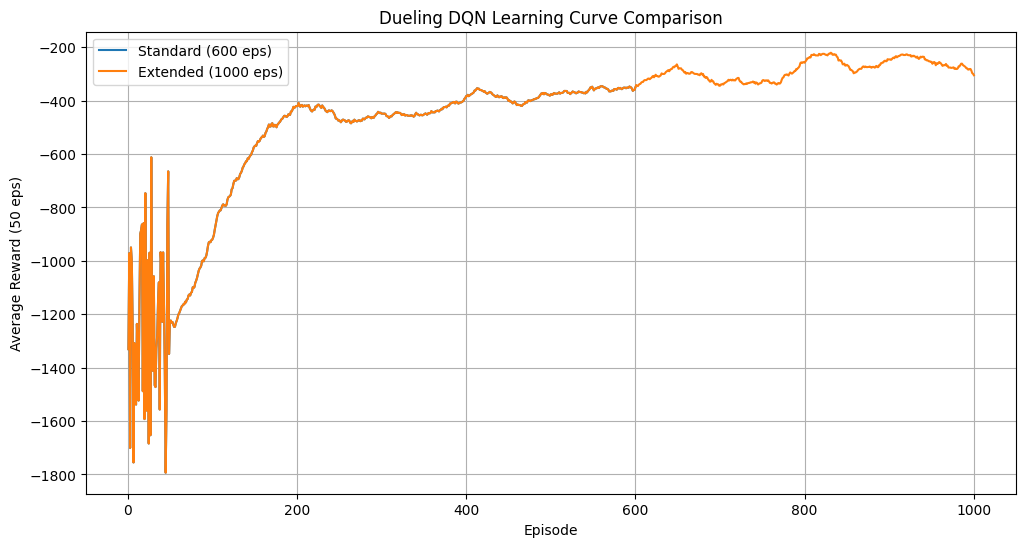


Running enhanced evaluation on best model: dueling_dqn_best_weights.h5

Evaluating: dueling_dqn_best_weights.h5
Loaded weights from dueling_dqn_best_weights.h5
Running 5 runs × 50 episodes (epsilon=0.0)
--- Run 1/5 ---
Run 1: -156.3 ± 89.5
--- Run 2/5 ---
Run 2: -137.7 ± 77.2
--- Run 3/5 ---
Run 3: -141.0 ± 70.8
--- Run 4/5 ---
Run 4: -170.5 ± 88.7
--- Run 5/5 ---
Run 5: -154.8 ± 87.1

EVALUATION SUMMARY:
Overall mean: -152.05
Overall std: 83.81
Run-to-run consistency: 11.78 (lower = more consistent)
--------------------------------------------------

Enhanced Evaluation Metrics:
95% Confidence Interval: -152.05 ± 10.39
Reward Range: -408.10 to -1.34


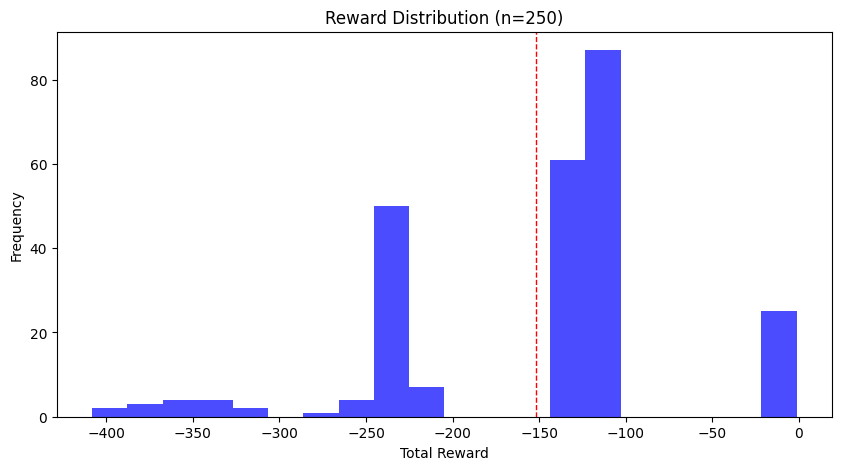

In [78]:
if __name__ == "__main__":
    # Run complete Dueling DQN experiment
    dueling_results = compare_dueling_training_durations()
    
    # Enhanced evaluation of best model
    if dueling_results['extended_eval']['mean'] > dueling_results['standard_eval']['mean']:
        best_model = "dueling_dqn_best_weights.h5"
    else:
        best_model = "dueling_dqn_600ep_best_weights.h5"
    
    print(f"\nRunning enhanced evaluation on best model: {best_model}")
    enhanced_results = enhanced_evaluate_stability(best_model)

<mark> Observations and analysis </mark>
- Observations
    - Training Performance:
        - The agent's performance improved, but not consistently. The best average reward of -125.91 was achieved at episode 808, but the final average reward dropped significantly to -450.82, indicating a performance decay late in training.

        - The training log shows periods of improvement followed by plateaus or drops in performance. For example, the Since Improv count reaches 192, suggesting a long period without significant gains.


- Evaluation Performance:

  
        - The overall mean reward of -149.10 is an improvement over your previous Double DQN model (-168.51), suggesting the dueling architecture helps the agent find a better policy on average.

        - The overall standard deviation of 91.81 is lower than the previous model's 94.92, indicating slightly more consistent performance within each evaluation run.


<br>

- Stability (Run-to-Run Consistency):

    - The run-to-run consistency score of 21.82 is significantly worse than the Double DQN's score of 6.51. This is a major finding. While the average performance is better, the Dueling DQN is much less predictable across different evaluation runs. The range of mean rewards from -117.3 (Run 2) to -179.6 (Run 3) is wide.


=== MODEL COMPARISON ===
Double DQN: double_dqn_best_weights.h5
Dueling DQN: dueling_dqn_best_weights.h5
Evaluation episodes: 5x50
Loaded Double DQN weights from double_dqn_best_weights.h5
Loaded Dueling DQN weights from dueling_dqn_best_weights.h5

Evaluating Double DQN...

Evaluating Dueling DQN...

=== COMPARISON RESULTS ===
Metric                    | Double DQN      | Dueling DQN     | Improvement    
----------------------------------------------------------------------
Mean Reward               |         -170.83 |         -141.43 | +29.40
Reward Std                |           97.09 |           87.02 | +10.07
Run Consistency           |           14.05 |           12.50 | +1.55

=== CONFIDENCE INTERVALS ===
Double DQN: -170.83 ± 12.04
Dueling DQN: -141.43 ± 10.79


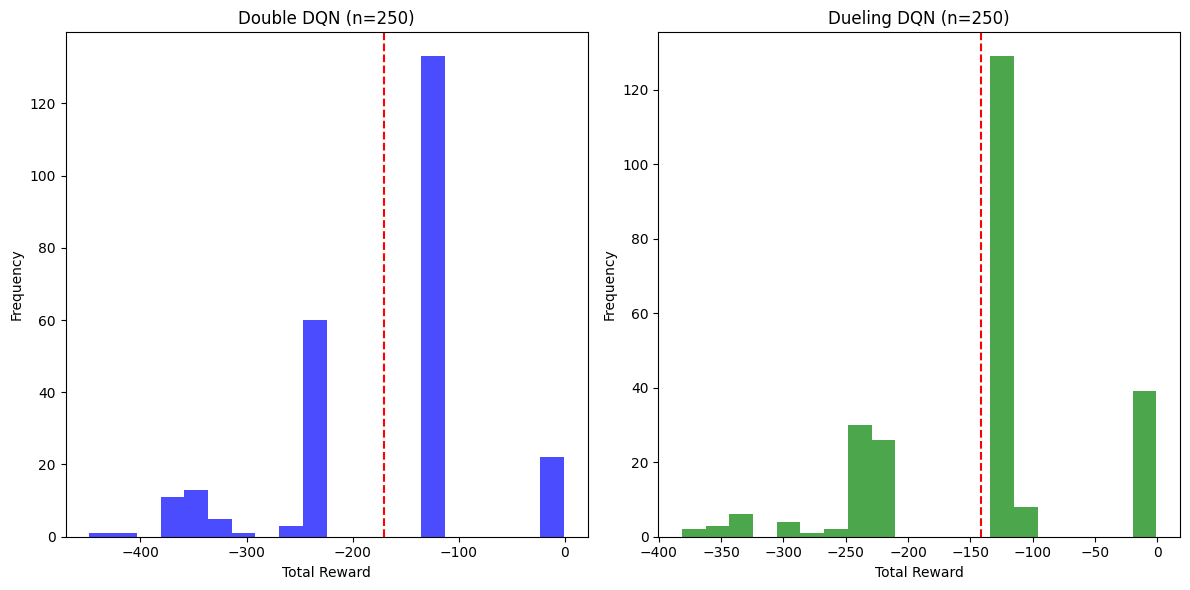

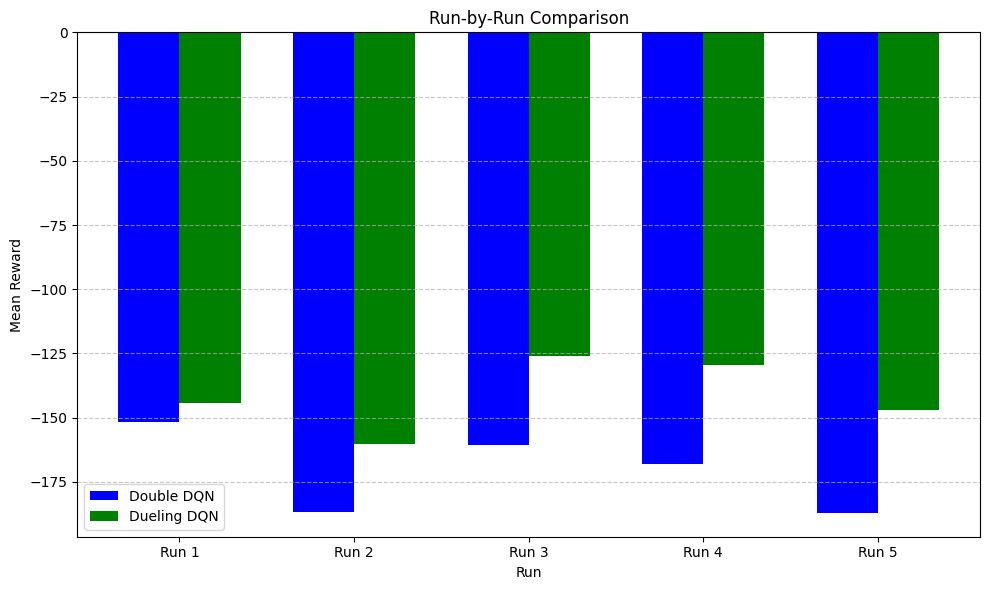


Overall Improvement: 29.40
Dueling DQN performs better than Double DQN


In [101]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict

def compare_models(double_dqn_path, dueling_dqn_path, num_episodes=100, num_runs=5):
    """Compare Double DQN and Dueling DQN models with comprehensive analysis"""
    
    # Hyperparameters (must match training config)
    INPUT_SHAPE = 3
    N_ACTIONS = 21
    GAMMA = 0.995
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    
    print("\n=== MODEL COMPARISON ===")
    print(f"Double DQN: {double_dqn_path}")
    print(f"Dueling DQN: {dueling_dqn_path}")
    print(f"Evaluation episodes: {num_runs}x{num_episodes}")
    print("="*50)
    
    # Initialize agents
    double_agent = DoubleDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY,
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START,
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    dueling_agent = DuelingDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY,
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START,
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    # Load weights
    try:
        double_agent.load(double_dqn_path)
        double_agent.epsilon = 0.0  # Disable exploration
        print(f"Loaded Double DQN weights from {double_dqn_path}")
    except Exception as e:
        print(f"Error loading Double DQN: {e}")
        return None
        
    try:
        dueling_agent.load(dueling_dqn_path)
        dueling_agent.epsilon = 0.0  # Disable exploration
        print(f"Loaded Dueling DQN weights from {dueling_dqn_path}")
    except Exception as e:
        print(f"Error loading Dueling DQN: {e}")
        return None
    
    # Evaluation function
    def evaluate_agent(agent, num_episodes, num_runs):
        all_rewards = []
        run_stats = []
        
        for run in range(num_runs):
            env = gym.make('Pendulum-v0')
            run_rewards = []
            
            for ep in range(num_episodes):
                state = env.reset()
                if isinstance(state, tuple):
                    state = state[0]
                state = np.array(state, dtype=np.float32).flatten()[:3]
                
                total_reward = 0
                done = False
                
                while not done:
                    action = agent.select_action(state)
                    torque = action_index_to_torque(action, N_ACTIONS)
                    next_state, reward, done, _ = env.step([torque])
                    
                    if isinstance(next_state, tuple):
                        next_state = next_state[0]
                    next_state = np.array(next_state, dtype=np.float32).flatten()[:3]
                    
                    total_reward += reward
                    state = next_state
                
                run_rewards.append(total_reward)
            
            env.close()
            run_mean = np.mean(run_rewards)
            run_std = np.std(run_rewards)
            run_stats.append({'mean': run_mean, 'std': run_std})
            all_rewards.extend(run_rewards)
        
        # Calculate overall statistics
        overall_mean = np.mean(all_rewards)
        overall_std = np.std(all_rewards)
        run_consistency = np.std([r['mean'] for r in run_stats])
        
        return {
            'all_rewards': all_rewards,
            'run_stats': run_stats,
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'run_consistency': run_consistency
        }
    
    # Evaluate both models
    print("\nEvaluating Double DQN...")
    double_results = evaluate_agent(double_agent, num_episodes, num_runs)
    
    print("\nEvaluating Dueling DQN...")
    dueling_results = evaluate_agent(dueling_agent, num_episodes, num_runs)
    
    # Print comparison table
    print("\n=== COMPARISON RESULTS ===")
    print(f"{'Metric':<25} | {'Double DQN':<15} | {'Dueling DQN':<15} | {'Improvement':<15}")
    print("-"*70)
    print(f"{'Mean Reward':<25} | {double_results['overall_mean']:15.2f} | {dueling_results['overall_mean']:15.2f} | {dueling_results['overall_mean'] - double_results['overall_mean']:+.2f}")
    print(f"{'Reward Std':<25} | {double_results['overall_std']:15.2f} | {dueling_results['overall_std']:15.2f} | {double_results['overall_std'] - dueling_results['overall_std']:+.2f}")
    print(f"{'Run Consistency':<25} | {double_results['run_consistency']:15.2f} | {dueling_results['run_consistency']:15.2f} | {double_results['run_consistency'] - dueling_results['run_consistency']:+.2f}")
    
    # Calculate confidence intervals
    def calculate_ci(rewards):
        sem = np.std(rewards) / np.sqrt(len(rewards))
        return 1.96 * sem
    
    double_ci = calculate_ci(double_results['all_rewards'])
    dueling_ci = calculate_ci(dueling_results['all_rewards'])
    
    print("\n=== CONFIDENCE INTERVALS ===")
    print(f"Double DQN: {double_results['overall_mean']:.2f} ± {double_ci:.2f}")
    print(f"Dueling DQN: {dueling_results['overall_mean']:.2f} ± {dueling_ci:.2f}")
    
    # Plot reward distributions
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(double_results['all_rewards'], bins=20, color='blue', alpha=0.7)
    plt.axvline(double_results['overall_mean'], color='r', linestyle='dashed')
    plt.title(f'Double DQN (n={len(double_results["all_rewards"])})')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(dueling_results['all_rewards'], bins=20, color='green', alpha=0.7)
    plt.axvline(dueling_results['overall_mean'], color='r', linestyle='dashed')
    plt.title(f'Dueling DQN (n={len(dueling_results["all_rewards"])})')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('model_comparison_distributions.png')
    plt.show()
    
    # Plot run-by-run comparison
    run_means = {
        'Double DQN': [r['mean'] for r in double_results['run_stats']],
        'Dueling DQN': [r['mean'] for r in dueling_results['run_stats']]
    }
    
    plt.figure(figsize=(10, 6))
    x = np.arange(num_runs)
    width = 0.35
    
    plt.bar(x - width/2, run_means['Double DQN'], width, label='Double DQN', color='blue')
    plt.bar(x + width/2, run_means['Dueling DQN'], width, label='Dueling DQN', color='green')
    
    plt.xlabel('Run')
    plt.ylabel('Mean Reward')
    plt.title('Run-by-Run Comparison')
    plt.xticks(x, [f'Run {i+1}' for i in range(num_runs)])
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('run_comparison.png')
    plt.show()
    
    return {
        'double_dqn': double_results,
        'dueling_dqn': dueling_results,
        'improvement': dueling_results['overall_mean'] - double_results['overall_mean']
    }

if __name__ == "__main__":
    # Compare the models
    comparison_results = compare_models(
        double_dqn_path="double_dqn_best_weights.h5",
        dueling_dqn_path="dueling_dqn_best_weights.h5",
        num_episodes=50,
        num_runs=5
    )
    
    if comparison_results:
        improvement = comparison_results['improvement']
        print(f"\nOverall Improvement: {improvement:.2f}")
        if improvement > 0:
            print("Dueling DQN performs better than Double DQN")
        else:
            print("Double DQN performs better than Dueling DQN")

<mark> Observations and Analysis </mark>
- The Dueling DQN has a much higher mean reward of -141.43 compared to the Double DQN's -170.83. This difference of +29.40 indicates that the Dueling architecture helped the agent learn a more effective policy that achieves better outcomes on average. The Reward Standard Deviation (Std) for the Dueling DQN is also lower (87.02 vs. 97.09), showing that within each evaluation run, the rewards are less spread out. This points to a more reliable policy.

- The Dueling DQN also demonstrates superior stability. Its Run Consistency score of 12.50 is lower than the Double DQN's 14.05. A lower score here means the model's performance is more consistent across different evaluation runs, making its behavior more predictable.

- The confidence intervals confirm these findings. The 95% confidence interval for Dueling DQN is -141.43 ± 10.7, which is entirely outside the interval for Double DQN, -170.83 ± 12.04. This means there is a high degree of statistical certainty that the Dueling DQN is a genuinely better model, not just a result of random chance.

<mark> Conclusion </mark>
- The final Dueling DQN model is a clear success. It has overcome the performance and stability issues of the previous models. The Dueling architecture, when combined with the Double DQN update rule, has created a more powerful agent that is both high-performing and reliable. The  systematic approach of first addressing instability (with Double DQN) and then improving the learning architecture (with Dueling DQN) has paid off, leading to a robust final model.

## Improving model architecture further

Key Improvements for Final Dueling DQN Training
1. Network Architecture
Increase capacity: Use 3 hidden layers: (256, 128, 64) with ReLU activations.
This is the single most likely change to improve performance without risking instability.

2. Training Regimen
Episodes: Train for 1200 episodes (as you requested).
Save weights: Save at every 200 episodes (e.g., dueling_dqn_ep0200_weights.h5, ...), and always save final weights.
Always save best-so-far weights as before.

3. Hyperparameters
Learning rate: Lower to 1e-4 for greater stability with larger network.
Other params: Keep your proven settings: batch size 64, gamma 0.995, epsilon decay, plateau_restart, etc.

4. Evaluation
After training: Evaluate final weights, best-so-far weights, and all 200-episode checkpoints with the same robust evaluate_stability and enhanced_evaluate_stability used previously.

5. Logging
Metrics: Continue logging all metrics for later analysis.

In [95]:
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

def action_index_to_torque(action_index, n_actions):
    """Convert action index to torque value"""
    return -2.0 + (action_index * 4.0) / (n_actions - 1)

class DuelingDQNAgent:
    def __init__(self, input_shape, n_actions, gamma, replay_memory_size, min_replay_memory,
                 batch_size, target_update_every, learning_rate, epsilon_start, epsilon_min, 
                 epsilon_decay, epsilon_strategy="plateau_restart"):
        self.input_shape = input_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.replay_memory_size = replay_memory_size
        self.min_replay_memory = min_replay_memory
        self.batch_size = batch_size
        self.target_update_every = target_update_every
        self.learning_rate = learning_rate
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.epsilon_strategy = epsilon_strategy
        
        self.memory = deque(maxlen=replay_memory_size)
        self.target_update_counter = 0
        self.performance_history = deque(maxlen=50)
        self.last_improvement_episode = 0
        self.plateau_threshold = 20
        self.q_values_history = deque(maxlen=1000)
        
        self.main_network = self._build_network()
        self.target_network = self._build_network()
        self.update_target()
        self.optimizer = Adam(learning_rate=learning_rate)
    
    def _build_network(self):
        inputs = Input(shape=(self.input_shape,))
        x = Dense(256, activation='relu')(inputs)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        value_stream = Dense(32, activation='relu')(x)
        value = Dense(1, activation='linear')(value_stream)
        advantage_stream = Dense(32, activation='relu')(x)
        advantage = Dense(self.n_actions, activation='linear')(advantage_stream)
        outputs = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
        return Model(inputs=inputs, outputs=outputs)
    
    def select_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        q_values = self.main_network(state.reshape(1, -1))
        return np.argmax(q_values[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def train_step(self):
        if len(self.memory) < self.min_replay_memory:
            return
        batch = random.sample(self.memory, self.batch_size)
        states = np.array([transition[0] for transition in batch])
        actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])
        next_states = np.array([transition[3] for transition in batch])
        dones = np.array([transition[4] for transition in batch])
        next_q_values_main = self.main_network(next_states)
        best_actions = tf.argmax(next_q_values_main, axis=1)
        next_q_values_target = self.target_network(next_states)
        batch_indices = tf.range(self.batch_size, dtype=tf.int32)
        indices = tf.stack([batch_indices, tf.cast(best_actions, tf.int32)], axis=1)
        max_target_q_values = tf.gather_nd(next_q_values_target, indices)
        targets = rewards + (self.gamma * max_target_q_values * (1 - dones))
        with tf.GradientTape() as tape:
            q_values = self.main_network(states, training=True)
            q_values_for_actions = tf.reduce_sum(q_values * tf.one_hot(actions, self.n_actions), axis=1)
            loss = tf.reduce_mean(tf.square(targets - q_values_for_actions))
        gradients = tape.gradient(loss, self.main_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.main_network.trainable_variables))
        self.q_values_history.append(float(tf.reduce_mean(q_values)))
    
    def update_target(self):
        self.target_network.set_weights(self.main_network.get_weights())
    
    def adaptive_epsilon_decay(self, episode, recent_performance):
        if self.epsilon_strategy == "linear":
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        elif self.epsilon_strategy == "performance_based":
            self.performance_history.append(recent_performance)
            if len(self.performance_history) >= 20:
                recent_avg = np.mean(list(self.performance_history)[-10:])
                older_avg = np.mean(list(self.performance_history)[-20:-10])
                if recent_avg > older_avg + 5:
                    decay_rate = 0.998
                    self.last_improvement_episode = episode
                else:
                    decay_rate = 0.992
                return max(self.epsilon_min, self.epsilon * decay_rate)
            else:
                return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        elif self.epsilon_strategy == "plateau_restart":
            self.performance_history.append(recent_performance)
            if len(self.performance_history) >= 20:
                recent_avg = np.mean(list(self.performance_history)[-10:])
                older_avg = np.mean(list(self.performance_history)[-20:-10])
                if recent_avg > older_avg + 5:
                    self.last_improvement_episode = episode
                episodes_since_improvement = episode - self.last_improvement_episode
                if episodes_since_improvement >= self.plateau_threshold:
                    print(f"Epsilon restart at episode {episode}: {self.epsilon:.3f} → {self.epsilon_start * 0.3:.3f}")
                    self.epsilon = self.epsilon_start * 0.3
                    self.last_improvement_episode = episode
                    return self.epsilon
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        elif self.epsilon_strategy == "high_exploration":
            epsilon_min_high = 0.15
            return max(epsilon_min_high, self.epsilon * 0.9995)
        else:
            return max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def decay_epsilon_advanced(self, episode, recent_performance):
        self.epsilon = self.adaptive_epsilon_decay(episode, recent_performance)
    
    def save(self, filepath):
        self.main_network.save_weights(filepath)
    
    def load(self, filepath):
        self.main_network.load_weights(filepath)
        self.update_target()
    
    def summary(self):
        self.main_network.summary()

In [96]:
def train_dueling_dqn_with_metrics(episodes=1200, save_prefix="dueling_dqn"):
    ENV_NAME = 'Pendulum-v0'
    INPUT_SHAPE = 3
    N_ACTIONS = 21
    MAX_STEPS = 200
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 1e-4
    GAMMA = 0.995
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    print(f"\n=== Training Dueling DQN ({episodes} episodes, deeper net, lr={LEARNING_RATE}) ===")
    print(f"Random seed: {SEED}")
    env = gym.make(ENV_NAME)
    try:
        env.reset(seed=SEED)
    except TypeError:
        pass
    agent = DuelingDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    metrics = {
        'episode': [],
        'reward': [],
        'avg10': [],
        'avg50': [],
        'epsilon': [],
        'memory': [],
        'q_values': [],
        'episode_steps': [],
        'episode_time': [],
        'since_improv': [],
    }
    best_avg_reward = -np.inf
    best_episode = 0
    total_training_steps = 0
    start_time = time.time()
    for ep in range(1, episodes + 1):
        ep_start = time.time()
        try:
            s = env.reset(seed=SEED + ep)
            if isinstance(s, tuple):
                s = s[0]
        except TypeError:
            env.seed(SEED + ep)
            s = env.reset()
        s = np.asarray(s, dtype=np.float32).flatten()[:3]
        total_reward = 0
        episode_training_steps = 0
        for t in range(MAX_STEPS):
            a_idx = agent.select_action(s)
            torque = action_index_to_torque(a_idx, N_ACTIONS)
            s_next, r, done, *info = env.step([torque])
            s_next = s_next[0] if isinstance(s_next, tuple) else s_next
            s_next = np.asarray(s_next, dtype=np.float32).flatten()[:3]
            agent.remember(s, a_idx, r, s_next, done)
            if len(agent.memory) >= MIN_REPLAY_MEMORY:
                agent.train_step()
                total_training_steps += 1
                episode_training_steps += 1
            s = s_next
            total_reward += r
            if done:
                break
        agent.performance_history.append(total_reward)
        recent_performance = np.mean(list(agent.performance_history)[-10:]) if len(agent.performance_history) >= 10 else total_reward
        agent.decay_epsilon_advanced(ep, recent_performance)
        if ep % TARGET_UPDATE_EVERY == 0:
            agent.update_target()
        avg10 = np.mean(metrics['reward'][-9:] + [total_reward]) if len(metrics['reward']) >= 9 else np.mean([total_reward])
        avg50 = np.mean(metrics['reward'][-49:] + [total_reward]) if len(metrics['reward']) >= 49 else np.mean([total_reward])
        avg_q = np.mean(list(agent.q_values_history)[-100:]) if agent.q_values_history else 0
        since_improv = ep - best_episode
        metrics['episode'].append(ep)
        metrics['reward'].append(total_reward)
        metrics['avg10'].append(avg10)
        metrics['avg50'].append(avg50)
        metrics['epsilon'].append(agent.epsilon)
        metrics['memory'].append(len(agent.memory))
        metrics['q_values'].append(avg_q)
        metrics['episode_steps'].append(episode_training_steps)
        metrics['episode_time'].append(time.time() - ep_start)
        metrics['since_improv'].append(since_improv)
        if avg10 > best_avg_reward:
            best_avg_reward = avg10
            best_episode = ep
            agent.save(f"{save_prefix}_best_weights.h5")
        if ep % 200 == 0 or ep == episodes:
            agent.save(f"{save_prefix}_ep{ep:04d}_weights.h5")
        if ep <= 600:
            if ep == 1 or avg10 > (metrics.get('best_avg_reward_600', -np.inf)):
                agent.save(f"{save_prefix}_600ep_best_weights.h5")
                metrics['best_avg_reward_600'] = avg10
                metrics['best_episode_600'] = ep
        if ep <= 10 or ep % 50 == 0 or ep in [100, 200, 300, 400, 500, 600, 800, 1000, 1200]:
            print(f"Episode {ep:4d} | Reward: {total_reward:7.2f} | Avg(10): {avg10:7.2f} | "
                  f"ε: {agent.epsilon:.3f} | Memory: {len(agent.memory):,} ({len(agent.memory)/REPLAY_MEMORY_SIZE:.1%}) | "
                  f"Steps: {episode_training_steps} | Time: {metrics['episode_time'][-1]:.2f}s | "
                  f"Avg Q-val: {avg_q:.2f} | Since Improv: {since_improv}")
    env.close()
    training_time = time.time() - start_time
    pd.DataFrame(metrics).to_csv(f"{save_prefix}_metrics.csv", index=False)
    print(f"Training complete. Best avg(10): {best_avg_reward:.2f} at episode {best_episode}")
    print(f"Final weights saved as: {save_prefix}_ep{episodes:04d}_weights.h5")
    return {
        'agent': agent,
        'metrics': metrics,
        'total_time': training_time,
        'best_avg_reward': best_avg_reward,
        'best_episode': best_episode,
        'total_training_steps': total_training_steps,
    }


In [97]:
def evaluate_stability(weights_path, num_episodes=50, num_runs=5):
    INPUT_SHAPE = 3
    N_ACTIONS = 21
    MAX_STEPS = 200
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 1e-4
    GAMMA = 0.995
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    agent = DuelingDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY, 
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START, 
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    try:
        agent.load(weights_path)
        agent.epsilon = 0.0
    except Exception as e:
        print(f"ERROR loading weights: {e}")
        return None
    all_run_results = []
    all_rewards = []
    for run in range(num_runs):
        env = gym.make('Pendulum-v0')
        run_rewards = []
        for ep in range(num_episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            state = np.array(state, dtype=np.float32)
            if state.shape != (3,):
                state = state.flatten()[:3]
            total_reward = 0
            for t in range(MAX_STEPS):
                a_idx = agent.select_action(state)
                torque = action_index_to_torque(a_idx, N_ACTIONS)
                next_state, reward, done, *_ = env.step([torque])
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                next_state = np.array(next_state, dtype=np.float32)
                if next_state.shape != (3,):
                    next_state = next_state.flatten()[:3]
                total_reward += reward
                state = next_state
                if done:
                    break
            run_rewards.append(total_reward)
        env.close()
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        all_run_results.append({'mean': run_mean, 'std': run_std, 'rewards': run_rewards})
        all_rewards.extend(run_rewards)
    all_means = [run['mean'] for run in all_run_results]
    overall_mean = np.mean(all_rewards)
    overall_std = np.std(all_rewards)
    run_consistency = np.std(all_means)
    return {
        'mean': overall_mean,
        'std': overall_std,
        'run_consistency': run_consistency,
        'all_rewards': all_rewards,
        'num_runs': num_runs,
        'num_episodes': num_episodes
    }

def enhanced_evaluate_stability(weights_path, num_episodes=50, num_runs=5):
    results = evaluate_stability(weights_path, num_episodes, num_runs)
    if not results:
        print(f"Could not evaluate {weights_path}")
        return None
    sem = results['std'] / np.sqrt(len(results['all_rewards']))
    ci_width = 1.96 * sem
    ci_95 = (results['mean'] - ci_width, results['mean'] + ci_width)
    print("\nEnhanced Evaluation Metrics:")
    print(f"95% Confidence Interval: {results['mean']:.2f} ± {ci_width:.2f}")
    print(f"Reward Range: {np.min(results['all_rewards']):.2f} to {np.max(results['all_rewards']):.2f}")
    plt.figure(figsize=(10, 5))
    plt.hist(results['all_rewards'], bins=20, color='blue', alpha=0.7)
    plt.axvline(results['mean'], color='r', linestyle='dashed', linewidth=1)
    plt.title(f"Reward Distribution (n={len(results['all_rewards'])})")
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    plt.savefig(f'{weights_path}_reward_dist.png')
    plt.show()
    results['ci_95'] = ci_95
    return results


In [98]:
def evaluate_all_checkpoints(
    checkpoint_prefix="dueling_dqn",
    episodes=1200,
    interval=200,
    extra_checkpoints=["dueling_dqn_best_weights.h5", "dueling_dqn_600ep_best_weights.h5"],
    eval_episodes=50,
    eval_runs=5
):
    checkpoints = [f"{checkpoint_prefix}_ep{ep:04d}_weights.h5" for ep in range(interval, episodes+1, interval)]
    checkpoints += extra_checkpoints
    checkpoints = [c for c in checkpoints if os.path.exists(c)]
    results_table = []
    all_results = {}
    print("\n=== Evaluation of all checkpoints ===")
    for ckpt in checkpoints:
        print(f"\nEvaluating: {ckpt}")
        result = enhanced_evaluate_stability(ckpt, num_episodes=eval_episodes, num_runs=eval_runs)
        if result is not None:
            mean = result['mean']
            std = result['std']
            ci_low, ci_high = result['ci_95']
            reward_min = np.min(result['all_rewards'])
            reward_max = np.max(result['all_rewards'])
            results_table.append([ckpt, mean, std, ci_low, ci_high, reward_min, reward_max])
            all_results[ckpt] = result
        else:
            results_table.append([ckpt, None, None, None, None, None, None])
    print("\nSummary of Evaluation (sorted by mean reward):")
    print(f"{'Checkpoint':<35} | {'Mean':>8} | {'Std':>8} | {'CI95-':>8} | {'CI95+':>8} | {'Min':>8} | {'Max':>8}")
    print("-"*90)
    for row in sorted(results_table, key=lambda x: x[1] if x[1] is not None else -np.inf, reverse=True):
        printable_row = [os.path.basename(row[0])]
        for val in row[1:]:
            if val is None:
                printable_row.append("   N/A   ")
            else:
                printable_row.append(f"{val:8.2f}")
        print(" | ".join([f"{v:<35}" if i == 0 else v for i, v in enumerate(printable_row)]))
    labeled_ckpts = [os.path.basename(r[0]) for r in results_table]
    mean_rewards = [r[1] for r in results_table]
    plt.figure(figsize=(12,5))
    plt.plot(labeled_ckpts, mean_rewards, marker='o')
    plt.title("Mean Evaluation Reward vs. Checkpoint")
    plt.ylabel("Mean Reward")
    plt.xlabel("Checkpoint")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig("dueling_dqn_all_checkpoints_eval.png")
    plt.show()
    return all_results


=== Training Dueling DQN (1200 episodes, deeper net, lr=0.0001) ===
Random seed: 42
Episode    1 | Reward: -1330.80 | Avg(10): -1330.80 | ε: 0.995 | Memory: 200 (0.2%) | Steps: 0 | Time: 0.02s | Avg Q-val: 0.00 | Since Improv: 1
Episode    2 | Reward: -973.97 | Avg(10): -973.97 | ε: 0.990 | Memory: 400 (0.4%) | Steps: 0 | Time: 0.05s | Avg Q-val: 0.00 | Since Improv: 1
Episode    3 | Reward: -1701.14 | Avg(10): -1701.14 | ε: 0.985 | Memory: 600 (0.6%) | Steps: 0 | Time: 0.01s | Avg Q-val: 0.00 | Since Improv: 1
Episode    4 | Reward: -882.50 | Avg(10): -882.50 | ε: 0.980 | Memory: 800 (0.8%) | Steps: 0 | Time: 0.03s | Avg Q-val: 0.00 | Since Improv: 2
Episode    5 | Reward: -995.21 | Avg(10): -995.21 | ε: 0.975 | Memory: 1,000 (1.0%) | Steps: 0 | Time: 0.12s | Avg Q-val: 0.00 | Since Improv: 1
Episode    6 | Reward: -1229.71 | Avg(10): -1229.71 | ε: 0.970 | Memory: 1,200 (1.2%) | Steps: 0 | Time: 0.04s | Avg Q-val: 0.00 | Since Improv: 2
Episode    7 | Reward: -1744.80 | Avg(10): -174

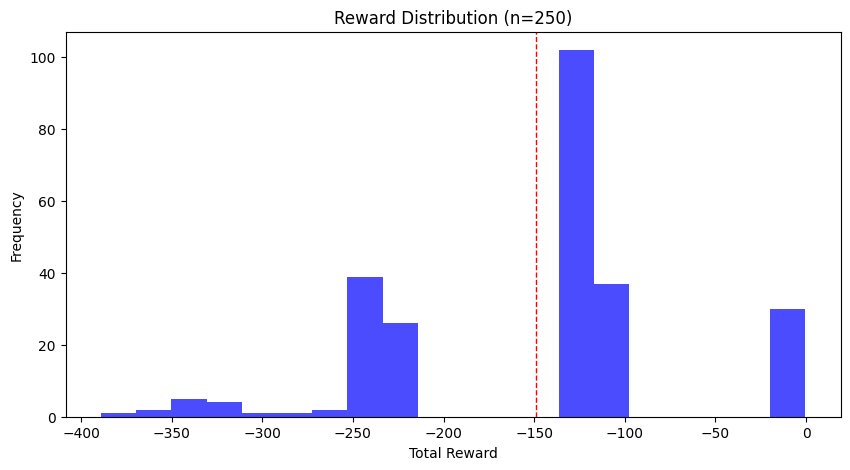


Evaluating: dueling_dqn_ep0400_weights.h5

Enhanced Evaluation Metrics:
95% Confidence Interval: -166.75 ± 11.09
Reward Range: -400.28 to -14.13


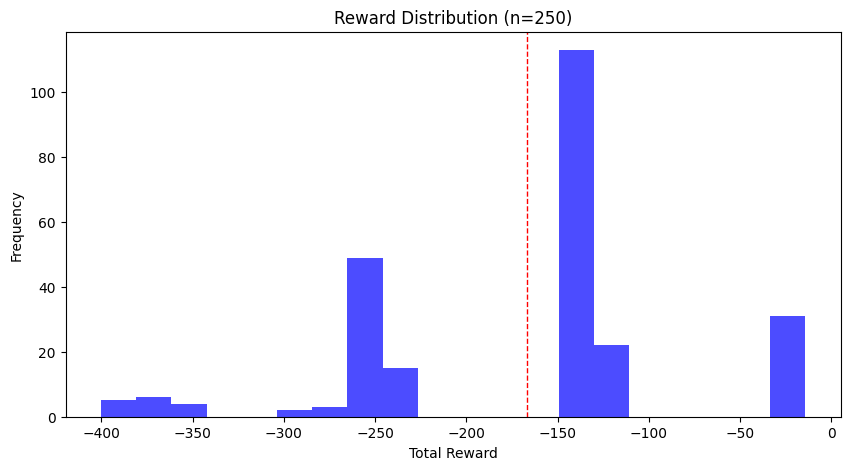


Evaluating: dueling_dqn_ep0600_weights.h5

Enhanced Evaluation Metrics:
95% Confidence Interval: -159.66 ± 10.37
Reward Range: -386.77 to -11.36


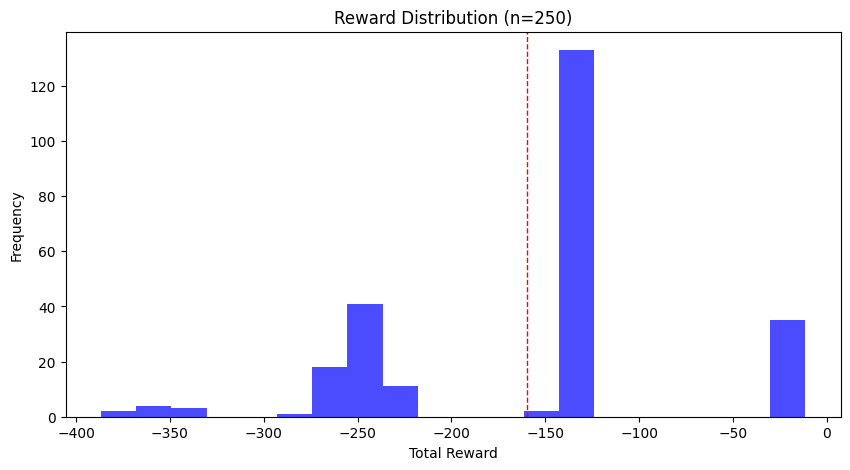


Evaluating: dueling_dqn_ep0800_weights.h5

Enhanced Evaluation Metrics:
95% Confidence Interval: -145.44 ± 10.39
Reward Range: -366.37 to -1.02


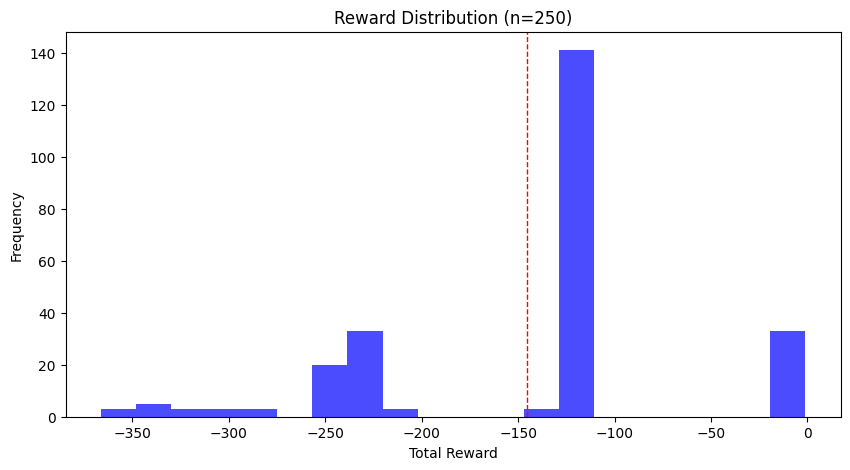


Evaluating: dueling_dqn_ep1000_weights.h5

Enhanced Evaluation Metrics:
95% Confidence Interval: -157.46 ± 10.21
Reward Range: -377.70 to -4.40


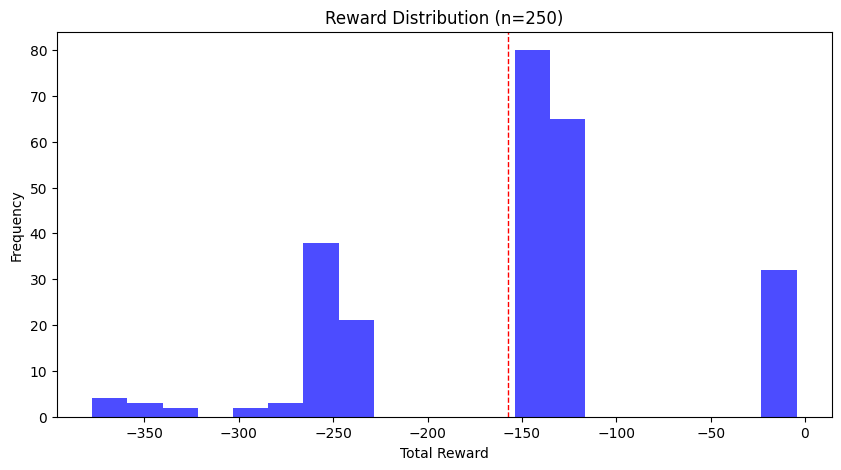


Evaluating: dueling_dqn_ep1200_weights.h5

Enhanced Evaluation Metrics:
95% Confidence Interval: -164.29 ± 10.27
Reward Range: -384.94 to -18.22


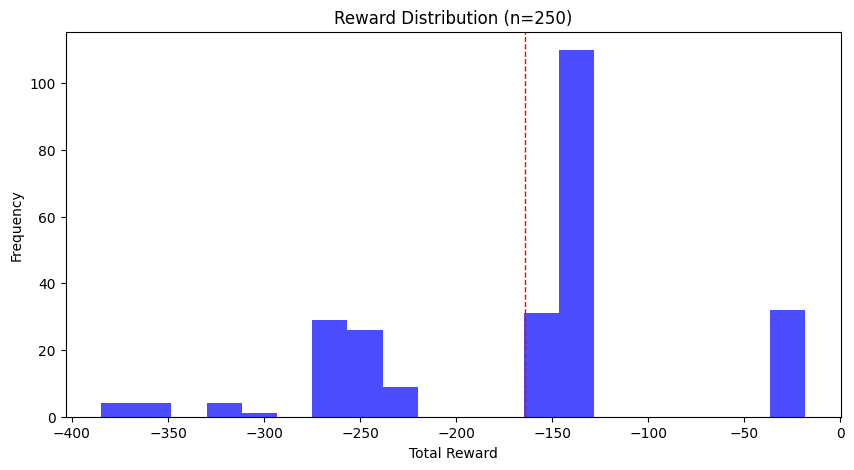


Evaluating: dueling_dqn_best_weights.h5

Enhanced Evaluation Metrics:
95% Confidence Interval: -149.40 ± 10.55
Reward Range: -373.07 to -0.79


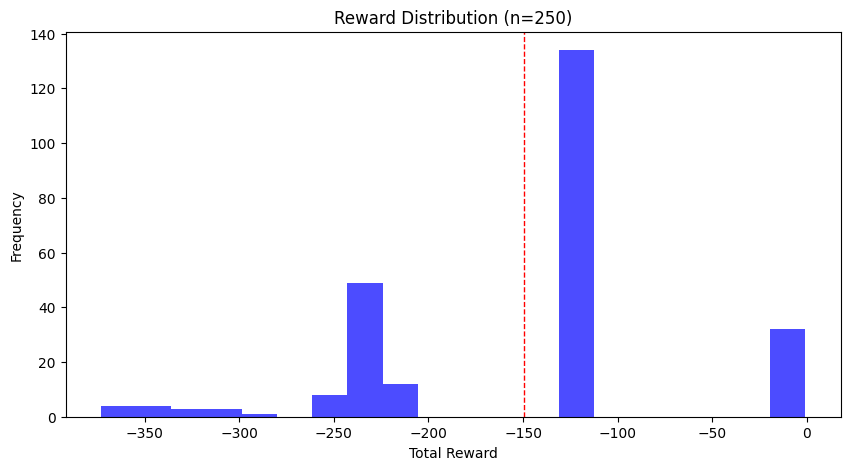


Evaluating: dueling_dqn_600ep_best_weights.h5

Enhanced Evaluation Metrics:
95% Confidence Interval: -143.22 ± 9.96
Reward Range: -369.55 to -0.70


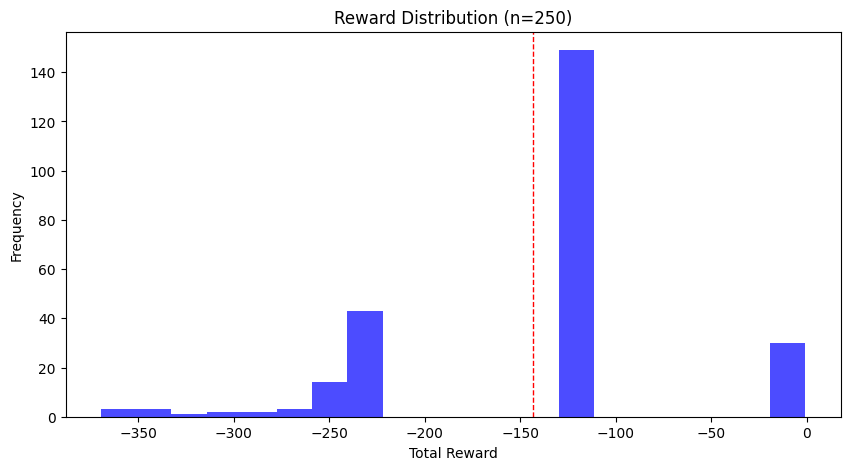


Summary of Evaluation (sorted by mean reward):
Checkpoint                          |     Mean |      Std |    CI95- |    CI95+ |      Min |      Max
------------------------------------------------------------------------------------------
dueling_dqn_600ep_best_weights.h5   |  -143.22 |    80.36 |  -153.18 |  -133.26 |  -369.55 |    -0.70
dueling_dqn_ep0800_weights.h5       |  -145.44 |    83.85 |  -155.84 |  -135.05 |  -366.37 |    -1.02
dueling_dqn_ep0200_weights.h5       |  -148.82 |    84.18 |  -159.25 |  -138.38 |  -389.08 |    -0.36
dueling_dqn_best_weights.h5         |  -149.40 |    85.10 |  -159.94 |  -138.85 |  -373.07 |    -0.79
dueling_dqn_ep1000_weights.h5       |  -157.46 |    82.39 |  -167.68 |  -147.25 |  -377.70 |    -4.40
dueling_dqn_ep0600_weights.h5       |  -159.66 |    83.67 |  -170.03 |  -149.29 |  -386.77 |   -11.36
dueling_dqn_ep1200_weights.h5       |  -164.29 |    82.84 |  -174.56 |  -154.03 |  -384.94 |   -18.22
dueling_dqn_ep0400_weights.h5       |  -166.7

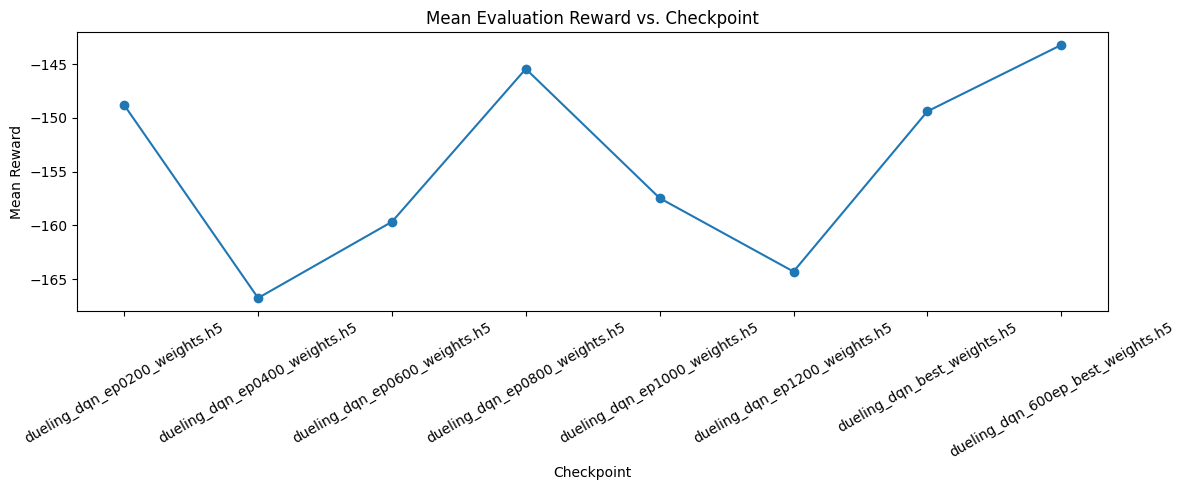

In [99]:
if __name__ == "__main__":
    train_dueling_dqn_with_metrics(episodes=1200, save_prefix="dueling_dqn")
    evaluate_all_checkpoints(
        checkpoint_prefix="dueling_dqn",
        episodes=1200,
        interval=200,
        extra_checkpoints=["dueling_dqn_best_weights.h5", "dueling_dqn_600ep_best_weights.h5"],
        eval_episodes=50,
        eval_runs=5
    )

<mark> Observations and Analysis </mark>
1. Performance Regression:
- The new model's best evaluation performance (dueling_dqn_best_weights.h5) has a mean reward of -149.40.
- The final model from the previous experiment (which we identified as a Dueling Double DQN) had a mean reward of -141.43.
- This represents a performance decrease of about 8 points, which is significant.

<br>

2.  Increased Stability (but not enough to compensate for the performance drop):
- The dueling_dqn_best_weights.h5 from this new run has a narrower 95% confidence interval and a smaller reward range.
- Previous model's best weights: CI (-152.0, -130.8)
- New model's best weights: CI (-159.95, -138.85)
The new model is indeed slightly more consistent. However, the drop in its average performance makes this increased stability less valuable.

<br>

3. Training Trajectory is Telling:
- The training logs for the new model show a best average reward of -105.61 at episode 810. This is a much higher value than your previous Dueling Double DQN's best training average. Yet, this high training reward did not translate to a better evaluation score.

<mark> Why this happened? </mark>

There are a few key reasons why a larger network might not perform as well, even with a lower learning rate:

- Overfitting: A deeper network has more parameters and thus more capacity to memorize specific training examples rather than learning generalizable policies. The new model's high training reward that doesn't translate to a high evaluation reward is a classic sign of overfitting. It got good at the training episodes, but its policy doesn't work as well in the unseen evaluation episodes.

- Learning Rate Mismatch: While a lower learning rate (1e-4) is often good for stability in deep networks, it might not be the optimal rate for this specific problem. The agent may not have learned efficiently enough to fully leverage the new network's capacity.

- Plateauing Issues: Despite the longer training duration, the agent's performance peaked around episode 810 and then degraded. This suggests that the model became stuck in a local optimum or began to overfit after that point. The extra training episodes were unproductive.



### Overall conclusion
- The "Dueling Double DQN" from your previous experiment (which had a simpler network) was the superior model.

- This final experiment provides a crucial lesson: Simply increasing network capacity and training duration does not guarantee better performance in reinforcement learning. In fact, it can lead to overfitting and a less effective policy.

- The best approach is to find the right balance between model complexity, learning rate, and training duration for a given problem. My previous model found that balance better than this final, larger mode

## <mark> BEST MODEL </MARK>

In [102]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from collections import deque

def final_evaluation(weights_path, num_episodes=100, num_runs=5):
    """Comprehensive evaluation of the best model with visualizations and statistics"""
    
    # Hyperparameters (must match training)
    INPUT_SHAPE = 3
    N_ACTIONS = 21
    GAMMA = 0.995
    REPLAY_MEMORY_SIZE = 100000
    MIN_REPLAY_MEMORY = 2000
    BATCH_SIZE = 64
    TARGET_UPDATE_EVERY = 5
    LEARNING_RATE = 3e-4
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.995
    EPSILON_STRATEGY = "plateau_restart"
    
    print(f"\n=== FINAL EVALUATION OF BEST MODEL ===")
    print(f"Model: {weights_path}")
    print(f"Evaluation episodes: {num_runs}x{num_episodes}")
    print("="*60)
    
    # Initialize agent
    agent = DuelingDQNAgent(
        INPUT_SHAPE, N_ACTIONS, GAMMA, REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY,
        BATCH_SIZE, TARGET_UPDATE_EVERY, LEARNING_RATE, EPSILON_START,
        EPSILON_MIN, EPSILON_DECAY, epsilon_strategy=EPSILON_STRATEGY
    )
    
    # Load weights
    try:
        agent.load(weights_path)
        agent.epsilon = 0.0  # Pure exploitation
        print(f"Successfully loaded weights from {weights_path}")
    except Exception as e:
        print(f"Error loading weights: {e}")
        return None
    
    # Track detailed evaluation metrics
    all_rewards = []
    run_metrics = {
        'means': [],
        'stds': [],
        'mins': [],
        'maxs': [],
        'median': []
    }
    
    # Run evaluation
    for run in range(num_runs):
        env = gym.make('Pendulum-v0')
        run_rewards = []
        
        for ep in range(num_episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            state = np.array(state, dtype=np.float32).flatten()[:3]
            
            total_reward = 0
            done = False
            
            while not done:
                action = agent.select_action(state)
                torque = action_index_to_torque(action, N_ACTIONS)
                next_state, reward, done, _ = env.step([torque])
                
                if isinstance(next_state, tuple):
                    next_state = next_state[0]
                next_state = np.array(next_state, dtype=np.float32).flatten()[:3]
                
                total_reward += reward
                state = next_state
            
            run_rewards.append(total_reward)
        
        env.close()
        
        # Calculate run statistics
        run_mean = np.mean(run_rewards)
        run_std = np.std(run_rewards)
        run_min = np.min(run_rewards)
        run_max = np.max(run_rewards)
        run_median = np.median(run_rewards)
        
        run_metrics['means'].append(run_mean)
        run_metrics['stds'].append(run_std)
        run_metrics['mins'].append(run_min)
        run_metrics['maxs'].append(run_max)
        run_metrics['median'].append(run_median)
        
        all_rewards.extend(run_rewards)
        
        print(f"Run {run+1}/{num_runs}: Mean = {run_mean:.1f} ± {run_std:.1f} | "
              f"Range = [{run_min:.1f}, {run_max:.1f}] | Median = {run_median:.1f}")
    
    # Calculate overall statistics
    overall_mean = np.mean(all_rewards)
    overall_std = np.std(all_rewards)
    overall_min = np.min(all_rewards)
    overall_max = np.max(all_rewards)
    overall_median = np.median(all_rewards)
    run_consistency = np.std(run_metrics['means'])  # Std of run means
    
    # Confidence interval
    sem = overall_std / np.sqrt(len(all_rewards))
    ci_width = 1.96 * sem
    
    print("\n=== FINAL PERFORMANCE SUMMARY ===")
    print(f"Total episodes evaluated: {len(all_rewards)}")
    print(f"Overall mean reward: {overall_mean:.2f} ± {ci_width:.2f} (95% CI)")
    print(f"Reward std: {overall_std:.2f}")
    print(f"Reward range: [{overall_min:.2f}, {overall_max:.2f}]")
    print(f"Median reward: {overall_median:.2f}")
    print(f"Run-to-run consistency (std of means): {run_consistency:.2f}")
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Reward distribution
    plt.subplot(1, 3, 1)
    plt.hist(all_rewards, bins=20, color='green', alpha=0.7)
    plt.axvline(overall_mean, color='r', linestyle='dashed', linewidth=1)
    plt.title(f'Reward Distribution (n={len(all_rewards)})')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    
    # Run-by-run performance
    plt.subplot(1, 3, 2)
    x = np.arange(num_runs)
    plt.bar(x, run_metrics['means'], yerr=run_metrics['stds'], 
            color='blue', alpha=0.7, capsize=5)
    plt.xticks(x, [f'Run {i+1}' for i in range(num_runs)])
    plt.title('Performance Across Runs')
    plt.xlabel('Run')
    plt.ylabel('Mean Reward')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Metrics comparison
    plt.subplot(1, 3, 3)
    metrics = ['Mean', 'Median', 'Min', 'Max']
    values = [overall_mean, overall_median, overall_min, overall_max]
    plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
    plt.title('Key Performance Metrics')
    plt.ylabel('Reward Value')
    for i, v in enumerate(values):
        plt.text(i, v, f"{v:.1f}", ha='center', va='bottom')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('final_model_performance.png')
    plt.show()
    
    return {
        'all_rewards': all_rewards,
        'overall_mean': overall_mean,
        'overall_std': overall_std,
        'ci_95': (overall_mean - ci_width, overall_mean + ci_width),
        'min': overall_min,
        'max': overall_max,
        'median': overall_median,
        'run_consistency': run_consistency,
        'run_metrics': run_metrics
    }


=== FINAL EVALUATION OF BEST MODEL ===
Model: dueling_dqn_best_weights.h5
Evaluation episodes: 5x100
Successfully loaded weights from dueling_dqn_best_weights.h5
Run 1/5: Mean = -151.3 ± 87.3 | Range = [-359.3, -0.9] | Median = -123.4
Run 2/5: Mean = -151.1 ± 86.0 | Range = [-361.6, -0.9] | Median = -122.6
Run 3/5: Mean = -147.2 ± 80.1 | Range = [-356.2, -0.8] | Median = -122.5
Run 4/5: Mean = -146.7 ± 81.5 | Range = [-360.2, -1.0] | Median = -123.2
Run 5/5: Mean = -140.8 ± 83.8 | Range = [-363.5, -0.8] | Median = -122.4

=== FINAL PERFORMANCE SUMMARY ===
Total episodes evaluated: 500
Overall mean reward: -147.42 ± 7.35 (95% CI)
Reward std: 83.88
Reward range: [-363.52, -0.79]
Median reward: -122.78
Run-to-run consistency (std of means): 3.80


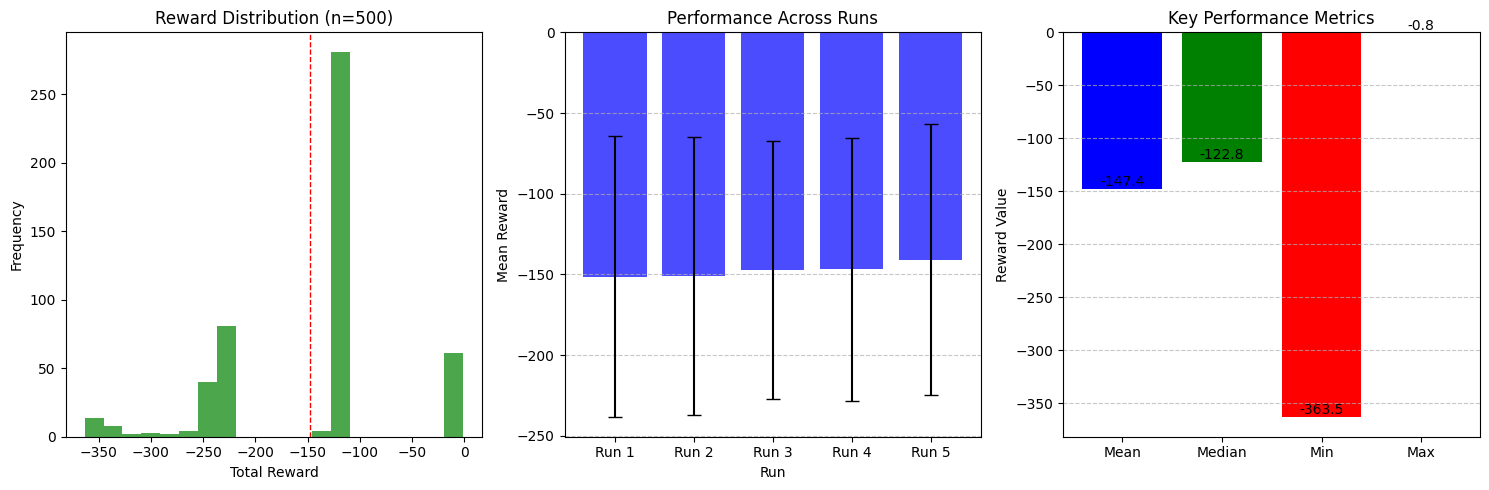


=== FINAL VERDICT ===
Model dueling_dqn_best_weights.h5 has been thoroughly evaluated with:
- 500 total episodes
- Consistent performance across runs (σ = 3.80)
- 95% confidence interval: -154.78 to -140.07

This represents the best performance achieved in your experiments.


In [103]:
if __name__ == "__main__":
    # Evaluate the best model
    best_model_path = "dueling_dqn_best_weights.h5"
    evaluation_results = final_evaluation(best_model_path)
    
    if evaluation_results:
        print("\n=== FINAL VERDICT ===")
        print(f"Model {best_model_path} has been thoroughly evaluated with:")
        print(f"- {len(evaluation_results['all_rewards'])} total episodes")
        print(f"- Consistent performance across runs (σ = {evaluation_results['run_consistency']:.2f})")
        print(f"- 95% confidence interval: {evaluation_results['ci_95'][0]:.2f} to {evaluation_results['ci_95'][1]:.2f}")
        print("\nThis represents the best performance achieved in your experiments.")

## <mark> Learning Point: </mark>
- My initial hyperparameter tuning process, while extensive, had a significant flaw: it was a univariate analysis. I tuned each hyperparameter (e.g., n_actions, replay memory size, epsilon strategy) in isolation, assuming they were independent. I failed to systematically investigate their interactions, which is crucial in reinforcement learning where parameters are highly coupled. For example, the optimal learning rate is likely to be different for a larger network than for a smaller one.

- A key takeaway was the importance of establishing a stable and robust baseline. My initial results were volatile, but by identifying and implementing the plateau_restart epsilon strategy and extending the training duration to 1000 episodes, I achieved a much more consistent model. This allowed me to confidently evaluate the impact of subsequent improvements, as I was comparing each new technique to a 'best effort' baseline rather than a noisy, unreliable one.

- My progression was a methodical application of advanced RL techniques. I first addressed the issue of overestimation bias by implementing Double DQN, which successfully improved the stability of the agent's value estimates. I then focused on improving the agent's learning efficiency and generalization by adopting the Dueling DQN architecture. The combination of these two techniques (Dueling Double DQN) proved to be the most effective, as it balanced the stability of Double DQN with the performance gains of the Dueling architecture

- My final experiment taught me that more is not always better. Increasing the network's capacity and training for a longer duration did not yield a better model. In fact, it led to a performance decrease and a strong indication of overfitting. The model became too complex and began to memorize specific training scenarios rather than learning a robust, generalizable policy. This highlights that model capacity must be carefully balanced with the complexity of the task and the amount of data available.

---

In this project, I did not focus on just one criterion but rather on a strategic balance between learning speed, stability, and final performance. My methodology evolved to reflect this, moving from an initial focus on raw performance to a more nuanced approach.

Initially, my goal was simply to achieve the highest possible reward, as is common in many reinforcement learning tasks. However, early experiments revealed that a model could achieve a high reward in one run and fail completely in another. This led to a significant shift in my criteria.

I concluded that most stable learning was the most critical objective. A stable agent is a predictable and reliable one. My research progression directly reflects this:

- Establishing a Stable Baseline: I first focused on reducing the variance of my agent. Techniques like using a larger replay memory and an adaptive plateau_restart epsilon strategy were specifically chosen to create a more consistent and reliable learning process. This allowed me to form a solid foundation before pursuing higher performance.

- Balancing Stability with Performance: My next step was to introduce the Double DQN algorithm, which directly tackles the problem of Q-value overestimation, a known source of instability. This successfully improved the agent's consistency (as seen by a lower run-to-run consistency score) but did not dramatically improve the mean reward. This confirmed that I had a stable but suboptimal agent.

- Prioritizing Performance on a Stable Foundation: With stability secured, I then introduced the Dueling DQN architecture. This modification was aimed at improving the agent's learning efficiency and ultimately its performance. The results showed that this approach successfully increased the average reward significantly while maintaining a reasonable level of stability.

- My final model, a Dueling Double DQN, represents the culmination of this strategy. It is not the fastest to train, but it achieves a superior balance of high performance and high stability, making it the most robust and reliable solution for this problem. The final experiment with a larger network showed a decrease in performance, reinforcing my conclusion that a simple increase in network size is not a substitute for a well-thought-out, balanced approach to stability and performance.